In [1]:
import tensorflow as tf
import os
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

print("Num GPUs Available:", len(
    tf.config.experimental.list_physical_devices('GPU')))
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

Num GPUs Available: 1


In [2]:
!pip install tensorflow_probability==0.8.0

     |████████████████████████████████| 2.5 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.8.0rc0
    Uninstalling tensorflow-probability-0.8.0rc0:
      Successfully uninstalled tensorflow-probability-0.8.0rc0


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

In [4]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
import tensorflow_probability as tfp
tfd = tfp.distributions
d = tfd.Normal(loc=3, scale=1.5)           #A
x = d.sample(2) # Draw two random points.    #B
px = d.prob(x) # Compute density/mass.       #C
print(x)
print(px)
#A create a 1D Normal distribution with mean 3 and standard deviation 1.5
#B sample 2 realizations from the Normal distribution
#C compute the likelihood for each of the two sampled values under the defined Normal distribution

tf.Tensor([1.0828874  0.28570342], shape=(2,), dtype=float32)
tf.Tensor([0.11752062 0.05173581], shape=(2,), dtype=float32)


In [5]:
dist = tfd.Normal(loc=1.0, scale=0.1)
print('sample   :', dist.sample(3).numpy()) #Samples 3 numbers
print('prob     :',dist.prob((0,1,2)).numpy()) #Calculates the probabilities for positions 0,1,2
print('log_prob :',dist.log_prob((0,1,2)).numpy()) #Same as above just log
print('cdf      :',dist.cdf((0,1,2)).numpy()) #Calculates the cummulative distributions
print('mean     :',dist.mean().numpy()) #Returns the mean of the distribution
print('stddev   :',dist.stddev().numpy())

sample   : [0.96555626 0.9381393  0.96319354]
prob     : [7.6946093e-22 3.9894230e+00 7.6946093e-22]
log_prob : [-48.616352    1.3836466 -48.616352 ]
cdf      : [7.619853e-24 5.000000e-01 1.000000e+00]
mean     : 1.0
stddev   : 0.1


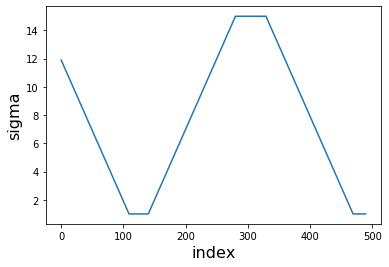

In [6]:
### define variance structure of the simulation
x1=np.arange(1,12,0.1)
x1=x1[::-1]
x2=np.repeat(1,30)
x3=np.arange(1,15,0.1)
x4=np.repeat(15,50)
x5=x3[::-1]
x6=np.repeat(1,20)
x=np.concatenate([x1,x2,x3,x4,x5,x6])
plt.plot(x)
plt.xlabel("index",size=16)
plt.ylabel("sigma",size=16)#pred
plt.show()

In [7]:
# generation the x values for the simulated data
np.random.seed(4710)
noise=np.random.normal(0,x,len(x))
np.random.seed(99)
first_part=len(x1)
x11=np.random.uniform(-1,1,first_part)
np.random.seed(97)
x12=np.random.uniform(1,6,len(noise)-first_part)
x=np.concatenate([x11,x12])
x=np.sort(x)


In [8]:
## generation the y values for the simulated noise and the x values
y=2.7*x+noise

In [9]:
y=y.reshape((len(y),1))
x=x.reshape((len(x),1))

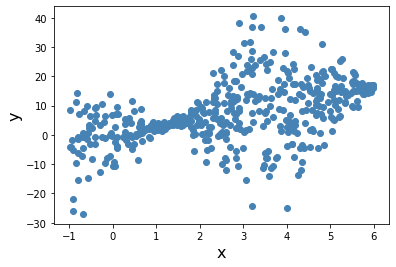

In [10]:
# lets visualize the data
plt.scatter(x,y,color="steelblue") 
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=47)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=22)

print("nr of traning samples = ",len(x_train))
print("nr of validation samples = ",len(x_val))
print("nr of test samples = ",len(x_test))

nr of traning samples =  293
nr of validation samples =  74
nr of test samples =  123


In [12]:
## reordering so x values are in increasiong order
order_idx_train=np.squeeze(x_train.argsort(axis=0))
x_train=x_train[order_idx_train]
y_train=y_train[order_idx_train]

order_idx_val=np.squeeze(x_val.argsort(axis=0))
x_val=x_val[order_idx_val]
y_val=y_val[order_idx_val]

order_idx_test=np.squeeze(x_test.argsort(axis=0))
x_test=x_test[order_idx_test]
y_test=y_test[order_idx_test]

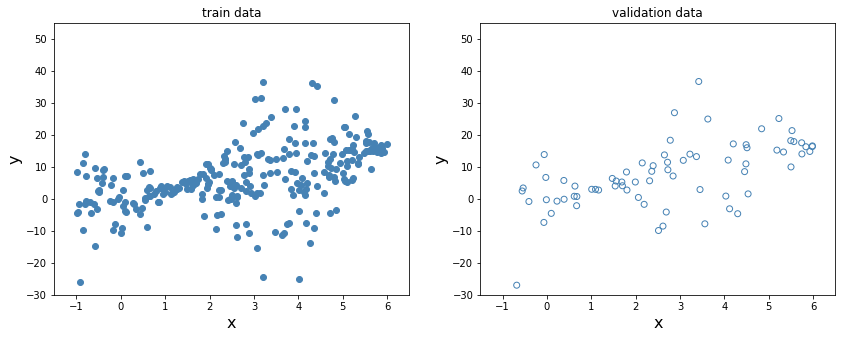

In [13]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])


plt.subplot(1,2,2)
plt.scatter(x_val,y_val,facecolors='none', edgecolors="steelblue")
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.savefig("5.fish.split.pdf")

In [14]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
def NLL(y, distr): 
  return -distr.log_prob(y) #A

def my_dist(params): #B
  return tfd.Normal(loc=params, scale=1)# set the sd to the fixed value 1

inputs = Input(shape=(1,))
params = Dense(1)(inputs)#C

dist = tfp.layers.DistributionLambda(my_dist)(params) #D
model_sd_1 = Model(inputs=inputs, outputs=dist) #E
model_sd_1.compile(Adam(), loss=NLL) #F




#A Function to compute the NLL of an observed y under the fitted distribution distr. 
#B Function to utilize the output of the last layer (params) as the parameter(s) of a distribution
#C Setting up the NN with one output node
#D Calling a distributional layer to take the function my_dist with arguments params.  
#E Connecting the output of the neural network with a distribution
#F Compiling the model with NLL as loss function

model_sd_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
_________________________________________________________________
distribution_lambda (Distrib ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [15]:
def my_dist2(params):
    return tfd.Normal(loc=params[0],scale=1e-3 + tf.math.softplus(0.05 * params[1]))

inputs = Input(shape=(1,))
mean = Dense(1)(inputs)
std = Dense(50,activation="relu")(inputs)
std = Dense(50,activation="relu")(std)
std = Dense(50,activation="relu")(std)
std = Dense(1)(std)
mean = Dense(1)(mean)
distLayer = tfp.layers.DistributionLambda(my_dist2)([mean,std])
model_sd_2 = Model(inputs=inputs,outputs=distLayer)
model_sd_2.compile(Adam(),loss=NLL)

model_sd_2.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           100         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50)           2550        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            2           input_2[0][0]                    
____________________________________________________________________________________________

In [16]:
history = model_sd_2.fit(x_train, y_train, epochs=60000,verbose=1, validation_data=(x_val,y_val))

Train on 293 samples, validate on 74 samples
Epoch 1/60000
293/293 [==============================] - 1s 3ms/sample - loss: 209.3087 - val_loss: 215.4447
Epoch 2/60000
293/293 [==============================] - 0s 221us/sample - loss: 192.3996 - val_loss: 196.6028
Epoch 3/60000
293/293 [==============================] - 0s 261us/sample - loss: 172.4405 - val_loss: 172.1771
Epoch 4/60000
293/293 [==============================] - 0s 209us/sample - loss: 146.6565 - val_loss: 141.9383
Epoch 5/60000
293/293 [==============================] - 0s 144us/sample - loss: 117.4056 - val_loss: 110.0039
Epoch 6/60000
293/293 [==============================] - 0s 211us/sample - loss: 88.1270 - val_loss: 82.7499
Epoch 7/60000
293/293 [==============================] - 0s 166us/sample - loss: 64.1351 - val_loss: 61.3224
Epoch 8/60000
293/293 [==============================] - 0s 146us/sample - loss: 46.8157 - val_loss: 45.6676
Epoch 9/60000
293/293 [==============================] - 0s 163us/sample - 

293/293 [==============================] - 0s 152us/sample - loss: 3.8789 - val_loss: 3.9765
Epoch 77/60000
293/293 [==============================] - 0s 222us/sample - loss: 3.8782 - val_loss: 3.9746
Epoch 78/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.8775 - val_loss: 3.9726
Epoch 79/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.8768 - val_loss: 3.9706
Epoch 80/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.8762 - val_loss: 3.9685
Epoch 81/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.8757 - val_loss: 3.9662
Epoch 82/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.8751 - val_loss: 3.9643
Epoch 83/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.8747 - val_loss: 3.9628
Epoch 84/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.8742 - val_loss: 3.9614
Epoch 85/60000
293/293 [===================

293/293 [==============================] - 0s 181us/sample - loss: 3.8619 - val_loss: 3.9173
Epoch 152/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.8618 - val_loss: 3.9170
Epoch 153/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.8616 - val_loss: 3.9162
Epoch 154/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.8615 - val_loss: 3.9159
Epoch 155/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.8614 - val_loss: 3.9158
Epoch 156/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.8613 - val_loss: 3.9155
Epoch 157/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.8613 - val_loss: 3.9151
Epoch 158/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.8612 - val_loss: 3.9150
Epoch 159/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.8610 - val_loss: 3.9148
Epoch 160/60000
293/293 [==========

293/293 [==============================] - 0s 140us/sample - loss: 3.8540 - val_loss: 3.8988
Epoch 227/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.8540 - val_loss: 3.8984
Epoch 228/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.8538 - val_loss: 3.8984
Epoch 229/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.8537 - val_loss: 3.8984
Epoch 230/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.8536 - val_loss: 3.8982
Epoch 231/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.8535 - val_loss: 3.8981
Epoch 232/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.8534 - val_loss: 3.8980
Epoch 233/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.8533 - val_loss: 3.8978
Epoch 234/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.8531 - val_loss: 3.8975
Epoch 235/60000
293/293 [==========

293/293 [==============================] - 0s 124us/sample - loss: 3.8443 - val_loss: 3.8843
Epoch 302/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.8441 - val_loss: 3.8839
Epoch 303/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.8440 - val_loss: 3.8839
Epoch 304/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.8437 - val_loss: 3.8838
Epoch 305/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.8435 - val_loss: 3.8827
Epoch 306/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.8434 - val_loss: 3.8822
Epoch 307/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.8432 - val_loss: 3.8820
Epoch 308/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.8431 - val_loss: 3.8820
Epoch 309/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.8429 - val_loss: 3.8818
Epoch 310/60000
293/293 [==========

293/293 [==============================] - 0s 122us/sample - loss: 3.8306 - val_loss: 3.8680
Epoch 377/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.8306 - val_loss: 3.8675
Epoch 378/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.8302 - val_loss: 3.8672
Epoch 379/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.8300 - val_loss: 3.8668
Epoch 380/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.8297 - val_loss: 3.8665
Epoch 381/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.8297 - val_loss: 3.8669
Epoch 382/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.8294 - val_loss: 3.8666
Epoch 383/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.8289 - val_loss: 3.8656
Epoch 384/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.8287 - val_loss: 3.8649
Epoch 385/60000
293/293 [==========

293/293 [==============================] - 0s 197us/sample - loss: 3.8124 - val_loss: 3.8489
Epoch 452/60000
293/293 [==============================] - 0s 215us/sample - loss: 3.8123 - val_loss: 3.8490
Epoch 453/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.8117 - val_loss: 3.8486
Epoch 454/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.8115 - val_loss: 3.8478
Epoch 455/60000
293/293 [==============================] - 0s 213us/sample - loss: 3.8111 - val_loss: 3.8460
Epoch 456/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.8107 - val_loss: 3.8456
Epoch 457/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.8105 - val_loss: 3.8460
Epoch 458/60000
293/293 [==============================] - 0s 271us/sample - loss: 3.8101 - val_loss: 3.8456
Epoch 459/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.8097 - val_loss: 3.8462
Epoch 460/60000
293/293 [==========

293/293 [==============================] - 0s 121us/sample - loss: 3.7886 - val_loss: 3.8181
Epoch 527/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.7887 - val_loss: 3.8191
Epoch 528/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.7884 - val_loss: 3.8191
Epoch 529/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.7881 - val_loss: 3.8192
Epoch 530/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.7881 - val_loss: 3.8187
Epoch 531/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.7875 - val_loss: 3.8180
Epoch 532/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.7875 - val_loss: 3.8157
Epoch 533/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.7866 - val_loss: 3.8153
Epoch 534/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.7863 - val_loss: 3.8155
Epoch 535/60000
293/293 [==========

293/293 [==============================] - 0s 161us/sample - loss: 3.7614 - val_loss: 3.7858
Epoch 602/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.7613 - val_loss: 3.7849
Epoch 603/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.7602 - val_loss: 3.7846
Epoch 604/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.7599 - val_loss: 3.7857
Epoch 605/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.7598 - val_loss: 3.7851
Epoch 606/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.7601 - val_loss: 3.7857
Epoch 607/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.7591 - val_loss: 3.7841
Epoch 608/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.7583 - val_loss: 3.7824
Epoch 609/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.7585 - val_loss: 3.7812
Epoch 610/60000
293/293 [==========

293/293 [==============================] - 0s 152us/sample - loss: 3.7306 - val_loss: 3.7460
Epoch 677/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.7299 - val_loss: 3.7463
Epoch 678/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.7286 - val_loss: 3.7461
Epoch 679/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.7286 - val_loss: 3.7460
Epoch 680/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.7277 - val_loss: 3.7446
Epoch 681/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.7275 - val_loss: 3.7440
Epoch 682/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.7279 - val_loss: 3.7430
Epoch 683/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.7276 - val_loss: 3.7429
Epoch 684/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.7273 - val_loss: 3.7430
Epoch 685/60000
293/293 [==========

293/293 [==============================] - 0s 124us/sample - loss: 3.6933 - val_loss: 3.7011
Epoch 752/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.6925 - val_loss: 3.6998
Epoch 753/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.6917 - val_loss: 3.6995
Epoch 754/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.6904 - val_loss: 3.6970
Epoch 755/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.6913 - val_loss: 3.6964
Epoch 756/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.6911 - val_loss: 3.6957
Epoch 757/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.6906 - val_loss: 3.6958
Epoch 758/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.6894 - val_loss: 3.6955
Epoch 759/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.6890 - val_loss: 3.6945
Epoch 760/60000
293/293 [==========

293/293 [==============================] - 0s 160us/sample - loss: 3.6369 - val_loss: 3.6222
Epoch 827/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.6348 - val_loss: 3.6205
Epoch 828/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.6330 - val_loss: 3.6191
Epoch 829/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.6317 - val_loss: 3.6180
Epoch 830/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.6340 - val_loss: 3.6156
Epoch 831/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.6324 - val_loss: 3.6157
Epoch 832/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.6295 - val_loss: 3.6159
Epoch 833/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.6288 - val_loss: 3.6146
Epoch 834/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.6271 - val_loss: 3.6118
Epoch 835/60000
293/293 [==========

293/293 [==============================] - 0s 120us/sample - loss: 3.5586 - val_loss: 3.5295
Epoch 902/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.5576 - val_loss: 3.5274
Epoch 903/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.5565 - val_loss: 3.5276
Epoch 904/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.5570 - val_loss: 3.5251
Epoch 905/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.5560 - val_loss: 3.5232
Epoch 906/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.5544 - val_loss: 3.5228
Epoch 907/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.5529 - val_loss: 3.5207
Epoch 908/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.5540 - val_loss: 3.5191
Epoch 909/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.5533 - val_loss: 3.5196
Epoch 910/60000
293/293 [==========

293/293 [==============================] - 0s 148us/sample - loss: 3.5167 - val_loss: 3.4854
Epoch 977/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.5160 - val_loss: 3.4874
Epoch 978/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.5157 - val_loss: 3.4858
Epoch 979/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.5144 - val_loss: 3.4844
Epoch 980/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.5147 - val_loss: 3.4840
Epoch 981/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.5146 - val_loss: 3.4838
Epoch 982/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.5144 - val_loss: 3.4836
Epoch 983/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.5130 - val_loss: 3.4837
Epoch 984/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.5131 - val_loss: 3.4832
Epoch 985/60000
293/293 [==========

Epoch 1051/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.4862 - val_loss: 3.4569
Epoch 1052/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.4857 - val_loss: 3.4537
Epoch 1053/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.4859 - val_loss: 3.4569
Epoch 1054/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.4846 - val_loss: 3.4488
Epoch 1055/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.4835 - val_loss: 3.4467
Epoch 1056/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.4821 - val_loss: 3.4480
Epoch 1057/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.4822 - val_loss: 3.4503
Epoch 1058/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.4811 - val_loss: 3.4472
Epoch 1059/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.4801 - val_loss: 3.4475
Epoch 1060

293/293 [==============================] - 0s 139us/sample - loss: 3.4483 - val_loss: 3.4099
Epoch 1126/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.4471 - val_loss: 3.4110
Epoch 1127/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.4489 - val_loss: 3.4091
Epoch 1128/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.4484 - val_loss: 3.4130
Epoch 1129/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.4477 - val_loss: 3.4077
Epoch 1130/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.4477 - val_loss: 3.4047
Epoch 1131/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.4468 - val_loss: 3.4080
Epoch 1132/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.4449 - val_loss: 3.4052
Epoch 1133/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.4451 - val_loss: 3.4055
Epoch 1134/60000
293/293 [=

293/293 [==============================] - 0s 125us/sample - loss: 3.4099 - val_loss: 3.3613
Epoch 1200/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.4111 - val_loss: 3.3614
Epoch 1201/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.4050 - val_loss: 3.3668
Epoch 1202/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.4085 - val_loss: 3.3616
Epoch 1203/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.4051 - val_loss: 3.3639
Epoch 1204/60000
293/293 [==============================] - 0s 208us/sample - loss: 3.4049 - val_loss: 3.3643
Epoch 1205/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.4089 - val_loss: 3.3810
Epoch 1206/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.4097 - val_loss: 3.3658
Epoch 1207/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.4062 - val_loss: 3.3672
Epoch 1208/60000
293/293 [=

293/293 [==============================] - 0s 165us/sample - loss: 3.3290 - val_loss: 3.2511
Epoch 1274/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.3330 - val_loss: 3.2601
Epoch 1275/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.3218 - val_loss: 3.2440
Epoch 1276/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.3253 - val_loss: 3.2476
Epoch 1277/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.3266 - val_loss: 3.2642
Epoch 1278/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.3215 - val_loss: 3.2422
Epoch 1279/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.3218 - val_loss: 3.2346
Epoch 1280/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.3096 - val_loss: 3.2452
Epoch 1281/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.3195 - val_loss: 3.2494
Epoch 1282/60000
293/293 [=

293/293 [==============================] - 0s 117us/sample - loss: 3.2098 - val_loss: 3.1126
Epoch 1348/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2163 - val_loss: 3.0974
Epoch 1349/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.2104 - val_loss: 3.1052
Epoch 1350/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.2072 - val_loss: 3.1138
Epoch 1351/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.2070 - val_loss: 3.1015
Epoch 1352/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.2072 - val_loss: 3.1012
Epoch 1353/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.2053 - val_loss: 3.0926
Epoch 1354/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2015 - val_loss: 3.1105
Epoch 1355/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.2047 - val_loss: 3.1315
Epoch 1356/60000
293/293 [=

293/293 [==============================] - 0s 135us/sample - loss: 3.1876 - val_loss: 3.0887
Epoch 1422/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1948 - val_loss: 3.0844
Epoch 1423/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1898 - val_loss: 3.0912
Epoch 1424/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1923 - val_loss: 3.0867
Epoch 1425/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.2232 - val_loss: 3.1311
Epoch 1426/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2082 - val_loss: 3.1271
Epoch 1427/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2118 - val_loss: 3.1119
Epoch 1428/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1984 - val_loss: 3.0962
Epoch 1429/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1955 - val_loss: 3.0935
Epoch 1430/60000
293/293 [=

293/293 [==============================] - 0s 165us/sample - loss: 3.1903 - val_loss: 3.1057
Epoch 1496/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1867 - val_loss: 3.0984
Epoch 1497/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1892 - val_loss: 3.0955
Epoch 1498/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1841 - val_loss: 3.0938
Epoch 1499/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1954 - val_loss: 3.1029
Epoch 1500/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1956 - val_loss: 3.1000
Epoch 1501/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1859 - val_loss: 3.0952
Epoch 1502/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1878 - val_loss: 3.0957
Epoch 1503/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1888 - val_loss: 3.0958
Epoch 1504/60000
293/293 [=

293/293 [==============================] - 0s 184us/sample - loss: 3.1793 - val_loss: 3.0982
Epoch 1570/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1912 - val_loss: 3.0981
Epoch 1571/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1834 - val_loss: 3.1041
Epoch 1572/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1888 - val_loss: 3.0877
Epoch 1573/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1907 - val_loss: 3.0975
Epoch 1574/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1931 - val_loss: 3.1007
Epoch 1575/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1850 - val_loss: 3.0944
Epoch 1576/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1805 - val_loss: 3.1033
Epoch 1577/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1817 - val_loss: 3.0948
Epoch 1578/60000
293/293 [=

293/293 [==============================] - 0s 132us/sample - loss: 3.1786 - val_loss: 3.1208
Epoch 1644/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1877 - val_loss: 3.0884
Epoch 1645/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1839 - val_loss: 3.0962
Epoch 1646/60000
293/293 [==============================] - ETA: 0s - loss: 3.309 - 0s 124us/sample - loss: 3.1812 - val_loss: 3.0894
Epoch 1647/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1825 - val_loss: 3.0960
Epoch 1648/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1856 - val_loss: 3.0889
Epoch 1649/60000
293/293 [==============================] - 0s 212us/sample - loss: 3.1850 - val_loss: 3.0938
Epoch 1650/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1802 - val_loss: 3.0959
Epoch 1651/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1790 - val_loss: 3.1041
Epo

293/293 [==============================] - 0s 199us/sample - loss: 3.1849 - val_loss: 3.1392
Epoch 1718/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.2082 - val_loss: 3.1022
Epoch 1719/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1924 - val_loss: 3.1006
Epoch 1720/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1852 - val_loss: 3.1106
Epoch 1721/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1902 - val_loss: 3.1062
Epoch 1722/60000
293/293 [==============================] - 0s 226us/sample - loss: 3.1875 - val_loss: 3.1048
Epoch 1723/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1982 - val_loss: 3.0958
Epoch 1724/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1939 - val_loss: 3.0959
Epoch 1725/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1796 - val_loss: 3.1276
Epoch 1726/60000
293/293 [=

293/293 [==============================] - 0s 139us/sample - loss: 3.1803 - val_loss: 3.0992
Epoch 1792/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1826 - val_loss: 3.0966
Epoch 1793/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1794 - val_loss: 3.1018
Epoch 1794/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1793 - val_loss: 3.0962
Epoch 1795/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.2141 - val_loss: 3.1242
Epoch 1796/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1956 - val_loss: 3.1402
Epoch 1797/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1920 - val_loss: 3.1024
Epoch 1798/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1821 - val_loss: 3.1006
Epoch 1799/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1815 - val_loss: 3.1054
Epoch 1800/60000
293/293 [=

293/293 [==============================] - 0s 139us/sample - loss: 3.1944 - val_loss: 3.1319
Epoch 1866/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1874 - val_loss: 3.1276
Epoch 1867/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1877 - val_loss: 3.1211
Epoch 1868/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1884 - val_loss: 3.1043
Epoch 1869/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.2001 - val_loss: 3.1179
Epoch 1870/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1933 - val_loss: 3.1062
Epoch 1871/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1869 - val_loss: 3.1044
Epoch 1872/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.2129 - val_loss: 3.1283
Epoch 1873/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1971 - val_loss: 3.1030
Epoch 1874/60000
293/293 [=

293/293 [==============================] - 0s 150us/sample - loss: 3.2016 - val_loss: 3.1242
Epoch 1940/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.2017 - val_loss: 3.1101
Epoch 1941/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1881 - val_loss: 3.0970
Epoch 1942/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1799 - val_loss: 3.0998
Epoch 1943/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1847 - val_loss: 3.0967
Epoch 1944/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1804 - val_loss: 3.0958
Epoch 1945/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1821 - val_loss: 3.0945
Epoch 1946/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1780 - val_loss: 3.0967
Epoch 1947/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1795 - val_loss: 3.0967
Epoch 1948/60000
293/293 [=

293/293 [==============================] - 0s 158us/sample - loss: 3.1795 - val_loss: 3.0934
Epoch 2014/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.1835 - val_loss: 3.0925
Epoch 2015/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1831 - val_loss: 3.1099
Epoch 2016/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1893 - val_loss: 3.1030
Epoch 2017/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1829 - val_loss: 3.0914
Epoch 2018/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1766 - val_loss: 3.1104
Epoch 2019/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1822 - val_loss: 3.0954
Epoch 2020/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1896 - val_loss: 3.1027
Epoch 2021/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1838 - val_loss: 3.0997
Epoch 2022/60000
293/293 [=

293/293 [==============================] - 0s 163us/sample - loss: 3.1872 - val_loss: 3.0903
Epoch 2088/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1820 - val_loss: 3.0929
Epoch 2089/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1787 - val_loss: 3.0925
Epoch 2090/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1757 - val_loss: 3.0903
Epoch 2091/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1747 - val_loss: 3.0912
Epoch 2092/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1783 - val_loss: 3.0866
Epoch 2093/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1794 - val_loss: 3.0943
Epoch 2094/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1763 - val_loss: 3.0943
Epoch 2095/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1860 - val_loss: 3.0899
Epoch 2096/60000
293/293 [=

293/293 [==============================] - 0s 185us/sample - loss: 3.2952 - val_loss: 3.1843
Epoch 2162/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.2525 - val_loss: 3.1140
Epoch 2163/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1909 - val_loss: 3.1231
Epoch 2164/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1850 - val_loss: 3.0935
Epoch 2165/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1861 - val_loss: 3.0933
Epoch 2166/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1813 - val_loss: 3.1136
Epoch 2167/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1811 - val_loss: 3.0965
Epoch 2168/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1739 - val_loss: 3.0996
Epoch 2169/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1790 - val_loss: 3.1009
Epoch 2170/60000
293/293 [=

293/293 [==============================] - 0s 196us/sample - loss: 3.1830 - val_loss: 3.0880
Epoch 2236/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1774 - val_loss: 3.1141
Epoch 2237/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1887 - val_loss: 3.0879
Epoch 2238/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1709 - val_loss: 3.1271
Epoch 2239/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.2046 - val_loss: 3.1197
Epoch 2240/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.2202 - val_loss: 3.1089
Epoch 2241/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1854 - val_loss: 3.1344
Epoch 2242/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1835 - val_loss: 3.1005
Epoch 2243/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1742 - val_loss: 3.0987
Epoch 2244/60000
293/293 [=

293/293 [==============================] - 0s 155us/sample - loss: 3.1971 - val_loss: 3.0994
Epoch 2310/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1842 - val_loss: 3.0913
Epoch 2311/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1792 - val_loss: 3.0954
Epoch 2312/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1737 - val_loss: 3.1116
Epoch 2313/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1972 - val_loss: 3.1077
Epoch 2314/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.2216 - val_loss: 3.1337
Epoch 2315/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.2004 - val_loss: 3.0942
Epoch 2316/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.2039 - val_loss: 3.0912
Epoch 2317/60000
293/293 [==============================] - 0s 208us/sample - loss: 3.2099 - val_loss: 3.1556
Epoch 2318/60000
293/293 [=

293/293 [==============================] - 0s 135us/sample - loss: 3.2079 - val_loss: 3.1443
Epoch 2384/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.2206 - val_loss: 3.0917
Epoch 2385/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1752 - val_loss: 3.1110
Epoch 2386/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2011 - val_loss: 3.0964
Epoch 2387/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1817 - val_loss: 3.0911
Epoch 2388/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1965 - val_loss: 3.0974
Epoch 2389/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1841 - val_loss: 3.0990
Epoch 2390/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1824 - val_loss: 3.0976
Epoch 2391/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1847 - val_loss: 3.1179
Epoch 2392/60000
293/293 [=

293/293 [==============================] - 0s 118us/sample - loss: 3.1816 - val_loss: 3.1015
Epoch 2458/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1788 - val_loss: 3.1043
Epoch 2459/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.1758 - val_loss: 3.1049
Epoch 2460/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1744 - val_loss: 3.1190
Epoch 2461/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1774 - val_loss: 3.1009
Epoch 2462/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1780 - val_loss: 3.0950
Epoch 2463/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1731 - val_loss: 3.0996
Epoch 2464/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1731 - val_loss: 3.0942
Epoch 2465/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1766 - val_loss: 3.0941
Epoch 2466/60000
293/293 [=

293/293 [==============================] - 0s 171us/sample - loss: 3.1770 - val_loss: 3.1027
Epoch 2532/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1712 - val_loss: 3.1084
Epoch 2533/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1862 - val_loss: 3.1025
Epoch 2534/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.2021 - val_loss: 3.0967
Epoch 2535/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1946 - val_loss: 3.1033
Epoch 2536/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1729 - val_loss: 3.1220
Epoch 2537/60000
293/293 [==============================] - 0s 206us/sample - loss: 3.1859 - val_loss: 3.1017
Epoch 2538/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1764 - val_loss: 3.1009
Epoch 2539/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1815 - val_loss: 3.1053
Epoch 2540/60000
293/293 [=

293/293 [==============================] - 0s 162us/sample - loss: 3.1719 - val_loss: 3.0936
Epoch 2606/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1717 - val_loss: 3.0980
Epoch 2607/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1774 - val_loss: 3.1059
Epoch 2608/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1755 - val_loss: 3.0920
Epoch 2609/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1717 - val_loss: 3.1016
Epoch 2610/60000
293/293 [==============================] - 0s 206us/sample - loss: 3.1798 - val_loss: 3.0929
Epoch 2611/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1730 - val_loss: 3.0944
Epoch 2612/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1761 - val_loss: 3.0987
Epoch 2613/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1753 - val_loss: 3.0960
Epoch 2614/60000
293/293 [=

293/293 [==============================] - 0s 150us/sample - loss: 3.1726 - val_loss: 3.1011
Epoch 2680/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1728 - val_loss: 3.0996
Epoch 2681/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.1727 - val_loss: 3.1055
Epoch 2682/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1960 - val_loss: 3.1019
Epoch 2683/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.2034 - val_loss: 3.1118
Epoch 2684/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1858 - val_loss: 3.1089
Epoch 2685/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1768 - val_loss: 3.1007
Epoch 2686/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1750 - val_loss: 3.0958
Epoch 2687/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1864 - val_loss: 3.1005
Epoch 2688/60000
293/293 [=

293/293 [==============================] - 0s 118us/sample - loss: 3.1761 - val_loss: 3.0966
Epoch 2754/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1805 - val_loss: 3.0980
Epoch 2755/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1775 - val_loss: 3.1062
Epoch 2756/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1756 - val_loss: 3.0946
Epoch 2757/60000
293/293 [==============================] - 0s 219us/sample - loss: 3.1762 - val_loss: 3.0947
Epoch 2758/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1712 - val_loss: 3.1072
Epoch 2759/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1831 - val_loss: 3.1034
Epoch 2760/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1830 - val_loss: 3.1159
Epoch 2761/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1808 - val_loss: 3.1181
Epoch 2762/60000
293/293 [=

293/293 [==============================] - 0s 100us/sample - loss: 3.1831 - val_loss: 3.0998
Epoch 2828/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1847 - val_loss: 3.0952
Epoch 2829/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1737 - val_loss: 3.0969
Epoch 2830/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1751 - val_loss: 3.1000
Epoch 2831/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1733 - val_loss: 3.1039
Epoch 2832/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1705 - val_loss: 3.0976
Epoch 2833/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1707 - val_loss: 3.1062
Epoch 2834/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1744 - val_loss: 3.0986
Epoch 2835/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1763 - val_loss: 3.0983
Epoch 2836/60000
293/293 [=

293/293 [==============================] - 0s 124us/sample - loss: 3.1689 - val_loss: 3.0913
Epoch 2902/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1728 - val_loss: 3.0967
Epoch 2903/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1765 - val_loss: 3.0964
Epoch 2904/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1839 - val_loss: 3.1004
Epoch 2905/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1733 - val_loss: 3.1004
Epoch 2906/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1814 - val_loss: 3.0945
Epoch 2907/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1885 - val_loss: 3.0939
Epoch 2908/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1701 - val_loss: 3.1001
Epoch 2909/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1717 - val_loss: 3.1024
Epoch 2910/60000
293/293 [=

293/293 [==============================] - 0s 143us/sample - loss: 3.1735 - val_loss: 3.0954
Epoch 2976/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1719 - val_loss: 3.0953
Epoch 2977/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1875 - val_loss: 3.0993
Epoch 2978/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1846 - val_loss: 3.0958
Epoch 2979/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1764 - val_loss: 3.1022
Epoch 2980/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1768 - val_loss: 3.1038
Epoch 2981/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1762 - val_loss: 3.0972
Epoch 2982/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1765 - val_loss: 3.1053
Epoch 2983/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1776 - val_loss: 3.1077
Epoch 2984/60000
293/293 [=

293/293 [==============================] - 0s 125us/sample - loss: 3.1841 - val_loss: 3.1089
Epoch 3050/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1723 - val_loss: 3.1018
Epoch 3051/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1742 - val_loss: 3.0960
Epoch 3052/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1708 - val_loss: 3.0998
Epoch 3053/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1733 - val_loss: 3.0994
Epoch 3054/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1713 - val_loss: 3.1202
Epoch 3055/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1785 - val_loss: 3.0922
Epoch 3056/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1735 - val_loss: 3.0903
Epoch 3057/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1797 - val_loss: 3.0911
Epoch 3058/60000
293/293 [=

293/293 [==============================] - 0s 109us/sample - loss: 3.1816 - val_loss: 3.1022
Epoch 3124/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1754 - val_loss: 3.0923
Epoch 3125/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1740 - val_loss: 3.1063
Epoch 3126/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1771 - val_loss: 3.0997
Epoch 3127/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1935 - val_loss: 3.0993
Epoch 3128/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1860 - val_loss: 3.0944
Epoch 3129/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1844 - val_loss: 3.0948
Epoch 3130/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.2641 - val_loss: 3.2545
Epoch 3131/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.3178 - val_loss: 3.2433
Epoch 3132/60000
293/293 [=

293/293 [==============================] - 0s 144us/sample - loss: 3.1738 - val_loss: 3.0954
Epoch 3198/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1735 - val_loss: 3.0975
Epoch 3199/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1715 - val_loss: 3.0973
Epoch 3200/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1776 - val_loss: 3.1021
Epoch 3201/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1690 - val_loss: 3.1145
Epoch 3202/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1749 - val_loss: 3.0983
Epoch 3203/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1723 - val_loss: 3.1058
Epoch 3204/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1802 - val_loss: 3.0920
Epoch 3205/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1719 - val_loss: 3.0932
Epoch 3206/60000
293/293 [=

293/293 [==============================] - 0s 142us/sample - loss: 3.1939 - val_loss: 3.1007
Epoch 3272/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1798 - val_loss: 3.0950
Epoch 3273/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1744 - val_loss: 3.0954
Epoch 3274/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1902 - val_loss: 3.1048
Epoch 3275/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1828 - val_loss: 3.0957
Epoch 3276/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1715 - val_loss: 3.0980
Epoch 3277/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1737 - val_loss: 3.1010
Epoch 3278/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1743 - val_loss: 3.0983
Epoch 3279/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1739 - val_loss: 3.1005
Epoch 3280/60000
293/293 [=

293/293 [==============================] - 0s 116us/sample - loss: 3.1700 - val_loss: 3.0989
Epoch 3346/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1756 - val_loss: 3.0924
Epoch 3347/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1711 - val_loss: 3.0923
Epoch 3348/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1772 - val_loss: 3.0900
Epoch 3349/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1657 - val_loss: 3.1144
Epoch 3350/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1814 - val_loss: 3.0887
Epoch 3351/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1835 - val_loss: 3.0914
Epoch 3352/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1774 - val_loss: 3.0945
Epoch 3353/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1720 - val_loss: 3.0979
Epoch 3354/60000
293/293 [=

293/293 [==============================] - 0s 122us/sample - loss: 3.2410 - val_loss: 3.1168
Epoch 3420/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1848 - val_loss: 3.1206
Epoch 3421/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.2564 - val_loss: 3.1132
Epoch 3422/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2917 - val_loss: 3.2927
Epoch 3423/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.3600 - val_loss: 3.2988
Epoch 3424/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.3480 - val_loss: 3.2622
Epoch 3425/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.3141 - val_loss: 3.2164
Epoch 3426/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.2730 - val_loss: 3.1663
Epoch 3427/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.2146 - val_loss: 3.1120
Epoch 3428/60000
293/293 [=

293/293 [==============================] - 0s 159us/sample - loss: 3.1813 - val_loss: 3.0908
Epoch 3494/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1778 - val_loss: 3.0942
Epoch 3495/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.2742 - val_loss: 3.2621
Epoch 3496/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.3277 - val_loss: 3.2563
Epoch 3497/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.2998 - val_loss: 3.1904
Epoch 3498/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2350 - val_loss: 3.1125
Epoch 3499/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1809 - val_loss: 3.1421
Epoch 3500/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1858 - val_loss: 3.1067
Epoch 3501/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1896 - val_loss: 3.0951
Epoch 3502/60000
293/293 [=

293/293 [==============================] - 0s 136us/sample - loss: 3.1703 - val_loss: 3.1026
Epoch 3568/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1716 - val_loss: 3.0969
Epoch 3569/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1740 - val_loss: 3.0944
Epoch 3570/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1717 - val_loss: 3.0958
Epoch 3571/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1717 - val_loss: 3.0953
Epoch 3572/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1743 - val_loss: 3.0959
Epoch 3573/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1719 - val_loss: 3.1048
Epoch 3574/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1684 - val_loss: 3.0933
Epoch 3575/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1683 - val_loss: 3.0967
Epoch 3576/60000
293/293 [=

293/293 [==============================] - 0s 161us/sample - loss: 3.1692 - val_loss: 3.0984
Epoch 3642/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1796 - val_loss: 3.1066
Epoch 3643/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1777 - val_loss: 3.0964
Epoch 3644/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1712 - val_loss: 3.0951
Epoch 3645/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1720 - val_loss: 3.0925
Epoch 3646/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1721 - val_loss: 3.0907
Epoch 3647/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1736 - val_loss: 3.0948
Epoch 3648/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1715 - val_loss: 3.0872
Epoch 3649/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1692 - val_loss: 3.0884
Epoch 3650/60000
293/293 [=

293/293 [==============================] - 0s 166us/sample - loss: 3.1749 - val_loss: 3.1000
Epoch 3716/60000
293/293 [==============================] - 0s 235us/sample - loss: 3.1726 - val_loss: 3.0934
Epoch 3717/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1746 - val_loss: 3.0894
Epoch 3718/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1704 - val_loss: 3.0901
Epoch 3719/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1746 - val_loss: 3.0895
Epoch 3720/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1808 - val_loss: 3.0958
Epoch 3721/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1685 - val_loss: 3.1112
Epoch 3722/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1702 - val_loss: 3.0894
Epoch 3723/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1697 - val_loss: 3.0922
Epoch 3724/60000
293/293 [=

293/293 [==============================] - 0s 136us/sample - loss: 3.1769 - val_loss: 3.1084
Epoch 3790/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1748 - val_loss: 3.0985
Epoch 3791/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1695 - val_loss: 3.0935
Epoch 3792/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1764 - val_loss: 3.0918
Epoch 3793/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1715 - val_loss: 3.0990
Epoch 3794/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1683 - val_loss: 3.0920
Epoch 3795/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1846 - val_loss: 3.0960
Epoch 3796/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1753 - val_loss: 3.1137
Epoch 3797/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1776 - val_loss: 3.0967
Epoch 3798/60000
293/293 [=

293/293 [==============================] - 0s 154us/sample - loss: 3.1805 - val_loss: 3.0974
Epoch 3864/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1780 - val_loss: 3.1023
Epoch 3865/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1754 - val_loss: 3.0994
Epoch 3866/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1738 - val_loss: 3.1024
Epoch 3867/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1744 - val_loss: 3.0970
Epoch 3868/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1730 - val_loss: 3.0980
Epoch 3869/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1733 - val_loss: 3.1005
Epoch 3870/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1697 - val_loss: 3.1072
Epoch 3871/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1787 - val_loss: 3.0957
Epoch 3872/60000
293/293 [=

293/293 [==============================] - 0s 130us/sample - loss: 3.1818 - val_loss: 3.1013
Epoch 3938/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1729 - val_loss: 3.0996
Epoch 3939/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1774 - val_loss: 3.1069
Epoch 3940/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1824 - val_loss: 3.1164
Epoch 3941/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1813 - val_loss: 3.1016
Epoch 3942/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1726 - val_loss: 3.1087
Epoch 3943/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1725 - val_loss: 3.1039
Epoch 3944/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1699 - val_loss: 3.1024
Epoch 3945/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1706 - val_loss: 3.1025
Epoch 3946/60000
293/293 [=

293/293 [==============================] - 0s 195us/sample - loss: 3.1833 - val_loss: 3.1012
Epoch 4012/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1731 - val_loss: 3.1129
Epoch 4013/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1763 - val_loss: 3.0994
Epoch 4014/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1784 - val_loss: 3.1088
Epoch 4015/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1787 - val_loss: 3.1015
Epoch 4016/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1701 - val_loss: 3.0961
Epoch 4017/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1779 - val_loss: 3.0976
Epoch 4018/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1726 - val_loss: 3.0958
Epoch 4019/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1707 - val_loss: 3.1047
Epoch 4020/60000
293/293 [=

293/293 [==============================] - 0s 132us/sample - loss: 3.1829 - val_loss: 3.0988
Epoch 4086/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2558 - val_loss: 3.2527
Epoch 4087/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.3214 - val_loss: 3.2625
Epoch 4088/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.3146 - val_loss: 3.2219
Epoch 4089/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.2724 - val_loss: 3.1731
Epoch 4090/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.2114 - val_loss: 3.1050
Epoch 4091/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1908 - val_loss: 3.1146
Epoch 4092/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1828 - val_loss: 3.1091
Epoch 4093/60000
293/293 [==============================] - 0s 208us/sample - loss: 3.1789 - val_loss: 3.1072
Epoch 4094/60000
293/293 [=

293/293 [==============================] - 0s 169us/sample - loss: 3.1771 - val_loss: 3.0971
Epoch 4160/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1745 - val_loss: 3.1091
Epoch 4161/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1759 - val_loss: 3.1012
Epoch 4162/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1719 - val_loss: 3.0953
Epoch 4163/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1727 - val_loss: 3.1085
Epoch 4164/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1772 - val_loss: 3.0994
Epoch 4165/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1821 - val_loss: 3.1205
Epoch 4166/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1815 - val_loss: 3.1027
Epoch 4167/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1740 - val_loss: 3.0957
Epoch 4168/60000
293/293 [=

Epoch 4234/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1729 - val_loss: 3.0998
Epoch 4235/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1710 - val_loss: 3.0993
Epoch 4236/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1741 - val_loss: 3.1059
Epoch 4237/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1738 - val_loss: 3.1015
Epoch 4238/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1698 - val_loss: 3.0973
Epoch 4239/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1712 - val_loss: 3.0986
Epoch 4240/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1716 - val_loss: 3.0966
Epoch 4241/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1686 - val_loss: 3.1082
Epoch 4242/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1780 - val_loss: 3.1025
Epoch 4243/600

Epoch 4309/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1751 - val_loss: 3.0994
Epoch 4310/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1792 - val_loss: 3.0985
Epoch 4311/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1709 - val_loss: 3.1047
Epoch 4312/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1801 - val_loss: 3.1118
Epoch 4313/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1721 - val_loss: 3.0993
Epoch 4314/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1744 - val_loss: 3.1079
Epoch 4315/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1731 - val_loss: 3.1057
Epoch 4316/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1705 - val_loss: 3.1012
Epoch 4317/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1738 - val_loss: 3.1053
Epoch 4318/60000

293/293 [==============================] - 0s 104us/sample - loss: 3.1694 - val_loss: 3.1137
Epoch 4384/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1831 - val_loss: 3.1078
Epoch 4385/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1800 - val_loss: 3.0981
Epoch 4386/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.2085 - val_loss: 3.0988
Epoch 4387/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.2021 - val_loss: 3.1447
Epoch 4388/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.2093 - val_loss: 3.1005
Epoch 4389/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1741 - val_loss: 3.1254
Epoch 4390/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1894 - val_loss: 3.0986
Epoch 4391/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1929 - val_loss: 3.1091
Epoch 4392/60000
293/293 [====

293/293 [==============================] - 0s 116us/sample - loss: 3.1708 - val_loss: 3.0972
Epoch 4458/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1836 - val_loss: 3.0949
Epoch 4459/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1685 - val_loss: 3.1178
Epoch 4460/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1809 - val_loss: 3.0967
Epoch 4461/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1742 - val_loss: 3.0946
Epoch 4462/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1703 - val_loss: 3.1046
Epoch 4463/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1766 - val_loss: 3.0991
Epoch 4464/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1694 - val_loss: 3.1044
Epoch 4465/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1732 - val_loss: 3.1000
Epoch 4466/60000
293/293 [=======

Epoch 4532/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1725 - val_loss: 3.1010
Epoch 4533/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1678 - val_loss: 3.1081
Epoch 4534/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1734 - val_loss: 3.0936
Epoch 4535/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1721 - val_loss: 3.1006
Epoch 4536/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1706 - val_loss: 3.1013
Epoch 4537/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1767 - val_loss: 3.0906
Epoch 4538/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1718 - val_loss: 3.0928
Epoch 4539/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1720 - val_loss: 3.0969
Epoch 4540/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1765 - val_loss: 3.0937
Epoch 4541/6

293/293 [==============================] - 0s 104us/sample - loss: 3.1732 - val_loss: 3.0947
Epoch 4607/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1710 - val_loss: 3.0962
Epoch 4608/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1764 - val_loss: 3.0928
Epoch 4609/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1706 - val_loss: 3.0915
Epoch 4610/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1696 - val_loss: 3.0935
Epoch 4611/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1681 - val_loss: 3.0979
Epoch 4612/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1731 - val_loss: 3.0986
Epoch 4613/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1740 - val_loss: 3.1018
Epoch 4614/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1716 - val_loss: 3.0950
Epoch 4615/60000
293/293 [=

Epoch 4681/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1828 - val_loss: 3.0949
Epoch 4682/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1752 - val_loss: 3.1004
Epoch 4683/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1716 - val_loss: 3.0929
Epoch 4684/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1687 - val_loss: 3.0988
Epoch 4685/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1854 - val_loss: 3.1114
Epoch 4686/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.2115 - val_loss: 3.1323
Epoch 4687/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1960 - val_loss: 3.0961
Epoch 4688/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1996 - val_loss: 3.0912
Epoch 4689/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.2008 - val_loss: 3.1220
Epoch 4690/6

293/293 [==============================] - 0s 117us/sample - loss: 3.1743 - val_loss: 3.0924
Epoch 4756/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1694 - val_loss: 3.1116
Epoch 4757/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1691 - val_loss: 3.0937
Epoch 4758/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1765 - val_loss: 3.0961
Epoch 4759/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1795 - val_loss: 3.1007
Epoch 4760/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1786 - val_loss: 3.0986
Epoch 4761/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1610 - val_loss: 3.1511
Epoch 4762/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.2019 - val_loss: 3.1130
Epoch 4763/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.2001 - val_loss: 3.1008
Epoch 4764/60000
293/293 [====

Epoch 4830/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1742 - val_loss: 3.1019
Epoch 4831/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1727 - val_loss: 3.0990
Epoch 4832/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1758 - val_loss: 3.1045
Epoch 4833/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1726 - val_loss: 3.1024
Epoch 4834/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1699 - val_loss: 3.1013
Epoch 4835/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1693 - val_loss: 3.1002
Epoch 4836/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1700 - val_loss: 3.0989
Epoch 4837/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1718 - val_loss: 3.0987
Epoch 4838/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1717 - val_loss: 3.1022
Epoch 4839/600

293/293 [==============================] - 0s 118us/sample - loss: 3.1688 - val_loss: 3.0952
Epoch 4905/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1675 - val_loss: 3.0946
Epoch 4906/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1678 - val_loss: 3.0964
Epoch 4907/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1708 - val_loss: 3.0976
Epoch 4908/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1694 - val_loss: 3.1224
Epoch 4909/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1905 - val_loss: 3.0995
Epoch 4910/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1892 - val_loss: 3.1073
Epoch 4911/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1821 - val_loss: 3.1003
Epoch 4912/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1672 - val_loss: 3.0973
Epoch 4913/60000
293/293 [====

Epoch 4979/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1695 - val_loss: 3.1053
Epoch 4980/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1737 - val_loss: 3.0974
Epoch 4981/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1703 - val_loss: 3.0970
Epoch 4982/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1694 - val_loss: 3.0956
Epoch 4983/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1717 - val_loss: 3.0990
Epoch 4984/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1712 - val_loss: 3.0948
Epoch 4985/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2044 - val_loss: 3.1442
Epoch 4986/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.2163 - val_loss: 3.1151
Epoch 4987/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1847 - val_loss: 3.1034
Epoch 4988

293/293 [==============================] - 0s 132us/sample - loss: 3.1707 - val_loss: 3.0945
Epoch 5054/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1697 - val_loss: 3.0969
Epoch 5055/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1779 - val_loss: 3.0923
Epoch 5056/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1730 - val_loss: 3.1048
Epoch 5057/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1802 - val_loss: 3.0995
Epoch 5058/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1695 - val_loss: 3.1010
Epoch 5059/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1688 - val_loss: 3.1002
Epoch 5060/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1697 - val_loss: 3.0975
Epoch 5061/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1678 - val_loss: 3.1054
Epoch 5062/60000
293/293 [==

293/293 [==============================] - 0s 107us/sample - loss: 3.1680 - val_loss: 3.1006
Epoch 5128/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1675 - val_loss: 3.0994
Epoch 5129/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1681 - val_loss: 3.0975
Epoch 5130/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1711 - val_loss: 3.0971
Epoch 5131/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1687 - val_loss: 3.0962
Epoch 5132/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1640 - val_loss: 3.1127
Epoch 5133/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1831 - val_loss: 3.0993
Epoch 5134/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1777 - val_loss: 3.0938
Epoch 5135/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1736 - val_loss: 3.1008
Epoch 5136/60000
293/293 [=

Epoch 5202/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1762 - val_loss: 3.0923
Epoch 5203/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1705 - val_loss: 3.0923
Epoch 5204/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1681 - val_loss: 3.1070
Epoch 5205/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1705 - val_loss: 3.0960
Epoch 5206/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1738 - val_loss: 3.1004
Epoch 5207/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1809 - val_loss: 3.0935
Epoch 5208/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1706 - val_loss: 3.1126
Epoch 5209/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1732 - val_loss: 3.0948
Epoch 5210/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1683 - val_loss: 3.0957
Epoch 5211/6

293/293 [==============================] - 0s 105us/sample - loss: 3.1749 - val_loss: 3.0950
Epoch 5277/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1668 - val_loss: 3.1074
Epoch 5278/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1794 - val_loss: 3.0999
Epoch 5279/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1824 - val_loss: 3.1000
Epoch 5280/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1701 - val_loss: 3.1138
Epoch 5281/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1738 - val_loss: 3.0954
Epoch 5282/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1683 - val_loss: 3.0994
Epoch 5283/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1705 - val_loss: 3.0958
Epoch 5284/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1692 - val_loss: 3.0932
Epoch 5285/60000
293/293 [====

Epoch 5351/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1680 - val_loss: 3.0947
Epoch 5352/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1672 - val_loss: 3.0999
Epoch 5353/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1698 - val_loss: 3.0933
Epoch 5354/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1691 - val_loss: 3.0944
Epoch 5355/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1693 - val_loss: 3.0997
Epoch 5356/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1718 - val_loss: 3.0982
Epoch 5357/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1676 - val_loss: 3.1007
Epoch 5358/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1686 - val_loss: 3.0973
Epoch 5359/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1665 - val_loss: 3.0947
Epoch 5360/

293/293 [==============================] - 0s 103us/sample - loss: 3.1706 - val_loss: 3.0973
Epoch 5426/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1707 - val_loss: 3.0990
Epoch 5427/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1734 - val_loss: 3.0962
Epoch 5428/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1973 - val_loss: 3.1361
Epoch 5429/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.2107 - val_loss: 3.1051
Epoch 5430/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1774 - val_loss: 3.0979
Epoch 5431/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1704 - val_loss: 3.1050
Epoch 5432/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1701 - val_loss: 3.0991
Epoch 5433/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1742 - val_loss: 3.1100
Epoch 5434/60000
293/293 [====

293/293 [==============================] - 0s 104us/sample - loss: 3.1934 - val_loss: 3.1233
Epoch 5500/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1882 - val_loss: 3.1002
Epoch 5501/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1826 - val_loss: 3.1011
Epoch 5502/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1827 - val_loss: 3.0983
Epoch 5503/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1781 - val_loss: 3.1047
Epoch 5504/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1779 - val_loss: 3.0963
Epoch 5505/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1682 - val_loss: 3.1133
Epoch 5506/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1763 - val_loss: 3.0982
Epoch 5507/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1780 - val_loss: 3.1039
Epoch 5508/60000
293/293 [=

293/293 [==============================] - 0s 101us/sample - loss: 3.1782 - val_loss: 3.0986
Epoch 5574/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1713 - val_loss: 3.1011
Epoch 5575/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1708 - val_loss: 3.1055
Epoch 5576/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1705 - val_loss: 3.0999
Epoch 5577/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1714 - val_loss: 3.0977
Epoch 5578/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1710 - val_loss: 3.1018
Epoch 5579/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1719 - val_loss: 3.1021
Epoch 5580/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1683 - val_loss: 3.1084
Epoch 5581/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1721 - val_loss: 3.1097
Epoch 5582/60000
293/293 [=

293/293 [==============================] - 0s 98us/sample - loss: 3.1722 - val_loss: 3.1014
Epoch 5648/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1719 - val_loss: 3.0977
Epoch 5649/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1818 - val_loss: 3.1030
Epoch 5650/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1871 - val_loss: 3.0964
Epoch 5651/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1712 - val_loss: 3.1226
Epoch 5652/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1749 - val_loss: 3.0983
Epoch 5653/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1740 - val_loss: 3.0957
Epoch 5654/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1720 - val_loss: 3.0974
Epoch 5655/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1703 - val_loss: 3.0953
Epoch 5656/60000
293/293 [====

Epoch 5722/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1721 - val_loss: 3.1107
Epoch 5723/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1739 - val_loss: 3.0999
Epoch 5724/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1692 - val_loss: 3.1043
Epoch 5725/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1685 - val_loss: 3.1104
Epoch 5726/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1760 - val_loss: 3.0979
Epoch 5727/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1727 - val_loss: 3.0968
Epoch 5728/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2422 - val_loss: 3.2472
Epoch 5729/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.3128 - val_loss: 3.2413
Epoch 5730/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.2912 - val_loss: 3.1922
Epoch 5731/

293/293 [==============================] - 0s 97us/sample - loss: 3.1738 - val_loss: 3.0990
Epoch 5797/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1683 - val_loss: 3.1193
Epoch 5798/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1772 - val_loss: 3.1036
Epoch 5799/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1812 - val_loss: 3.0979
Epoch 5800/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1709 - val_loss: 3.1227
Epoch 5801/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.2001 - val_loss: 3.1037
Epoch 5802/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.2033 - val_loss: 3.1302
Epoch 5803/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1991 - val_loss: 3.1001
Epoch 5804/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1798 - val_loss: 3.1284
Epoch 5805/60000
293/293 [====

Epoch 5871/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1700 - val_loss: 3.0970
Epoch 5872/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1850 - val_loss: 3.1187
Epoch 5873/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1965 - val_loss: 3.0950
Epoch 5874/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1931 - val_loss: 3.1033
Epoch 5875/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1907 - val_loss: 3.1055
Epoch 5876/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1913 - val_loss: 3.1018
Epoch 5877/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1709 - val_loss: 3.1023
Epoch 5878/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1718 - val_loss: 3.0986
Epoch 5879/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1711 - val_loss: 3.1027
Epoch 5880

293/293 [==============================] - 0s 100us/sample - loss: 3.1721 - val_loss: 3.1016
Epoch 5946/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1684 - val_loss: 3.1050
Epoch 5947/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1702 - val_loss: 3.1026
Epoch 5948/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1683 - val_loss: 3.1019
Epoch 5949/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1700 - val_loss: 3.1004
Epoch 5950/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1750 - val_loss: 3.0987
Epoch 5951/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1695 - val_loss: 3.0981
Epoch 5952/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1704 - val_loss: 3.1055
Epoch 5953/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1696 - val_loss: 3.0956
Epoch 5954/60000
293/293 [=

293/293 [==============================] - 0s 115us/sample - loss: 3.1740 - val_loss: 3.1015
Epoch 6020/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1709 - val_loss: 3.1035
Epoch 6021/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1746 - val_loss: 3.1010
Epoch 6022/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1699 - val_loss: 3.1020
Epoch 6023/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1739 - val_loss: 3.1003
Epoch 6024/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1653 - val_loss: 3.1298
Epoch 6025/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1843 - val_loss: 3.1049
Epoch 6026/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1682 - val_loss: 3.1016
Epoch 6027/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1678 - val_loss: 3.1024
Epoch 6028/60000
293/293 [=

293/293 [==============================] - 0s 121us/sample - loss: 3.1717 - val_loss: 3.1070
Epoch 6094/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1715 - val_loss: 3.0988
Epoch 6095/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1715 - val_loss: 3.0997
Epoch 6096/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1704 - val_loss: 3.0984
Epoch 6097/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1712 - val_loss: 3.1015
Epoch 6098/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1694 - val_loss: 3.1016
Epoch 6099/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1815 - val_loss: 3.0990
Epoch 6100/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1728 - val_loss: 3.0956
Epoch 6101/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1755 - val_loss: 3.1045
Epoch 6102/60000
293/293 [=

293/293 [==============================] - 0s 107us/sample - loss: 3.1740 - val_loss: 3.1003
Epoch 6168/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1735 - val_loss: 3.1056
Epoch 6169/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1725 - val_loss: 3.1003
Epoch 6170/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1702 - val_loss: 3.1022
Epoch 6171/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1790 - val_loss: 3.1021
Epoch 6172/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1683 - val_loss: 3.0986
Epoch 6173/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1703 - val_loss: 3.1056
Epoch 6174/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1699 - val_loss: 3.1018
Epoch 6175/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1682 - val_loss: 3.1041
Epoch 6176/60000
293/293 [==

293/293 [==============================] - 0s 103us/sample - loss: 3.1689 - val_loss: 3.1048
Epoch 6242/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1688 - val_loss: 3.1042
Epoch 6243/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1695 - val_loss: 3.1132
Epoch 6244/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1686 - val_loss: 3.1009
Epoch 6245/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1709 - val_loss: 3.1084
Epoch 6246/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1715 - val_loss: 3.1044
Epoch 6247/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1741 - val_loss: 3.1015
Epoch 6248/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1690 - val_loss: 3.0984
Epoch 6249/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1692 - val_loss: 3.1026
Epoch 6250/60000
293/293 [==

293/293 [==============================] - 0s 112us/sample - loss: 3.1691 - val_loss: 3.1013
Epoch 6316/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1685 - val_loss: 3.1037
Epoch 6317/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1753 - val_loss: 3.0979
Epoch 6318/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1805 - val_loss: 3.0992
Epoch 6319/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1671 - val_loss: 3.1229
Epoch 6320/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1814 - val_loss: 3.0964
Epoch 6321/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1765 - val_loss: 3.0947
Epoch 6322/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1810 - val_loss: 3.1059
Epoch 6323/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1742 - val_loss: 3.0971
Epoch 6324/60000
293/293 [=

293/293 [==============================] - 0s 112us/sample - loss: 3.1700 - val_loss: 3.1094
Epoch 6390/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1791 - val_loss: 3.1087
Epoch 6391/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1700 - val_loss: 3.1027
Epoch 6392/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1733 - val_loss: 3.1062
Epoch 6393/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1690 - val_loss: 3.1027
Epoch 6394/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1683 - val_loss: 3.1008
Epoch 6395/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1803 - val_loss: 3.0991
Epoch 6396/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1702 - val_loss: 3.1113
Epoch 6397/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1839 - val_loss: 3.1072
Epoch 6398/60000
293/293 [==

293/293 [==============================] - 0s 101us/sample - loss: 3.1720 - val_loss: 3.1007
Epoch 6464/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1816 - val_loss: 3.1140
Epoch 6465/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1667 - val_loss: 3.0976
Epoch 6466/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1703 - val_loss: 3.0962
Epoch 6467/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1708 - val_loss: 3.0981
Epoch 6468/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1840 - val_loss: 3.0976
Epoch 6469/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1719 - val_loss: 3.1058
Epoch 6470/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1720 - val_loss: 3.0987
Epoch 6471/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1698 - val_loss: 3.1009
Epoch 6472/60000
293/293 [===

293/293 [==============================] - 0s 115us/sample - loss: 3.1715 - val_loss: 3.1009
Epoch 6538/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1669 - val_loss: 3.1100
Epoch 6539/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1707 - val_loss: 3.1019
Epoch 6540/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1719 - val_loss: 3.1009
Epoch 6541/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1677 - val_loss: 3.1049
Epoch 6542/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1748 - val_loss: 3.0984
Epoch 6543/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1699 - val_loss: 3.0995
Epoch 6544/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1670 - val_loss: 3.1033
Epoch 6545/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1693 - val_loss: 3.1002
Epoch 6546/60000
293/293 [=======

Epoch 6612/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1701 - val_loss: 3.1097
Epoch 6613/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1708 - val_loss: 3.1057
Epoch 6614/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1703 - val_loss: 3.1030
Epoch 6615/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1697 - val_loss: 3.1031
Epoch 6616/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1692 - val_loss: 3.1031
Epoch 6617/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1687 - val_loss: 3.1030
Epoch 6618/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1698 - val_loss: 3.1040
Epoch 6619/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1713 - val_loss: 3.1066
Epoch 6620/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1704 - val_loss: 3.1057
Epoch 6621/6

293/293 [==============================] - 0s 154us/sample - loss: 3.1919 - val_loss: 3.1001
Epoch 6687/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1815 - val_loss: 3.1001
Epoch 6688/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1755 - val_loss: 3.1119
Epoch 6689/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1751 - val_loss: 3.1197
Epoch 6690/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1759 - val_loss: 3.1083
Epoch 6691/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1720 - val_loss: 3.1005
Epoch 6692/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1782 - val_loss: 3.1001
Epoch 6693/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1687 - val_loss: 3.1041
Epoch 6694/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1697 - val_loss: 3.1058
Epoch 6695/60000
293/293 [=

293/293 [==============================] - 0s 128us/sample - loss: 3.1746 - val_loss: 3.1042
Epoch 6761/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1731 - val_loss: 3.1008
Epoch 6762/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1713 - val_loss: 3.0998
Epoch 6763/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.2331 - val_loss: 3.2105
Epoch 6764/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2749 - val_loss: 3.1996
Epoch 6765/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2469 - val_loss: 3.1491
Epoch 6766/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1995 - val_loss: 3.1030
Epoch 6767/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1731 - val_loss: 3.1391
Epoch 6768/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1786 - val_loss: 3.1047
Epoch 6769/60000
293/293 [==

Epoch 6835/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1703 - val_loss: 3.1079
Epoch 6836/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1725 - val_loss: 3.1025
Epoch 6837/60000
293/293 [==============================] - ETA: 0s - loss: 3.104 - 0s 102us/sample - loss: 3.1789 - val_loss: 3.1025
Epoch 6838/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1734 - val_loss: 3.1068
Epoch 6839/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1694 - val_loss: 3.1085
Epoch 6840/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1678 - val_loss: 3.1070
Epoch 6841/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1687 - val_loss: 3.1064
Epoch 6842/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1682 - val_loss: 3.1064
Epoch 6843/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1686 - val

293/293 [==============================] - 0s 143us/sample - loss: 3.1651 - val_loss: 3.1199
Epoch 6910/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1767 - val_loss: 3.1016
Epoch 6911/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1725 - val_loss: 3.1011
Epoch 6912/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1713 - val_loss: 3.1099
Epoch 6913/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1713 - val_loss: 3.1020
Epoch 6914/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1696 - val_loss: 3.1034
Epoch 6915/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1652 - val_loss: 3.1128
Epoch 6916/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1774 - val_loss: 3.1041
Epoch 6917/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1679 - val_loss: 3.1002
Epoch 6918/60000
293/293 [=

293/293 [==============================] - 0s 101us/sample - loss: 3.1780 - val_loss: 3.0999
Epoch 6984/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1846 - val_loss: 3.1042
Epoch 6985/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1717 - val_loss: 3.1000
Epoch 6986/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1744 - val_loss: 3.1012
Epoch 6987/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1976 - val_loss: 3.1361
Epoch 6988/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.2038 - val_loss: 3.1019
Epoch 6989/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1775 - val_loss: 3.1219
Epoch 6990/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1805 - val_loss: 3.1210
Epoch 6991/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1752 - val_loss: 3.1304
Epoch 6992/60000
293/293 [=

293/293 [==============================] - 0s 119us/sample - loss: 3.1685 - val_loss: 3.0967
Epoch 7058/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1801 - val_loss: 3.0967
Epoch 7059/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1822 - val_loss: 3.0966
Epoch 7060/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1714 - val_loss: 3.0953
Epoch 7061/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1680 - val_loss: 3.1070
Epoch 7062/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1690 - val_loss: 3.1106
Epoch 7063/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1706 - val_loss: 3.1031
Epoch 7064/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1804 - val_loss: 3.1097
Epoch 7065/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1845 - val_loss: 3.1019
Epoch 7066/60000
293/293 [===

293/293 [==============================] - 0s 108us/sample - loss: 3.1691 - val_loss: 3.1004
Epoch 7132/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1725 - val_loss: 3.1004
Epoch 7133/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1676 - val_loss: 3.0965
Epoch 7134/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1758 - val_loss: 3.0962
Epoch 7135/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.2331 - val_loss: 3.2129
Epoch 7136/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.2802 - val_loss: 3.1964
Epoch 7137/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.2468 - val_loss: 3.1292
Epoch 7138/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1863 - val_loss: 3.1174
Epoch 7139/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1832 - val_loss: 3.1057
Epoch 7140/60000
293/293 [=

Epoch 7206/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1663 - val_loss: 3.1176
Epoch 7207/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1719 - val_loss: 3.1091
Epoch 7208/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1674 - val_loss: 3.1040
Epoch 7209/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1731 - val_loss: 3.1033
Epoch 7210/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1730 - val_loss: 3.1009
Epoch 7211/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.2238 - val_loss: 3.1907
Epoch 7212/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.2543 - val_loss: 3.1709
Epoch 7213/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.2160 - val_loss: 3.1051
Epoch 7214/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1742 - val_loss: 3.1098
Epoch 7215/6

293/293 [==============================] - 0s 140us/sample - loss: 3.1803 - val_loss: 3.1009
Epoch 7281/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1705 - val_loss: 3.0982
Epoch 7282/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1685 - val_loss: 3.1071
Epoch 7283/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1678 - val_loss: 3.1015
Epoch 7284/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1679 - val_loss: 3.1057
Epoch 7285/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1809 - val_loss: 3.1153
Epoch 7286/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1742 - val_loss: 3.1073
Epoch 7287/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1667 - val_loss: 3.1048
Epoch 7288/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1673 - val_loss: 3.1004
Epoch 7289/60000
293/293 [=

293/293 [==============================] - 0s 107us/sample - loss: 3.1785 - val_loss: 3.1073
Epoch 7355/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1748 - val_loss: 3.1013
Epoch 7356/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1688 - val_loss: 3.1120
Epoch 7357/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1698 - val_loss: 3.1072
Epoch 7358/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1708 - val_loss: 3.1014
Epoch 7359/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1688 - val_loss: 3.1042
Epoch 7360/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1675 - val_loss: 3.1075
Epoch 7361/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1708 - val_loss: 3.0986
Epoch 7362/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1667 - val_loss: 3.1013
Epoch 7363/60000
293/293 [==

293/293 [==============================] - 0s 113us/sample - loss: 3.1697 - val_loss: 3.0988
Epoch 7429/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1649 - val_loss: 3.1071
Epoch 7430/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1669 - val_loss: 3.1007
Epoch 7431/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1657 - val_loss: 3.0996
Epoch 7432/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1673 - val_loss: 3.1007
Epoch 7433/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1723 - val_loss: 3.1049
Epoch 7434/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1675 - val_loss: 3.0967
Epoch 7435/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1739 - val_loss: 3.0994
Epoch 7436/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.2342 - val_loss: 3.2379
Epoch 7437/60000
293/293 [=

293/293 [==============================] - 0s 118us/sample - loss: 3.1689 - val_loss: 3.1026
Epoch 7503/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1685 - val_loss: 3.1034
Epoch 7504/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1678 - val_loss: 3.1100
Epoch 7505/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1698 - val_loss: 3.1044
Epoch 7506/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1716 - val_loss: 3.1057
Epoch 7507/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1764 - val_loss: 3.1068
Epoch 7508/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1736 - val_loss: 3.0972
Epoch 7509/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1638 - val_loss: 3.1053
Epoch 7510/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1792 - val_loss: 3.1069
Epoch 7511/60000
293/293 [=

Epoch 7577/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1715 - val_loss: 3.1036
Epoch 7578/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1676 - val_loss: 3.1095
Epoch 7579/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1741 - val_loss: 3.1107
Epoch 7580/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1676 - val_loss: 3.1056
Epoch 7581/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1772 - val_loss: 3.1011
Epoch 7582/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1760 - val_loss: 3.1143
Epoch 7583/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1683 - val_loss: 3.1026
Epoch 7584/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1680 - val_loss: 3.1031
Epoch 7585/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1684 - val_loss: 3.1062
Epoch 7586

293/293 [==============================] - 0s 115us/sample - loss: 3.1762 - val_loss: 3.1079
Epoch 7652/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1656 - val_loss: 3.1008
Epoch 7653/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1693 - val_loss: 3.0941
Epoch 7654/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1722 - val_loss: 3.0951
Epoch 7655/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1667 - val_loss: 3.0966
Epoch 7656/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1700 - val_loss: 3.0974
Epoch 7657/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1805 - val_loss: 3.1035
Epoch 7658/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1737 - val_loss: 3.1087
Epoch 7659/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1971 - val_loss: 3.1015
Epoch 7660/60000
293/293 [====

293/293 [==============================] - 0s 127us/sample - loss: 3.2286 - val_loss: 3.1316
Epoch 7726/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1840 - val_loss: 3.1063
Epoch 7727/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1773 - val_loss: 3.1167
Epoch 7728/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1873 - val_loss: 3.1298
Epoch 7729/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1905 - val_loss: 3.1104
Epoch 7730/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1798 - val_loss: 3.1125
Epoch 7731/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1786 - val_loss: 3.1116
Epoch 7732/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1706 - val_loss: 3.1073
Epoch 7733/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1703 - val_loss: 3.1070
Epoch 7734/60000
293/293 [=

Epoch 7800/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1640 - val_loss: 3.1060
Epoch 7801/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1683 - val_loss: 3.1043
Epoch 7802/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1641 - val_loss: 3.1003
Epoch 7803/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1710 - val_loss: 3.0988
Epoch 7804/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1657 - val_loss: 3.1143
Epoch 7805/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1677 - val_loss: 3.1058
Epoch 7806/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1657 - val_loss: 3.1063
Epoch 7807/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1653 - val_loss: 3.1081
Epoch 7808/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1676 - val_loss: 3.1090
Epoch 7809/6

293/293 [==============================] - 0s 97us/sample - loss: 3.1730 - val_loss: 3.1212
Epoch 7875/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1756 - val_loss: 3.1060
Epoch 7876/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1657 - val_loss: 3.1068
Epoch 7877/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1749 - val_loss: 3.1054
Epoch 7878/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1731 - val_loss: 3.0986
Epoch 7879/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1715 - val_loss: 3.1087
Epoch 7880/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1622 - val_loss: 3.0996
Epoch 7881/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1682 - val_loss: 3.1012
Epoch 7882/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1702 - val_loss: 3.1101
Epoch 7883/60000
293/293 [====

293/293 [==============================] - 0s 125us/sample - loss: 3.1671 - val_loss: 3.1044
Epoch 7949/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1658 - val_loss: 3.1065
Epoch 7950/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1668 - val_loss: 3.1040
Epoch 7951/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1648 - val_loss: 3.1019
Epoch 7952/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1639 - val_loss: 3.1209
Epoch 7953/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1770 - val_loss: 3.1040
Epoch 7954/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1715 - val_loss: 3.1040
Epoch 7955/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1701 - val_loss: 3.1070
Epoch 7956/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1670 - val_loss: 3.1070
Epoch 7957/60000
293/293 [=

293/293 [==============================] - 0s 119us/sample - loss: 3.1660 - val_loss: 3.1122
Epoch 8023/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1652 - val_loss: 3.1106
Epoch 8024/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1685 - val_loss: 3.1123
Epoch 8025/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1672 - val_loss: 3.1090
Epoch 8026/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1652 - val_loss: 3.1077
Epoch 8027/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1700 - val_loss: 3.1061
Epoch 8028/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1664 - val_loss: 3.1115
Epoch 8029/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1641 - val_loss: 3.1086
Epoch 8030/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1651 - val_loss: 3.1081
Epoch 8031/60000
293/293 [=

293/293 [==============================] - 0s 110us/sample - loss: 3.1678 - val_loss: 3.1060
Epoch 8097/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1751 - val_loss: 3.1102
Epoch 8098/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1772 - val_loss: 3.1045
Epoch 8099/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1718 - val_loss: 3.1068
Epoch 8100/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1635 - val_loss: 3.1002
Epoch 8101/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1689 - val_loss: 3.1070
Epoch 8102/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1738 - val_loss: 3.1039
Epoch 8103/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1653 - val_loss: 3.1123
Epoch 8104/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1718 - val_loss: 3.1164
Epoch 8105/60000
293/293 [==

293/293 [==============================] - 0s 98us/sample - loss: 3.1667 - val_loss: 3.1049
Epoch 8171/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1650 - val_loss: 3.1024
Epoch 8172/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1651 - val_loss: 3.1059
Epoch 8173/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1671 - val_loss: 3.1006
Epoch 8174/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1641 - val_loss: 3.1026
Epoch 8175/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1681 - val_loss: 3.1059
Epoch 8176/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1888 - val_loss: 3.1030
Epoch 8177/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1852 - val_loss: 3.1067
Epoch 8178/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1703 - val_loss: 3.1152
Epoch 8179/60000
293/293 [====

293/293 [==============================] - 0s 123us/sample - loss: 3.1682 - val_loss: 3.1035
Epoch 8245/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1653 - val_loss: 3.1029
Epoch 8246/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1656 - val_loss: 3.1055
Epoch 8247/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1821 - val_loss: 3.0991
Epoch 8248/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1760 - val_loss: 3.1043
Epoch 8249/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1662 - val_loss: 3.1205
Epoch 8250/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1864 - val_loss: 3.1097
Epoch 8251/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2653 - val_loss: 3.2859
Epoch 8252/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.3604 - val_loss: 3.3008
Epoch 8253/60000
293/293 [====

Epoch 8319/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1832 - val_loss: 3.1097
Epoch 8320/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1758 - val_loss: 3.1050
Epoch 8321/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1676 - val_loss: 3.1121
Epoch 8322/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1730 - val_loss: 3.1098
Epoch 8323/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1673 - val_loss: 3.1037
Epoch 8324/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1669 - val_loss: 3.1034
Epoch 8325/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1752 - val_loss: 3.1000
Epoch 8326/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1699 - val_loss: 3.0995
Epoch 8327/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1691 - val_loss: 3.1030
Epoch 8328/600

293/293 [==============================] - 0s 104us/sample - loss: 3.1662 - val_loss: 3.1023
Epoch 8394/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1713 - val_loss: 3.1005
Epoch 8395/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1656 - val_loss: 3.1067
Epoch 8396/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1676 - val_loss: 3.1050
Epoch 8397/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1672 - val_loss: 3.1046
Epoch 8398/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1658 - val_loss: 3.1043
Epoch 8399/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1654 - val_loss: 3.1130
Epoch 8400/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1666 - val_loss: 3.1064
Epoch 8401/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1695 - val_loss: 3.1119
Epoch 8402/60000
293/293 [=

Epoch 8468/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1664 - val_loss: 3.1027
Epoch 8469/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1700 - val_loss: 3.1045
Epoch 8470/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1651 - val_loss: 3.1164
Epoch 8471/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1698 - val_loss: 3.1080
Epoch 8472/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1669 - val_loss: 3.1172
Epoch 8473/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1719 - val_loss: 3.1097
Epoch 8474/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1716 - val_loss: 3.1060
Epoch 8475/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1635 - val_loss: 3.1147
Epoch 8476/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1651 - val_loss: 3.1104
Epoch 8477

293/293 [==============================] - 0s 98us/sample - loss: 3.1755 - val_loss: 3.1147
Epoch 8543/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1690 - val_loss: 3.1025
Epoch 8544/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1725 - val_loss: 3.1008
Epoch 8545/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1676 - val_loss: 3.1065
Epoch 8546/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1702 - val_loss: 3.1098
Epoch 8547/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1700 - val_loss: 3.1045
Epoch 8548/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1656 - val_loss: 3.1034
Epoch 8549/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1666 - val_loss: 3.1136
Epoch 8550/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1726 - val_loss: 3.1197
Epoch 8551/60000
293/293 [=======

Epoch 8617/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1685 - val_loss: 3.1177
Epoch 8618/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1705 - val_loss: 3.1068
Epoch 8619/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1670 - val_loss: 3.1078
Epoch 8620/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1641 - val_loss: 3.1081
Epoch 8621/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1637 - val_loss: 3.1082
Epoch 8622/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1662 - val_loss: 3.1071
Epoch 8623/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1682 - val_loss: 3.1134
Epoch 8624/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1635 - val_loss: 3.1042
Epoch 8625/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1654 - val_loss: 3.1113
Epoch 8626/600

293/293 [==============================] - 0s 95us/sample - loss: 3.1773 - val_loss: 3.1142
Epoch 8692/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1673 - val_loss: 3.1037
Epoch 8693/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1668 - val_loss: 3.1101
Epoch 8694/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1715 - val_loss: 3.1047
Epoch 8695/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1648 - val_loss: 3.1009
Epoch 8696/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1654 - val_loss: 3.1128
Epoch 8697/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1690 - val_loss: 3.1057
Epoch 8698/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1660 - val_loss: 3.1025
Epoch 8699/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1636 - val_loss: 3.1058
Epoch 8700/60000
293/293 [===

293/293 [==============================] - 0s 106us/sample - loss: 3.2671 - val_loss: 3.1883
Epoch 8766/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.2321 - val_loss: 3.1347
Epoch 8767/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1822 - val_loss: 3.1166
Epoch 8768/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1717 - val_loss: 3.1211
Epoch 8769/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1650 - val_loss: 3.0984
Epoch 8770/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1704 - val_loss: 3.0985
Epoch 8771/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1622 - val_loss: 3.1126
Epoch 8772/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1667 - val_loss: 3.1094
Epoch 8773/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1652 - val_loss: 3.1106
Epoch 8774/60000
293/293 [=======

Epoch 8840/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1667 - val_loss: 3.1036
Epoch 8841/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1664 - val_loss: 3.1114
Epoch 8842/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1667 - val_loss: 3.1018
Epoch 8843/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1694 - val_loss: 3.1013
Epoch 8844/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1640 - val_loss: 3.1166
Epoch 8845/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1702 - val_loss: 3.1123
Epoch 8846/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1672 - val_loss: 3.1062
Epoch 8847/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1648 - val_loss: 3.1118
Epoch 8848/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1713 - val_loss: 3.1047
Epoch 8849/

293/293 [==============================] - 0s 98us/sample - loss: 3.1791 - val_loss: 3.1071
Epoch 8915/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1704 - val_loss: 3.1079
Epoch 8916/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1848 - val_loss: 3.0997
Epoch 8917/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1716 - val_loss: 3.0993
Epoch 8918/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1788 - val_loss: 3.1127
Epoch 8919/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1735 - val_loss: 3.1027
Epoch 8920/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1668 - val_loss: 3.1059
Epoch 8921/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1677 - val_loss: 3.1037
Epoch 8922/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1662 - val_loss: 3.1031
Epoch 8923/60000
293/293 [==

293/293 [==============================] - 0s 103us/sample - loss: 3.1772 - val_loss: 3.1038
Epoch 8989/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1641 - val_loss: 3.1074
Epoch 8990/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1696 - val_loss: 3.1031
Epoch 8991/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1636 - val_loss: 3.1039
Epoch 8992/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1650 - val_loss: 3.1017
Epoch 8993/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1657 - val_loss: 3.0957
Epoch 8994/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1624 - val_loss: 3.1046
Epoch 8995/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1722 - val_loss: 3.1032
Epoch 8996/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1731 - val_loss: 3.1027
Epoch 8997/60000
293/293 [==

293/293 [==============================] - 0s 107us/sample - loss: 3.1753 - val_loss: 3.0998
Epoch 9063/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.2156 - val_loss: 3.1929
Epoch 9064/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.2566 - val_loss: 3.1739
Epoch 9065/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.2213 - val_loss: 3.1204
Epoch 9066/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1779 - val_loss: 3.1178
Epoch 9067/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1675 - val_loss: 3.1149
Epoch 9068/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1743 - val_loss: 3.1158
Epoch 9069/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1675 - val_loss: 3.1061
Epoch 9070/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1745 - val_loss: 3.1082
Epoch 9071/60000
293/293 [=====

Epoch 9137/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1768 - val_loss: 3.1070
Epoch 9138/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1768 - val_loss: 3.1039
Epoch 9139/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1752 - val_loss: 3.0999
Epoch 9140/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1645 - val_loss: 3.1344
Epoch 9141/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1877 - val_loss: 3.0959
Epoch 9142/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1856 - val_loss: 3.1117
Epoch 9143/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1824 - val_loss: 3.1000
Epoch 9144/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1766 - val_loss: 3.1078
Epoch 9145/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1691 - val_loss: 3.0966
Epoch 9146

293/293 [==============================] - 0s 115us/sample - loss: 3.1694 - val_loss: 3.1095
Epoch 9212/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1644 - val_loss: 3.1035
Epoch 9213/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1726 - val_loss: 3.1027
Epoch 9214/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1651 - val_loss: 3.1088
Epoch 9215/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1748 - val_loss: 3.1054
Epoch 9216/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1768 - val_loss: 3.1026
Epoch 9217/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1715 - val_loss: 3.1100
Epoch 9218/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1667 - val_loss: 3.1017
Epoch 9219/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1640 - val_loss: 3.1075
Epoch 9220/60000
293/293 [=

293/293 [==============================] - 0s 100us/sample - loss: 3.1674 - val_loss: 3.1018
Epoch 9286/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1717 - val_loss: 3.1168
Epoch 9287/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1722 - val_loss: 3.1049
Epoch 9288/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1652 - val_loss: 3.1082
Epoch 9289/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1658 - val_loss: 3.1084
Epoch 9290/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1628 - val_loss: 3.1000
Epoch 9291/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1632 - val_loss: 3.1063
Epoch 9292/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1652 - val_loss: 3.1027
Epoch 9293/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1637 - val_loss: 3.1009
Epoch 9294/60000
293/293 [=====

Epoch 9360/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1707 - val_loss: 3.1015
Epoch 9361/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1638 - val_loss: 3.1044
Epoch 9362/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1625 - val_loss: 3.1114
Epoch 9363/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1658 - val_loss: 3.0981
Epoch 9364/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1637 - val_loss: 3.1002
Epoch 9365/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1635 - val_loss: 3.1062
Epoch 9366/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1655 - val_loss: 3.1089
Epoch 9367/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1634 - val_loss: 3.1095
Epoch 9368/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1654 - val_loss: 3.1031
Epoch 9369/

293/293 [==============================] - 0s 103us/sample - loss: 3.1823 - val_loss: 3.1067
Epoch 9435/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1688 - val_loss: 3.1047
Epoch 9436/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1638 - val_loss: 3.1065
Epoch 9437/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1698 - val_loss: 3.1041
Epoch 9438/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1648 - val_loss: 3.1116
Epoch 9439/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1711 - val_loss: 3.1091
Epoch 9440/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1621 - val_loss: 3.1285
Epoch 9441/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1676 - val_loss: 3.1069
Epoch 9442/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1654 - val_loss: 3.1052
Epoch 9443/60000
293/293 [==

Epoch 9509/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1631 - val_loss: 3.1117
Epoch 9510/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1618 - val_loss: 3.1054
Epoch 9511/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1645 - val_loss: 3.1057
Epoch 9512/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1667 - val_loss: 3.1047
Epoch 9513/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1672 - val_loss: 3.1057
Epoch 9514/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1772 - val_loss: 3.1176
Epoch 9515/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1678 - val_loss: 3.1083
Epoch 9516/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1675 - val_loss: 3.1138
Epoch 9517/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1688 - val_loss: 3.1108
Epoch 9518/6

293/293 [==============================] - 0s 101us/sample - loss: 3.1694 - val_loss: 3.1135
Epoch 9584/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1630 - val_loss: 3.1031
Epoch 9585/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1666 - val_loss: 3.1082
Epoch 9586/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1626 - val_loss: 3.1102
Epoch 9587/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1669 - val_loss: 3.1139
Epoch 9588/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1642 - val_loss: 3.1002
Epoch 9589/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1681 - val_loss: 3.1000
Epoch 9590/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1643 - val_loss: 3.1079
Epoch 9591/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1630 - val_loss: 3.1082
Epoch 9592/60000
293/293 [==

Epoch 9658/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1705 - val_loss: 3.1037
Epoch 9659/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1643 - val_loss: 3.1035
Epoch 9660/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1710 - val_loss: 3.1036
Epoch 9661/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1803 - val_loss: 3.1038
Epoch 9662/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1691 - val_loss: 3.1037
Epoch 9663/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1747 - val_loss: 3.1109
Epoch 9664/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1625 - val_loss: 3.1044
Epoch 9665/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1965 - val_loss: 3.1405
Epoch 9666/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1927 - val_loss: 3.1022
Epoch 9667/60

Epoch 9733/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1674 - val_loss: 3.1117
Epoch 9734/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1683 - val_loss: 3.1058
Epoch 9735/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1632 - val_loss: 3.1035
Epoch 9736/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1665 - val_loss: 3.1060
Epoch 9737/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1593 - val_loss: 3.1214
Epoch 9738/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1675 - val_loss: 3.1135
Epoch 9739/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1630 - val_loss: 3.1107
Epoch 9740/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1673 - val_loss: 3.1112
Epoch 9741/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1624 - val_loss: 3.1118
Epoch 9742/

293/293 [==============================] - 0s 108us/sample - loss: 3.1630 - val_loss: 3.1117
Epoch 9808/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1634 - val_loss: 3.1086
Epoch 9809/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1648 - val_loss: 3.1091
Epoch 9810/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1690 - val_loss: 3.1152
Epoch 9811/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1641 - val_loss: 3.1089
Epoch 9812/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1653 - val_loss: 3.1110
Epoch 9813/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1640 - val_loss: 3.1151
Epoch 9814/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1655 - val_loss: 3.1114
Epoch 9815/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1743 - val_loss: 3.1146
Epoch 9816/60000
293/293 [=

293/293 [==============================] - 0s 104us/sample - loss: 3.1616 - val_loss: 3.1078
Epoch 9882/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1680 - val_loss: 3.1077
Epoch 9883/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1911 - val_loss: 3.1155
Epoch 9884/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1878 - val_loss: 3.1325
Epoch 9885/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1890 - val_loss: 3.1097
Epoch 9886/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1762 - val_loss: 3.1079
Epoch 9887/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2168 - val_loss: 3.2098
Epoch 9888/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.2673 - val_loss: 3.1947
Epoch 9889/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.2413 - val_loss: 3.1477
Epoch 9890/60000
293/293 [=

293/293 [==============================] - 0s 135us/sample - loss: 3.1673 - val_loss: 3.1124
Epoch 9956/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1713 - val_loss: 3.1096
Epoch 9957/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1659 - val_loss: 3.1093
Epoch 9958/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1613 - val_loss: 3.1216
Epoch 9959/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1654 - val_loss: 3.1069
Epoch 9960/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1622 - val_loss: 3.1072
Epoch 9961/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1667 - val_loss: 3.1091
Epoch 9962/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1642 - val_loss: 3.1112
Epoch 9963/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1619 - val_loss: 3.1153
Epoch 9964/60000
293/293 [=

293/293 [==============================] - 0s 108us/sample - loss: 3.1611 - val_loss: 3.1088
Epoch 10030/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1619 - val_loss: 3.1060
Epoch 10031/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1664 - val_loss: 3.1066
Epoch 10032/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1619 - val_loss: 3.1100
Epoch 10033/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1647 - val_loss: 3.1079
Epoch 10034/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1619 - val_loss: 3.1112
Epoch 10035/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1634 - val_loss: 3.1084
Epoch 10036/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1702 - val_loss: 3.1080
Epoch 10037/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1669 - val_loss: 3.1100
Epoch 10038/60000
2

293/293 [==============================] - 0s 97us/sample - loss: 3.1632 - val_loss: 3.1079
Epoch 10104/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1654 - val_loss: 3.1152
Epoch 10105/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1614 - val_loss: 3.1077
Epoch 10106/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1664 - val_loss: 3.1077
Epoch 10107/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1639 - val_loss: 3.1126
Epoch 10108/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1717 - val_loss: 3.1116
Epoch 10109/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1635 - val_loss: 3.1098
Epoch 10110/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1620 - val_loss: 3.1144
Epoch 10111/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1681 - val_loss: 3.1183
Epoch 10112/60000
293/2

293/293 [==============================] - 0s 104us/sample - loss: 3.1643 - val_loss: 3.1083
Epoch 10178/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1673 - val_loss: 3.1110
Epoch 10179/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1685 - val_loss: 3.1221
Epoch 10180/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1683 - val_loss: 3.1066
Epoch 10181/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1647 - val_loss: 3.1125
Epoch 10182/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1660 - val_loss: 3.1175
Epoch 10183/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1640 - val_loss: 3.1290
Epoch 10184/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1719 - val_loss: 3.1086
Epoch 10185/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1599 - val_loss: 3.1127
Epoch 10186/60000
293

293/293 [==============================] - 0s 99us/sample - loss: 3.1733 - val_loss: 3.1209
Epoch 10252/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1639 - val_loss: 3.1143
Epoch 10253/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1655 - val_loss: 3.1112
Epoch 10254/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1965 - val_loss: 3.1395
Epoch 10255/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1823 - val_loss: 3.1084
Epoch 10256/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1912 - val_loss: 3.1046
Epoch 10257/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1654 - val_loss: 3.1085
Epoch 10258/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1700 - val_loss: 3.1182
Epoch 10259/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1683 - val_loss: 3.1150
Epoch 10260/60000
293/2

293/293 [==============================] - 0s 98us/sample - loss: 3.1674 - val_loss: 3.1127
Epoch 10326/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1617 - val_loss: 3.1056
Epoch 10327/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1629 - val_loss: 3.1048
Epoch 10328/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1603 - val_loss: 3.1098
Epoch 10329/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1668 - val_loss: 3.1037
Epoch 10330/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1642 - val_loss: 3.1043
Epoch 10331/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1647 - val_loss: 3.1068
Epoch 10332/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1637 - val_loss: 3.1092
Epoch 10333/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1693 - val_loss: 3.1072
Epoch 10334/60000
293/2

293/293 [==============================] - 0s 143us/sample - loss: 3.2076 - val_loss: 3.1695
Epoch 10400/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.2219 - val_loss: 3.1307
Epoch 10401/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1747 - val_loss: 3.1213
Epoch 10402/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1697 - val_loss: 3.1129
Epoch 10403/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1668 - val_loss: 3.1064
Epoch 10404/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1603 - val_loss: 3.1132
Epoch 10405/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1665 - val_loss: 3.1091
Epoch 10406/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1637 - val_loss: 3.1111
Epoch 10407/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1591 - val_loss: 3.1278
Epoch 10408/60000
2

293/293 [==============================] - 0s 135us/sample - loss: 3.1774 - val_loss: 3.1149
Epoch 10474/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1709 - val_loss: 3.1084
Epoch 10475/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1694 - val_loss: 3.1026
Epoch 10476/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1643 - val_loss: 3.1026
Epoch 10477/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1751 - val_loss: 3.1041
Epoch 10478/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1780 - val_loss: 3.1038
Epoch 10479/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1663 - val_loss: 3.1055
Epoch 10480/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1624 - val_loss: 3.1072
Epoch 10481/60000
293/293 [==============================] - ETA: 0s - loss: 3.331 - 0s 137us/sample - loss: 3.1674 - val_loss: 3.

Epoch 10547/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1623 - val_loss: 3.1047
Epoch 10548/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1657 - val_loss: 3.1073
Epoch 10549/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1668 - val_loss: 3.1064
Epoch 10550/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1625 - val_loss: 3.1044
Epoch 10551/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1600 - val_loss: 3.1042
Epoch 10552/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1628 - val_loss: 3.1056
Epoch 10553/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1619 - val_loss: 3.1105
Epoch 10554/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1680 - val_loss: 3.1096
Epoch 10555/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1659 - val_loss: 3.1047
Epoc

Epoch 10621/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1757 - val_loss: 3.1083
Epoch 10622/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1729 - val_loss: 3.1026
Epoch 10623/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1678 - val_loss: 3.1102
Epoch 10624/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1727 - val_loss: 3.1052
Epoch 10625/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1704 - val_loss: 3.1194
Epoch 10626/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1641 - val_loss: 3.1151
Epoch 10627/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1686 - val_loss: 3.1223
Epoch 10628/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1634 - val_loss: 3.1133
Epoch 10629/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1650 - val_loss: 3.1094
Ep

293/293 [==============================] - 0s 110us/sample - loss: 3.1641 - val_loss: 3.1141
Epoch 10696/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1697 - val_loss: 3.1132
Epoch 10697/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1636 - val_loss: 3.1078
Epoch 10698/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1633 - val_loss: 3.1140
Epoch 10699/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1652 - val_loss: 3.1123
Epoch 10700/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1623 - val_loss: 3.1188
Epoch 10701/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1615 - val_loss: 3.1119
Epoch 10702/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1646 - val_loss: 3.1128
Epoch 10703/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1660 - val_loss: 3.1120
Epoch 10704/60000
29

Epoch 10769/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1701 - val_loss: 3.0996
Epoch 10770/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1638 - val_loss: 3.1090
Epoch 10771/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1648 - val_loss: 3.1050
Epoch 10772/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1637 - val_loss: 3.1107
Epoch 10773/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1621 - val_loss: 3.1119
Epoch 10774/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1629 - val_loss: 3.1029
Epoch 10775/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1608 - val_loss: 3.1044
Epoch 10776/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1653 - val_loss: 3.1087
Epoch 10777/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1623 - val_loss: 3.1096
E

Epoch 10843/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1608 - val_loss: 3.1134
Epoch 10844/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1643 - val_loss: 3.1155
Epoch 10845/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1737 - val_loss: 3.1045
Epoch 10846/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1664 - val_loss: 3.1031
Epoch 10847/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1644 - val_loss: 3.1097
Epoch 10848/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1772 - val_loss: 3.1063
Epoch 10849/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1689 - val_loss: 3.1065
Epoch 10850/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1652 - val_loss: 3.1126
Epoch 10851/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1748 - val_loss: 3.1071
Epoch 1

Epoch 10917/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1632 - val_loss: 3.1108
Epoch 10918/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1596 - val_loss: 3.1191
Epoch 10919/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1634 - val_loss: 3.1116
Epoch 10920/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1987 - val_loss: 3.1692
Epoch 10921/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.2185 - val_loss: 3.1377
Epoch 10922/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1852 - val_loss: 3.1115
Epoch 10923/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1765 - val_loss: 3.1176
Epoch 10924/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1654 - val_loss: 3.1079
Epoch 10925/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1627 - val_loss: 3.1147
E

Epoch 10991/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1618 - val_loss: 3.1124
Epoch 10992/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1652 - val_loss: 3.1078
Epoch 10993/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1610 - val_loss: 3.1092
Epoch 10994/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1641 - val_loss: 3.1082
Epoch 10995/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1623 - val_loss: 3.1058
Epoch 10996/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1735 - val_loss: 3.1046
Epoch 10997/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1666 - val_loss: 3.1064
Epoch 10998/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1629 - val_loss: 3.1133
Epoch 10999/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1631 - val_loss: 3.1169
Ep

Epoch 11065/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1621 - val_loss: 3.1267
Epoch 11066/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1726 - val_loss: 3.1156
Epoch 11067/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1859 - val_loss: 3.1607
Epoch 11068/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2125 - val_loss: 3.1409
Epoch 11069/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1855 - val_loss: 3.1057
Epoch 11070/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1678 - val_loss: 3.1183
Epoch 11071/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1622 - val_loss: 3.1117
Epoch 11072/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1644 - val_loss: 3.1128
Epoch 11073/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1618 - val_loss: 3.1112
E

Epoch 11139/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1965 - val_loss: 3.1592
Epoch 11140/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.2178 - val_loss: 3.1416
Epoch 11141/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1854 - val_loss: 3.1101
Epoch 11142/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1714 - val_loss: 3.1245
Epoch 11143/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1647 - val_loss: 3.1081
Epoch 11144/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1621 - val_loss: 3.1087
Epoch 11145/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1620 - val_loss: 3.1082
Epoch 11146/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1635 - val_loss: 3.1087
Epoch 11147/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1646 - val_loss: 3.1061
Epoc

293/293 [==============================] - 0s 105us/sample - loss: 3.1600 - val_loss: 3.1091
Epoch 11214/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1607 - val_loss: 3.1122
Epoch 11215/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1626 - val_loss: 3.1175
Epoch 11216/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1705 - val_loss: 3.1184
Epoch 11217/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1651 - val_loss: 3.1119
Epoch 11218/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1594 - val_loss: 3.1147
Epoch 11219/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1613 - val_loss: 3.1158
Epoch 11220/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1629 - val_loss: 3.1125
Epoch 11221/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1633 - val_loss: 3.1145
Epoch 11222/60000
2

293/293 [==============================] - 0s 123us/sample - loss: 3.1668 - val_loss: 3.1044
Epoch 11288/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1625 - val_loss: 3.1178
Epoch 11289/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1652 - val_loss: 3.1091
Epoch 11290/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1635 - val_loss: 3.1089
Epoch 11291/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1636 - val_loss: 3.1094
Epoch 11292/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1634 - val_loss: 3.1084
Epoch 11293/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1608 - val_loss: 3.1103
Epoch 11294/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1615 - val_loss: 3.1111
Epoch 11295/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1696 - val_loss: 3.1134
Epoch 11296/60000
29

293/293 [==============================] - 0s 98us/sample - loss: 3.1620 - val_loss: 3.1013
Epoch 11362/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1630 - val_loss: 3.1043
Epoch 11363/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1631 - val_loss: 3.1032
Epoch 11364/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1718 - val_loss: 3.1033
Epoch 11365/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1725 - val_loss: 3.1238
Epoch 11366/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1640 - val_loss: 3.1035
Epoch 11367/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.2043 - val_loss: 3.1867
Epoch 11368/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2414 - val_loss: 3.1652
Epoch 11369/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.2032 - val_loss: 3.1070
Epoch 11370/60000
29

293/293 [==============================] - 0s 145us/sample - loss: 3.1621 - val_loss: 3.1016
Epoch 11436/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1605 - val_loss: 3.1094
Epoch 11437/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1690 - val_loss: 3.1109
Epoch 11438/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1627 - val_loss: 3.1072
Epoch 11439/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1652 - val_loss: 3.1210
Epoch 11440/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1658 - val_loss: 3.1128
Epoch 11441/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1598 - val_loss: 3.1088
Epoch 11442/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1636 - val_loss: 3.1144
Epoch 11443/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1665 - val_loss: 3.1182
Epoch 11444/60000
2

Epoch 11509/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1616 - val_loss: 3.1041
Epoch 11510/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1660 - val_loss: 3.1170
Epoch 11511/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1691 - val_loss: 3.1013
Epoch 11512/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1624 - val_loss: 3.1088
Epoch 11513/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1746 - val_loss: 3.1062
Epoch 11514/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1670 - val_loss: 3.1076
Epoch 11515/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1607 - val_loss: 3.1197
Epoch 11516/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1649 - val_loss: 3.1101
Epoch 11517/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1636 - val_loss: 3.1074
Ep

Epoch 11583/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1750 - val_loss: 3.1133
Epoch 11584/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1580 - val_loss: 3.1047
Epoch 11585/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1626 - val_loss: 3.1043
Epoch 11586/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1602 - val_loss: 3.1063
Epoch 11587/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1634 - val_loss: 3.1038
Epoch 11588/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1603 - val_loss: 3.1052
Epoch 11589/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1614 - val_loss: 3.1162
Epoch 11590/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1619 - val_loss: 3.1159
Epoch 11591/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1612 - val_loss: 3.1107
Ep

Epoch 11657/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1638 - val_loss: 3.1099
Epoch 11658/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1609 - val_loss: 3.1117
Epoch 11659/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1617 - val_loss: 3.1169
Epoch 11660/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1645 - val_loss: 3.1145
Epoch 11661/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1605 - val_loss: 3.1089
Epoch 11662/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1734 - val_loss: 3.1110
Epoch 11663/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1601 - val_loss: 3.1189
Epoch 11664/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1776 - val_loss: 3.1081
Epoch 11665/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1692 - val_loss: 3.1070
Ep

Epoch 11731/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1710 - val_loss: 3.1114
Epoch 11732/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1669 - val_loss: 3.1091
Epoch 11733/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1637 - val_loss: 3.1163
Epoch 11734/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1705 - val_loss: 3.1091
Epoch 11735/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1599 - val_loss: 3.1060
Epoch 11736/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1599 - val_loss: 3.1121
Epoch 11737/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1652 - val_loss: 3.1188
Epoch 11738/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1648 - val_loss: 3.1127
Epoch 11739/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1978 - val_loss: 3.1418
E

293/293 [==============================] - 0s 127us/sample - loss: 3.1740 - val_loss: 3.1101
Epoch 11806/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1641 - val_loss: 3.1063
Epoch 11807/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1636 - val_loss: 3.1083
Epoch 11808/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1631 - val_loss: 3.1093
Epoch 11809/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1644 - val_loss: 3.1191
Epoch 11810/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1650 - val_loss: 3.1098
Epoch 11811/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1582 - val_loss: 3.1219
Epoch 11812/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1644 - val_loss: 3.1112
Epoch 11813/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1611 - val_loss: 3.1078
Epoch 11814/60000
2

293/293 [==============================] - 0s 125us/sample - loss: 3.1597 - val_loss: 3.1320
Epoch 11880/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1680 - val_loss: 3.1090
Epoch 11881/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1622 - val_loss: 3.1098
Epoch 11882/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1632 - val_loss: 3.1105
Epoch 11883/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1615 - val_loss: 3.1111
Epoch 11884/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1632 - val_loss: 3.1146
Epoch 11885/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1610 - val_loss: 3.1120
Epoch 11886/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1640 - val_loss: 3.1144
Epoch 11887/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1608 - val_loss: 3.1106
Epoch 11888/60000
2

293/293 [==============================] - 0s 129us/sample - loss: 3.1616 - val_loss: 3.1092
Epoch 11954/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1616 - val_loss: 3.1139
Epoch 11955/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1617 - val_loss: 3.1107
Epoch 11956/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1604 - val_loss: 3.1127
Epoch 11957/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1678 - val_loss: 3.1192
Epoch 11958/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1624 - val_loss: 3.1142
Epoch 11959/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1632 - val_loss: 3.1131
Epoch 11960/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2186 - val_loss: 3.1980
Epoch 11961/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.2492 - val_loss: 3.1796
Epoch 11962/60000
2

293/293 [==============================] - 0s 100us/sample - loss: 3.1753 - val_loss: 3.1146
Epoch 12028/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1860 - val_loss: 3.1526
Epoch 12029/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.2141 - val_loss: 3.1391
Epoch 12030/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1727 - val_loss: 3.1329
Epoch 12031/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1912 - val_loss: 3.1125
Epoch 12032/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1693 - val_loss: 3.1120
Epoch 12033/60000
293/293 [==============================] - 0s 91us/sample - loss: 3.1618 - val_loss: 3.1192
Epoch 12034/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1627 - val_loss: 3.1200
Epoch 12035/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1622 - val_loss: 3.1126
Epoch 12036/60000
293/2

293/293 [==============================] - 0s 96us/sample - loss: 3.1617 - val_loss: 3.1076
Epoch 12102/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1597 - val_loss: 3.1102
Epoch 12103/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1660 - val_loss: 3.1110
Epoch 12104/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1616 - val_loss: 3.1128
Epoch 12105/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1627 - val_loss: 3.1113
Epoch 12106/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1662 - val_loss: 3.1081
Epoch 12107/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1594 - val_loss: 3.1282
Epoch 12108/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1667 - val_loss: 3.1103
Epoch 12109/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1656 - val_loss: 3.1110
Epoch 12110/60000
293/

293/293 [==============================] - 0s 125us/sample - loss: 3.1596 - val_loss: 3.1069
Epoch 12176/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1584 - val_loss: 3.1179
Epoch 12177/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1652 - val_loss: 3.1087
Epoch 12178/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1609 - val_loss: 3.1132
Epoch 12179/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1648 - val_loss: 3.1176
Epoch 12180/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1670 - val_loss: 3.1146
Epoch 12181/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1651 - val_loss: 3.1165
Epoch 12182/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1915 - val_loss: 3.1639
Epoch 12183/60000
293/293 [==============================] - 0s 90us/sample - loss: 3.2070 - val_loss: 3.1202
Epoch 12184/60000
29

293/293 [==============================] - 0s 97us/sample - loss: 3.1699 - val_loss: 3.1232
Epoch 12250/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1617 - val_loss: 3.1081
Epoch 12251/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1620 - val_loss: 3.1102
Epoch 12252/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1615 - val_loss: 3.1117
Epoch 12253/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1614 - val_loss: 3.1111
Epoch 12254/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1607 - val_loss: 3.1101
Epoch 12255/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1616 - val_loss: 3.1058
Epoch 12256/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1629 - val_loss: 3.1037
Epoch 12257/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1604 - val_loss: 3.1039
Epoch 12258/60000
293/293 [

293/293 [==============================] - 0s 114us/sample - loss: 3.1621 - val_loss: 3.1041
Epoch 12324/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1598 - val_loss: 3.1051
Epoch 12325/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1600 - val_loss: 3.1090
Epoch 12326/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1642 - val_loss: 3.1120
Epoch 12327/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1599 - val_loss: 3.1083
Epoch 12328/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1677 - val_loss: 3.1087
Epoch 12329/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1678 - val_loss: 3.1228
Epoch 12330/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1638 - val_loss: 3.1124
Epoch 12331/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1626 - val_loss: 3.1181
Epoch 12332/60000
29

293/293 [==============================] - 0s 95us/sample - loss: 3.1649 - val_loss: 3.1096
Epoch 12398/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1608 - val_loss: 3.1049
Epoch 12399/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1895 - val_loss: 3.1613
Epoch 12400/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.2109 - val_loss: 3.1193
Epoch 12401/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1711 - val_loss: 3.1123
Epoch 12402/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1791 - val_loss: 3.1098
Epoch 12403/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1672 - val_loss: 3.1108
Epoch 12404/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1670 - val_loss: 3.1129
Epoch 12405/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1614 - val_loss: 3.1123
Epoch 12406/60000
293

293/293 [==============================] - 0s 124us/sample - loss: 3.1609 - val_loss: 3.1128
Epoch 12472/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1594 - val_loss: 3.1096
Epoch 12473/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1611 - val_loss: 3.1101
Epoch 12474/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1651 - val_loss: 3.1057
Epoch 12475/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1625 - val_loss: 3.1108
Epoch 12476/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1653 - val_loss: 3.1134
Epoch 12477/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1817 - val_loss: 3.1137
Epoch 12478/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1689 - val_loss: 3.1171
Epoch 12479/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1680 - val_loss: 3.1103
Epoch 12480/60000
2

293/293 [==============================] - 0s 105us/sample - loss: 3.1668 - val_loss: 3.1114
Epoch 12546/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1587 - val_loss: 3.1307
Epoch 12547/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1672 - val_loss: 3.1077
Epoch 12548/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1854 - val_loss: 3.1354
Epoch 12549/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1804 - val_loss: 3.1030
Epoch 12550/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1629 - val_loss: 3.1310
Epoch 12551/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1647 - val_loss: 3.1112
Epoch 12552/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1619 - val_loss: 3.1093
Epoch 12553/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1594 - val_loss: 3.1135
Epoch 12554/60000
29

293/293 [==============================] - 0s 109us/sample - loss: 3.1669 - val_loss: 3.1093
Epoch 12620/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1584 - val_loss: 3.0976
Epoch 12621/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1608 - val_loss: 3.1011
Epoch 12622/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1608 - val_loss: 3.1118
Epoch 12623/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1609 - val_loss: 3.0988
Epoch 12624/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1604 - val_loss: 3.0988
Epoch 12625/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1612 - val_loss: 3.1005
Epoch 12626/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1730 - val_loss: 3.0995
Epoch 12627/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1644 - val_loss: 3.0985
Epoch 12628/60000
2

293/293 [==============================] - 0s 101us/sample - loss: 3.1630 - val_loss: 3.1132
Epoch 12694/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1586 - val_loss: 3.1125
Epoch 12695/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1709 - val_loss: 3.1101
Epoch 12696/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1633 - val_loss: 3.1087
Epoch 12697/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1672 - val_loss: 3.1022
Epoch 12698/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1605 - val_loss: 3.1180
Epoch 12699/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1623 - val_loss: 3.1030
Epoch 12700/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1664 - val_loss: 3.1076
Epoch 12701/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1665 - val_loss: 3.1125
Epoch 12702/60000
293

293/293 [==============================] - 0s 104us/sample - loss: 3.1618 - val_loss: 3.1146
Epoch 12768/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1599 - val_loss: 3.1089
Epoch 12769/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1591 - val_loss: 3.1130
Epoch 12770/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1622 - val_loss: 3.1199
Epoch 12771/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1658 - val_loss: 3.1044
Epoch 12772/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1651 - val_loss: 3.1108
Epoch 12773/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1699 - val_loss: 3.1070
Epoch 12774/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1635 - val_loss: 3.1198
Epoch 12775/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1660 - val_loss: 3.1109
Epoch 12776/60000
2

293/293 [==============================] - 0s 105us/sample - loss: 3.1641 - val_loss: 3.1084
Epoch 12842/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1680 - val_loss: 3.1138
Epoch 12843/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1567 - val_loss: 3.1077
Epoch 12844/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1640 - val_loss: 3.1048
Epoch 12845/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1579 - val_loss: 3.1164
Epoch 12846/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1674 - val_loss: 3.1126
Epoch 12847/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1580 - val_loss: 3.1098
Epoch 12848/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1614 - val_loss: 3.1068
Epoch 12849/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1595 - val_loss: 3.1096
Epoch 12850/60000
29

293/293 [==============================] - 0s 105us/sample - loss: 3.1677 - val_loss: 3.0993
Epoch 12916/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1692 - val_loss: 3.1055
Epoch 12917/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1581 - val_loss: 3.1032
Epoch 12918/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1633 - val_loss: 3.1057
Epoch 12919/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1644 - val_loss: 3.1171
Epoch 12920/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1603 - val_loss: 3.1087
Epoch 12921/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1623 - val_loss: 3.1069
Epoch 12922/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1612 - val_loss: 3.1096
Epoch 12923/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1621 - val_loss: 3.1012
Epoch 12924/60000
293/

293/293 [==============================] - 0s 99us/sample - loss: 3.1585 - val_loss: 3.1145
Epoch 12990/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1625 - val_loss: 3.1113
Epoch 12991/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.2202 - val_loss: 3.2101
Epoch 12992/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.2580 - val_loss: 3.1971
Epoch 12993/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.2264 - val_loss: 3.1405
Epoch 12994/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1768 - val_loss: 3.1121
Epoch 12995/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1615 - val_loss: 3.1394
Epoch 12996/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1771 - val_loss: 3.1098
Epoch 12997/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1675 - val_loss: 3.1112
Epoch 12998/60000
29

293/293 [==============================] - 0s 93us/sample - loss: 3.1620 - val_loss: 3.1094
Epoch 13064/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1619 - val_loss: 3.1063
Epoch 13065/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1600 - val_loss: 3.1121
Epoch 13066/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1588 - val_loss: 3.1048
Epoch 13067/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1623 - val_loss: 3.1097
Epoch 13068/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1609 - val_loss: 3.1056
Epoch 13069/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1589 - val_loss: 3.1071
Epoch 13070/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1595 - val_loss: 3.1084
Epoch 13071/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1593 - val_loss: 3.1093
Epoch 13072/60000
293/

Epoch 13137/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1615 - val_loss: 3.1050
Epoch 13138/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1638 - val_loss: 3.1048
Epoch 13139/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1588 - val_loss: 3.1062
Epoch 13140/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1605 - val_loss: 3.1011
Epoch 13141/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1595 - val_loss: 3.1006
Epoch 13142/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1572 - val_loss: 3.1102
Epoch 13143/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1611 - val_loss: 3.1157
Epoch 13144/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1594 - val_loss: 3.1060
Epoch 13145/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1671 - val_loss: 3.1043
Ep

Epoch 13211/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1626 - val_loss: 3.1089
Epoch 13212/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1622 - val_loss: 3.1069
Epoch 13213/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1611 - val_loss: 3.1105
Epoch 13214/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1613 - val_loss: 3.1067
Epoch 13215/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1599 - val_loss: 3.1099
Epoch 13216/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1695 - val_loss: 3.1099
Epoch 13217/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1729 - val_loss: 3.1080
Epoch 13218/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1650 - val_loss: 3.1070
Epoch 13219/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1605 - val_loss: 3.1141
E

Epoch 13285/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1643 - val_loss: 3.1082
Epoch 13286/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1632 - val_loss: 3.1027
Epoch 13287/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1635 - val_loss: 3.1083
Epoch 13288/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1582 - val_loss: 3.1062
Epoch 13289/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1618 - val_loss: 3.1247
Epoch 13290/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1739 - val_loss: 3.1173
Epoch 13291/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1725 - val_loss: 3.1107
Epoch 13292/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1617 - val_loss: 3.1082
Epoch 13293/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1614 - val_loss: 3.1188
E

Epoch 13359/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1637 - val_loss: 3.1141
Epoch 13360/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1628 - val_loss: 3.1108
Epoch 13361/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1601 - val_loss: 3.1118
Epoch 13362/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1585 - val_loss: 3.1123
Epoch 13363/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1594 - val_loss: 3.1032
Epoch 13364/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1638 - val_loss: 3.1029
Epoch 13365/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1620 - val_loss: 3.1027
Epoch 13366/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1584 - val_loss: 3.1013
Epoch 13367/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1588 - val_loss: 3.1049
E

Epoch 13433/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1740 - val_loss: 3.1084
Epoch 13434/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1745 - val_loss: 3.1027
Epoch 13435/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.2162 - val_loss: 3.2016
Epoch 13436/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.2622 - val_loss: 3.1933
Epoch 13437/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.2301 - val_loss: 3.1454
Epoch 13438/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1947 - val_loss: 3.1054
Epoch 13439/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1632 - val_loss: 3.1171
Epoch 13440/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1657 - val_loss: 3.1033
Epoch 13441/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1608 - val_loss: 3.1049
Ep

Epoch 13507/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1606 - val_loss: 3.1051
Epoch 13508/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1608 - val_loss: 3.1022
Epoch 13509/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1598 - val_loss: 3.1042
Epoch 13510/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1612 - val_loss: 3.1097
Epoch 13511/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1608 - val_loss: 3.1063
Epoch 13512/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1659 - val_loss: 3.1182
Epoch 13513/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1643 - val_loss: 3.1093
Epoch 13514/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1612 - val_loss: 3.1025
Epoch 13515/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1614 - val_loss: 3.1032
E

Epoch 13581/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1569 - val_loss: 3.1180
Epoch 13582/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1656 - val_loss: 3.1049
Epoch 13583/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1624 - val_loss: 3.1053
Epoch 13584/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1575 - val_loss: 3.1114
Epoch 13585/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1617 - val_loss: 3.1069
Epoch 13586/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1601 - val_loss: 3.1053
Epoch 13587/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1598 - val_loss: 3.1078
Epoch 13588/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1582 - val_loss: 3.1109
Epoch 13589/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1621 - val_loss: 3.1077
Ep

Epoch 13655/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1628 - val_loss: 3.1041
Epoch 13656/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1811 - val_loss: 3.1430
Epoch 13657/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1987 - val_loss: 3.1181
Epoch 13658/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1724 - val_loss: 3.1038
Epoch 13659/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1613 - val_loss: 3.1057
Epoch 13660/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1840 - val_loss: 3.1467
Epoch 13661/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.2061 - val_loss: 3.1278
Epoch 13662/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1742 - val_loss: 3.1046
Epoch 13663/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1651 - val_loss: 3.1075
Ep

Epoch 13729/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1576 - val_loss: 3.1046
Epoch 13730/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1590 - val_loss: 3.1087
Epoch 13731/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1616 - val_loss: 3.1122
Epoch 13732/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1577 - val_loss: 3.1091
Epoch 13733/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1613 - val_loss: 3.1080
Epoch 13734/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1571 - val_loss: 3.1028
Epoch 13735/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1581 - val_loss: 3.1022
Epoch 13736/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1584 - val_loss: 3.0999
Epoch 13737/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1568 - val_loss: 3.1127
Epoch

Epoch 13803/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1662 - val_loss: 3.1062
Epoch 13804/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1601 - val_loss: 3.0980
Epoch 13805/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1612 - val_loss: 3.1015
Epoch 13806/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1601 - val_loss: 3.0992
Epoch 13807/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1636 - val_loss: 3.1119
Epoch 13808/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1607 - val_loss: 3.1057
Epoch 13809/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1594 - val_loss: 3.1124
Epoch 13810/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1589 - val_loss: 3.1096
Epoch 13811/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1620 - val_loss: 3.1156
E

293/293 [==============================] - 0s 104us/sample - loss: 3.1591 - val_loss: 3.1099
Epoch 13878/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1605 - val_loss: 3.1052
Epoch 13879/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1650 - val_loss: 3.1081
Epoch 13880/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1611 - val_loss: 3.1087
Epoch 13881/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1618 - val_loss: 3.1112
Epoch 13882/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1626 - val_loss: 3.1102
Epoch 13883/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1636 - val_loss: 3.1087
Epoch 13884/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1601 - val_loss: 3.1081
Epoch 13885/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1606 - val_loss: 3.1187
Epoch 13886/60000
293

293/293 [==============================] - 0s 111us/sample - loss: 3.1564 - val_loss: 3.1162
Epoch 13952/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1611 - val_loss: 3.1097
Epoch 13953/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1765 - val_loss: 3.1330
Epoch 13954/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1757 - val_loss: 3.1287
Epoch 13955/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1620 - val_loss: 3.1095
Epoch 13956/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1639 - val_loss: 3.1093
Epoch 13957/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1660 - val_loss: 3.1107
Epoch 13958/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1625 - val_loss: 3.1101
Epoch 13959/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1610 - val_loss: 3.1056
Epoch 13960/60000
293/2

293/293 [==============================] - 0s 136us/sample - loss: 3.1624 - val_loss: 3.1138
Epoch 14026/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1599 - val_loss: 3.1108
Epoch 14027/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1597 - val_loss: 3.1104
Epoch 14028/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1581 - val_loss: 3.1136
Epoch 14029/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1619 - val_loss: 3.1124
Epoch 14030/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1633 - val_loss: 3.1112
Epoch 14031/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1607 - val_loss: 3.1123
Epoch 14032/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1638 - val_loss: 3.1027
Epoch 14033/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1629 - val_loss: 3.1063
Epoch 14034/60000
2

293/293 [==============================] - 0s 108us/sample - loss: 3.1606 - val_loss: 3.1039
Epoch 14100/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1567 - val_loss: 3.1222
Epoch 14101/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1664 - val_loss: 3.1017
Epoch 14102/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1697 - val_loss: 3.1021
Epoch 14103/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1607 - val_loss: 3.1028
Epoch 14104/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1579 - val_loss: 3.1045
Epoch 14105/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1605 - val_loss: 3.1111
Epoch 14106/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1627 - val_loss: 3.1130
Epoch 14107/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1579 - val_loss: 3.1051
Epoch 14108/60000
293

293/293 [==============================] - 0s 109us/sample - loss: 3.1694 - val_loss: 3.1137
Epoch 14174/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1632 - val_loss: 3.1270
Epoch 14175/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1624 - val_loss: 3.1105
Epoch 14176/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1603 - val_loss: 3.1137
Epoch 14177/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1610 - val_loss: 3.1152
Epoch 14178/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1596 - val_loss: 3.1150
Epoch 14179/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1580 - val_loss: 3.1108
Epoch 14180/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1605 - val_loss: 3.1096
Epoch 14181/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1612 - val_loss: 3.1081
Epoch 14182/60000
293

293/293 [==============================] - 0s 140us/sample - loss: 3.1577 - val_loss: 3.1082
Epoch 14248/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1618 - val_loss: 3.1144
Epoch 14249/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1604 - val_loss: 3.1118
Epoch 14250/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1572 - val_loss: 3.1083
Epoch 14251/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1571 - val_loss: 3.1052
Epoch 14252/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1606 - val_loss: 3.1023
Epoch 14253/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1576 - val_loss: 3.0986
Epoch 14254/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1586 - val_loss: 3.1027
Epoch 14255/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1628 - val_loss: 3.0996
Epoch 14256/60000
2

Epoch 14321/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1623 - val_loss: 3.1242
Epoch 14322/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1712 - val_loss: 3.1029
Epoch 14323/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1609 - val_loss: 3.1098
Epoch 14324/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1606 - val_loss: 3.1152
Epoch 14325/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1596 - val_loss: 3.1060
Epoch 14326/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1606 - val_loss: 3.1082
Epoch 14327/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1691 - val_loss: 3.1034
Epoch 14328/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1664 - val_loss: 3.1137
Epoch 14329/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1554 - val_loss: 3.1064
E

Epoch 14395/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1600 - val_loss: 3.1089
Epoch 14396/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1623 - val_loss: 3.1088
Epoch 14397/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1586 - val_loss: 3.1031
Epoch 14398/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1593 - val_loss: 3.1026
Epoch 14399/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1596 - val_loss: 3.1031
Epoch 14400/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1607 - val_loss: 3.0995
Epoch 14401/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1591 - val_loss: 3.1046
Epoch 14402/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1610 - val_loss: 3.1081
Epoch 14403/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1626 - val_loss: 3.1165
Ep

Epoch 14469/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1601 - val_loss: 3.1041
Epoch 14470/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1621 - val_loss: 3.1070
Epoch 14471/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1675 - val_loss: 3.1053
Epoch 14472/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1888 - val_loss: 3.1528
Epoch 14473/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.2010 - val_loss: 3.1100
Epoch 14474/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1646 - val_loss: 3.1200
Epoch 14475/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1818 - val_loss: 3.1089
Epoch 14476/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1608 - val_loss: 3.1102
Epoch 14477/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1618 - val_loss: 3.1041
Ep

Epoch 14543/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1624 - val_loss: 3.1039
Epoch 14544/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1718 - val_loss: 3.1017
Epoch 14545/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1634 - val_loss: 3.1054
Epoch 14546/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1617 - val_loss: 3.0995
Epoch 14547/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1594 - val_loss: 3.1058
Epoch 14548/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1606 - val_loss: 3.1169
Epoch 14549/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1623 - val_loss: 3.1165
Epoch 14550/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1600 - val_loss: 3.1076
Epoch 14551/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1655 - val_loss: 3.1097
E

Epoch 14617/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1621 - val_loss: 3.1088
Epoch 14618/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1602 - val_loss: 3.1087
Epoch 14619/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1596 - val_loss: 3.1083
Epoch 14620/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1595 - val_loss: 3.1094
Epoch 14621/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1583 - val_loss: 3.1028
Epoch 14622/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1637 - val_loss: 3.1010
Epoch 14623/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1585 - val_loss: 3.1081
Epoch 14624/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1611 - val_loss: 3.1051
Epoch 14625/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1605 - val_loss: 3.1108
Epo

Epoch 14691/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1614 - val_loss: 3.1100
Epoch 14692/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1612 - val_loss: 3.1095
Epoch 14693/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1675 - val_loss: 3.1108
Epoch 14694/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1653 - val_loss: 3.1110
Epoch 14695/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1662 - val_loss: 3.1236
Epoch 14696/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1621 - val_loss: 3.1057
Epoch 14697/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1609 - val_loss: 3.1047
Epoch 14698/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1613 - val_loss: 3.1068
Epoch 14699/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1616 - val_loss: 3.1080
E

Epoch 14765/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1570 - val_loss: 3.1074
Epoch 14766/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1637 - val_loss: 3.1003
Epoch 14767/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1571 - val_loss: 3.1085
Epoch 14768/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1646 - val_loss: 3.1032
Epoch 14769/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1589 - val_loss: 3.1027
Epoch 14770/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1609 - val_loss: 3.1134
Epoch 14771/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1626 - val_loss: 3.1096
Epoch 14772/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1623 - val_loss: 3.1136
Epoch 14773/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1592 - val_loss: 3.1154
E

293/293 [==============================] - 0s 109us/sample - loss: 3.1634 - val_loss: 3.1056
Epoch 14840/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1587 - val_loss: 3.1203
Epoch 14841/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1647 - val_loss: 3.1063
Epoch 14842/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1582 - val_loss: 3.1043
Epoch 14843/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1613 - val_loss: 3.1091
Epoch 14844/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1587 - val_loss: 3.1055
Epoch 14845/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1582 - val_loss: 3.1091
Epoch 14846/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1592 - val_loss: 3.1123
Epoch 14847/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1605 - val_loss: 3.1106
Epoch 14848/60000
29

293/293 [==============================] - 0s 107us/sample - loss: 3.1586 - val_loss: 3.1103
Epoch 14914/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1653 - val_loss: 3.1136
Epoch 14915/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1593 - val_loss: 3.1075
Epoch 14916/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1603 - val_loss: 3.1118
Epoch 14917/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1577 - val_loss: 3.1131
Epoch 14918/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1587 - val_loss: 3.1123
Epoch 14919/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1590 - val_loss: 3.1111
Epoch 14920/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1595 - val_loss: 3.1125
Epoch 14921/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1639 - val_loss: 3.1121
Epoch 14922/60000
2

293/293 [==============================] - 0s 98us/sample - loss: 3.1569 - val_loss: 3.1118
Epoch 14988/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1582 - val_loss: 3.1124
Epoch 14989/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1606 - val_loss: 3.1082
Epoch 14990/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1654 - val_loss: 3.1081
Epoch 14991/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1564 - val_loss: 3.1123
Epoch 14992/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1627 - val_loss: 3.1133
Epoch 14993/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1625 - val_loss: 3.1075
Epoch 14994/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1569 - val_loss: 3.1152
Epoch 14995/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1748 - val_loss: 3.1071
Epoch 14996/60000
293

293/293 [==============================] - 0s 105us/sample - loss: 3.1579 - val_loss: 3.1060
Epoch 15062/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1595 - val_loss: 3.1142
Epoch 15063/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1582 - val_loss: 3.1139
Epoch 15064/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1587 - val_loss: 3.1117
Epoch 15065/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1608 - val_loss: 3.1118
Epoch 15066/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1600 - val_loss: 3.1111
Epoch 15067/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1642 - val_loss: 3.1150
Epoch 15068/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1577 - val_loss: 3.1104
Epoch 15069/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1626 - val_loss: 3.1109
Epoch 15070/60000
2

293/293 [==============================] - 0s 95us/sample - loss: 3.1593 - val_loss: 3.1113
Epoch 15136/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1597 - val_loss: 3.1084
Epoch 15137/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1596 - val_loss: 3.1084
Epoch 15138/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1617 - val_loss: 3.1169
Epoch 15139/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1566 - val_loss: 3.1068
Epoch 15140/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1583 - val_loss: 3.1065
Epoch 15141/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1582 - val_loss: 3.1086
Epoch 15142/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1569 - val_loss: 3.1044
Epoch 15143/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1591 - val_loss: 3.1062
Epoch 15144/60000
29

293/293 [==============================] - 0s 98us/sample - loss: 3.1601 - val_loss: 3.1108
Epoch 15210/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1601 - val_loss: 3.1092
Epoch 15211/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1692 - val_loss: 3.1108
Epoch 15212/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1612 - val_loss: 3.1084
Epoch 15213/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1583 - val_loss: 3.1094
Epoch 15214/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1602 - val_loss: 3.1196
Epoch 15215/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1634 - val_loss: 3.1112
Epoch 15216/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1591 - val_loss: 3.1062
Epoch 15217/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1601 - val_loss: 3.1108
Epoch 15218/60000
293

293/293 [==============================] - 0s 112us/sample - loss: 3.1593 - val_loss: 3.0996
Epoch 15284/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1629 - val_loss: 3.1053
Epoch 15285/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1614 - val_loss: 3.1033
Epoch 15286/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1578 - val_loss: 3.1136
Epoch 15287/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1625 - val_loss: 3.1098
Epoch 15288/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1572 - val_loss: 3.1066
Epoch 15289/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1645 - val_loss: 3.1079
Epoch 15290/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1580 - val_loss: 3.1095
Epoch 15291/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1630 - val_loss: 3.1115
Epoch 15292/60000
2

293/293 [==============================] - 0s 99us/sample - loss: 3.1581 - val_loss: 3.1031
Epoch 15358/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1571 - val_loss: 3.1076
Epoch 15359/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1603 - val_loss: 3.0999
Epoch 15360/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1558 - val_loss: 3.1004
Epoch 15361/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1572 - val_loss: 3.1004
Epoch 15362/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1561 - val_loss: 3.1014
Epoch 15363/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1559 - val_loss: 3.1051
Epoch 15364/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1568 - val_loss: 3.1051
Epoch 15365/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1616 - val_loss: 3.1065
Epoch 15366/60000
293/2

293/293 [==============================] - 0s 97us/sample - loss: 3.1561 - val_loss: 3.1003
Epoch 15432/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1551 - val_loss: 3.1033
Epoch 15433/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1603 - val_loss: 3.1023
Epoch 15434/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1601 - val_loss: 3.0943
Epoch 15435/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1556 - val_loss: 3.1015
Epoch 15436/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1580 - val_loss: 3.0919
Epoch 15437/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1576 - val_loss: 3.0907
Epoch 15438/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1618 - val_loss: 3.1001
Epoch 15439/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1579 - val_loss: 3.0977
Epoch 15440/60000
293/293 

293/293 [==============================] - 0s 144us/sample - loss: 3.1551 - val_loss: 3.0985
Epoch 15506/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1562 - val_loss: 3.0974
Epoch 15507/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1606 - val_loss: 3.1030
Epoch 15508/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1578 - val_loss: 3.1010
Epoch 15509/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1582 - val_loss: 3.1029
Epoch 15510/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1563 - val_loss: 3.1095
Epoch 15511/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1584 - val_loss: 3.1036
Epoch 15512/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1547 - val_loss: 3.1052
Epoch 15513/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1538 - val_loss: 3.0994
Epoch 15514/60000
2

293/293 [==============================] - 0s 110us/sample - loss: 3.1658 - val_loss: 3.1074
Epoch 15580/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1613 - val_loss: 3.1112
Epoch 15581/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1747 - val_loss: 3.1201
Epoch 15582/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1593 - val_loss: 3.1091
Epoch 15583/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1609 - val_loss: 3.1043
Epoch 15584/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1614 - val_loss: 3.1025
Epoch 15585/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1648 - val_loss: 3.1062
Epoch 15586/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1602 - val_loss: 3.1032
Epoch 15587/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1593 - val_loss: 3.1081
Epoch 15588/60000
293

293/293 [==============================] - 0s 112us/sample - loss: 3.1586 - val_loss: 3.1216
Epoch 15654/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1745 - val_loss: 3.0924
Epoch 15655/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1676 - val_loss: 3.0952
Epoch 15656/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1681 - val_loss: 3.0960
Epoch 15657/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1574 - val_loss: 3.1157
Epoch 15658/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1641 - val_loss: 3.1083
Epoch 15659/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1622 - val_loss: 3.1034
Epoch 15660/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1622 - val_loss: 3.1036
Epoch 15661/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1647 - val_loss: 3.1090
Epoch 15662/60000
2

293/293 [==============================] - 0s 134us/sample - loss: 3.1576 - val_loss: 3.1060
Epoch 15728/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1607 - val_loss: 3.1081
Epoch 15729/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1591 - val_loss: 3.1094
Epoch 15730/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1593 - val_loss: 3.1112
Epoch 15731/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1590 - val_loss: 3.1096
Epoch 15732/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1582 - val_loss: 3.1046
Epoch 15733/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1568 - val_loss: 3.1027
Epoch 15734/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1615 - val_loss: 3.1009
Epoch 15735/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1629 - val_loss: 3.1054
Epoch 15736/60000
29

293/293 [==============================] - 0s 102us/sample - loss: 3.1691 - val_loss: 3.1108
Epoch 15802/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1587 - val_loss: 3.1046
Epoch 15803/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1586 - val_loss: 3.1037
Epoch 15804/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1573 - val_loss: 3.1019
Epoch 15805/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1610 - val_loss: 3.1035
Epoch 15806/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1606 - val_loss: 3.1045
Epoch 15807/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1598 - val_loss: 3.1049
Epoch 15808/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1580 - val_loss: 3.1100
Epoch 15809/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1736 - val_loss: 3.1253
Epoch 15810/60000
29

293/293 [==============================] - 0s 109us/sample - loss: 3.1557 - val_loss: 3.1012
Epoch 15876/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1585 - val_loss: 3.0968
Epoch 15877/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1588 - val_loss: 3.1017
Epoch 15878/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1641 - val_loss: 3.1097
Epoch 15879/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1630 - val_loss: 3.1100
Epoch 15880/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1555 - val_loss: 3.1036
Epoch 15881/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1571 - val_loss: 3.1047
Epoch 15882/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1580 - val_loss: 3.1039
Epoch 15883/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1592 - val_loss: 3.1057
Epoch 15884/60000
29

293/293 [==============================] - 0s 116us/sample - loss: 3.1606 - val_loss: 3.0994
Epoch 15950/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1561 - val_loss: 3.1043
Epoch 15951/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1637 - val_loss: 3.1014
Epoch 15952/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1598 - val_loss: 3.1036
Epoch 15953/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1584 - val_loss: 3.1045
Epoch 15954/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1574 - val_loss: 3.1115
Epoch 15955/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1581 - val_loss: 3.1149
Epoch 15956/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1573 - val_loss: 3.1082
Epoch 15957/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1576 - val_loss: 3.1068
Epoch 15958/60000
2

293/293 [==============================] - 0s 103us/sample - loss: 3.1594 - val_loss: 3.1022
Epoch 16024/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1591 - val_loss: 3.1020
Epoch 16025/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1572 - val_loss: 3.1043
Epoch 16026/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1602 - val_loss: 3.1075
Epoch 16027/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1596 - val_loss: 3.1092
Epoch 16028/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1623 - val_loss: 3.1061
Epoch 16029/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1570 - val_loss: 3.1147
Epoch 16030/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1644 - val_loss: 3.1067
Epoch 16031/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1609 - val_loss: 3.1150
Epoch 16032/60000
2

293/293 [==============================] - 0s 106us/sample - loss: 3.1601 - val_loss: 3.1129
Epoch 16098/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1564 - val_loss: 3.1132
Epoch 16099/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1602 - val_loss: 3.1117
Epoch 16100/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1601 - val_loss: 3.1102
Epoch 16101/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1586 - val_loss: 3.1045
Epoch 16102/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1563 - val_loss: 3.1032
Epoch 16103/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1575 - val_loss: 3.1078
Epoch 16104/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1618 - val_loss: 3.1130
Epoch 16105/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1652 - val_loss: 3.1101
Epoch 16106/60000
293

293/293 [==============================] - 0s 104us/sample - loss: 3.1562 - val_loss: 3.1024
Epoch 16172/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1581 - val_loss: 3.1154
Epoch 16173/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1665 - val_loss: 3.1043
Epoch 16174/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1565 - val_loss: 3.1067
Epoch 16175/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1572 - val_loss: 3.1092
Epoch 16176/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1599 - val_loss: 3.1083
Epoch 16177/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1585 - val_loss: 3.1098
Epoch 16178/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1612 - val_loss: 3.1143
Epoch 16179/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1613 - val_loss: 3.1096
Epoch 16180/60000
293/

293/293 [==============================] - 0s 101us/sample - loss: 3.1605 - val_loss: 3.1085
Epoch 16246/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1572 - val_loss: 3.1056
Epoch 16247/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1589 - val_loss: 3.1019
Epoch 16248/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1559 - val_loss: 3.1069
Epoch 16249/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1580 - val_loss: 3.1142
Epoch 16250/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1592 - val_loss: 3.1033
Epoch 16251/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1552 - val_loss: 3.1022
Epoch 16252/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1591 - val_loss: 3.1063
Epoch 16253/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1608 - val_loss: 3.1072
Epoch 16254/60000
29

293/293 [==============================] - 0s 101us/sample - loss: 3.1577 - val_loss: 3.0999
Epoch 16320/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1699 - val_loss: 3.1034
Epoch 16321/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1576 - val_loss: 3.1022
Epoch 16322/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1640 - val_loss: 3.1039
Epoch 16323/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1590 - val_loss: 3.1052
Epoch 16324/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1587 - val_loss: 3.1092
Epoch 16325/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1580 - val_loss: 3.1043
Epoch 16326/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1593 - val_loss: 3.1055
Epoch 16327/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1688 - val_loss: 3.1116
Epoch 16328/60000
293

293/293 [==============================] - 0s 130us/sample - loss: 3.1563 - val_loss: 3.0983
Epoch 16394/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1537 - val_loss: 3.1069
Epoch 16395/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1642 - val_loss: 3.1012
Epoch 16396/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1608 - val_loss: 3.1024
Epoch 16397/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1555 - val_loss: 3.1045
Epoch 16398/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1557 - val_loss: 3.1111
Epoch 16399/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1678 - val_loss: 3.1103
Epoch 16400/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1587 - val_loss: 3.0998
Epoch 16401/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1609 - val_loss: 3.1016
Epoch 16402/60000
2

293/293 [==============================] - 0s 98us/sample - loss: 3.1574 - val_loss: 3.1042
Epoch 16468/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1602 - val_loss: 3.1036
Epoch 16469/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1598 - val_loss: 3.1081
Epoch 16470/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1583 - val_loss: 3.1084
Epoch 16471/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1563 - val_loss: 3.1109
Epoch 16472/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1569 - val_loss: 3.1103
Epoch 16473/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1568 - val_loss: 3.1020
Epoch 16474/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1583 - val_loss: 3.1043
Epoch 16475/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1556 - val_loss: 3.1102
Epoch 16476/60000
293

293/293 [==============================] - 0s 146us/sample - loss: 3.1596 - val_loss: 3.1125
Epoch 16542/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1577 - val_loss: 3.1101
Epoch 16543/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1637 - val_loss: 3.1045
Epoch 16544/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1999 - val_loss: 3.1775
Epoch 16545/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.2363 - val_loss: 3.1528
Epoch 16546/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1961 - val_loss: 3.1028
Epoch 16547/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1647 - val_loss: 3.1162
Epoch 16548/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1640 - val_loss: 3.1065
Epoch 16549/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1598 - val_loss: 3.1026
Epoch 16550/60000
2

293/293 [==============================] - 0s 108us/sample - loss: 3.1569 - val_loss: 3.0984
Epoch 16616/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1577 - val_loss: 3.1020
Epoch 16617/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1573 - val_loss: 3.1034
Epoch 16618/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1605 - val_loss: 3.1139
Epoch 16619/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1567 - val_loss: 3.1080
Epoch 16620/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1599 - val_loss: 3.1109
Epoch 16621/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1563 - val_loss: 3.1037
Epoch 16622/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1574 - val_loss: 3.1003
Epoch 16623/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1628 - val_loss: 3.1000
Epoch 16624/60000
293

293/293 [==============================] - 0s 103us/sample - loss: 3.1561 - val_loss: 3.1026
Epoch 16690/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1561 - val_loss: 3.0994
Epoch 16691/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1580 - val_loss: 3.1013
Epoch 16692/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1565 - val_loss: 3.1006
Epoch 16693/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1570 - val_loss: 3.1027
Epoch 16694/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1574 - val_loss: 3.1006
Epoch 16695/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1552 - val_loss: 3.1029
Epoch 16696/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1541 - val_loss: 3.1083
Epoch 16697/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1627 - val_loss: 3.1172
Epoch 16698/60000
2

293/293 [==============================] - 0s 112us/sample - loss: 3.1739 - val_loss: 3.1139
Epoch 16764/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1738 - val_loss: 3.1040
Epoch 16765/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1680 - val_loss: 3.1157
Epoch 16766/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1590 - val_loss: 3.0990
Epoch 16767/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1578 - val_loss: 3.0990
Epoch 16768/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1543 - val_loss: 3.0964
Epoch 16769/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1598 - val_loss: 3.0964
Epoch 16770/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1594 - val_loss: 3.0964
Epoch 16771/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1591 - val_loss: 3.0938
Epoch 16772/60000
293

293/293 [==============================] - 0s 115us/sample - loss: 3.1574 - val_loss: 3.1125
Epoch 16838/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1662 - val_loss: 3.1177
Epoch 16839/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1575 - val_loss: 3.1086
Epoch 16840/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1593 - val_loss: 3.1208
Epoch 16841/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1578 - val_loss: 3.1132
Epoch 16842/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1579 - val_loss: 3.1125
Epoch 16843/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1638 - val_loss: 3.0977
Epoch 16844/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1571 - val_loss: 3.1007
Epoch 16845/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1602 - val_loss: 3.1057
Epoch 16846/60000
293

293/293 [==============================] - 0s 119us/sample - loss: 3.1543 - val_loss: 3.1254
Epoch 16912/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1751 - val_loss: 3.1016
Epoch 16913/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1677 - val_loss: 3.1060
Epoch 16914/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1630 - val_loss: 3.1095
Epoch 16915/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1618 - val_loss: 3.1122
Epoch 16916/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1542 - val_loss: 3.1035
Epoch 16917/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1705 - val_loss: 3.1026
Epoch 16918/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1655 - val_loss: 3.1011
Epoch 16919/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1591 - val_loss: 3.1010
Epoch 16920/60000
2

293/293 [==============================] - 0s 100us/sample - loss: 3.1567 - val_loss: 3.0998
Epoch 16986/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1565 - val_loss: 3.0983
Epoch 16987/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1581 - val_loss: 3.0968
Epoch 16988/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1572 - val_loss: 3.0974
Epoch 16989/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1555 - val_loss: 3.1036
Epoch 16990/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1586 - val_loss: 3.1079
Epoch 16991/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1612 - val_loss: 3.1030
Epoch 16992/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1570 - val_loss: 3.1027
Epoch 16993/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1576 - val_loss: 3.1024
Epoch 16994/60000
293/2

293/293 [==============================] - 0s 96us/sample - loss: 3.1595 - val_loss: 3.1042
Epoch 17060/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1576 - val_loss: 3.1036
Epoch 17061/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1577 - val_loss: 3.1010
Epoch 17062/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1643 - val_loss: 3.1053
Epoch 17063/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1652 - val_loss: 3.1075
Epoch 17064/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1598 - val_loss: 3.1145
Epoch 17065/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1564 - val_loss: 3.1159
Epoch 17066/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1569 - val_loss: 3.1121
Epoch 17067/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1575 - val_loss: 3.1094
Epoch 17068/60000
293/293 

293/293 [==============================] - 0s 102us/sample - loss: 3.1582 - val_loss: 3.1024
Epoch 17134/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1622 - val_loss: 3.1088
Epoch 17135/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1656 - val_loss: 3.1023
Epoch 17136/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1640 - val_loss: 3.1120
Epoch 17137/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1631 - val_loss: 3.1113
Epoch 17138/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1742 - val_loss: 3.1060
Epoch 17139/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1654 - val_loss: 3.0989
Epoch 17140/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1641 - val_loss: 3.1095
Epoch 17141/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1560 - val_loss: 3.1034
Epoch 17142/60000
293/293 

293/293 [==============================] - 0s 119us/sample - loss: 3.1558 - val_loss: 3.1033
Epoch 17208/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1630 - val_loss: 3.1034
Epoch 17209/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1587 - val_loss: 3.1016
Epoch 17210/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1600 - val_loss: 3.1026
Epoch 17211/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1597 - val_loss: 3.1062
Epoch 17212/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1598 - val_loss: 3.1027
Epoch 17213/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1539 - val_loss: 3.1119
Epoch 17214/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1561 - val_loss: 3.1084
Epoch 17215/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1569 - val_loss: 3.1062
Epoch 17216/60000
29

293/293 [==============================] - 0s 107us/sample - loss: 3.1589 - val_loss: 3.0990
Epoch 17282/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1554 - val_loss: 3.1042
Epoch 17283/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1571 - val_loss: 3.1059
Epoch 17284/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1566 - val_loss: 3.1024
Epoch 17285/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1638 - val_loss: 3.1011
Epoch 17286/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1549 - val_loss: 3.1203
Epoch 17287/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1604 - val_loss: 3.1134
Epoch 17288/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1556 - val_loss: 3.0988
Epoch 17289/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1576 - val_loss: 3.0995
Epoch 17290/60000
293

Epoch 17355/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1613 - val_loss: 3.0961
Epoch 17356/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1578 - val_loss: 3.0991
Epoch 17357/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1565 - val_loss: 3.1011
Epoch 17358/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1576 - val_loss: 3.1034
Epoch 17359/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1567 - val_loss: 3.0996
Epoch 17360/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1598 - val_loss: 3.1030
Epoch 17361/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1651 - val_loss: 3.1070
Epoch 17362/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1569 - val_loss: 3.1063
Epoch 17363/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1597 - val_loss: 3.1045
E

Epoch 17429/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1571 - val_loss: 3.0938
Epoch 17430/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1522 - val_loss: 3.0985
Epoch 17431/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1555 - val_loss: 3.0962
Epoch 17432/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1565 - val_loss: 3.0948
Epoch 17433/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1539 - val_loss: 3.0959
Epoch 17434/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1592 - val_loss: 3.0959
Epoch 17435/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.2427 - val_loss: 3.2275
Epoch 17436/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.2834 - val_loss: 3.2319
Epoch 17437/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.2685 - val_loss: 3.1904
Epo

293/293 [==============================] - 0s 90us/sample - loss: 3.1546 - val_loss: 3.1133
Epoch 17504/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1645 - val_loss: 3.1069
Epoch 17505/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1620 - val_loss: 3.1038
Epoch 17506/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1603 - val_loss: 3.1028
Epoch 17507/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1608 - val_loss: 3.0988
Epoch 17508/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1675 - val_loss: 3.1098
Epoch 17509/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1571 - val_loss: 3.0988
Epoch 17510/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1570 - val_loss: 3.0987
Epoch 17511/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1570 - val_loss: 3.0961
Epoch 17512/60000
293/293 [

293/293 [==============================] - 0s 129us/sample - loss: 3.1566 - val_loss: 3.1044
Epoch 17578/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1604 - val_loss: 3.1021
Epoch 17579/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1724 - val_loss: 3.1044
Epoch 17580/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1599 - val_loss: 3.1053
Epoch 17581/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1585 - val_loss: 3.1088
Epoch 17582/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1820 - val_loss: 3.1017
Epoch 17583/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1718 - val_loss: 3.1099
Epoch 17584/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1705 - val_loss: 3.1012
Epoch 17585/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1640 - val_loss: 3.1134
Epoch 17586/60000
2

293/293 [==============================] - 0s 100us/sample - loss: 3.1564 - val_loss: 3.0995
Epoch 17652/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1555 - val_loss: 3.1066
Epoch 17653/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1574 - val_loss: 3.1014
Epoch 17654/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1551 - val_loss: 3.1034
Epoch 17655/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1588 - val_loss: 3.1098
Epoch 17656/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1544 - val_loss: 3.0990
Epoch 17657/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1581 - val_loss: 3.1024
Epoch 17658/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1587 - val_loss: 3.0970
Epoch 17659/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1569 - val_loss: 3.0977
Epoch 17660/60000
29

293/293 [==============================] - 0s 106us/sample - loss: 3.1564 - val_loss: 3.1126
Epoch 17726/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1586 - val_loss: 3.1092
Epoch 17727/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1590 - val_loss: 3.1067
Epoch 17728/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1667 - val_loss: 3.1121
Epoch 17729/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1621 - val_loss: 3.1051
Epoch 17730/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1606 - val_loss: 3.1095
Epoch 17731/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1566 - val_loss: 3.1033
Epoch 17732/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1568 - val_loss: 3.1020
Epoch 17733/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1590 - val_loss: 3.1086
Epoch 17734/60000
2

293/293 [==============================] - 0s 105us/sample - loss: 3.1590 - val_loss: 3.0966
Epoch 17800/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1552 - val_loss: 3.0964
Epoch 17801/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1543 - val_loss: 3.0979
Epoch 17802/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1564 - val_loss: 3.0999
Epoch 17803/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1546 - val_loss: 3.0990
Epoch 17804/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1580 - val_loss: 3.0936
Epoch 17805/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1555 - val_loss: 3.0937
Epoch 17806/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1568 - val_loss: 3.0948
Epoch 17807/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1560 - val_loss: 3.0974
Epoch 17808/60000
29

293/293 [==============================] - 0s 134us/sample - loss: 3.1555 - val_loss: 3.1067
Epoch 17874/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1555 - val_loss: 3.0991
Epoch 17875/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1570 - val_loss: 3.0976
Epoch 17876/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1574 - val_loss: 3.0949
Epoch 17877/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1529 - val_loss: 3.1054
Epoch 17878/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1667 - val_loss: 3.1005
Epoch 17879/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1578 - val_loss: 3.1012
Epoch 17880/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1557 - val_loss: 3.1007
Epoch 17881/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1643 - val_loss: 3.1000
Epoch 17882/60000
2

Epoch 17947/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1563 - val_loss: 3.1000
Epoch 17948/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1632 - val_loss: 3.0987
Epoch 17949/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1657 - val_loss: 3.1018
Epoch 17950/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1582 - val_loss: 3.0991
Epoch 17951/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1547 - val_loss: 3.1029
Epoch 17952/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1573 - val_loss: 3.1104
Epoch 17953/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1601 - val_loss: 3.1001
Epoch 17954/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.2122 - val_loss: 3.1890
Epoch 17955/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.2549 - val_loss: 3.1832
Epoc

Epoch 18021/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1576 - val_loss: 3.1012
Epoch 18022/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1553 - val_loss: 3.1074
Epoch 18023/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1561 - val_loss: 3.1061
Epoch 18024/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1573 - val_loss: 3.1036
Epoch 18025/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1575 - val_loss: 3.1057
Epoch 18026/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1558 - val_loss: 3.1146
Epoch 18027/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1600 - val_loss: 3.1051
Epoch 18028/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1566 - val_loss: 3.1043
Epoch 18029/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1551 - val_loss: 3.1066
Epoc

Epoch 18095/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1562 - val_loss: 3.0982
Epoch 18096/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1564 - val_loss: 3.1043
Epoch 18097/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1577 - val_loss: 3.1044
Epoch 18098/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1596 - val_loss: 3.1022
Epoch 18099/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1569 - val_loss: 3.1021
Epoch 18100/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1547 - val_loss: 3.1010
Epoch 18101/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1576 - val_loss: 3.1077
Epoch 18102/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1554 - val_loss: 3.1028
Epoch 18103/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1552 - val_loss: 3.1051
E

Epoch 18169/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1590 - val_loss: 3.1022
Epoch 18170/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1564 - val_loss: 3.1122
Epoch 18171/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1675 - val_loss: 3.1058
Epoch 18172/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1506 - val_loss: 3.1000
Epoch 18173/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1616 - val_loss: 3.0944
Epoch 18174/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1562 - val_loss: 3.0947
Epoch 18175/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1575 - val_loss: 3.1024
Epoch 18176/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1579 - val_loss: 3.1016
Epoch 18177/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1559 - val_loss: 3.1042
Ep

Epoch 18243/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1684 - val_loss: 3.1077
Epoch 18244/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1644 - val_loss: 3.0982
Epoch 18245/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1592 - val_loss: 3.0927
Epoch 18246/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1553 - val_loss: 3.0998
Epoch 18247/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1559 - val_loss: 3.1074
Epoch 18248/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1564 - val_loss: 3.1053
Epoch 18249/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1581 - val_loss: 3.1048
Epoch 18250/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1538 - val_loss: 3.1023
Epoch 18251/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1554 - val_loss: 3.0999
E

Epoch 18317/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1574 - val_loss: 3.1063
Epoch 18318/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1520 - val_loss: 3.0951
Epoch 18319/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1565 - val_loss: 3.0923
Epoch 18320/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1565 - val_loss: 3.0945
Epoch 18321/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1546 - val_loss: 3.1026
Epoch 18322/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1615 - val_loss: 3.1030
Epoch 18323/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1520 - val_loss: 3.1001
Epoch 18324/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1584 - val_loss: 3.1007
Epoch 18325/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1626 - val_loss: 3.1038
E

Epoch 18391/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1541 - val_loss: 3.0974
Epoch 18392/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1555 - val_loss: 3.0968
Epoch 18393/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1729 - val_loss: 3.1033
Epoch 18394/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1601 - val_loss: 3.1002
Epoch 18395/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1560 - val_loss: 3.0964
Epoch 18396/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1520 - val_loss: 3.1007
Epoch 18397/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1535 - val_loss: 3.1000
Epoch 18398/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1611 - val_loss: 3.0977
Epoch 18399/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1610 - val_loss: 3.0944
Ep

Epoch 18465/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1553 - val_loss: 3.1066
Epoch 18466/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1553 - val_loss: 3.1078
Epoch 18467/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1578 - val_loss: 3.1033
Epoch 18468/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1567 - val_loss: 3.1080
Epoch 18469/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1572 - val_loss: 3.1041
Epoch 18470/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1575 - val_loss: 3.1020
Epoch 18471/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1568 - val_loss: 3.1009
Epoch 18472/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1572 - val_loss: 3.1107
Epoch 18473/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1586 - val_loss: 3.1126
Epo

293/293 [==============================] - 0s 104us/sample - loss: 3.1561 - val_loss: 3.1111
Epoch 18540/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1574 - val_loss: 3.1119
Epoch 18541/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1543 - val_loss: 3.1050
Epoch 18542/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1545 - val_loss: 3.1043
Epoch 18543/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1553 - val_loss: 3.1016
Epoch 18544/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1580 - val_loss: 3.0999
Epoch 18545/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1518 - val_loss: 3.1065
Epoch 18546/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1568 - val_loss: 3.0996
Epoch 18547/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1534 - val_loss: 3.1010
Epoch 18548/60000
29

293/293 [==============================] - 0s 122us/sample - loss: 3.1524 - val_loss: 3.0968
Epoch 18614/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1549 - val_loss: 3.0965
Epoch 18615/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1546 - val_loss: 3.1059
Epoch 18616/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1570 - val_loss: 3.1011
Epoch 18617/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1558 - val_loss: 3.1091
Epoch 18618/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1557 - val_loss: 3.1041
Epoch 18619/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1579 - val_loss: 3.1015
Epoch 18620/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1599 - val_loss: 3.1059
Epoch 18621/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1735 - val_loss: 3.1207
Epoch 18622/60000
293/2

293/293 [==============================] - 0s 118us/sample - loss: 3.1579 - val_loss: 3.1057
Epoch 18688/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1616 - val_loss: 3.1023
Epoch 18689/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1544 - val_loss: 3.1115
Epoch 18690/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1577 - val_loss: 3.1093
Epoch 18691/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1578 - val_loss: 3.1014
Epoch 18692/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1548 - val_loss: 3.1054
Epoch 18693/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1521 - val_loss: 3.1051
Epoch 18694/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1566 - val_loss: 3.1034
Epoch 18695/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1555 - val_loss: 3.1064
Epoch 18696/60000
293/

293/293 [==============================] - 0s 104us/sample - loss: 3.1541 - val_loss: 3.1096
Epoch 18762/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1558 - val_loss: 3.1020
Epoch 18763/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1543 - val_loss: 3.1051
Epoch 18764/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1557 - val_loss: 3.1047
Epoch 18765/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1541 - val_loss: 3.1035
Epoch 18766/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1582 - val_loss: 3.0989
Epoch 18767/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1560 - val_loss: 3.1048
Epoch 18768/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1576 - val_loss: 3.1034
Epoch 18769/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1534 - val_loss: 3.1054
Epoch 18770/60000
2

293/293 [==============================] - 0s 113us/sample - loss: 3.1607 - val_loss: 3.0966
Epoch 18836/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1614 - val_loss: 3.0988
Epoch 18837/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1561 - val_loss: 3.1053
Epoch 18838/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1544 - val_loss: 3.1057
Epoch 18839/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1569 - val_loss: 3.1029
Epoch 18840/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1559 - val_loss: 3.1102
Epoch 18841/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1571 - val_loss: 3.1049
Epoch 18842/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1539 - val_loss: 3.1079
Epoch 18843/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1558 - val_loss: 3.1137
Epoch 18844/60000
2

293/293 [==============================] - 0s 124us/sample - loss: 3.1654 - val_loss: 3.0994
Epoch 18910/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1608 - val_loss: 3.1042
Epoch 18911/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1646 - val_loss: 3.1083
Epoch 18912/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1525 - val_loss: 3.0984
Epoch 18913/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1542 - val_loss: 3.1022
Epoch 18914/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1525 - val_loss: 3.1010
Epoch 18915/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1509 - val_loss: 3.1015
Epoch 18916/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1544 - val_loss: 3.1013
Epoch 18917/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1536 - val_loss: 3.1012
Epoch 18918/60000
29

293/293 [==============================] - 0s 117us/sample - loss: 3.1549 - val_loss: 3.1024
Epoch 18984/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1513 - val_loss: 3.0994
Epoch 18985/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1583 - val_loss: 3.1072
Epoch 18986/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1599 - val_loss: 3.0964
Epoch 18987/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1505 - val_loss: 3.0860
Epoch 18988/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1526 - val_loss: 3.0850
Epoch 18989/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1528 - val_loss: 3.0864
Epoch 18990/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1519 - val_loss: 3.0942
Epoch 18991/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1547 - val_loss: 3.0929
Epoch 18992/60000
2

293/293 [==============================] - 0s 105us/sample - loss: 3.1538 - val_loss: 3.1117
Epoch 19058/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1601 - val_loss: 3.1161
Epoch 19059/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1579 - val_loss: 3.1059
Epoch 19060/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1532 - val_loss: 3.1064
Epoch 19061/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1570 - val_loss: 3.1015
Epoch 19062/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1568 - val_loss: 3.1019
Epoch 19063/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1563 - val_loss: 3.1016
Epoch 19064/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1538 - val_loss: 3.1005
Epoch 19065/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1551 - val_loss: 3.0993
Epoch 19066/60000
293/

293/293 [==============================] - 0s 101us/sample - loss: 3.2266 - val_loss: 3.1503
Epoch 19132/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1924 - val_loss: 3.1025
Epoch 19133/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1628 - val_loss: 3.1040
Epoch 19134/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1541 - val_loss: 3.1068
Epoch 19135/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1550 - val_loss: 3.1134
Epoch 19136/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1532 - val_loss: 3.1141
Epoch 19137/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1550 - val_loss: 3.1103
Epoch 19138/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1589 - val_loss: 3.1148
Epoch 19139/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1501 - val_loss: 3.1082
Epoch 19140/60000
2

293/293 [==============================] - 0s 98us/sample - loss: 3.1540 - val_loss: 3.1046
Epoch 19206/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1536 - val_loss: 3.1048
Epoch 19207/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1526 - val_loss: 3.1044
Epoch 19208/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1664 - val_loss: 3.1082
Epoch 19209/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1583 - val_loss: 3.1004
Epoch 19210/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1549 - val_loss: 3.1043
Epoch 19211/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1607 - val_loss: 3.0997
Epoch 19212/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1632 - val_loss: 3.1045
Epoch 19213/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1546 - val_loss: 3.1055
Epoch 19214/60000
29

293/293 [==============================] - 0s 98us/sample - loss: 3.1535 - val_loss: 3.1045
Epoch 19280/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1532 - val_loss: 3.1112
Epoch 19281/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1619 - val_loss: 3.1015
Epoch 19282/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1677 - val_loss: 3.1056
Epoch 19283/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1633 - val_loss: 3.1035
Epoch 19284/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1777 - val_loss: 3.1358
Epoch 19285/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1921 - val_loss: 3.1123
Epoch 19286/60000
293/293 [==============================] - 0s 90us/sample - loss: 3.1607 - val_loss: 3.1090
Epoch 19287/60000
293/293 [==============================] - 0s 91us/sample - loss: 3.1619 - val_loss: 3.1071
Epoch 19288/60000
293/29

293/293 [==============================] - 0s 100us/sample - loss: 3.1573 - val_loss: 3.1025
Epoch 19354/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1547 - val_loss: 3.0986
Epoch 19355/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1514 - val_loss: 3.0955
Epoch 19356/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1545 - val_loss: 3.0977
Epoch 19357/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1528 - val_loss: 3.0968
Epoch 19358/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1567 - val_loss: 3.0963
Epoch 19359/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1601 - val_loss: 3.0986
Epoch 19360/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.2145 - val_loss: 3.1840
Epoch 19361/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.2450 - val_loss: 3.1641
Epoch 19362/60000
293

293/293 [==============================] - 0s 107us/sample - loss: 3.1564 - val_loss: 3.1002
Epoch 19428/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1570 - val_loss: 3.1056
Epoch 19429/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1570 - val_loss: 3.0953
Epoch 19430/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1563 - val_loss: 3.0954
Epoch 19431/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1521 - val_loss: 3.1035
Epoch 19432/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1584 - val_loss: 3.1030
Epoch 19433/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1535 - val_loss: 3.1007
Epoch 19434/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1539 - val_loss: 3.1046
Epoch 19435/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1601 - val_loss: 3.1019
Epoch 19436/60000
293/

293/293 [==============================] - 0s 104us/sample - loss: 3.1530 - val_loss: 3.1058
Epoch 19502/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1530 - val_loss: 3.1026
Epoch 19503/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1522 - val_loss: 3.1015
Epoch 19504/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1526 - val_loss: 3.1002
Epoch 19505/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1510 - val_loss: 3.0981
Epoch 19506/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1563 - val_loss: 3.1038
Epoch 19507/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1525 - val_loss: 3.0960
Epoch 19508/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1527 - val_loss: 3.0961
Epoch 19509/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1525 - val_loss: 3.0981
Epoch 19510/60000
2

293/293 [==============================] - 0s 114us/sample - loss: 3.1553 - val_loss: 3.0963
Epoch 19576/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1837 - val_loss: 3.1420
Epoch 19577/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.2041 - val_loss: 3.1141
Epoch 19578/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1663 - val_loss: 3.0958
Epoch 19579/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1513 - val_loss: 3.1085
Epoch 19580/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1592 - val_loss: 3.0922
Epoch 19581/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1869 - val_loss: 3.1458
Epoch 19582/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2140 - val_loss: 3.1327
Epoch 19583/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1795 - val_loss: 3.0906
Epoch 19584/60000
2

293/293 [==============================] - 0s 98us/sample - loss: 3.1545 - val_loss: 3.0992
Epoch 19650/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1544 - val_loss: 3.1030
Epoch 19651/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1517 - val_loss: 3.1007
Epoch 19652/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1528 - val_loss: 3.0994
Epoch 19653/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1544 - val_loss: 3.0959
Epoch 19654/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1512 - val_loss: 3.1018
Epoch 19655/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1528 - val_loss: 3.0981
Epoch 19656/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1522 - val_loss: 3.1020
Epoch 19657/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1576 - val_loss: 3.1081
Epoch 19658/60000
293/293 [

293/293 [==============================] - 0s 126us/sample - loss: 3.1534 - val_loss: 3.1117
Epoch 19724/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1552 - val_loss: 3.1085
Epoch 19725/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1532 - val_loss: 3.1029
Epoch 19726/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1514 - val_loss: 3.1006
Epoch 19727/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1558 - val_loss: 3.1003
Epoch 19728/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1539 - val_loss: 3.0975
Epoch 19729/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1534 - val_loss: 3.0958
Epoch 19730/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1534 - val_loss: 3.0990
Epoch 19731/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1547 - val_loss: 3.1053
Epoch 19732/60000
2

Epoch 19797/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1563 - val_loss: 3.1012
Epoch 19798/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1543 - val_loss: 3.1024
Epoch 19799/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1536 - val_loss: 3.1045
Epoch 19800/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1572 - val_loss: 3.1003
Epoch 19801/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1542 - val_loss: 3.1006
Epoch 19802/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1598 - val_loss: 3.0956
Epoch 19803/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1596 - val_loss: 3.1031
Epoch 19804/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1540 - val_loss: 3.0994
Epoch 19805/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1539 - val_loss: 3.0945
E

Epoch 19871/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1741 - val_loss: 3.1025
Epoch 19872/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1571 - val_loss: 3.1044
Epoch 19873/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1542 - val_loss: 3.1008
Epoch 19874/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1555 - val_loss: 3.1038
Epoch 19875/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1528 - val_loss: 3.0975
Epoch 19876/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1528 - val_loss: 3.1012
Epoch 19877/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1535 - val_loss: 3.0997
Epoch 19878/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1556 - val_loss: 3.1031
Epoch 19879/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1528 - val_loss: 3.1026
E

Epoch 19945/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1565 - val_loss: 3.1048
Epoch 19946/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1516 - val_loss: 3.1000
Epoch 19947/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1564 - val_loss: 3.1034
Epoch 19948/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1530 - val_loss: 3.1049
Epoch 19949/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1571 - val_loss: 3.1033
Epoch 19950/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1526 - val_loss: 3.0952
Epoch 19951/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1532 - val_loss: 3.1040
Epoch 19952/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1571 - val_loss: 3.1063
Epoch 19953/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1598 - val_loss: 3.0971
Epo

Epoch 20019/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1549 - val_loss: 3.1073
Epoch 20020/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1533 - val_loss: 3.0987
Epoch 20021/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1580 - val_loss: 3.0974
Epoch 20022/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1938 - val_loss: 3.1273
Epoch 20023/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1828 - val_loss: 3.0942
Epoch 20024/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1605 - val_loss: 3.1128
Epoch 20025/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1552 - val_loss: 3.1020
Epoch 20026/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1606 - val_loss: 3.1018
Epoch 20027/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1531 - val_loss: 3.1009
Epo

Epoch 20093/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1501 - val_loss: 3.1023
Epoch 20094/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1577 - val_loss: 3.1029
Epoch 20095/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1574 - val_loss: 3.0993
Epoch 20096/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1543 - val_loss: 3.0983
Epoch 20097/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1511 - val_loss: 3.0954
Epoch 20098/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1540 - val_loss: 3.0969
Epoch 20099/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1590 - val_loss: 3.0981
Epoch 20100/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2026 - val_loss: 3.2103
Epoch 20101/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.2700 - val_loss: 3.2133
E

Epoch 20167/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1545 - val_loss: 3.0948
Epoch 20168/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1546 - val_loss: 3.1022
Epoch 20169/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1546 - val_loss: 3.1017
Epoch 20170/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1511 - val_loss: 3.1028
Epoch 20171/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1507 - val_loss: 3.0979
Epoch 20172/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1500 - val_loss: 3.1064
Epoch 20173/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1535 - val_loss: 3.1078
Epoch 20174/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1517 - val_loss: 3.1056
Epoch 20175/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1542 - val_loss: 3.1035
E

Epoch 20241/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1528 - val_loss: 3.0929
Epoch 20242/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1772 - val_loss: 3.1330
Epoch 20243/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1926 - val_loss: 3.1105
Epoch 20244/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1629 - val_loss: 3.1032
Epoch 20245/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1586 - val_loss: 3.0974
Epoch 20246/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1526 - val_loss: 3.0951
Epoch 20247/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1555 - val_loss: 3.1047
Epoch 20248/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1529 - val_loss: 3.1022
Epoch 20249/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1511 - val_loss: 3.0962
Ep

Epoch 20315/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1522 - val_loss: 3.1089
Epoch 20316/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1556 - val_loss: 3.1065
Epoch 20317/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1522 - val_loss: 3.1112
Epoch 20318/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1565 - val_loss: 3.1103
Epoch 20319/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1542 - val_loss: 3.1026
Epoch 20320/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1503 - val_loss: 3.1032
Epoch 20321/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1503 - val_loss: 3.1007
Epoch 20322/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1495 - val_loss: 3.0979
Epoch 20323/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1546 - val_loss: 3.0991
Epoch

Epoch 20389/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1555 - val_loss: 3.1025
Epoch 20390/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1632 - val_loss: 3.1004
Epoch 20391/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1570 - val_loss: 3.0931
Epoch 20392/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1530 - val_loss: 3.0948
Epoch 20393/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1629 - val_loss: 3.0965
Epoch 20394/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1710 - val_loss: 3.0978
Epoch 20395/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1566 - val_loss: 3.1146
Epoch 20396/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1582 - val_loss: 3.0998
Epoch 20397/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1550 - val_loss: 3.0986
Epoc

Epoch 20463/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1566 - val_loss: 3.1115
Epoch 20464/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1547 - val_loss: 3.1076
Epoch 20465/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1543 - val_loss: 3.1044
Epoch 20466/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1863 - val_loss: 3.1560
Epoch 20467/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.2051 - val_loss: 3.1289
Epoch 20468/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1691 - val_loss: 3.1010
Epoch 20469/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1559 - val_loss: 3.0920
Epoch 20470/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1530 - val_loss: 3.0946
Epoch 20471/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1518 - val_loss: 3.0972
Epo

Epoch 20537/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1512 - val_loss: 3.0970
Epoch 20538/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1525 - val_loss: 3.1015
Epoch 20539/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1547 - val_loss: 3.1024
Epoch 20540/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1534 - val_loss: 3.1009
Epoch 20541/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1930 - val_loss: 3.1766
Epoch 20542/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.2298 - val_loss: 3.1554
Epoch 20543/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1925 - val_loss: 3.1056
Epoch 20544/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1598 - val_loss: 3.1320
Epoch 20545/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1659 - val_loss: 3.1065
Epo

Epoch 20611/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1497 - val_loss: 3.0987
Epoch 20612/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1539 - val_loss: 3.0974
Epoch 20613/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1502 - val_loss: 3.0960
Epoch 20614/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1518 - val_loss: 3.0931
Epoch 20615/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1553 - val_loss: 3.0936
Epoch 20616/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1583 - val_loss: 3.1066
Epoch 20617/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1565 - val_loss: 3.1007
Epoch 20618/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1503 - val_loss: 3.1068
Epoch 20619/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1503 - val_loss: 3.1063
E

Epoch 20685/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1527 - val_loss: 3.1049
Epoch 20686/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1508 - val_loss: 3.1047
Epoch 20687/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1526 - val_loss: 3.1061
Epoch 20688/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1503 - val_loss: 3.1041
Epoch 20689/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1532 - val_loss: 3.1022
Epoch 20690/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1502 - val_loss: 3.1000
Epoch 20691/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1525 - val_loss: 3.0923
Epoch 20692/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1575 - val_loss: 3.0922
Epoch 20693/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1605 - val_loss: 3.0925
E

Epoch 20759/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1516 - val_loss: 3.1094
Epoch 20760/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1501 - val_loss: 3.1053
Epoch 20761/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1528 - val_loss: 3.0963
Epoch 20762/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1499 - val_loss: 3.1000
Epoch 20763/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1512 - val_loss: 3.1054
Epoch 20764/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1527 - val_loss: 3.1110
Epoch 20765/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1484 - val_loss: 3.1038
Epoch 20766/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1492 - val_loss: 3.0968
Epoch 20767/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1526 - val_loss: 3.1015
E

Epoch 20833/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1521 - val_loss: 3.1083
Epoch 20834/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1690 - val_loss: 3.1145
Epoch 20835/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1531 - val_loss: 3.1037
Epoch 20836/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1560 - val_loss: 3.1000
Epoch 20837/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1549 - val_loss: 3.1076
Epoch 20838/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1531 - val_loss: 3.1038
Epoch 20839/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1525 - val_loss: 3.1045
Epoch 20840/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1534 - val_loss: 3.1006
Epoch 20841/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1566 - val_loss: 3.1003
E

Epoch 20907/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1582 - val_loss: 3.1097
Epoch 20908/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1533 - val_loss: 3.1032
Epoch 20909/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1522 - val_loss: 3.1017
Epoch 20910/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1499 - val_loss: 3.0967
Epoch 20911/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1554 - val_loss: 3.0936
Epoch 20912/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1546 - val_loss: 3.1006
Epoch 20913/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1519 - val_loss: 3.0990
Epoch 20914/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1495 - val_loss: 3.0992
Epoch 20915/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1518 - val_loss: 3.0984
Epoch 2

Epoch 20981/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1486 - val_loss: 3.1048
Epoch 20982/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1509 - val_loss: 3.1063
Epoch 20983/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1509 - val_loss: 3.1081
Epoch 20984/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1492 - val_loss: 3.1008
Epoch 20985/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1525 - val_loss: 3.1024
Epoch 20986/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1547 - val_loss: 3.1077
Epoch 20987/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1518 - val_loss: 3.0989
Epoch 20988/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1619 - val_loss: 3.1024
Epoch 20989/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1542 - val_loss: 3.1049
Ep

Epoch 21055/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1488 - val_loss: 3.1040
Epoch 21056/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1545 - val_loss: 3.1129
Epoch 21057/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1677 - val_loss: 3.1077
Epoch 21058/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1506 - val_loss: 3.1051
Epoch 21059/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1555 - val_loss: 3.0998
Epoch 21060/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1549 - val_loss: 3.1091
Epoch 21061/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1537 - val_loss: 3.1037
Epoch 21062/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1509 - val_loss: 3.1025
Epoch 21063/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1527 - val_loss: 3.1003
Epo

Epoch 21129/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1573 - val_loss: 3.1058
Epoch 21130/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1519 - val_loss: 3.1038
Epoch 21131/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1548 - val_loss: 3.1046
Epoch 21132/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1528 - val_loss: 3.1055
Epoch 21133/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1479 - val_loss: 3.1005
Epoch 21134/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1488 - val_loss: 3.1044
Epoch 21135/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1497 - val_loss: 3.1016
Epoch 21136/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1478 - val_loss: 3.1015
Epoch 21137/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1570 - val_loss: 3.0982
Epoc

Epoch 21203/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1486 - val_loss: 3.1036
Epoch 21204/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1498 - val_loss: 3.1025
Epoch 21205/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1592 - val_loss: 3.0966
Epoch 21206/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1654 - val_loss: 3.0969
Epoch 21207/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1566 - val_loss: 3.1007
Epoch 21208/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1496 - val_loss: 3.0977
Epoch 21209/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1489 - val_loss: 3.0989
Epoch 21210/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1506 - val_loss: 3.0936
Epoch 21211/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1504 - val_loss: 3.0958
E

Epoch 21277/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1521 - val_loss: 3.1059
Epoch 21278/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1528 - val_loss: 3.1018
Epoch 21279/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1555 - val_loss: 3.1005
Epoch 21280/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1506 - val_loss: 3.1042
Epoch 21281/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1577 - val_loss: 3.1035
Epoch 21282/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1500 - val_loss: 3.0996
Epoch 21283/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1527 - val_loss: 3.0990
Epoch 21284/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1583 - val_loss: 3.1198
Epoch 21285/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1624 - val_loss: 3.1136
Ep

293/293 [==============================] - 0s 147us/sample - loss: 3.1551 - val_loss: 3.0991
Epoch 21351/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1631 - val_loss: 3.1241
Epoch 21352/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1688 - val_loss: 3.1082
Epoch 21353/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1596 - val_loss: 3.1111
Epoch 21354/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1556 - val_loss: 3.1016
Epoch 21355/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1584 - val_loss: 3.1067
Epoch 21356/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1524 - val_loss: 3.0985
Epoch 21357/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1488 - val_loss: 3.1042
Epoch 21358/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1608 - val_loss: 3.1030
Epoch 21359/60000
2

293/293 [==============================] - 0s 101us/sample - loss: 3.1514 - val_loss: 3.0989
Epoch 21425/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1543 - val_loss: 3.0955
Epoch 21426/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1462 - val_loss: 3.0972
Epoch 21427/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1485 - val_loss: 3.0990
Epoch 21428/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1520 - val_loss: 3.1015
Epoch 21429/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1510 - val_loss: 3.1051
Epoch 21430/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1525 - val_loss: 3.1016
Epoch 21431/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1526 - val_loss: 3.1022
Epoch 21432/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1524 - val_loss: 3.1059
Epoch 21433/60000
2

293/293 [==============================] - 0s 103us/sample - loss: 3.1518 - val_loss: 3.0953
Epoch 21499/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1511 - val_loss: 3.1023
Epoch 21500/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1523 - val_loss: 3.1065
Epoch 21501/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1512 - val_loss: 3.1039
Epoch 21502/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1486 - val_loss: 3.1023
Epoch 21503/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1514 - val_loss: 3.1043
Epoch 21504/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1640 - val_loss: 3.1010
Epoch 21505/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1532 - val_loss: 3.1020
Epoch 21506/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1508 - val_loss: 3.1050
Epoch 21507/60000
29

293/293 [==============================] - 0s 101us/sample - loss: 3.1483 - val_loss: 3.1018
Epoch 21573/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1508 - val_loss: 3.1002
Epoch 21574/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1504 - val_loss: 3.1013
Epoch 21575/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1548 - val_loss: 3.1002
Epoch 21576/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1519 - val_loss: 3.1030
Epoch 21577/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1539 - val_loss: 3.1007
Epoch 21578/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1523 - val_loss: 3.1014
Epoch 21579/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1515 - val_loss: 3.1028
Epoch 21580/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1491 - val_loss: 3.0988
Epoch 21581/60000
2

293/293 [==============================] - 0s 112us/sample - loss: 3.1520 - val_loss: 3.1028
Epoch 21647/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1484 - val_loss: 3.0980
Epoch 21648/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1493 - val_loss: 3.0910
Epoch 21649/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1511 - val_loss: 3.0910
Epoch 21650/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1524 - val_loss: 3.0929
Epoch 21651/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1488 - val_loss: 3.0917
Epoch 21652/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1512 - val_loss: 3.0935
Epoch 21653/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1554 - val_loss: 3.1023
Epoch 21654/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1493 - val_loss: 3.0952
Epoch 21655/60000
2

293/293 [==============================] - 0s 129us/sample - loss: 3.2726 - val_loss: 3.2071
Epoch 21721/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.2495 - val_loss: 3.1734
Epoch 21722/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.2072 - val_loss: 3.1147
Epoch 21723/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1649 - val_loss: 3.1017
Epoch 21724/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1612 - val_loss: 3.1068
Epoch 21725/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1520 - val_loss: 3.1001
Epoch 21726/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1530 - val_loss: 3.1021
Epoch 21727/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1585 - val_loss: 3.1020
Epoch 21728/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1528 - val_loss: 3.0943
Epoch 21729/60000
2

Epoch 21794/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1490 - val_loss: 3.1045
Epoch 21795/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1540 - val_loss: 3.0988
Epoch 21796/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1545 - val_loss: 3.0994
Epoch 21797/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1564 - val_loss: 3.0984
Epoch 21798/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1515 - val_loss: 3.0968
Epoch 21799/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1480 - val_loss: 3.1009
Epoch 21800/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1501 - val_loss: 3.1032
Epoch 21801/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1523 - val_loss: 3.1026
Epoch 21802/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1494 - val_loss: 3.0994
Epoch 2

Epoch 21868/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1607 - val_loss: 3.1031
Epoch 21869/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1588 - val_loss: 3.0978
Epoch 21870/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1644 - val_loss: 3.1054
Epoch 21871/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1484 - val_loss: 3.0957
Epoch 21872/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1580 - val_loss: 3.0993
Epoch 21873/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1493 - val_loss: 3.1121
Epoch 21874/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1576 - val_loss: 3.1022
Epoch 21875/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1486 - val_loss: 3.0996
Epoch 21876/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1597 - val_loss: 3.1054
E

Epoch 21942/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1476 - val_loss: 3.0916
Epoch 21943/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1510 - val_loss: 3.0935
Epoch 21944/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1500 - val_loss: 3.0914
Epoch 21945/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1465 - val_loss: 3.1006
Epoch 21946/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1557 - val_loss: 3.1049
Epoch 21947/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1524 - val_loss: 3.1010
Epoch 21948/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1569 - val_loss: 3.0997
Epoch 21949/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1554 - val_loss: 3.0981
Epoch 21950/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1529 - val_loss: 3.0969
Ep

Epoch 22016/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1537 - val_loss: 3.1094
Epoch 22017/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1498 - val_loss: 3.1043
Epoch 22018/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1643 - val_loss: 3.1100
Epoch 22019/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1625 - val_loss: 3.0954
Epoch 22020/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1551 - val_loss: 3.1040
Epoch 22021/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1485 - val_loss: 3.0987
Epoch 22022/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1505 - val_loss: 3.0961
Epoch 22023/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1475 - val_loss: 3.0998
Epoch 22024/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1485 - val_loss: 3.1053
E

Epoch 22090/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1519 - val_loss: 3.1066
Epoch 22091/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1514 - val_loss: 3.1037
Epoch 22092/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1499 - val_loss: 3.1115
Epoch 22093/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1482 - val_loss: 3.0997
Epoch 22094/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1461 - val_loss: 3.1011
Epoch 22095/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1473 - val_loss: 3.0979
Epoch 22096/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1473 - val_loss: 3.0979
Epoch 22097/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1514 - val_loss: 3.0976
Epoch 22098/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1560 - val_loss: 3.0977
E

Epoch 22164/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1521 - val_loss: 3.0959
Epoch 22165/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1500 - val_loss: 3.0983
Epoch 22166/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1505 - val_loss: 3.0984
Epoch 22167/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1473 - val_loss: 3.0951
Epoch 22168/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1494 - val_loss: 3.1024
Epoch 22169/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1475 - val_loss: 3.1031
Epoch 22170/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1459 - val_loss: 3.1067
Epoch 22171/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1484 - val_loss: 3.1042
Epoch 22172/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1458 - val_loss: 3.1004
E

293/293 [==============================] - 0s 106us/sample - loss: 3.1533 - val_loss: 3.1004
Epoch 22238/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1491 - val_loss: 3.1054
Epoch 22239/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1480 - val_loss: 3.1496
Epoch 22240/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1704 - val_loss: 3.1026
Epoch 22241/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1549 - val_loss: 3.0958
Epoch 22242/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1471 - val_loss: 3.1007
Epoch 22243/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1509 - val_loss: 3.0968
Epoch 22244/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1476 - val_loss: 3.1024
Epoch 22245/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1549 - val_loss: 3.1061
Epoch 22246/60000
29

293/293 [==============================] - 0s 104us/sample - loss: 3.1517 - val_loss: 3.1065
Epoch 22312/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1498 - val_loss: 3.1037
Epoch 22313/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1508 - val_loss: 3.0985
Epoch 22314/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1460 - val_loss: 3.0988
Epoch 22315/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1516 - val_loss: 3.0926
Epoch 22316/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1499 - val_loss: 3.1015
Epoch 22317/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1506 - val_loss: 3.0961
Epoch 22318/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1492 - val_loss: 3.1037
Epoch 22319/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1503 - val_loss: 3.1006
Epoch 22320/60000
29

293/293 [==============================] - 0s 121us/sample - loss: 3.1631 - val_loss: 3.1108
Epoch 22386/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1557 - val_loss: 3.1081
Epoch 22387/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1493 - val_loss: 3.1050
Epoch 22388/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1466 - val_loss: 3.1010
Epoch 22389/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1486 - val_loss: 3.1031
Epoch 22390/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1557 - val_loss: 3.1021
Epoch 22391/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1593 - val_loss: 3.1032
Epoch 22392/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1610 - val_loss: 3.0954
Epoch 22393/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1471 - val_loss: 3.1133
Epoch 22394/60000
2

293/293 [==============================] - 0s 97us/sample - loss: 3.1451 - val_loss: 3.1051
Epoch 22460/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1577 - val_loss: 3.1030
Epoch 22461/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1568 - val_loss: 3.1065
Epoch 22462/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1510 - val_loss: 3.1175
Epoch 22463/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1519 - val_loss: 3.1056
Epoch 22464/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1545 - val_loss: 3.1051
Epoch 22465/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1518 - val_loss: 3.1054
Epoch 22466/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1512 - val_loss: 3.1033
Epoch 22467/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1496 - val_loss: 3.1097
Epoch 22468/60000
293

293/293 [==============================] - 0s 101us/sample - loss: 3.1591 - val_loss: 3.1116
Epoch 22534/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1472 - val_loss: 3.1050
Epoch 22535/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1494 - val_loss: 3.1081
Epoch 22536/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1475 - val_loss: 3.1050
Epoch 22537/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1764 - val_loss: 3.1286
Epoch 22538/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1765 - val_loss: 3.1088
Epoch 22539/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1581 - val_loss: 3.1081
Epoch 22540/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1534 - val_loss: 3.1005
Epoch 22541/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1489 - val_loss: 3.1017
Epoch 22542/60000
2

293/293 [==============================] - 0s 106us/sample - loss: 3.1462 - val_loss: 3.1061
Epoch 22608/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1458 - val_loss: 3.1081
Epoch 22609/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1467 - val_loss: 3.1057
Epoch 22610/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1468 - val_loss: 3.1047
Epoch 22611/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1447 - val_loss: 3.1152
Epoch 22612/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1541 - val_loss: 3.1089
Epoch 22613/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1567 - val_loss: 3.1014
Epoch 22614/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1566 - val_loss: 3.1053
Epoch 22615/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1571 - val_loss: 3.1007
Epoch 22616/60000
29

293/293 [==============================] - 0s 100us/sample - loss: 3.1560 - val_loss: 3.1056
Epoch 22682/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1506 - val_loss: 3.1062
Epoch 22683/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1472 - val_loss: 3.1166
Epoch 22684/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1488 - val_loss: 3.1035
Epoch 22685/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1477 - val_loss: 3.1055
Epoch 22686/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1476 - val_loss: 3.1033
Epoch 22687/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1574 - val_loss: 3.1086
Epoch 22688/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1562 - val_loss: 3.1074
Epoch 22689/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1542 - val_loss: 3.1223
Epoch 22690/60000
293/

293/293 [==============================] - 0s 94us/sample - loss: 3.1500 - val_loss: 3.0971
Epoch 22756/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1478 - val_loss: 3.0986
Epoch 22757/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1484 - val_loss: 3.1093
Epoch 22758/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1486 - val_loss: 3.1063
Epoch 22759/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1489 - val_loss: 3.1064
Epoch 22760/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1476 - val_loss: 3.0946
Epoch 22761/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1502 - val_loss: 3.0963
Epoch 22762/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1498 - val_loss: 3.1003
Epoch 22763/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1520 - val_loss: 3.0981
Epoch 22764/60000
293/29

293/293 [==============================] - 0s 124us/sample - loss: 3.1456 - val_loss: 3.1025
Epoch 22830/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1539 - val_loss: 3.1014
Epoch 22831/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1459 - val_loss: 3.1096
Epoch 22832/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1522 - val_loss: 3.1005
Epoch 22833/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1458 - val_loss: 3.1008
Epoch 22834/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1507 - val_loss: 3.0968
Epoch 22835/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1457 - val_loss: 3.1001
Epoch 22836/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1479 - val_loss: 3.0986
Epoch 22837/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1455 - val_loss: 3.0980
Epoch 22838/60000
2

293/293 [==============================] - 0s 104us/sample - loss: 3.1457 - val_loss: 3.1046
Epoch 22904/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1546 - val_loss: 3.1014
Epoch 22905/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1478 - val_loss: 3.1002
Epoch 22906/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1452 - val_loss: 3.1089
Epoch 22907/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1462 - val_loss: 3.1056
Epoch 22908/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1550 - val_loss: 3.1026
Epoch 22909/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1503 - val_loss: 3.1121
Epoch 22910/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1444 - val_loss: 3.1016
Epoch 22911/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1523 - val_loss: 3.1028
Epoch 22912/60000
2

293/293 [==============================] - 0s 116us/sample - loss: 3.1873 - val_loss: 3.1179
Epoch 22978/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1616 - val_loss: 3.1225
Epoch 22979/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1761 - val_loss: 3.1036
Epoch 22980/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1481 - val_loss: 3.1036
Epoch 22981/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1573 - val_loss: 3.1102
Epoch 22982/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1571 - val_loss: 3.1157
Epoch 22983/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1469 - val_loss: 3.1073
Epoch 22984/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1472 - val_loss: 3.1094
Epoch 22985/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1473 - val_loss: 3.1032
Epoch 22986/60000
2

Epoch 23051/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1488 - val_loss: 3.0964
Epoch 23052/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1535 - val_loss: 3.0911
Epoch 23053/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1427 - val_loss: 3.0930
Epoch 23054/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1448 - val_loss: 3.0981
Epoch 23055/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1472 - val_loss: 3.0969
Epoch 23056/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1438 - val_loss: 3.1082
Epoch 23057/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1433 - val_loss: 3.0971
Epoch 23058/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1428 - val_loss: 3.0991
Epoch 23059/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1424 - val_loss: 3.1008
E

Epoch 23125/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1443 - val_loss: 3.1006
Epoch 23126/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1419 - val_loss: 3.0977
Epoch 23127/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1492 - val_loss: 3.0964
Epoch 23128/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1465 - val_loss: 3.0979
Epoch 23129/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1456 - val_loss: 3.0910
Epoch 23130/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1468 - val_loss: 3.0942
Epoch 23131/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1455 - val_loss: 3.0924
Epoch 23132/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1473 - val_loss: 3.0976
Epoch 23133/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1564 - val_loss: 3.1082
E

Epoch 23199/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1507 - val_loss: 3.1085
Epoch 23200/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1457 - val_loss: 3.1071
Epoch 23201/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1479 - val_loss: 3.1151
Epoch 23202/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1459 - val_loss: 3.1062
Epoch 23203/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1445 - val_loss: 3.1050
Epoch 23204/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1489 - val_loss: 3.0953
Epoch 23205/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1498 - val_loss: 3.0976
Epoch 23206/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1579 - val_loss: 3.1092
Epoch 23207/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1515 - val_loss: 3.1119
Epoc

Epoch 23273/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1451 - val_loss: 3.1017
Epoch 23274/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1496 - val_loss: 3.1022
Epoch 23275/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1577 - val_loss: 3.0995
Epoch 23276/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1476 - val_loss: 3.1005
Epoch 23277/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1451 - val_loss: 3.0999
Epoch 23278/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1461 - val_loss: 3.0996
Epoch 23279/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1465 - val_loss: 3.0971
Epoch 23280/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1455 - val_loss: 3.1054
Epoch 23281/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1523 - val_loss: 3.1026
E

Epoch 23347/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1468 - val_loss: 3.1025
Epoch 23348/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1461 - val_loss: 3.1079
Epoch 23349/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1459 - val_loss: 3.0999
Epoch 23350/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1784 - val_loss: 3.1429
Epoch 23351/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1934 - val_loss: 3.1163
Epoch 23352/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1591 - val_loss: 3.1019
Epoch 23353/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1450 - val_loss: 3.1069
Epoch 23354/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1501 - val_loss: 3.1020
Epoch 23355/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1463 - val_loss: 3.1110
E

Epoch 23421/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1447 - val_loss: 3.0970
Epoch 23422/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1453 - val_loss: 3.0945
Epoch 23423/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1486 - val_loss: 3.0964
Epoch 23424/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1445 - val_loss: 3.1001
Epoch 23425/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1497 - val_loss: 3.0997
Epoch 23426/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1462 - val_loss: 3.0991
Epoch 23427/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1491 - val_loss: 3.0999
Epoch 23428/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1446 - val_loss: 3.0997
Epoch 23429/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1460 - val_loss: 3.0964
Epo

Epoch 23495/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1431 - val_loss: 3.1021
Epoch 23496/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1522 - val_loss: 3.1039
Epoch 23497/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1488 - val_loss: 3.0968
Epoch 23498/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1494 - val_loss: 3.1054
Epoch 23499/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1531 - val_loss: 3.0992
Epoch 23500/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1484 - val_loss: 3.1059
Epoch 23501/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1643 - val_loss: 3.1073
Epoch 23502/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1467 - val_loss: 3.1009
Epoch 23503/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1443 - val_loss: 3.1071
Ep

Epoch 23569/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1449 - val_loss: 3.1046
Epoch 23570/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1447 - val_loss: 3.1008
Epoch 23571/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1449 - val_loss: 3.0967
Epoch 23572/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1481 - val_loss: 3.0944
Epoch 23573/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1450 - val_loss: 3.1014
Epoch 23574/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1495 - val_loss: 3.1024
Epoch 23575/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1498 - val_loss: 3.1042
Epoch 23576/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1449 - val_loss: 3.1026
Epoch 23577/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1449 - val_loss: 3.1030
Ep

Epoch 23643/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1480 - val_loss: 3.0985
Epoch 23644/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1490 - val_loss: 3.1029
Epoch 23645/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1503 - val_loss: 3.1067
Epoch 23646/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1547 - val_loss: 3.1025
Epoch 23647/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1518 - val_loss: 3.1113
Epoch 23648/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1489 - val_loss: 3.1067
Epoch 23649/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1444 - val_loss: 3.1008
Epoch 23650/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1444 - val_loss: 3.0989
Epoch 23651/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1512 - val_loss: 3.0977
E

Epoch 23717/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2346 - val_loss: 3.1706
Epoch 23718/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1896 - val_loss: 3.1153
Epoch 23719/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1680 - val_loss: 3.1195
Epoch 23720/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1594 - val_loss: 3.1134
Epoch 23721/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1460 - val_loss: 3.1069
Epoch 23722/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1501 - val_loss: 3.1028
Epoch 23723/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1468 - val_loss: 3.1056
Epoch 23724/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1467 - val_loss: 3.1074
Epoch 23725/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1451 - val_loss: 3.0992
Epoch

Epoch 23791/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1425 - val_loss: 3.1018
Epoch 23792/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1456 - val_loss: 3.1010
Epoch 23793/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1432 - val_loss: 3.1042
Epoch 23794/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1478 - val_loss: 3.0990
Epoch 23795/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1482 - val_loss: 3.0954
Epoch 23796/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1409 - val_loss: 3.1094
Epoch 23797/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1609 - val_loss: 3.1020
Epoch 23798/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1446 - val_loss: 3.1032
Epoch 23799/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1477 - val_loss: 3.1028
E

Epoch 23865/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1423 - val_loss: 3.1025
Epoch 23866/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1434 - val_loss: 3.1010
Epoch 23867/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1435 - val_loss: 3.1012
Epoch 23868/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1431 - val_loss: 3.0994
Epoch 23869/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1440 - val_loss: 3.0990
Epoch 23870/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1446 - val_loss: 3.1056
Epoch 23871/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1454 - val_loss: 3.1051
Epoch 23872/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1448 - val_loss: 3.1096
Epoch 23873/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1500 - val_loss: 3.1096
Epoch 23

Epoch 23939/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1441 - val_loss: 3.1116
Epoch 23940/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1443 - val_loss: 3.1080
Epoch 23941/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1422 - val_loss: 3.1006
Epoch 23942/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1456 - val_loss: 3.0977
Epoch 23943/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1428 - val_loss: 3.0991
Epoch 23944/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1403 - val_loss: 3.1031
Epoch 23945/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1423 - val_loss: 3.1015
Epoch 23946/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1427 - val_loss: 3.0953
Epoch 23947/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1401 - val_loss: 3.0967
Epoc

Epoch 24013/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1427 - val_loss: 3.0944
Epoch 24014/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1458 - val_loss: 3.0919
Epoch 24015/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1394 - val_loss: 3.0969
Epoch 24016/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1423 - val_loss: 3.0941
Epoch 24017/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1389 - val_loss: 3.0950
Epoch 24018/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1433 - val_loss: 3.0925
Epoch 24019/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1389 - val_loss: 3.0930
Epoch 24020/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1403 - val_loss: 3.0944
Epoch 24021/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1414 - val_loss: 3.0965
E

293/293 [==============================] - 0s 102us/sample - loss: 3.1403 - val_loss: 3.1014
Epoch 24087/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1405 - val_loss: 3.1009
Epoch 24088/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1381 - val_loss: 3.1044
Epoch 24089/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1392 - val_loss: 3.1049
Epoch 24090/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1396 - val_loss: 3.1051
Epoch 24091/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1421 - val_loss: 3.1057
Epoch 24092/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1385 - val_loss: 3.0999
Epoch 24093/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1396 - val_loss: 3.1038
Epoch 24094/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1424 - val_loss: 3.1057
Epoch 24095/60000
2

293/293 [==============================] - 0s 130us/sample - loss: 3.1398 - val_loss: 3.0946
Epoch 24161/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1383 - val_loss: 3.0992
Epoch 24162/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1404 - val_loss: 3.0979
Epoch 24163/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1374 - val_loss: 3.1041
Epoch 24164/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1408 - val_loss: 3.0996
Epoch 24165/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1381 - val_loss: 3.1003
Epoch 24166/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1421 - val_loss: 3.0985
Epoch 24167/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1430 - val_loss: 3.1068
Epoch 24168/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1455 - val_loss: 3.1095
Epoch 24169/60000
2

293/293 [==============================] - 0s 98us/sample - loss: 3.1418 - val_loss: 3.0982
Epoch 24235/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1435 - val_loss: 3.0996
Epoch 24236/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1461 - val_loss: 3.0983
Epoch 24237/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1426 - val_loss: 3.1084
Epoch 24238/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1441 - val_loss: 3.1050
Epoch 24239/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1431 - val_loss: 3.1006
Epoch 24240/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1451 - val_loss: 3.1037
Epoch 24241/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1558 - val_loss: 3.1185
Epoch 24242/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1494 - val_loss: 3.1087
Epoch 24243/60000
293/29

293/293 [==============================] - 0s 101us/sample - loss: 3.1474 - val_loss: 3.1098
Epoch 24309/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1498 - val_loss: 3.1045
Epoch 24310/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1499 - val_loss: 3.1039
Epoch 24311/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1417 - val_loss: 3.0990
Epoch 24312/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1467 - val_loss: 3.1067
Epoch 24313/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1457 - val_loss: 3.0991
Epoch 24314/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1417 - val_loss: 3.0960
Epoch 24315/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1443 - val_loss: 3.1034
Epoch 24316/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1433 - val_loss: 3.0995
Epoch 24317/60000
293/

293/293 [==============================] - 0s 108us/sample - loss: 3.1417 - val_loss: 3.0996
Epoch 24383/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1409 - val_loss: 3.1008
Epoch 24384/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1414 - val_loss: 3.0969
Epoch 24385/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1437 - val_loss: 3.1006
Epoch 24386/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1425 - val_loss: 3.0983
Epoch 24387/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1420 - val_loss: 3.0977
Epoch 24388/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1453 - val_loss: 3.0991
Epoch 24389/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1417 - val_loss: 3.1030
Epoch 24390/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1410 - val_loss: 3.1035
Epoch 24391/60000
2

Epoch 24456/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1755 - val_loss: 3.1317
Epoch 24457/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1752 - val_loss: 3.0982
Epoch 24458/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1441 - val_loss: 3.1059
Epoch 24459/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1599 - val_loss: 3.1013
Epoch 24460/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1482 - val_loss: 3.1017
Epoch 24461/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1413 - val_loss: 3.1086
Epoch 24462/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1531 - val_loss: 3.1217
Epoch 24463/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1401 - val_loss: 3.0999
Epoch 24464/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1408 - val_loss: 3.1048
E

Epoch 24530/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1411 - val_loss: 3.1015
Epoch 24531/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1406 - val_loss: 3.0989
Epoch 24532/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1428 - val_loss: 3.1019
Epoch 24533/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1444 - val_loss: 3.1054
Epoch 24534/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1456 - val_loss: 3.1007
Epoch 24535/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1411 - val_loss: 3.1097
Epoch 24536/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1439 - val_loss: 3.1004
Epoch 24537/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1428 - val_loss: 3.1050
Epoch 24538/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1411 - val_loss: 3.1024
Epo

Epoch 24604/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1401 - val_loss: 3.0989
Epoch 24605/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1402 - val_loss: 3.1000
Epoch 24606/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1392 - val_loss: 3.1016
Epoch 24607/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1411 - val_loss: 3.1061
Epoch 24608/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1407 - val_loss: 3.0980
Epoch 24609/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1405 - val_loss: 3.0994
Epoch 24610/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1431 - val_loss: 3.0949
Epoch 24611/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1486 - val_loss: 3.0952
Epoch 24612/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1510 - val_loss: 3.1057
Epoc

Epoch 24678/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1455 - val_loss: 3.0991
Epoch 24679/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1397 - val_loss: 3.0985
Epoch 24680/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1429 - val_loss: 3.1048
Epoch 24681/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1391 - val_loss: 3.1092
Epoch 24682/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1422 - val_loss: 3.1015
Epoch 24683/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1404 - val_loss: 3.0984
Epoch 24684/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1410 - val_loss: 3.1026
Epoch 24685/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1452 - val_loss: 3.0960
Epoch 24686/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1437 - val_loss: 3.0966
Epo

Epoch 24752/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1429 - val_loss: 3.0987
Epoch 24753/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1441 - val_loss: 3.0974
Epoch 24754/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1545 - val_loss: 3.1189
Epoch 24755/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1480 - val_loss: 3.1084
Epoch 24756/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1448 - val_loss: 3.1115
Epoch 24757/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1404 - val_loss: 3.1015
Epoch 24758/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1440 - val_loss: 3.1017
Epoch 24759/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1391 - val_loss: 3.1035
Epoch 24760/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1400 - val_loss: 3.1041
Epo

Epoch 24826/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1421 - val_loss: 3.1071
Epoch 24827/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1442 - val_loss: 3.1042
Epoch 24828/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1420 - val_loss: 3.1027
Epoch 24829/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1403 - val_loss: 3.1025
Epoch 24830/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1374 - val_loss: 3.1086
Epoch 24831/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1406 - val_loss: 3.1063
Epoch 24832/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1403 - val_loss: 3.1060
Epoch 24833/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1419 - val_loss: 3.1134
Epoch 24834/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1400 - val_loss: 3.1018
E

Epoch 24900/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1389 - val_loss: 3.1211
Epoch 24901/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1589 - val_loss: 3.1035
Epoch 24902/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.2092 - val_loss: 3.2306
Epoch 24903/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2804 - val_loss: 3.2356
Epoch 24904/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.2592 - val_loss: 3.1898
Epoch 24905/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.2208 - val_loss: 3.1496
Epoch 24906/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1868 - val_loss: 3.0995
Epoch 24907/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1594 - val_loss: 3.0973
Epoch 24908/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1541 - val_loss: 3.0986
Epoc

Epoch 24974/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1523 - val_loss: 3.1066
Epoch 24975/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1479 - val_loss: 3.1070
Epoch 24976/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1421 - val_loss: 3.0987
Epoch 24977/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1387 - val_loss: 3.0964
Epoch 24978/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1378 - val_loss: 3.0935
Epoch 24979/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1368 - val_loss: 3.0970
Epoch 24980/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1391 - val_loss: 3.0974
Epoch 24981/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1390 - val_loss: 3.0993
Epoch 24982/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1392 - val_loss: 3.0909
Epoch 24

293/293 [==============================] - 0s 97us/sample - loss: 3.1409 - val_loss: 3.1028
Epoch 25049/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1474 - val_loss: 3.0862
Epoch 25050/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1375 - val_loss: 3.0930
Epoch 25051/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1387 - val_loss: 3.0917
Epoch 25052/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1385 - val_loss: 3.0952
Epoch 25053/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1340 - val_loss: 3.1111
Epoch 25054/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1481 - val_loss: 3.0929
Epoch 25055/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1353 - val_loss: 3.0951
Epoch 25056/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1340 - val_loss: 3.0986
Epoch 25057/60000
293/29

293/293 [==============================] - 0s 119us/sample - loss: 3.1458 - val_loss: 3.1003
Epoch 25123/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1446 - val_loss: 3.1006
Epoch 25124/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1436 - val_loss: 3.0955
Epoch 25125/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1374 - val_loss: 3.0936
Epoch 25126/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1385 - val_loss: 3.0899
Epoch 25127/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1379 - val_loss: 3.0927
Epoch 25128/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1383 - val_loss: 3.0921
Epoch 25129/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1356 - val_loss: 3.0994
Epoch 25130/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1363 - val_loss: 3.0929
Epoch 25131/60000
293

293/293 [==============================] - 0s 110us/sample - loss: 3.1406 - val_loss: 3.1088
Epoch 25197/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1441 - val_loss: 3.1068
Epoch 25198/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1387 - val_loss: 3.0991
Epoch 25199/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1489 - val_loss: 3.0958
Epoch 25200/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1428 - val_loss: 3.1021
Epoch 25201/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1413 - val_loss: 3.1018
Epoch 25202/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1451 - val_loss: 3.1019
Epoch 25203/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1395 - val_loss: 3.0989
Epoch 25204/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1384 - val_loss: 3.1009
Epoch 25205/60000
2

293/293 [==============================] - 0s 114us/sample - loss: 3.1412 - val_loss: 3.1026
Epoch 25271/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1406 - val_loss: 3.1037
Epoch 25272/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1382 - val_loss: 3.0994
Epoch 25273/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1365 - val_loss: 3.0971
Epoch 25274/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1399 - val_loss: 3.0950
Epoch 25275/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1413 - val_loss: 3.0968
Epoch 25276/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1411 - val_loss: 3.1016
Epoch 25277/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1458 - val_loss: 3.1130
Epoch 25278/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1388 - val_loss: 3.0998
Epoch 25279/60000
293/29

293/293 [==============================] - 0s 109us/sample - loss: 3.1421 - val_loss: 3.1017
Epoch 25345/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1416 - val_loss: 3.0942
Epoch 25346/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1428 - val_loss: 3.0980
Epoch 25347/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1399 - val_loss: 3.0965
Epoch 25348/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1406 - val_loss: 3.0962
Epoch 25349/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1393 - val_loss: 3.0935
Epoch 25350/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1423 - val_loss: 3.0947
Epoch 25351/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1366 - val_loss: 3.1013
Epoch 25352/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1568 - val_loss: 3.1059
Epoch 25353/60000
293/29

293/293 [==============================] - 0s 112us/sample - loss: 3.1426 - val_loss: 3.0983
Epoch 25419/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1423 - val_loss: 3.1019
Epoch 25420/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1478 - val_loss: 3.1021
Epoch 25421/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1486 - val_loss: 3.0992
Epoch 25422/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1435 - val_loss: 3.1166
Epoch 25423/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1612 - val_loss: 3.1061
Epoch 25424/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1387 - val_loss: 3.1025
Epoch 25425/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1467 - val_loss: 3.1011
Epoch 25426/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1365 - val_loss: 3.1022
Epoch 25427/60000
2

293/293 [==============================] - 0s 103us/sample - loss: 3.1387 - val_loss: 3.0955
Epoch 25493/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1366 - val_loss: 3.0954
Epoch 25494/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1418 - val_loss: 3.0964
Epoch 25495/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1401 - val_loss: 3.0971
Epoch 25496/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1384 - val_loss: 3.0958
Epoch 25497/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1394 - val_loss: 3.1000
Epoch 25498/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1378 - val_loss: 3.0977
Epoch 25499/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1371 - val_loss: 3.1025
Epoch 25500/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1414 - val_loss: 3.1001
Epoch 25501/60000
29

293/293 [==============================] - 0s 101us/sample - loss: 3.1357 - val_loss: 3.1036
Epoch 25567/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1457 - val_loss: 3.1028
Epoch 25568/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1371 - val_loss: 3.0965
Epoch 25569/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1415 - val_loss: 3.0972
Epoch 25570/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1492 - val_loss: 3.1035
Epoch 25571/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1425 - val_loss: 3.0983
Epoch 25572/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1352 - val_loss: 3.1096
Epoch 25573/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1395 - val_loss: 3.1075
Epoch 25574/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1440 - val_loss: 3.1014
Epoch 25575/60000
29

293/293 [==============================] - 0s 101us/sample - loss: 3.1354 - val_loss: 3.1052
Epoch 25641/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1383 - val_loss: 3.1030
Epoch 25642/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1354 - val_loss: 3.1047
Epoch 25643/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1372 - val_loss: 3.1020
Epoch 25644/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1337 - val_loss: 3.1003
Epoch 25645/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1356 - val_loss: 3.1046
Epoch 25646/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1376 - val_loss: 3.1005
Epoch 25647/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1360 - val_loss: 3.1056
Epoch 25648/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1424 - val_loss: 3.1026
Epoch 25649/60000
293

293/293 [==============================] - 0s 134us/sample - loss: 3.1389 - val_loss: 3.0973
Epoch 25715/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1359 - val_loss: 3.0988
Epoch 25716/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1386 - val_loss: 3.1075
Epoch 25717/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1375 - val_loss: 3.0984
Epoch 25718/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1363 - val_loss: 3.0958
Epoch 25719/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1358 - val_loss: 3.0951
Epoch 25720/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1382 - val_loss: 3.0949
Epoch 25721/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1386 - val_loss: 3.0938
Epoch 25722/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1498 - val_loss: 3.1034
Epoch 25723/60000
29

293/293 [==============================] - 0s 100us/sample - loss: 3.1375 - val_loss: 3.0944
Epoch 25789/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1356 - val_loss: 3.0998
Epoch 25790/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1412 - val_loss: 3.0994
Epoch 25791/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1354 - val_loss: 3.0996
Epoch 25792/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1359 - val_loss: 3.0981
Epoch 25793/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1358 - val_loss: 3.1020
Epoch 25794/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1353 - val_loss: 3.0945
Epoch 25795/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1398 - val_loss: 3.1024
Epoch 25796/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1363 - val_loss: 3.0992
Epoch 25797/60000
2

Epoch 25862/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1351 - val_loss: 3.1038
Epoch 25863/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1427 - val_loss: 3.0968
Epoch 25864/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1377 - val_loss: 3.0909
Epoch 25865/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1384 - val_loss: 3.0956
Epoch 25866/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1387 - val_loss: 3.1048
Epoch 25867/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1371 - val_loss: 3.0956
Epoch 25868/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1422 - val_loss: 3.0981
Epoch 25869/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1403 - val_loss: 3.0946
Epoch 25870/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1400 - val_loss: 3.1142
E

Epoch 25936/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1373 - val_loss: 3.1004
Epoch 25937/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1389 - val_loss: 3.0890
Epoch 25938/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1391 - val_loss: 3.0865
Epoch 25939/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1360 - val_loss: 3.0923
Epoch 25940/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1417 - val_loss: 3.0880
Epoch 25941/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1345 - val_loss: 3.0947
Epoch 25942/60000
293/293 [==============================] - 0s 95us/sample - loss: 3.1408 - val_loss: 3.0905
Epoch 25943/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1382 - val_loss: 3.1042
Epoch 25944/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1418 - val_loss: 3.1015
Epoch 

Epoch 26010/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1387 - val_loss: 3.1091
Epoch 26011/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1368 - val_loss: 3.0966
Epoch 26012/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1341 - val_loss: 3.0943
Epoch 26013/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1359 - val_loss: 3.0996
Epoch 26014/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1371 - val_loss: 3.0906
Epoch 26015/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1401 - val_loss: 3.0883
Epoch 26016/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1325 - val_loss: 3.1053
Epoch 26017/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1422 - val_loss: 3.0907
Epoch 26018/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1337 - val_loss: 3.0926
E

Epoch 26084/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1340 - val_loss: 3.0890
Epoch 26085/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1484 - val_loss: 3.0908
Epoch 26086/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1347 - val_loss: 3.1019
Epoch 26087/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1363 - val_loss: 3.0975
Epoch 26088/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1346 - val_loss: 3.0933
Epoch 26089/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1364 - val_loss: 3.0918
Epoch 26090/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1361 - val_loss: 3.0992
Epoch 26091/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1351 - val_loss: 3.0912
Epoch 26092/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1376 - val_loss: 3.0963
E

Epoch 26158/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1382 - val_loss: 3.0923
Epoch 26159/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1441 - val_loss: 3.0957
Epoch 26160/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1452 - val_loss: 3.0915
Epoch 26161/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1336 - val_loss: 3.1031
Epoch 26162/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1388 - val_loss: 3.1064
Epoch 26163/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1401 - val_loss: 3.0931
Epoch 26164/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1347 - val_loss: 3.0978
Epoch 26165/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1374 - val_loss: 3.0946
Epoch 26166/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1337 - val_loss: 3.0947
Epoc

293/293 [==============================] - 0s 118us/sample - loss: 3.1387 - val_loss: 3.1077
Epoch 26232/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1372 - val_loss: 3.1012
Epoch 26233/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1358 - val_loss: 3.0948
Epoch 26234/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1330 - val_loss: 3.0912
Epoch 26235/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1325 - val_loss: 3.0953
Epoch 26236/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1355 - val_loss: 3.0944
Epoch 26237/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1358 - val_loss: 3.0934
Epoch 26238/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1402 - val_loss: 3.0997
Epoch 26239/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1368 - val_loss: 3.0965
Epoch 26240/60000
2

293/293 [==============================] - 0s 112us/sample - loss: 3.1389 - val_loss: 3.0997
Epoch 26306/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1350 - val_loss: 3.0863
Epoch 26307/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1394 - val_loss: 3.0828
Epoch 26308/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1410 - val_loss: 3.0955
Epoch 26309/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1339 - val_loss: 3.0879
Epoch 26310/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1343 - val_loss: 3.0897
Epoch 26311/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1358 - val_loss: 3.0908
Epoch 26312/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1414 - val_loss: 3.0955
Epoch 26313/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1349 - val_loss: 3.0965
Epoch 26314/60000
2

293/293 [==============================] - 0s 133us/sample - loss: 3.1339 - val_loss: 3.0964
Epoch 26380/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1472 - val_loss: 3.1158
Epoch 26381/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1363 - val_loss: 3.0982
Epoch 26382/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1335 - val_loss: 3.0924
Epoch 26383/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1390 - val_loss: 3.0919
Epoch 26384/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1338 - val_loss: 3.0952
Epoch 26385/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1343 - val_loss: 3.0936
Epoch 26386/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1351 - val_loss: 3.0971
Epoch 26387/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1456 - val_loss: 3.1034
Epoch 26388/60000
2

293/293 [==============================] - 0s 107us/sample - loss: 3.1334 - val_loss: 3.0932
Epoch 26454/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1380 - val_loss: 3.1125
Epoch 26455/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1324 - val_loss: 3.0913
Epoch 26456/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1301 - val_loss: 3.0953
Epoch 26457/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1350 - val_loss: 3.0990
Epoch 26458/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1349 - val_loss: 3.1003
Epoch 26459/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1322 - val_loss: 3.0982
Epoch 26460/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1343 - val_loss: 3.0996
Epoch 26461/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1310 - val_loss: 3.0973
Epoch 26462/60000
293

293/293 [==============================] - 0s 116us/sample - loss: 3.1297 - val_loss: 3.0972
Epoch 26528/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1347 - val_loss: 3.0903
Epoch 26529/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1332 - val_loss: 3.0911
Epoch 26530/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1342 - val_loss: 3.0934
Epoch 26531/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1317 - val_loss: 3.0923
Epoch 26532/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1327 - val_loss: 3.0908
Epoch 26533/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1304 - val_loss: 3.0893
Epoch 26534/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1400 - val_loss: 3.0943
Epoch 26535/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1309 - val_loss: 3.0880
Epoch 26536/60000
29

293/293 [==============================] - 0s 102us/sample - loss: 3.1412 - val_loss: 3.1087
Epoch 26602/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1433 - val_loss: 3.1015
Epoch 26603/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1394 - val_loss: 3.0942
Epoch 26604/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1394 - val_loss: 3.0947
Epoch 26605/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1376 - val_loss: 3.0926
Epoch 26606/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1377 - val_loss: 3.0899
Epoch 26607/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1344 - val_loss: 3.0953
Epoch 26608/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1469 - val_loss: 3.0867
Epoch 26609/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1359 - val_loss: 3.0880
Epoch 26610/60000
293

293/293 [==============================] - 0s 98us/sample - loss: 3.1332 - val_loss: 3.0888
Epoch 26676/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1339 - val_loss: 3.0902
Epoch 26677/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1313 - val_loss: 3.0897
Epoch 26678/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1288 - val_loss: 3.0944
Epoch 26679/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1350 - val_loss: 3.0912
Epoch 26680/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1356 - val_loss: 3.0950
Epoch 26681/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1300 - val_loss: 3.0934
Epoch 26682/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1345 - val_loss: 3.1007
Epoch 26683/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1318 - val_loss: 3.0940
Epoch 26684/60000
293/293

293/293 [==============================] - 0s 110us/sample - loss: 3.1386 - val_loss: 3.0873
Epoch 26750/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1355 - val_loss: 3.0934
Epoch 26751/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1339 - val_loss: 3.0910
Epoch 26752/60000
293/293 [==============================] - 0s 92us/sample - loss: 3.1325 - val_loss: 3.0954
Epoch 26753/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1290 - val_loss: 3.0921
Epoch 26754/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1300 - val_loss: 3.0940
Epoch 26755/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1328 - val_loss: 3.0891
Epoch 26756/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1354 - val_loss: 3.0907
Epoch 26757/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1385 - val_loss: 3.0865
Epoch 26758/60000
293

293/293 [==============================] - 0s 101us/sample - loss: 3.1274 - val_loss: 3.0861
Epoch 26824/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1297 - val_loss: 3.0863
Epoch 26825/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1303 - val_loss: 3.0918
Epoch 26826/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1273 - val_loss: 3.0896
Epoch 26827/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1311 - val_loss: 3.0856
Epoch 26828/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1295 - val_loss: 3.0867
Epoch 26829/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1282 - val_loss: 3.0860
Epoch 26830/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1295 - val_loss: 3.0899
Epoch 26831/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1308 - val_loss: 3.0893
Epoch 26832/60000
29

Epoch 26897/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1288 - val_loss: 3.0902
Epoch 26898/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1330 - val_loss: 3.0816
Epoch 26899/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1329 - val_loss: 3.0821
Epoch 26900/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1309 - val_loss: 3.0932
Epoch 26901/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1349 - val_loss: 3.0966
Epoch 26902/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1321 - val_loss: 3.0851
Epoch 26903/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1314 - val_loss: 3.0880
Epoch 26904/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1286 - val_loss: 3.0889
Epoch 26905/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1301 - val_loss: 3.0847
E

Epoch 26971/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1294 - val_loss: 3.0907
Epoch 26972/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1292 - val_loss: 3.0875
Epoch 26973/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1321 - val_loss: 3.0859
Epoch 26974/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1361 - val_loss: 3.0890
Epoch 26975/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1367 - val_loss: 3.0815
Epoch 26976/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1292 - val_loss: 3.1049
Epoch 26977/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1301 - val_loss: 3.0947
Epoch 26978/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1351 - val_loss: 3.0899
Epoch 26979/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1374 - val_loss: 3.0907
Epo

Epoch 27045/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1311 - val_loss: 3.0875
Epoch 27046/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1353 - val_loss: 3.0851
Epoch 27047/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1344 - val_loss: 3.0883
Epoch 27048/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1321 - val_loss: 3.0835
Epoch 27049/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1275 - val_loss: 3.0868
Epoch 27050/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1310 - val_loss: 3.0896
Epoch 27051/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1317 - val_loss: 3.0898
Epoch 27052/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1300 - val_loss: 3.0847
Epoch 27053/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1280 - val_loss: 3.0900
E

Epoch 27119/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1274 - val_loss: 3.0912
Epoch 27120/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1274 - val_loss: 3.0907
Epoch 27121/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1261 - val_loss: 3.0910
Epoch 27122/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1284 - val_loss: 3.0961
Epoch 27123/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1364 - val_loss: 3.0916
Epoch 27124/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1586 - val_loss: 3.1256
Epoch 27125/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1551 - val_loss: 3.1124
Epoch 27126/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1453 - val_loss: 3.1071
Epoch 27127/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1360 - val_loss: 3.0958
E

293/293 [==============================] - 0s 123us/sample - loss: 3.1382 - val_loss: 3.0831
Epoch 27193/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1274 - val_loss: 3.0880
Epoch 27194/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1278 - val_loss: 3.0933
Epoch 27195/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1289 - val_loss: 3.0879
Epoch 27196/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1286 - val_loss: 3.0903
Epoch 27197/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1331 - val_loss: 3.0815
Epoch 27198/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1285 - val_loss: 3.0838
Epoch 27199/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1283 - val_loss: 3.0861
Epoch 27200/60000
293/293 [==============================] - 0s 97us/sample - loss: 3.1266 - val_loss: 3.0866
Epoch 27201/60000
29

293/293 [==============================] - 0s 95us/sample - loss: 3.1374 - val_loss: 3.0923
Epoch 27267/60000
293/293 [==============================] - 0s 89us/sample - loss: 3.1410 - val_loss: 3.1040
Epoch 27268/60000
293/293 [==============================] - 0s 91us/sample - loss: 3.1516 - val_loss: 3.0997
Epoch 27269/60000
293/293 [==============================] - 0s 100us/sample - loss: 3.1319 - val_loss: 3.0933
Epoch 27270/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1318 - val_loss: 3.0807
Epoch 27271/60000
293/293 [==============================] - 0s 94us/sample - loss: 3.1294 - val_loss: 3.0885
Epoch 27272/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1295 - val_loss: 3.0946
Epoch 27273/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1310 - val_loss: 3.0922
Epoch 27274/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1311 - val_loss: 3.0907
Epoch 27275/60000
293/293

293/293 [==============================] - 0s 102us/sample - loss: 3.1330 - val_loss: 3.0853
Epoch 27341/60000
293/293 [==============================] - 0s 93us/sample - loss: 3.1273 - val_loss: 3.0899
Epoch 27342/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1274 - val_loss: 3.0927
Epoch 27343/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1259 - val_loss: 3.0912
Epoch 27344/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1288 - val_loss: 3.0960
Epoch 27345/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1343 - val_loss: 3.0860
Epoch 27346/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1293 - val_loss: 3.0896
Epoch 27347/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1289 - val_loss: 3.0890
Epoch 27348/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1245 - val_loss: 3.0965
Epoch 27349/60000
293/

Epoch 27414/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1446 - val_loss: 3.1037
Epoch 27415/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1441 - val_loss: 3.0962
Epoch 27416/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.1416 - val_loss: 3.0961
Epoch 27417/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1338 - val_loss: 3.0924
Epoch 27418/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1323 - val_loss: 3.0963
Epoch 27419/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1329 - val_loss: 3.0934
Epoch 27420/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1339 - val_loss: 3.0938
Epoch 27421/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1279 - val_loss: 3.0942
Epoch 27422/60000
293/293 [==============================] - 0s 207us/sample - loss: 3.1317 - val_loss: 3.0961
E

293/293 [==============================] - 0s 209us/sample - loss: 3.1280 - val_loss: 3.1014
Epoch 27488/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1276 - val_loss: 3.0863
Epoch 27489/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1270 - val_loss: 3.0879
Epoch 27490/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1255 - val_loss: 3.0906
Epoch 27491/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1269 - val_loss: 3.0882
Epoch 27492/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1253 - val_loss: 3.0972
Epoch 27493/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1297 - val_loss: 3.0915
Epoch 27494/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1349 - val_loss: 3.0902
Epoch 27495/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1307 - val_loss: 3.0941
Epoch 27496/60000
2

Epoch 27561/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1298 - val_loss: 3.0898
Epoch 27562/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1310 - val_loss: 3.0866
Epoch 27563/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1265 - val_loss: 3.0901
Epoch 27564/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1285 - val_loss: 3.0850
Epoch 27565/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1271 - val_loss: 3.0862
Epoch 27566/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1270 - val_loss: 3.0858
Epoch 27567/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.1249 - val_loss: 3.0883
Epoch 27568/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1302 - val_loss: 3.0898
Epoch 27569/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1280 - val_loss: 3.0876
E

Epoch 27635/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1398 - val_loss: 3.0893
Epoch 27636/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1281 - val_loss: 3.0948
Epoch 27637/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1314 - val_loss: 3.0898
Epoch 27638/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1259 - val_loss: 3.0891
Epoch 27639/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1270 - val_loss: 3.0881
Epoch 27640/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1592 - val_loss: 3.1427
Epoch 27641/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1708 - val_loss: 3.0984
Epoch 27642/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1367 - val_loss: 3.0863
Epoch 27643/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1468 - val_loss: 3.0974
E

Epoch 27709/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1227 - val_loss: 3.0965
Epoch 27710/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1343 - val_loss: 3.0908
Epoch 27711/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1312 - val_loss: 3.0869
Epoch 27712/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1271 - val_loss: 3.0849
Epoch 27713/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1240 - val_loss: 3.0819
Epoch 27714/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1272 - val_loss: 3.0864
Epoch 27715/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1257 - val_loss: 3.0794
Epoch 27716/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1241 - val_loss: 3.0823
Epoch 27717/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1259 - val_loss: 3.0867
E

Epoch 27783/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1224 - val_loss: 3.0956
Epoch 27784/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1293 - val_loss: 3.0943
Epoch 27785/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1339 - val_loss: 3.0911
Epoch 27786/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1300 - val_loss: 3.0870
Epoch 27787/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1238 - val_loss: 3.1088
Epoch 27788/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1308 - val_loss: 3.0949
Epoch 27789/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1410 - val_loss: 3.0948
Epoch 27790/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1288 - val_loss: 3.0921
Epoch 27791/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1283 - val_loss: 3.0941
E

Epoch 27857/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1318 - val_loss: 3.0825
Epoch 27858/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1378 - val_loss: 3.0915
Epoch 27859/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1218 - val_loss: 3.0907
Epoch 27860/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1271 - val_loss: 3.0859
Epoch 27861/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1469 - val_loss: 3.0851
Epoch 27862/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1232 - val_loss: 3.0921
Epoch 27863/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1273 - val_loss: 3.0875
Epoch 27864/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1231 - val_loss: 3.0888
Epoch 27865/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1277 - val_loss: 3.0882
Epo

Epoch 27931/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1254 - val_loss: 3.0825
Epoch 27932/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1349 - val_loss: 3.0848
Epoch 27933/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1265 - val_loss: 3.0870
Epoch 27934/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1265 - val_loss: 3.0846
Epoch 27935/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1291 - val_loss: 3.0840
Epoch 27936/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1214 - val_loss: 3.0814
Epoch 27937/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1215 - val_loss: 3.0813
Epoch 27938/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1221 - val_loss: 3.0756
Epoch 27939/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1352 - val_loss: 3.0732
E

Epoch 28005/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1268 - val_loss: 3.0799
Epoch 28006/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1325 - val_loss: 3.0834
Epoch 28007/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1292 - val_loss: 3.0879
Epoch 28008/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1266 - val_loss: 3.0860
Epoch 28009/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1247 - val_loss: 3.0932
Epoch 28010/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1293 - val_loss: 3.0913
Epoch 28011/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1255 - val_loss: 3.0890
Epoch 28012/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1231 - val_loss: 3.0906
Epoch 28013/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1218 - val_loss: 3.0880
E

Epoch 28079/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1341 - val_loss: 3.0965
Epoch 28080/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1344 - val_loss: 3.0930
Epoch 28081/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1346 - val_loss: 3.0922
Epoch 28082/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1400 - val_loss: 3.0971
Epoch 28083/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1323 - val_loss: 3.0904
Epoch 28084/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1388 - val_loss: 3.0919
Epoch 28085/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1401 - val_loss: 3.0871
Epoch 28086/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1445 - val_loss: 3.0939
Epoch 28087/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1349 - val_loss: 3.0891
E

Epoch 28153/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1344 - val_loss: 3.0893
Epoch 28154/60000
293/293 [==============================] - 0s 249us/sample - loss: 3.1360 - val_loss: 3.0888
Epoch 28155/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1350 - val_loss: 3.0856
Epoch 28156/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1365 - val_loss: 3.0926
Epoch 28157/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1341 - val_loss: 3.0882
Epoch 28158/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1353 - val_loss: 3.0915
Epoch 28159/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1357 - val_loss: 3.0907
Epoch 28160/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1365 - val_loss: 3.0923
Epoch 28161/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1351 - val_loss: 3.0920
E

293/293 [==============================] - 0s 134us/sample - loss: 3.1451 - val_loss: 3.1010
Epoch 28227/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1361 - val_loss: 3.0923
Epoch 28228/60000
293/293 [==============================] - 0s 215us/sample - loss: 3.1379 - val_loss: 3.0929
Epoch 28229/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1351 - val_loss: 3.0876
Epoch 28230/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1395 - val_loss: 3.0902
Epoch 28231/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1346 - val_loss: 3.0842
Epoch 28232/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1356 - val_loss: 3.0835
Epoch 28233/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1366 - val_loss: 3.0860
Epoch 28234/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1360 - val_loss: 3.0843
Epoch 28235/60000
2

Epoch 28300/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1460 - val_loss: 3.0890
Epoch 28301/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1380 - val_loss: 3.0827
Epoch 28302/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1357 - val_loss: 3.0819
Epoch 28303/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1394 - val_loss: 3.0856
Epoch 28304/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1446 - val_loss: 3.0972
Epoch 28305/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1395 - val_loss: 3.0913
Epoch 28306/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1360 - val_loss: 3.0997
Epoch 28307/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1389 - val_loss: 3.0969
Epoch 28308/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1393 - val_loss: 3.0876
E

Epoch 28374/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1453 - val_loss: 3.0885
Epoch 28375/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1350 - val_loss: 3.0877
Epoch 28376/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1433 - val_loss: 3.0873
Epoch 28377/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1357 - val_loss: 3.0952
Epoch 28378/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1406 - val_loss: 3.0889
Epoch 28379/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1344 - val_loss: 3.0924
Epoch 28380/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1340 - val_loss: 3.0984
Epoch 28381/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1365 - val_loss: 3.0944
Epoch 28382/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1433 - val_loss: 3.0945
E

Epoch 28448/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1719 - val_loss: 3.0934
Epoch 28449/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1474 - val_loss: 3.1048
Epoch 28450/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1485 - val_loss: 3.0980
Epoch 28451/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1396 - val_loss: 3.0971
Epoch 28452/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1370 - val_loss: 3.1016
Epoch 28453/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1363 - val_loss: 3.0984
Epoch 28454/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1385 - val_loss: 3.0948
Epoch 28455/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1368 - val_loss: 3.1024
Epoch 28456/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1360 - val_loss: 3.0952
E

Epoch 28522/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1397 - val_loss: 3.0952
Epoch 28523/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1407 - val_loss: 3.0911
Epoch 28524/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1346 - val_loss: 3.0946
Epoch 28525/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1356 - val_loss: 3.0969
Epoch 28526/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1367 - val_loss: 3.0948
Epoch 28527/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1481 - val_loss: 3.0896
Epoch 28528/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1543 - val_loss: 3.0990
Epoch 28529/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1422 - val_loss: 3.1033
Epoch 28530/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1535 - val_loss: 3.0970
E

Epoch 28596/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1371 - val_loss: 3.0941
Epoch 28597/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1348 - val_loss: 3.1060
Epoch 28598/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1432 - val_loss: 3.0889
Epoch 28599/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1371 - val_loss: 3.0954
Epoch 28600/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1486 - val_loss: 3.0978
Epoch 28601/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1388 - val_loss: 3.0902
Epoch 28602/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1328 - val_loss: 3.1011
Epoch 28603/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1376 - val_loss: 3.0948
Epoch 28604/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1363 - val_loss: 3.0924
E

Epoch 28670/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1414 - val_loss: 3.0913
Epoch 28671/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1446 - val_loss: 3.0939
Epoch 28672/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1359 - val_loss: 3.0942
Epoch 28673/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1361 - val_loss: 3.1026
Epoch 28674/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1382 - val_loss: 3.0930
Epoch 28675/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1369 - val_loss: 3.0907
Epoch 28676/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1337 - val_loss: 3.0962
Epoch 28677/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1371 - val_loss: 3.0928
Epoch 28678/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1373 - val_loss: 3.0937
E

Epoch 28744/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1383 - val_loss: 3.0952
Epoch 28745/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1430 - val_loss: 3.0934
Epoch 28746/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1365 - val_loss: 3.0869
Epoch 28747/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1378 - val_loss: 3.0890
Epoch 28748/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1390 - val_loss: 3.1023
Epoch 28749/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1412 - val_loss: 3.0936
Epoch 28750/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1338 - val_loss: 3.0924
Epoch 28751/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1388 - val_loss: 3.0926
Epoch 28752/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1370 - val_loss: 3.0983
E

Epoch 28818/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1549 - val_loss: 3.1182
Epoch 28819/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1455 - val_loss: 3.0972
Epoch 28820/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1423 - val_loss: 3.1035
Epoch 28821/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1382 - val_loss: 3.1017
Epoch 28822/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1369 - val_loss: 3.1027
Epoch 28823/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1386 - val_loss: 3.1070
Epoch 28824/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1382 - val_loss: 3.0913
Epoch 28825/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1378 - val_loss: 3.0862
Epoch 28826/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1382 - val_loss: 3.0892
E

Epoch 28892/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1412 - val_loss: 3.0928
Epoch 28893/60000
293/293 [==============================] - 0s 206us/sample - loss: 3.1370 - val_loss: 3.0877
Epoch 28894/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1382 - val_loss: 3.0890
Epoch 28895/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1370 - val_loss: 3.0940
Epoch 28896/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1394 - val_loss: 3.0922
Epoch 28897/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1387 - val_loss: 3.0842
Epoch 28898/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1380 - val_loss: 3.0862
Epoch 28899/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1522 - val_loss: 3.1300
Epoch 28900/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1773 - val_loss: 3.1024
E

Epoch 28966/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.1406 - val_loss: 3.0897
Epoch 28967/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1346 - val_loss: 3.0992
Epoch 28968/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1379 - val_loss: 3.0914
Epoch 28969/60000
293/293 [==============================] - 0s 211us/sample - loss: 3.1353 - val_loss: 3.0929
Epoch 28970/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1429 - val_loss: 3.0798
Epoch 28971/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1387 - val_loss: 3.0843
Epoch 28972/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1406 - val_loss: 3.0845
Epoch 28973/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.1338 - val_loss: 3.0865
Epoch 28974/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1335 - val_loss: 3.0905
E

293/293 [==============================] - 0s 135us/sample - loss: 3.1379 - val_loss: 3.1037
Epoch 29040/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1380 - val_loss: 3.0918
Epoch 29041/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1317 - val_loss: 3.1048
Epoch 29042/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1393 - val_loss: 3.0974
Epoch 29043/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1366 - val_loss: 3.0943
Epoch 29044/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1366 - val_loss: 3.0980
Epoch 29045/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1366 - val_loss: 3.1106
Epoch 29046/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1461 - val_loss: 3.1001
Epoch 29047/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1984 - val_loss: 3.2191
Epoch 29048/60000
2

Epoch 29113/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1391 - val_loss: 3.0942
Epoch 29114/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1389 - val_loss: 3.0949
Epoch 29115/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1439 - val_loss: 3.0929
Epoch 29116/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1449 - val_loss: 3.0939
Epoch 29117/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1955 - val_loss: 3.0993
Epoch 29118/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1868 - val_loss: 3.1386
Epoch 29119/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1838 - val_loss: 3.1029
Epoch 29120/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1555 - val_loss: 3.0912
Epoch 29121/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1506 - val_loss: 3.0884
E

Epoch 29187/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1369 - val_loss: 3.1007
Epoch 29188/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1698 - val_loss: 3.1067
Epoch 29189/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1561 - val_loss: 3.0840
Epoch 29190/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1481 - val_loss: 3.0993
Epoch 29191/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1389 - val_loss: 3.1014
Epoch 29192/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1426 - val_loss: 3.0890
Epoch 29193/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1474 - val_loss: 3.1034
Epoch 29194/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1469 - val_loss: 3.1013
Epoch 29195/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1366 - val_loss: 3.0908
E

Epoch 29261/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1462 - val_loss: 3.0939
Epoch 29262/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1336 - val_loss: 3.0908
Epoch 29263/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1365 - val_loss: 3.0911
Epoch 29264/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1389 - val_loss: 3.0934
Epoch 29265/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1373 - val_loss: 3.0980
Epoch 29266/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1343 - val_loss: 3.0968
Epoch 29267/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1360 - val_loss: 3.0951
Epoch 29268/60000
293/293 [==============================] - 0s 99us/sample - loss: 3.1416 - val_loss: 3.0896
Epoch 29269/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1395 - val_loss: 3.0931
Ep

Epoch 29335/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1354 - val_loss: 3.0932
Epoch 29336/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1439 - val_loss: 3.0938
Epoch 29337/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1441 - val_loss: 3.0942
Epoch 29338/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1381 - val_loss: 3.0923
Epoch 29339/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1365 - val_loss: 3.0933
Epoch 29340/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1344 - val_loss: 3.0922
Epoch 29341/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1363 - val_loss: 3.0952
Epoch 29342/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1380 - val_loss: 3.0956
Epoch 29343/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1395 - val_loss: 3.0917
E

Epoch 29409/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1479 - val_loss: 3.0945
Epoch 29410/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1388 - val_loss: 3.0956
Epoch 29411/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1358 - val_loss: 3.0950
Epoch 29412/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1361 - val_loss: 3.1040
Epoch 29413/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1516 - val_loss: 3.1007
Epoch 29414/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1389 - val_loss: 3.1010
Epoch 29415/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1454 - val_loss: 3.1003
Epoch 29416/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1422 - val_loss: 3.0994
Epoch 29417/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1358 - val_loss: 3.1014
Ep

Epoch 29483/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1432 - val_loss: 3.0987
Epoch 29484/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1354 - val_loss: 3.0958
Epoch 29485/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1389 - val_loss: 3.0964
Epoch 29486/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1316 - val_loss: 3.1067
Epoch 29487/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1456 - val_loss: 3.0943
Epoch 29488/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1358 - val_loss: 3.0966
Epoch 29489/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1350 - val_loss: 3.0960
Epoch 29490/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1359 - val_loss: 3.0978
Epoch 29491/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1394 - val_loss: 3.0967
E

Epoch 29557/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1288 - val_loss: 3.0972
Epoch 29558/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1321 - val_loss: 3.0955
Epoch 29559/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1249 - val_loss: 3.0942
Epoch 29560/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1335 - val_loss: 3.0964
Epoch 29561/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1287 - val_loss: 3.0874
Epoch 29562/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1760 - val_loss: 3.1593
Epoch 29563/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1926 - val_loss: 3.1176
Epoch 29564/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1479 - val_loss: 3.0931
Epoch 29565/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1283 - val_loss: 3.1111
E

293/293 [==============================] - 0s 153us/sample - loss: 3.1258 - val_loss: 3.0985
Epoch 29631/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1260 - val_loss: 3.0932
Epoch 29632/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1243 - val_loss: 3.0941
Epoch 29633/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1231 - val_loss: 3.0876
Epoch 29634/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1226 - val_loss: 3.0890
Epoch 29635/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1255 - val_loss: 3.0936
Epoch 29636/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1318 - val_loss: 3.0917
Epoch 29637/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1291 - val_loss: 3.0953
Epoch 29638/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1247 - val_loss: 3.0983
Epoch 29639/60000
2

Epoch 29704/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1330 - val_loss: 3.0897
Epoch 29705/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1314 - val_loss: 3.0975
Epoch 29706/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1297 - val_loss: 3.0892
Epoch 29707/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.1345 - val_loss: 3.0915
Epoch 29708/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1294 - val_loss: 3.0882
Epoch 29709/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1296 - val_loss: 3.0887
Epoch 29710/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.1262 - val_loss: 3.0931
Epoch 29711/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1305 - val_loss: 3.0958
Epoch 29712/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1267 - val_loss: 3.0936
E

Epoch 29778/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1247 - val_loss: 3.1016
Epoch 29779/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1256 - val_loss: 3.0993
Epoch 29780/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1265 - val_loss: 3.1046
Epoch 29781/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1246 - val_loss: 3.1042
Epoch 29782/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1299 - val_loss: 3.1005
Epoch 29783/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1279 - val_loss: 3.0990
Epoch 29784/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1263 - val_loss: 3.1074
Epoch 29785/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1267 - val_loss: 3.1028
Epoch 29786/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1245 - val_loss: 3.0956
E

Epoch 29852/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1261 - val_loss: 3.0874
Epoch 29853/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1251 - val_loss: 3.0919
Epoch 29854/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1285 - val_loss: 3.0896
Epoch 29855/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1312 - val_loss: 3.0952
Epoch 29856/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1267 - val_loss: 3.0981
Epoch 29857/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1240 - val_loss: 3.0993
Epoch 29858/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1298 - val_loss: 3.0909
Epoch 29859/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1259 - val_loss: 3.0986
Epoch 29860/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1311 - val_loss: 3.1163
E

Epoch 29926/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1302 - val_loss: 3.0983
Epoch 29927/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1258 - val_loss: 3.1038
Epoch 29928/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1426 - val_loss: 3.0952
Epoch 29929/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1340 - val_loss: 3.0966
Epoch 29930/60000
293/293 [==============================] - 0s 201us/sample - loss: 3.1310 - val_loss: 3.1029
Epoch 29931/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1227 - val_loss: 3.1063
Epoch 29932/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1291 - val_loss: 3.1019
Epoch 29933/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1272 - val_loss: 3.1133
Epoch 29934/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1272 - val_loss: 3.1103
E

Epoch 30000/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1283 - val_loss: 3.0975
Epoch 30001/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1291 - val_loss: 3.1064
Epoch 30002/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1339 - val_loss: 3.1001
Epoch 30003/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1365 - val_loss: 3.0974
Epoch 30004/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1672 - val_loss: 3.1517
Epoch 30005/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1841 - val_loss: 3.1204
Epoch 30006/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1498 - val_loss: 3.0872
Epoch 30007/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1343 - val_loss: 3.0932
Epoch 30008/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1278 - val_loss: 3.1009
E

Epoch 30074/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1261 - val_loss: 3.0954
Epoch 30075/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1218 - val_loss: 3.0996
Epoch 30076/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1392 - val_loss: 3.0992
Epoch 30077/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1272 - val_loss: 3.0946
Epoch 30078/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1291 - val_loss: 3.0974
Epoch 30079/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1204 - val_loss: 3.0943
Epoch 30080/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1209 - val_loss: 3.0997
Epoch 30081/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1196 - val_loss: 3.0956
Epoch 30082/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1189 - val_loss: 3.0908
E

Epoch 30148/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1184 - val_loss: 3.0885
Epoch 30149/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1212 - val_loss: 3.0899
Epoch 30150/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1206 - val_loss: 3.0917
Epoch 30151/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1219 - val_loss: 3.0901
Epoch 30152/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1829 - val_loss: 3.1895
Epoch 30153/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.2134 - val_loss: 3.1592
Epoch 30154/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1727 - val_loss: 3.0979
Epoch 30155/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1396 - val_loss: 3.1096
Epoch 30156/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1384 - val_loss: 3.1012
E

Epoch 30222/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1338 - val_loss: 3.0995
Epoch 30223/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1241 - val_loss: 3.0970
Epoch 30224/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1228 - val_loss: 3.1013
Epoch 30225/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1237 - val_loss: 3.1053
Epoch 30226/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1334 - val_loss: 3.1039
Epoch 30227/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1208 - val_loss: 3.1049
Epoch 30228/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1349 - val_loss: 3.1012
Epoch 30229/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1250 - val_loss: 3.0962
Epoch 30230/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1218 - val_loss: 3.0996
E

Epoch 30296/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1226 - val_loss: 3.0952
Epoch 30297/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1228 - val_loss: 3.0954
Epoch 30298/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1222 - val_loss: 3.0959
Epoch 30299/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1287 - val_loss: 3.0932
Epoch 30300/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1363 - val_loss: 3.0976
Epoch 30301/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1320 - val_loss: 3.0947
Epoch 30302/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1242 - val_loss: 3.0971
Epoch 30303/60000
293/293 [==============================] - 0s 237us/sample - loss: 3.1207 - val_loss: 3.0847
Epoch 30304/60000
293/293 [==============================] - 0s 228us/sample - loss: 3.1231 - val_loss: 3.0828
E

Epoch 30370/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1266 - val_loss: 3.1050
Epoch 30371/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1229 - val_loss: 3.1054
Epoch 30372/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1241 - val_loss: 3.1054
Epoch 30373/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1272 - val_loss: 3.1015
Epoch 30374/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1275 - val_loss: 3.0973
Epoch 30375/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1467 - val_loss: 3.1253
Epoch 30376/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1346 - val_loss: 3.1201
Epoch 30377/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1303 - val_loss: 3.0975
Epoch 30378/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1308 - val_loss: 3.1002
E

Epoch 30444/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.2175 - val_loss: 3.1800
Epoch 30445/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1989 - val_loss: 3.1381
Epoch 30446/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1884 - val_loss: 3.2184
Epoch 30447/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1952 - val_loss: 3.1286
Epoch 30448/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1534 - val_loss: 3.1101
Epoch 30449/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1350 - val_loss: 3.1225
Epoch 30450/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1445 - val_loss: 3.1018
Epoch 30451/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1368 - val_loss: 3.1000
Epoch 30452/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1385 - val_loss: 3.0962
E

Epoch 30518/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1346 - val_loss: 3.1060
Epoch 30519/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1280 - val_loss: 3.1146
Epoch 30520/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1308 - val_loss: 3.0955
Epoch 30521/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1231 - val_loss: 3.0950
Epoch 30522/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1213 - val_loss: 3.1023
Epoch 30523/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1239 - val_loss: 3.1033
Epoch 30524/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1242 - val_loss: 3.1034
Epoch 30525/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1213 - val_loss: 3.1014
Epoch 30526/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1216 - val_loss: 3.0997
E

Epoch 30592/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1508 - val_loss: 3.1288
Epoch 30593/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1599 - val_loss: 3.1005
Epoch 30594/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1281 - val_loss: 3.0962
Epoch 30595/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1347 - val_loss: 3.0957
Epoch 30596/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1253 - val_loss: 3.0974
Epoch 30597/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1226 - val_loss: 3.0990
Epoch 30598/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1221 - val_loss: 3.1064
Epoch 30599/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1257 - val_loss: 3.0992
Epoch 30600/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1229 - val_loss: 3.0981
E

Epoch 30666/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1263 - val_loss: 3.1063
Epoch 30667/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1263 - val_loss: 3.1008
Epoch 30668/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1221 - val_loss: 3.1029
Epoch 30669/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1229 - val_loss: 3.0954
Epoch 30670/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1309 - val_loss: 3.0993
Epoch 30671/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1234 - val_loss: 3.1036
Epoch 30672/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1303 - val_loss: 3.0991
Epoch 30673/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1260 - val_loss: 3.0980
Epoch 30674/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1215 - val_loss: 3.1037
E

Epoch 30740/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1307 - val_loss: 3.0926
Epoch 30741/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1456 - val_loss: 3.1027
Epoch 30742/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1522 - val_loss: 3.0910
Epoch 30743/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1384 - val_loss: 3.0949
Epoch 30744/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1249 - val_loss: 3.1011
Epoch 30745/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1214 - val_loss: 3.0990
Epoch 30746/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1214 - val_loss: 3.1063
Epoch 30747/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1324 - val_loss: 3.1109
Epoch 30748/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1213 - val_loss: 3.0975
E

Epoch 30814/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1303 - val_loss: 3.1009
Epoch 30815/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1228 - val_loss: 3.1005
Epoch 30816/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1201 - val_loss: 3.1036
Epoch 30817/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1246 - val_loss: 3.1046
Epoch 30818/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1202 - val_loss: 3.0983
Epoch 30819/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1255 - val_loss: 3.1007
Epoch 30820/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1198 - val_loss: 3.1093
Epoch 30821/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1317 - val_loss: 3.1101
Epoch 30822/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1210 - val_loss: 3.1026
E

Epoch 30888/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1207 - val_loss: 3.0939
Epoch 30889/60000
293/293 [==============================] - 0s 201us/sample - loss: 3.1239 - val_loss: 3.0998
Epoch 30890/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1259 - val_loss: 3.1025
Epoch 30891/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1198 - val_loss: 3.0971
Epoch 30892/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1203 - val_loss: 3.0940
Epoch 30893/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1236 - val_loss: 3.0946
Epoch 30894/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1261 - val_loss: 3.0952
Epoch 30895/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1277 - val_loss: 3.0996
Epoch 30896/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1212 - val_loss: 3.1012
E

Epoch 30962/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1241 - val_loss: 3.1103
Epoch 30963/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1257 - val_loss: 3.1032
Epoch 30964/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1244 - val_loss: 3.1150
Epoch 30965/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1212 - val_loss: 3.1136
Epoch 30966/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1268 - val_loss: 3.0989
Epoch 30967/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1259 - val_loss: 3.0994
Epoch 30968/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1205 - val_loss: 3.1071
Epoch 30969/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1229 - val_loss: 3.1014
Epoch 30970/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1226 - val_loss: 3.1027
E

Epoch 31036/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1236 - val_loss: 3.1019
Epoch 31037/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1265 - val_loss: 3.0994
Epoch 31038/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1484 - val_loss: 3.1020
Epoch 31039/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1647 - val_loss: 3.1356
Epoch 31040/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1603 - val_loss: 3.1160
Epoch 31041/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1365 - val_loss: 3.1263
Epoch 31042/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1283 - val_loss: 3.1093
Epoch 31043/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1220 - val_loss: 3.1086
Epoch 31044/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1223 - val_loss: 3.1024
E

Epoch 31110/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1330 - val_loss: 3.1113
Epoch 31111/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1444 - val_loss: 3.1039
Epoch 31112/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1299 - val_loss: 3.0984
Epoch 31113/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1337 - val_loss: 3.0968
Epoch 31114/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1316 - val_loss: 3.0976
Epoch 31115/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1318 - val_loss: 3.1041
Epoch 31116/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1310 - val_loss: 3.1020
Epoch 31117/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1311 - val_loss: 3.1033
Epoch 31118/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1268 - val_loss: 3.1054
E

Epoch 31184/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1334 - val_loss: 3.1043
Epoch 31185/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1277 - val_loss: 3.1142
Epoch 31186/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1291 - val_loss: 3.1020
Epoch 31187/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1247 - val_loss: 3.0982
Epoch 31188/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1230 - val_loss: 3.1160
Epoch 31189/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1239 - val_loss: 3.1000
Epoch 31190/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1241 - val_loss: 3.1013
Epoch 31191/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1207 - val_loss: 3.0988
Epoch 31192/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1189 - val_loss: 3.1013
E

Epoch 31258/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1198 - val_loss: 3.0915
Epoch 31259/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1192 - val_loss: 3.0949
Epoch 31260/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1249 - val_loss: 3.0969
Epoch 31261/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1204 - val_loss: 3.1068
Epoch 31262/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1249 - val_loss: 3.1084
Epoch 31263/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1193 - val_loss: 3.1015
Epoch 31264/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1291 - val_loss: 3.1005
Epoch 31265/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1195 - val_loss: 3.1160
Epoch 31266/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1275 - val_loss: 3.1059
E

Epoch 31332/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1166 - val_loss: 3.1176
Epoch 31333/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1358 - val_loss: 3.1087
Epoch 31334/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1217 - val_loss: 3.1045
Epoch 31335/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1239 - val_loss: 3.1024
Epoch 31336/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1197 - val_loss: 3.1049
Epoch 31337/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1203 - val_loss: 3.1167
Epoch 31338/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1202 - val_loss: 3.1079
Epoch 31339/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1226 - val_loss: 3.1082
Epoch 31340/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1213 - val_loss: 3.0985
E

Epoch 31406/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1190 - val_loss: 3.0973
Epoch 31407/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1178 - val_loss: 3.0970
Epoch 31408/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1196 - val_loss: 3.0977
Epoch 31409/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1178 - val_loss: 3.0976
Epoch 31410/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1206 - val_loss: 3.1076
Epoch 31411/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1432 - val_loss: 3.0951
Epoch 31412/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1451 - val_loss: 3.1018
Epoch 31413/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1265 - val_loss: 3.1204
Epoch 31414/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1260 - val_loss: 3.1139
E

Epoch 31480/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1698 - val_loss: 3.1200
Epoch 31481/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1283 - val_loss: 3.1189
Epoch 31482/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1370 - val_loss: 3.1158
Epoch 31483/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1403 - val_loss: 3.1127
Epoch 31484/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1384 - val_loss: 3.1133
Epoch 31485/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1301 - val_loss: 3.1181
Epoch 31486/60000
293/293 [==============================] - 0s 211us/sample - loss: 3.1253 - val_loss: 3.1116
Epoch 31487/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1193 - val_loss: 3.1220
Epoch 31488/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1268 - val_loss: 3.1053
E

Epoch 31554/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1218 - val_loss: 3.1016
Epoch 31555/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1208 - val_loss: 3.1002
Epoch 31556/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1233 - val_loss: 3.1063
Epoch 31557/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1230 - val_loss: 3.1115
Epoch 31558/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1190 - val_loss: 3.1064
Epoch 31559/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1191 - val_loss: 3.1045
Epoch 31560/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1239 - val_loss: 3.1008
Epoch 31561/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1209 - val_loss: 3.1006
Epoch 31562/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1197 - val_loss: 3.1094
E

Epoch 31628/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.1335 - val_loss: 3.1078
Epoch 31629/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1384 - val_loss: 3.1261
Epoch 31630/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1391 - val_loss: 3.1159
Epoch 31631/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1268 - val_loss: 3.1083
Epoch 31632/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1244 - val_loss: 3.1035
Epoch 31633/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1234 - val_loss: 3.1054
Epoch 31634/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.1413 - val_loss: 3.1470
Epoch 31635/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1453 - val_loss: 3.1150
Epoch 31636/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1281 - val_loss: 3.1053
E

Epoch 31702/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1229 - val_loss: 3.1117
Epoch 31703/60000
293/293 [==============================] - 0s 201us/sample - loss: 3.1187 - val_loss: 3.1018
Epoch 31704/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1189 - val_loss: 3.1023
Epoch 31705/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1164 - val_loss: 3.1029
Epoch 31706/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1200 - val_loss: 3.1167
Epoch 31707/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.1243 - val_loss: 3.1153
Epoch 31708/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1183 - val_loss: 3.1020
Epoch 31709/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1268 - val_loss: 3.0959
Epoch 31710/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1218 - val_loss: 3.1027
E

Epoch 31776/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1256 - val_loss: 3.1171
Epoch 31777/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1206 - val_loss: 3.1076
Epoch 31778/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1229 - val_loss: 3.1121
Epoch 31779/60000
293/293 [==============================] - 0s 240us/sample - loss: 3.1184 - val_loss: 3.1037
Epoch 31780/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1257 - val_loss: 3.1065
Epoch 31781/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1280 - val_loss: 3.1170
Epoch 31782/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1176 - val_loss: 3.1019
Epoch 31783/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1245 - val_loss: 3.1039
Epoch 31784/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1197 - val_loss: 3.1131
E

Epoch 31850/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1262 - val_loss: 3.1058
Epoch 31851/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1175 - val_loss: 3.0998
Epoch 31852/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1199 - val_loss: 3.1094
Epoch 31853/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1187 - val_loss: 3.1126
Epoch 31854/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1205 - val_loss: 3.1046
Epoch 31855/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1242 - val_loss: 3.1123
Epoch 31856/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1189 - val_loss: 3.1097
Epoch 31857/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1213 - val_loss: 3.0994
Epoch 31858/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1205 - val_loss: 3.1020
E

Epoch 31924/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1215 - val_loss: 3.1043
Epoch 31925/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.1215 - val_loss: 3.1017
Epoch 31926/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1189 - val_loss: 3.1072
Epoch 31927/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1385 - val_loss: 3.0991
Epoch 31928/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1443 - val_loss: 3.1173
Epoch 31929/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1362 - val_loss: 3.1121
Epoch 31930/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1286 - val_loss: 3.1157
Epoch 31931/60000
293/293 [==============================] - ETA: 0s - loss: 2.934 - 0s 151us/sample - loss: 3.1195 - val_loss: 3.1076
Epoch 31932/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1

293/293 [==============================] - 0s 134us/sample - loss: 3.1287 - val_loss: 3.1040
Epoch 31998/60000
293/293 [==============================] - 0s 201us/sample - loss: 3.1225 - val_loss: 3.1154
Epoch 31999/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1258 - val_loss: 3.1109
Epoch 32000/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1233 - val_loss: 3.1065
Epoch 32001/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1264 - val_loss: 3.1066
Epoch 32002/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1274 - val_loss: 3.1090
Epoch 32003/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1269 - val_loss: 3.1204
Epoch 32004/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1259 - val_loss: 3.1158
Epoch 32005/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1218 - val_loss: 3.1230
Epoch 32006/60000
2

Epoch 32071/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.2193 - val_loss: 3.1632
Epoch 32072/60000
293/293 [==============================] - 0s 224us/sample - loss: 3.1578 - val_loss: 3.1135
Epoch 32073/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.1282 - val_loss: 3.1225
Epoch 32074/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1258 - val_loss: 3.1208
Epoch 32075/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1263 - val_loss: 3.1075
Epoch 32076/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1236 - val_loss: 3.1147
Epoch 32077/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1226 - val_loss: 3.1200
Epoch 32078/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1226 - val_loss: 3.1137
Epoch 32079/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1234 - val_loss: 3.1227
E

293/293 [==============================] - 0s 138us/sample - loss: 3.1205 - val_loss: 3.1125
Epoch 32145/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1230 - val_loss: 3.1219
Epoch 32146/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1219 - val_loss: 3.1198
Epoch 32147/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1291 - val_loss: 3.1203
Epoch 32148/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1206 - val_loss: 3.1349
Epoch 32149/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1228 - val_loss: 3.1280
Epoch 32150/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1233 - val_loss: 3.1278
Epoch 32151/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1189 - val_loss: 3.1278
Epoch 32152/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1226 - val_loss: 3.1266
Epoch 32153/60000
2

Epoch 32218/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1280 - val_loss: 3.1085
Epoch 32219/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1362 - val_loss: 3.1087
Epoch 32220/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1256 - val_loss: 3.1245
Epoch 32221/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1233 - val_loss: 3.1388
Epoch 32222/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1219 - val_loss: 3.1257
Epoch 32223/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1265 - val_loss: 3.1250
Epoch 32224/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1243 - val_loss: 3.1215
Epoch 32225/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1391 - val_loss: 3.1263
Epoch 32226/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1300 - val_loss: 3.1140
E

Epoch 32292/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.2245 - val_loss: 3.1942
Epoch 32293/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1875 - val_loss: 3.1584
Epoch 32294/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1584 - val_loss: 3.1350
Epoch 32295/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1326 - val_loss: 3.1308
Epoch 32296/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1279 - val_loss: 3.1214
Epoch 32297/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1216 - val_loss: 3.1182
Epoch 32298/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1211 - val_loss: 3.1261
Epoch 32299/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1295 - val_loss: 3.1337
Epoch 32300/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1309 - val_loss: 3.1317
E

Epoch 32366/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1300 - val_loss: 3.1166
Epoch 32367/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1300 - val_loss: 3.1223
Epoch 32368/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1203 - val_loss: 3.1639
Epoch 32369/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1421 - val_loss: 3.1246
Epoch 32370/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1349 - val_loss: 3.1156
Epoch 32371/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1314 - val_loss: 3.1239
Epoch 32372/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1190 - val_loss: 3.1208
Epoch 32373/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1263 - val_loss: 3.1162
Epoch 32374/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1199 - val_loss: 3.1283
E

Epoch 32440/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1168 - val_loss: 3.1264
Epoch 32441/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1196 - val_loss: 3.1321
Epoch 32442/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1225 - val_loss: 3.1278
Epoch 32443/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1263 - val_loss: 3.1233
Epoch 32444/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1265 - val_loss: 3.1447
Epoch 32445/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1267 - val_loss: 3.1412
Epoch 32446/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1330 - val_loss: 3.1390
Epoch 32447/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1333 - val_loss: 3.1326
Epoch 32448/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1290 - val_loss: 3.1364
E

Epoch 32514/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1183 - val_loss: 3.1295
Epoch 32515/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1197 - val_loss: 3.1325
Epoch 32516/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1209 - val_loss: 3.1409
Epoch 32517/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1183 - val_loss: 3.1271
Epoch 32518/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1253 - val_loss: 3.1178
Epoch 32519/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1190 - val_loss: 3.1177
Epoch 32520/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1254 - val_loss: 3.1129
Epoch 32521/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1367 - val_loss: 3.1477
Epoch 32522/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1230 - val_loss: 3.1227
E

Epoch 32588/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1441 - val_loss: 3.1441
Epoch 32589/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.1410 - val_loss: 3.1475
Epoch 32590/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1367 - val_loss: 3.1312
Epoch 32591/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1379 - val_loss: 3.1268
Epoch 32592/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1361 - val_loss: 3.1256
Epoch 32593/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1345 - val_loss: 3.1282
Epoch 32594/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1359 - val_loss: 3.1459
Epoch 32595/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1349 - val_loss: 3.1278
Epoch 32596/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1334 - val_loss: 3.1316
Ep

Epoch 32662/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1220 - val_loss: 3.1319
Epoch 32663/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1227 - val_loss: 3.1311
Epoch 32664/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1230 - val_loss: 3.1330
Epoch 32665/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1235 - val_loss: 3.1273
Epoch 32666/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1314 - val_loss: 3.1441
Epoch 32667/60000
293/293 [==============================] - ETA: 0s - loss: 3.103 - 0s 174us/sample - loss: 3.1241 - val_loss: 3.1354
Epoch 32668/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1256 - val_loss: 3.1218
Epoch 32669/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1281 - val_loss: 3.1363
Epoch 32670/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1

293/293 [==============================] - 0s 161us/sample - loss: 3.1251 - val_loss: 3.1305
Epoch 32736/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1188 - val_loss: 3.1210
Epoch 32737/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1190 - val_loss: 3.1274
Epoch 32738/60000
293/293 [==============================] - 0s 214us/sample - loss: 3.1169 - val_loss: 3.1379
Epoch 32739/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1175 - val_loss: 3.1330
Epoch 32740/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1164 - val_loss: 3.1376
Epoch 32741/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1171 - val_loss: 3.1336
Epoch 32742/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1210 - val_loss: 3.1224
Epoch 32743/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1177 - val_loss: 3.1223
Epoch 32744/60000
2

Epoch 32809/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1434 - val_loss: 3.1619
Epoch 32810/60000
293/293 [==============================] - 0s 233us/sample - loss: 3.1507 - val_loss: 3.1500
Epoch 32811/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1217 - val_loss: 3.1357
Epoch 32812/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1209 - val_loss: 3.1304
Epoch 32813/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1202 - val_loss: 3.1304
Epoch 32814/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1165 - val_loss: 3.1384
Epoch 32815/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1197 - val_loss: 3.1270
Epoch 32816/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1202 - val_loss: 3.1260
Epoch 32817/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1176 - val_loss: 3.1498
E

Epoch 32883/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1330 - val_loss: 3.1353
Epoch 32884/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1273 - val_loss: 3.1369
Epoch 32885/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1258 - val_loss: 3.1447
Epoch 32886/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1208 - val_loss: 3.1446
Epoch 32887/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1183 - val_loss: 3.1449
Epoch 32888/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1209 - val_loss: 3.1386
Epoch 32889/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1156 - val_loss: 3.1266
Epoch 32890/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1153 - val_loss: 3.1336
Epoch 32891/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1175 - val_loss: 3.1231
E

Epoch 32957/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1194 - val_loss: 3.1285
Epoch 32958/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1176 - val_loss: 3.1304
Epoch 32959/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1163 - val_loss: 3.1454
Epoch 32960/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1144 - val_loss: 3.1291
Epoch 32961/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1474 - val_loss: 3.1673
Epoch 32962/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1699 - val_loss: 3.1468
Epoch 32963/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1341 - val_loss: 3.1323
Epoch 32964/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1163 - val_loss: 3.1492
Epoch 32965/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1198 - val_loss: 3.1265
E

Epoch 33031/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1370 - val_loss: 3.1422
Epoch 33032/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1328 - val_loss: 3.1341
Epoch 33033/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1304 - val_loss: 3.1529
Epoch 33034/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1298 - val_loss: 3.1462
Epoch 33035/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1362 - val_loss: 3.1478
Epoch 33036/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1282 - val_loss: 3.1214
Epoch 33037/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1273 - val_loss: 3.1187
Epoch 33038/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1248 - val_loss: 3.1340
Epoch 33039/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1261 - val_loss: 3.1493
E

Epoch 33105/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1383 - val_loss: 3.1760
Epoch 33106/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1341 - val_loss: 3.1700
Epoch 33107/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1300 - val_loss: 3.1616
Epoch 33108/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1268 - val_loss: 3.1363
Epoch 33109/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1210 - val_loss: 3.1419
Epoch 33110/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1234 - val_loss: 3.1386
Epoch 33111/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1176 - val_loss: 3.1493
Epoch 33112/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1164 - val_loss: 3.1330
Epoch 33113/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1265 - val_loss: 3.1362
E

Epoch 33179/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1157 - val_loss: 3.1310
Epoch 33180/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1158 - val_loss: 3.1403
Epoch 33181/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1178 - val_loss: 3.1292
Epoch 33182/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1456 - val_loss: 3.1207
Epoch 33183/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1328 - val_loss: 3.1404
Epoch 33184/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1318 - val_loss: 3.1186
Epoch 33185/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1334 - val_loss: 3.1433
Epoch 33186/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1182 - val_loss: 3.1622
Epoch 33187/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1193 - val_loss: 3.1310
E

Epoch 33253/60000
293/293 [==============================] - 0s 249us/sample - loss: 3.1295 - val_loss: 3.1123
Epoch 33254/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1492 - val_loss: 3.1286
Epoch 33255/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1388 - val_loss: 3.1332
Epoch 33256/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1298 - val_loss: 3.1492
Epoch 33257/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1293 - val_loss: 3.1344
Epoch 33258/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1284 - val_loss: 3.1290
Epoch 33259/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1346 - val_loss: 3.1353
Epoch 33260/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1290 - val_loss: 3.1377
Epoch 33261/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1262 - val_loss: 3.1461
E

Epoch 33327/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1231 - val_loss: 3.1524
Epoch 33328/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1283 - val_loss: 3.1426
Epoch 33329/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1138 - val_loss: 3.1490
Epoch 33330/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1140 - val_loss: 3.1384
Epoch 33331/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1134 - val_loss: 3.1453
Epoch 33332/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1165 - val_loss: 3.1406
Epoch 33333/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1138 - val_loss: 3.1536
Epoch 33334/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1377 - val_loss: 3.1518
Epoch 33335/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1375 - val_loss: 3.1390
E

293/293 [==============================] - 0s 122us/sample - loss: 3.1128 - val_loss: 3.1567
Epoch 33401/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1229 - val_loss: 3.1496
Epoch 33402/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1135 - val_loss: 3.1423
Epoch 33403/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1205 - val_loss: 3.1390
Epoch 33404/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1720 - val_loss: 3.1719
Epoch 33405/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.2138 - val_loss: 3.2042
Epoch 33406/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.2028 - val_loss: 3.1750
Epoch 33407/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1488 - val_loss: 3.2699
Epoch 33408/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1293 - val_loss: 3.1391
Epoch 33409/60000
2

Epoch 33474/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1160 - val_loss: 3.1498
Epoch 33475/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1261 - val_loss: 3.1540
Epoch 33476/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1201 - val_loss: 3.1588
Epoch 33477/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1154 - val_loss: 3.1792
Epoch 33478/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1299 - val_loss: 3.1389
Epoch 33479/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1316 - val_loss: 3.1345
Epoch 33480/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1189 - val_loss: 3.1577
Epoch 33481/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1197 - val_loss: 3.1484
Epoch 33482/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1162 - val_loss: 3.1407
E

Epoch 33548/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1904 - val_loss: 3.1695
Epoch 33549/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1579 - val_loss: 3.1613
Epoch 33550/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1558 - val_loss: 3.1565
Epoch 33551/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1510 - val_loss: 3.1638
Epoch 33552/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1423 - val_loss: 3.1766
Epoch 33553/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1443 - val_loss: 3.1680
Epoch 33554/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1440 - val_loss: 3.1686
Epoch 33555/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1428 - val_loss: 3.1355
Epoch 33556/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1421 - val_loss: 3.1321
E

Epoch 33622/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1326 - val_loss: 3.1374
Epoch 33623/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1281 - val_loss: 3.1448
Epoch 33624/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1345 - val_loss: 3.1406
Epoch 33625/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1438 - val_loss: 3.1514
Epoch 33626/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.1237 - val_loss: 3.1540
Epoch 33627/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1295 - val_loss: 3.1352
Epoch 33628/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1196 - val_loss: 3.1370
Epoch 33629/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1235 - val_loss: 3.1517
Epoch 33630/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1193 - val_loss: 3.1420
E

Epoch 33696/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1124 - val_loss: 3.1887
Epoch 33697/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1144 - val_loss: 3.1496
Epoch 33698/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1184 - val_loss: 3.1553
Epoch 33699/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1120 - val_loss: 3.1571
Epoch 33700/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1137 - val_loss: 3.1637
Epoch 33701/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1132 - val_loss: 3.1516
Epoch 33702/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1131 - val_loss: 3.1716
Epoch 33703/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1144 - val_loss: 3.1701
Epoch 33704/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1121 - val_loss: 3.1632
E

Epoch 33770/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1168 - val_loss: 3.1586
Epoch 33771/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1159 - val_loss: 3.1585
Epoch 33772/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1187 - val_loss: 3.1418
Epoch 33773/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1156 - val_loss: 3.1602
Epoch 33774/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1205 - val_loss: 3.1414
Epoch 33775/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1126 - val_loss: 3.1527
Epoch 33776/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1158 - val_loss: 3.2118
Epoch 33777/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1118 - val_loss: 3.1606
Epoch 33778/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1157 - val_loss: 3.1334
E

Epoch 33844/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1125 - val_loss: 3.1484
Epoch 33845/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1249 - val_loss: 3.1424
Epoch 33846/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1144 - val_loss: 3.1488
Epoch 33847/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1181 - val_loss: 3.1544
Epoch 33848/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1114 - val_loss: 3.1516
Epoch 33849/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1125 - val_loss: 3.1507
Epoch 33850/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1148 - val_loss: 3.1482
Epoch 33851/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1124 - val_loss: 3.1629
Epoch 33852/60000
293/293 [==============================] - 0s 215us/sample - loss: 3.1151 - val_loss: 3.1562
E

293/293 [==============================] - 0s 179us/sample - loss: 3.1137 - val_loss: 3.1525
Epoch 33918/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1209 - val_loss: 3.1471
Epoch 33919/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1233 - val_loss: 3.1741
Epoch 33920/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1182 - val_loss: 3.1509
Epoch 33921/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1234 - val_loss: 3.1580
Epoch 33922/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1189 - val_loss: 3.1596
Epoch 33923/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1194 - val_loss: 3.1536
Epoch 33924/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1177 - val_loss: 3.1515
Epoch 33925/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1083 - val_loss: 3.1782
Epoch 33926/60000
2

Epoch 33991/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1293 - val_loss: 3.1979
Epoch 33992/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1249 - val_loss: 3.1532
Epoch 33993/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.1212 - val_loss: 3.1706
Epoch 33994/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1144 - val_loss: 3.1772
Epoch 33995/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1171 - val_loss: 3.1673
Epoch 33996/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1165 - val_loss: 3.1851
Epoch 33997/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1175 - val_loss: 3.1733
Epoch 33998/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1204 - val_loss: 3.1600
Epoch 33999/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1157 - val_loss: 3.1603
E

Epoch 34065/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1202 - val_loss: 3.1391
Epoch 34066/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1124 - val_loss: 3.1541
Epoch 34067/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1212 - val_loss: 3.2155
Epoch 34068/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1202 - val_loss: 3.1885
Epoch 34069/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1212 - val_loss: 3.1301
Epoch 34070/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1777 - val_loss: 3.1876
Epoch 34071/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.2077 - val_loss: 3.1729
Epoch 34072/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1430 - val_loss: 3.2144
Epoch 34073/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1329 - val_loss: 3.1747
E

Epoch 34139/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1159 - val_loss: 3.1555
Epoch 34140/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1150 - val_loss: 3.1744
Epoch 34141/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1214 - val_loss: 3.1967
Epoch 34142/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1109 - val_loss: 3.1687
Epoch 34143/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1125 - val_loss: 3.1555
Epoch 34144/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1242 - val_loss: 3.1595
Epoch 34145/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1198 - val_loss: 3.1361
Epoch 34146/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1200 - val_loss: 3.1624
Epoch 34147/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1111 - val_loss: 3.1688
E

293/293 [==============================] - 0s 149us/sample - loss: 3.1136 - val_loss: 3.1891
Epoch 34213/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1181 - val_loss: 3.1804
Epoch 34214/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1140 - val_loss: 3.1728
Epoch 34215/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1109 - val_loss: 3.1522
Epoch 34216/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1237 - val_loss: 3.1585
Epoch 34217/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.1241 - val_loss: 3.1759
Epoch 34218/60000
293/293 [==============================] - 0s 209us/sample - loss: 3.1412 - val_loss: 3.1614
Epoch 34219/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1313 - val_loss: 3.1977
Epoch 34220/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1227 - val_loss: 3.1647
Epoch 34221/60000
2

Epoch 34286/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1211 - val_loss: 3.1590
Epoch 34287/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1172 - val_loss: 3.1828
Epoch 34288/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1129 - val_loss: 3.2160
Epoch 34289/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1197 - val_loss: 3.2495
Epoch 34290/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1119 - val_loss: 3.1708
Epoch 34291/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1143 - val_loss: 3.1792
Epoch 34292/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1134 - val_loss: 3.2067
Epoch 34293/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1140 - val_loss: 3.2209
Epoch 34294/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1167 - val_loss: 3.2170
E

Epoch 34360/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1187 - val_loss: 3.1923
Epoch 34361/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1179 - val_loss: 3.1765
Epoch 34362/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1088 - val_loss: 3.2223
Epoch 34363/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1171 - val_loss: 3.2048
Epoch 34364/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1140 - val_loss: 3.1757
Epoch 34365/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1128 - val_loss: 3.2306
Epoch 34366/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1141 - val_loss: 3.1814
Epoch 34367/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1148 - val_loss: 3.2111
Epoch 34368/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1169 - val_loss: 3.2340
E

Epoch 34434/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1368 - val_loss: 3.2000
Epoch 34435/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1360 - val_loss: 3.1959
Epoch 34436/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1359 - val_loss: 3.2133
Epoch 34437/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1382 - val_loss: 3.2050
Epoch 34438/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1344 - val_loss: 3.2743
Epoch 34439/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1377 - val_loss: 3.2510
Epoch 34440/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1366 - val_loss: 3.1752
Epoch 34441/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1352 - val_loss: 3.1913
Epoch 34442/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1364 - val_loss: 3.1980
E

Epoch 34508/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1269 - val_loss: 3.1989
Epoch 34509/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1323 - val_loss: 3.2028
Epoch 34510/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1278 - val_loss: 3.2074
Epoch 34511/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1227 - val_loss: 3.2176
Epoch 34512/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1288 - val_loss: 3.2098
Epoch 34513/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1262 - val_loss: 3.2178
Epoch 34514/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1279 - val_loss: 3.2052
Epoch 34515/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1263 - val_loss: 3.1712
Epoch 34516/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1294 - val_loss: 3.1580
E

Epoch 34582/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1124 - val_loss: 3.2141
Epoch 34583/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1090 - val_loss: 3.2249
Epoch 34584/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1185 - val_loss: 3.2131
Epoch 34585/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1135 - val_loss: 3.2287
Epoch 34586/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1130 - val_loss: 3.2093
Epoch 34587/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1123 - val_loss: 3.1653
Epoch 34588/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1279 - val_loss: 3.2142
Epoch 34589/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1227 - val_loss: 3.2200
Epoch 34590/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1179 - val_loss: 3.2008
E

Epoch 34656/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1159 - val_loss: 3.2122
Epoch 34657/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1093 - val_loss: 3.2324
Epoch 34658/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.1152 - val_loss: 3.2598
Epoch 34659/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.1091 - val_loss: 3.1899
Epoch 34660/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1285 - val_loss: 3.1739
Epoch 34661/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1140 - val_loss: 3.1948
Epoch 34662/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1091 - val_loss: 3.2178
Epoch 34663/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1242 - val_loss: 3.2170
Epoch 34664/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1160 - val_loss: 3.2242
E

293/293 [==============================] - 0s 183us/sample - loss: 3.1127 - val_loss: 3.1981
Epoch 34730/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.1203 - val_loss: 3.1845
Epoch 34731/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1304 - val_loss: 3.2562
Epoch 34732/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1258 - val_loss: 3.2349
Epoch 34733/60000
293/293 [==============================] - 0s 237us/sample - loss: 3.1152 - val_loss: 3.2373
Epoch 34734/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.1162 - val_loss: 3.1775
Epoch 34735/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1166 - val_loss: 3.1829
Epoch 34736/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1149 - val_loss: 3.2036
Epoch 34737/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1141 - val_loss: 3.1370
Epoch 34738/60000
2

Epoch 34803/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1059 - val_loss: 3.2183
Epoch 34804/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1264 - val_loss: 3.2162
Epoch 34805/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1356 - val_loss: 3.2167
Epoch 34806/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1140 - val_loss: 3.2383
Epoch 34807/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1110 - val_loss: 3.2316
Epoch 34808/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1124 - val_loss: 3.2078
Epoch 34809/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1065 - val_loss: 3.2450
Epoch 34810/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1102 - val_loss: 3.2147
Epoch 34811/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1098 - val_loss: 3.2100
E

Epoch 34877/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1061 - val_loss: 3.2407
Epoch 34878/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1071 - val_loss: 3.2756
Epoch 34879/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1056 - val_loss: 3.1909
Epoch 34880/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1092 - val_loss: 3.2260
Epoch 34881/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1128 - val_loss: 3.2374
Epoch 34882/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1110 - val_loss: 3.2314
Epoch 34883/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1067 - val_loss: 3.3068
Epoch 34884/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1123 - val_loss: 3.2632
Epoch 34885/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1057 - val_loss: 3.2331
E

Epoch 34951/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1317 - val_loss: 3.2830
Epoch 34952/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1226 - val_loss: 3.1691
Epoch 34953/60000
293/293 [==============================] - 0s 218us/sample - loss: 3.1629 - val_loss: 3.2973
Epoch 34954/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.2023 - val_loss: 3.3377
Epoch 34955/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1661 - val_loss: 3.2589
Epoch 34956/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1347 - val_loss: 3.2296
Epoch 34957/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1179 - val_loss: 3.1902
Epoch 34958/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1124 - val_loss: 3.2714
Epoch 34959/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1157 - val_loss: 3.2163
E

Epoch 35025/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1107 - val_loss: 3.3292
Epoch 35026/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1106 - val_loss: 3.2861
Epoch 35027/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1112 - val_loss: 3.2769
Epoch 35028/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1165 - val_loss: 3.2107
Epoch 35029/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1562 - val_loss: 3.2487
Epoch 35030/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1362 - val_loss: 3.4805
Epoch 35031/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1226 - val_loss: 3.2355
Epoch 35032/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1131 - val_loss: 3.2504
Epoch 35033/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1066 - val_loss: 3.2682
E

Epoch 35099/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1658 - val_loss: 3.3045
Epoch 35100/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1612 - val_loss: 3.2445
Epoch 35101/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1621 - val_loss: 3.2245
Epoch 35102/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1631 - val_loss: 3.2555
Epoch 35103/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1587 - val_loss: 3.3029
Epoch 35104/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1588 - val_loss: 3.4111
Epoch 35105/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1588 - val_loss: 3.3293
Epoch 35106/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1570 - val_loss: 3.2919
Epoch 35107/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1554 - val_loss: 3.3200
E

Epoch 35173/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1314 - val_loss: 3.2145
Epoch 35174/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1326 - val_loss: 3.2412
Epoch 35175/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1319 - val_loss: 3.2629
Epoch 35176/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1289 - val_loss: 3.3049
Epoch 35177/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1271 - val_loss: 3.3037
Epoch 35178/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1309 - val_loss: 3.2724
Epoch 35179/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1258 - val_loss: 3.2584
Epoch 35180/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1266 - val_loss: 3.2652
Epoch 35181/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1247 - val_loss: 3.2691
E

Epoch 35247/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1244 - val_loss: 3.2812
Epoch 35248/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1203 - val_loss: 3.2840
Epoch 35249/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1205 - val_loss: 3.2739
Epoch 35250/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1201 - val_loss: 3.2920
Epoch 35251/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1235 - val_loss: 3.2002
Epoch 35252/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1242 - val_loss: 3.2230
Epoch 35253/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1210 - val_loss: 3.3157
Epoch 35254/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1256 - val_loss: 3.3421
Epoch 35255/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1272 - val_loss: 3.2844
E

Epoch 35321/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1130 - val_loss: 3.2845
Epoch 35322/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1177 - val_loss: 3.2397
Epoch 35323/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1184 - val_loss: 3.2384
Epoch 35324/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1172 - val_loss: 3.2206
Epoch 35325/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1180 - val_loss: 3.2940
Epoch 35326/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1169 - val_loss: 3.2438
Epoch 35327/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1139 - val_loss: 3.2693
Epoch 35328/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1099 - val_loss: 3.2815
Epoch 35329/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1117 - val_loss: 3.2872
E

Epoch 35395/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1083 - val_loss: 3.2926
Epoch 35396/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1042 - val_loss: 3.2474
Epoch 35397/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1081 - val_loss: 3.2508
Epoch 35398/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1123 - val_loss: 3.3029
Epoch 35399/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1801 - val_loss: 3.3803
Epoch 35400/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.2512 - val_loss: 3.3666
Epoch 35401/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.2179 - val_loss: 3.4679
Epoch 35402/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1767 - val_loss: 3.2856
Epoch 35403/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1340 - val_loss: 3.1830
E

Epoch 35469/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1100 - val_loss: 3.3793
Epoch 35470/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1108 - val_loss: 3.3667
Epoch 35471/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1071 - val_loss: 3.4143
Epoch 35472/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1103 - val_loss: 3.3043
Epoch 35473/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1136 - val_loss: 3.3168
Epoch 35474/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1055 - val_loss: 3.2726
Epoch 35475/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1108 - val_loss: 3.2902
Epoch 35476/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1115 - val_loss: 3.3529
Epoch 35477/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1096 - val_loss: 3.3676
E

Epoch 35543/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1050 - val_loss: 3.4139
Epoch 35544/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1053 - val_loss: 3.4159
Epoch 35545/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1161 - val_loss: 3.3826
Epoch 35546/60000
293/293 [==============================] - 0s 224us/sample - loss: 3.1061 - val_loss: 3.3813
Epoch 35547/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1094 - val_loss: 3.3215
Epoch 35548/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1041 - val_loss: 3.3956
Epoch 35549/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1054 - val_loss: 3.3953
Epoch 35550/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1064 - val_loss: 3.3362
Epoch 35551/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1154 - val_loss: 3.3635
E

Epoch 35617/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1140 - val_loss: 3.2129
Epoch 35618/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1108 - val_loss: 3.2576
Epoch 35619/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1047 - val_loss: 3.2410
Epoch 35620/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1063 - val_loss: 3.4124
Epoch 35621/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1082 - val_loss: 3.3380
Epoch 35622/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1108 - val_loss: 3.2983
Epoch 35623/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1068 - val_loss: 3.4159
Epoch 35624/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1047 - val_loss: 3.3540
Epoch 35625/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1088 - val_loss: 3.4471
E

Epoch 35691/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1047 - val_loss: 3.4345
Epoch 35692/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1039 - val_loss: 3.5136
Epoch 35693/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1055 - val_loss: 3.3940
Epoch 35694/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1342 - val_loss: 3.4871
Epoch 35695/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1672 - val_loss: 3.5548
Epoch 35696/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1321 - val_loss: 3.3954
Epoch 35697/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1266 - val_loss: 3.4791
Epoch 35698/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1130 - val_loss: 3.3275
Epoch 35699/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1112 - val_loss: 3.2394
E

293/293 [==============================] - 0s 152us/sample - loss: 3.1027 - val_loss: 3.5689
Epoch 35765/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1102 - val_loss: 3.4106
Epoch 35766/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1033 - val_loss: 3.6388
Epoch 35767/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1047 - val_loss: 3.5092
Epoch 35768/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1155 - val_loss: 3.5406
Epoch 35769/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1195 - val_loss: 3.4564
Epoch 35770/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1144 - val_loss: 3.4187
Epoch 35771/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1082 - val_loss: 3.7950
Epoch 35772/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1119 - val_loss: 3.6144
Epoch 35773/60000
2

Epoch 35838/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1075 - val_loss: 3.5366
Epoch 35839/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1081 - val_loss: 3.7309
Epoch 35840/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1073 - val_loss: 3.6179
Epoch 35841/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1066 - val_loss: 3.6703
Epoch 35842/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1110 - val_loss: 3.4946
Epoch 35843/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1042 - val_loss: 3.5253
Epoch 35844/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1045 - val_loss: 3.7132
Epoch 35845/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1006 - val_loss: 3.8024
Epoch 35846/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1012 - val_loss: 3.6500
E

Epoch 35912/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1256 - val_loss: 3.6363
Epoch 35913/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1250 - val_loss: 3.6318
Epoch 35914/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1342 - val_loss: 3.4758
Epoch 35915/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1212 - val_loss: 3.6982
Epoch 35916/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1177 - val_loss: 3.6574
Epoch 35917/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1171 - val_loss: 4.2871
Epoch 35918/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1262 - val_loss: 3.9068
Epoch 35919/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1277 - val_loss: 3.4281
Epoch 35920/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1260 - val_loss: 3.5847
E

Epoch 35986/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.2066 - val_loss: 3.9044
Epoch 35987/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1844 - val_loss: 3.8551
Epoch 35988/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1865 - val_loss: 3.7210
Epoch 35989/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1837 - val_loss: 4.4315
Epoch 35990/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1813 - val_loss: 3.9098
Epoch 35991/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1761 - val_loss: 3.7807
Epoch 35992/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1773 - val_loss: 3.7061
Epoch 35993/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1831 - val_loss: 3.8904
Epoch 35994/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.1798 - val_loss: 4.3512
E

Epoch 36060/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1327 - val_loss: 3.6296
Epoch 36061/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1302 - val_loss: 3.9405
Epoch 36062/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1310 - val_loss: 4.0329
Epoch 36063/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1332 - val_loss: 3.9204
Epoch 36064/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1330 - val_loss: 3.8672
Epoch 36065/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1310 - val_loss: 4.0623
Epoch 36066/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1332 - val_loss: 3.9474
Epoch 36067/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1322 - val_loss: 4.1836
Epoch 36068/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1289 - val_loss: 3.9710
E

Epoch 36134/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1240 - val_loss: 4.1509
Epoch 36135/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1225 - val_loss: 4.1959
Epoch 36136/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1258 - val_loss: 4.3119
Epoch 36137/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1235 - val_loss: 4.0451
Epoch 36138/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1231 - val_loss: 3.9715
Epoch 36139/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1219 - val_loss: 3.8788
Epoch 36140/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1240 - val_loss: 3.8870
Epoch 36141/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1210 - val_loss: 4.0372
Epoch 36142/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1249 - val_loss: 4.0627
E

Epoch 36208/60000
293/293 [==============================] - 0s 207us/sample - loss: 3.1176 - val_loss: 4.1796
Epoch 36209/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1206 - val_loss: 4.3527
Epoch 36210/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1201 - val_loss: 3.8921
Epoch 36211/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1222 - val_loss: 3.9709
Epoch 36212/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1204 - val_loss: 3.7749
Epoch 36213/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1247 - val_loss: 3.6607
Epoch 36214/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1231 - val_loss: 3.8783
Epoch 36215/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1199 - val_loss: 4.2402
Epoch 36216/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1202 - val_loss: 4.2626
E

Epoch 36282/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1161 - val_loss: 4.8439
Epoch 36283/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.1296 - val_loss: 3.9549
Epoch 36284/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1199 - val_loss: 4.3350
Epoch 36285/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1185 - val_loss: 3.9069
Epoch 36286/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1226 - val_loss: 3.8394
Epoch 36287/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1156 - val_loss: 4.3232
Epoch 36288/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1194 - val_loss: 4.2072
Epoch 36289/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1250 - val_loss: 3.4196
Epoch 36290/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1204 - val_loss: 3.8522
E

Epoch 36356/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1190 - val_loss: 4.7552
Epoch 36357/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1216 - val_loss: 4.0884
Epoch 36358/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1333 - val_loss: 4.1598
Epoch 36359/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1371 - val_loss: 4.0689
Epoch 36360/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1243 - val_loss: 6.3904
Epoch 36361/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1267 - val_loss: 4.2367
Epoch 36362/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1177 - val_loss: 6.5515
Epoch 36363/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1254 - val_loss: 6.0469
Epoch 36364/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1214 - val_loss: 3.9998
E

Epoch 36430/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1240 - val_loss: 5.2995
Epoch 36431/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1233 - val_loss: 3.7967
Epoch 36432/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1222 - val_loss: 4.5723
Epoch 36433/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1148 - val_loss: 5.5657
Epoch 36434/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1150 - val_loss: 5.5213
Epoch 36435/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1164 - val_loss: 5.1857
Epoch 36436/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1140 - val_loss: 4.7200
Epoch 36437/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1181 - val_loss: 5.2882
Epoch 36438/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1146 - val_loss: 5.5014
E

Epoch 36504/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1148 - val_loss: 6.6442
Epoch 36505/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1322 - val_loss: 4.6504
Epoch 36506/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1146 - val_loss: 6.6901
Epoch 36507/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1209 - val_loss: 5.2530
Epoch 36508/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1148 - val_loss: 4.7661
Epoch 36509/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1310 - val_loss: 3.2255
Epoch 36510/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1384 - val_loss: 3.2804
Epoch 36511/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1224 - val_loss: 3.5485
Epoch 36512/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1150 - val_loss: 4.8891
E

Epoch 36578/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1329 - val_loss: 3.3439
Epoch 36579/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1420 - val_loss: 3.8480
Epoch 36580/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1253 - val_loss: 4.5489
Epoch 36581/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1261 - val_loss: 3.8731
Epoch 36582/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1187 - val_loss: 5.5827
Epoch 36583/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1160 - val_loss: 5.4182
Epoch 36584/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1189 - val_loss: 4.0058
Epoch 36585/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1160 - val_loss: 5.1644
Epoch 36586/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1155 - val_loss: 4.8456
E

Epoch 36652/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1260 - val_loss: 4.6283
Epoch 36653/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1489 - val_loss: 4.2625
Epoch 36654/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1730 - val_loss: 4.1889
Epoch 36655/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1661 - val_loss: 3.9928
Epoch 36656/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1268 - val_loss: 7.0168
Epoch 36657/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1453 - val_loss: 4.1535
Epoch 36658/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1291 - val_loss: 4.6221
Epoch 36659/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1320 - val_loss: 6.0851
Epoch 36660/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1255 - val_loss: 5.0433
E

293/293 [==============================] - 0s 136us/sample - loss: 3.1191 - val_loss: 5.9526
Epoch 36726/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1224 - val_loss: 6.9935
Epoch 36727/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1212 - val_loss: 4.8205
Epoch 36728/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1189 - val_loss: 5.7976
Epoch 36729/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1240 - val_loss: 6.4553
Epoch 36730/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1317 - val_loss: 8.1829
Epoch 36731/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1225 - val_loss: 6.5247
Epoch 36732/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1270 - val_loss: 5.1972
Epoch 36733/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1211 - val_loss: 6.1869
Epoch 36734/60000
2

Epoch 36799/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1189 - val_loss: 6.4078
Epoch 36800/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1225 - val_loss: 5.4236
Epoch 36801/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1189 - val_loss: 4.4109
Epoch 36802/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1239 - val_loss: 5.9666
Epoch 36803/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1373 - val_loss: 5.0429
Epoch 36804/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1343 - val_loss: 7.8217
Epoch 36805/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1285 - val_loss: 5.4802
Epoch 36806/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1247 - val_loss: 5.9055
Epoch 36807/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1168 - val_loss: 6.7467
E

Epoch 36873/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1178 - val_loss: 7.3900
Epoch 36874/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1142 - val_loss: 6.2648
Epoch 36875/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1150 - val_loss: 4.3310
Epoch 36876/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1180 - val_loss: 5.4337
Epoch 36877/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1188 - val_loss: 7.6746
Epoch 36878/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1216 - val_loss: 5.6580
Epoch 36879/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1184 - val_loss: 5.9942
Epoch 36880/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1191 - val_loss: 8.1543
Epoch 36881/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1223 - val_loss: 5.5743
E

293/293 [==============================] - 0s 145us/sample - loss: 3.1377 - val_loss: 7.0061
Epoch 36947/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1208 - val_loss: 6.7691
Epoch 36948/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1186 - val_loss: 5.8047
Epoch 36949/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1103 - val_loss: 6.4574
Epoch 36950/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1177 - val_loss: 5.9264
Epoch 36951/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1167 - val_loss: 5.0606
Epoch 36952/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1170 - val_loss: 5.7808
Epoch 36953/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1162 - val_loss: 5.2432
Epoch 36954/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1151 - val_loss: 7.2340
Epoch 36955/60000
2

Epoch 37020/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1118 - val_loss: 4.3854
Epoch 37021/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1153 - val_loss: 5.5570
Epoch 37022/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1138 - val_loss: 9.4123
Epoch 37023/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1504 - val_loss: 3.4679
Epoch 37024/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1775 - val_loss: 3.1386
Epoch 37025/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1661 - val_loss: 3.1316
Epoch 37026/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1575 - val_loss: 3.1262
Epoch 37027/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1461 - val_loss: 3.1457
Epoch 37028/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1417 - val_loss: 3.1529
E

Epoch 37094/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1116 - val_loss: 6.0026
Epoch 37095/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1152 - val_loss: 4.6030
Epoch 37096/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1134 - val_loss: 7.0626
Epoch 37097/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1153 - val_loss: 6.0365
Epoch 37098/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1169 - val_loss: 5.3230
Epoch 37099/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1156 - val_loss: 4.4498
Epoch 37100/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1127 - val_loss: 5.4411
Epoch 37101/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1166 - val_loss: 5.8608
Epoch 37102/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1141 - val_loss: 6.8761
E

Epoch 37168/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1159 - val_loss: 5.2523
Epoch 37169/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1170 - val_loss: 6.6659
Epoch 37170/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1164 - val_loss: 4.8413
Epoch 37171/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1161 - val_loss: 6.5838
Epoch 37172/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1191 - val_loss: 5.1791
Epoch 37173/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1170 - val_loss: 5.5756
Epoch 37174/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1139 - val_loss: 6.4324
Epoch 37175/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1137 - val_loss: 6.4548
Epoch 37176/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1221 - val_loss: 4.7253
E

Epoch 37242/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1216 - val_loss: 7.1629
Epoch 37243/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1178 - val_loss: 6.4245
Epoch 37244/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1117 - val_loss: 7.3937
Epoch 37245/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1121 - val_loss: 5.2485
Epoch 37246/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1158 - val_loss: 5.8150
Epoch 37247/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1214 - val_loss: 5.3337
Epoch 37248/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1633 - val_loss: 3.9489
Epoch 37249/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1399 - val_loss: 12.5822
Epoch 37250/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1240 - val_loss: 6.3532


Epoch 37316/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1157 - val_loss: 7.1033
Epoch 37317/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1136 - val_loss: 5.3777
Epoch 37318/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1158 - val_loss: 5.4634
Epoch 37319/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1195 - val_loss: 4.9084
Epoch 37320/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1494 - val_loss: 3.5081
Epoch 37321/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1295 - val_loss: 6.3855
Epoch 37322/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1257 - val_loss: 5.1940
Epoch 37323/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1190 - val_loss: 8.5217
Epoch 37324/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1116 - val_loss: 6.1141
E

Epoch 37390/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1093 - val_loss: 5.9863
Epoch 37391/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1378 - val_loss: 3.3909
Epoch 37392/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1251 - val_loss: 3.7429
Epoch 37393/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1185 - val_loss: 5.4615
Epoch 37394/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1225 - val_loss: 13.4544
Epoch 37395/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1127 - val_loss: 6.7644
Epoch 37396/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1117 - val_loss: 7.3332
Epoch 37397/60000
293/293 [==============================] - 0s 255us/sample - loss: 3.1137 - val_loss: 9.4499
Epoch 37398/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1170 - val_loss: 6.5867


Epoch 37464/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1114 - val_loss: 8.2043
Epoch 37465/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1167 - val_loss: 4.8054
Epoch 37466/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1178 - val_loss: 5.0621
Epoch 37467/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1165 - val_loss: 5.9658
Epoch 37468/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1165 - val_loss: 6.2084
Epoch 37469/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1349 - val_loss: 7.4717
Epoch 37470/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1335 - val_loss: 4.2563
Epoch 37471/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1261 - val_loss: 3.5488
Epoch 37472/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1220 - val_loss: 4.4513
E

Epoch 37538/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1099 - val_loss: 9.5132
Epoch 37539/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1104 - val_loss: 6.4361
Epoch 37540/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1171 - val_loss: 7.6890
Epoch 37541/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1163 - val_loss: 9.4571
Epoch 37542/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1110 - val_loss: 8.0496
Epoch 37543/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1205 - val_loss: 6.8903
Epoch 37544/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1141 - val_loss: 13.8271
Epoch 37545/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1195 - val_loss: 7.3183
Epoch 37546/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1162 - val_loss: 7.3989


293/293 [==============================] - 0s 150us/sample - loss: 3.1172 - val_loss: 11.0987
Epoch 37612/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1108 - val_loss: 8.4400
Epoch 37613/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1145 - val_loss: 6.8436
Epoch 37614/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1141 - val_loss: 11.2868
Epoch 37615/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1132 - val_loss: 8.0567
Epoch 37616/60000
293/293 [==============================] - 0s 206us/sample - loss: 3.1105 - val_loss: 8.7611
Epoch 37617/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1183 - val_loss: 7.9504
Epoch 37618/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1140 - val_loss: 11.0976
Epoch 37619/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1145 - val_loss: 8.9651
Epoch 37620/6000

Epoch 37685/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.1225 - val_loss: 9.4146
Epoch 37686/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1165 - val_loss: 7.6161
Epoch 37687/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1216 - val_loss: 8.8948
Epoch 37688/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1150 - val_loss: 11.9865
Epoch 37689/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1226 - val_loss: 7.1375
Epoch 37690/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.1214 - val_loss: 8.7195
Epoch 37691/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1114 - val_loss: 10.0412
Epoch 37692/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1104 - val_loss: 8.0468
Epoch 37693/60000
293/293 [==============================] - 0s 206us/sample - loss: 3.1135 - val_loss: 7.0686

293/293 [==============================] - 0s 123us/sample - loss: 3.1167 - val_loss: 15.6148
Epoch 37759/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1118 - val_loss: 6.5977
Epoch 37760/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1254 - val_loss: 6.7020
Epoch 37761/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1174 - val_loss: 15.1164
Epoch 37762/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1154 - val_loss: 13.9500
Epoch 37763/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1122 - val_loss: 9.8805
Epoch 37764/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1157 - val_loss: 14.2394
Epoch 37765/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1126 - val_loss: 7.2316
Epoch 37766/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1277 - val_loss: 9.7431
Epoch 37767/600

Epoch 37832/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1153 - val_loss: 12.6681
Epoch 37833/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1134 - val_loss: 9.6060
Epoch 37834/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1120 - val_loss: 8.1586
Epoch 37835/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1099 - val_loss: 7.8953
Epoch 37836/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1126 - val_loss: 8.2036
Epoch 37837/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1086 - val_loss: 10.5308
Epoch 37838/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1157 - val_loss: 10.6002
Epoch 37839/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1182 - val_loss: 5.9267
Epoch 37840/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1261 - val_loss: 4.330

293/293 [==============================] - 0s 126us/sample - loss: 3.1079 - val_loss: 7.9734
Epoch 37906/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1159 - val_loss: 9.1041
Epoch 37907/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1220 - val_loss: 13.6596
Epoch 37908/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1117 - val_loss: 8.8826
Epoch 37909/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1107 - val_loss: 9.7882
Epoch 37910/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1154 - val_loss: 19.4294
Epoch 37911/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1113 - val_loss: 10.7996
Epoch 37912/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1130 - val_loss: 8.3589
Epoch 37913/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1103 - val_loss: 10.8606
Epoch 37914/600

293/293 [==============================] - 0s 182us/sample - loss: 3.1116 - val_loss: 12.2686
Epoch 37979/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1241 - val_loss: 4.0405
Epoch 37980/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1257 - val_loss: 3.5841
Epoch 37981/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1189 - val_loss: 4.5709
Epoch 37982/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1206 - val_loss: 9.2657
Epoch 37983/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1123 - val_loss: 9.7459
Epoch 37984/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1194 - val_loss: 5.7924
Epoch 37985/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1117 - val_loss: 12.2792
Epoch 37986/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1219 - val_loss: 8.7633
Epoch 37987/60000

293/293 [==============================] - 0s 119us/sample - loss: 3.1244 - val_loss: 10.4526
Epoch 38052/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1175 - val_loss: 8.9002
Epoch 38053/60000
293/293 [==============================] - 0s 101us/sample - loss: 3.1198 - val_loss: 8.6593
Epoch 38054/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1193 - val_loss: 3.6808
Epoch 38055/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1135 - val_loss: 4.8119
Epoch 38056/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1146 - val_loss: 9.4607
Epoch 38057/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1051 - val_loss: 14.0074
Epoch 38058/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1038 - val_loss: 7.4532
Epoch 38059/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1010 - val_loss: 12.0105
Epoch 38060/6000

293/293 [==============================] - 0s 120us/sample - loss: 3.1159 - val_loss: 5.7914
Epoch 38125/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1122 - val_loss: 7.1505
Epoch 38126/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1132 - val_loss: 6.9977
Epoch 38127/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1063 - val_loss: 11.6860
Epoch 38128/60000
293/293 [==============================] - 0s 222us/sample - loss: 3.1071 - val_loss: 10.9798
Epoch 38129/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1059 - val_loss: 8.6773
Epoch 38130/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1062 - val_loss: 7.7238
Epoch 38131/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1086 - val_loss: 8.8523
Epoch 38132/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1066 - val_loss: 10.9432
Epoch 38133/6000

Epoch 38198/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1252 - val_loss: 8.1483
Epoch 38199/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1063 - val_loss: 8.3920
Epoch 38200/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1066 - val_loss: 10.3276
Epoch 38201/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1005 - val_loss: 8.2063
Epoch 38202/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1075 - val_loss: 6.7107
Epoch 38203/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1012 - val_loss: 10.6804
Epoch 38204/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1034 - val_loss: 9.3004
Epoch 38205/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1120 - val_loss: 9.7340
Epoch 38206/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1011 - val_loss: 9.2196

293/293 [==============================] - 0s 165us/sample - loss: 3.1022 - val_loss: 10.4517
Epoch 38272/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1132 - val_loss: 9.0771
Epoch 38273/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1089 - val_loss: 7.2203
Epoch 38274/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1032 - val_loss: 7.7072
Epoch 38275/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1055 - val_loss: 7.8754
Epoch 38276/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1061 - val_loss: 11.9054
Epoch 38277/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1201 - val_loss: 3.7750
Epoch 38278/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1494 - val_loss: 3.5256
Epoch 38279/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1228 - val_loss: 4.9402
Epoch 38280/60000

Epoch 38345/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1175 - val_loss: 8.7204
Epoch 38346/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1072 - val_loss: 17.2852
Epoch 38347/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1050 - val_loss: 8.8012
Epoch 38348/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1394 - val_loss: 5.2984
Epoch 38349/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1710 - val_loss: 15.5365
Epoch 38350/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1378 - val_loss: 8.0656
Epoch 38351/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1160 - val_loss: 12.4567
Epoch 38352/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1051 - val_loss: 11.6066
Epoch 38353/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1046 - val_loss: 11.8

293/293 [==============================] - 0s 158us/sample - loss: 3.1075 - val_loss: 7.0120
Epoch 38419/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1081 - val_loss: 8.5083
Epoch 38420/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1025 - val_loss: 5.1108
Epoch 38421/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1142 - val_loss: 5.7546
Epoch 38422/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1110 - val_loss: 6.9514
Epoch 38423/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1093 - val_loss: 7.2950
Epoch 38424/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1056 - val_loss: 9.1893
Epoch 38425/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1053 - val_loss: 6.7891
Epoch 38426/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1085 - val_loss: 5.6509
Epoch 38427/60000
2

Epoch 38492/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1000 - val_loss: 8.1340
Epoch 38493/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1041 - val_loss: 8.8829
Epoch 38494/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0985 - val_loss: 8.6562
Epoch 38495/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1033 - val_loss: 8.2845
Epoch 38496/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1028 - val_loss: 6.9528
Epoch 38497/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1097 - val_loss: 4.9840
Epoch 38498/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1053 - val_loss: 10.9666
Epoch 38499/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1055 - val_loss: 8.9762
Epoch 38500/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1034 - val_loss: 9.6409


293/293 [==============================] - 0s 152us/sample - loss: 3.1108 - val_loss: 4.7325
Epoch 38566/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1055 - val_loss: 7.3928
Epoch 38567/60000
293/293 [==============================] - 0s 214us/sample - loss: 3.1062 - val_loss: 6.4764
Epoch 38568/60000
293/293 [==============================] - 0s 209us/sample - loss: 3.1017 - val_loss: 7.1075
Epoch 38569/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1179 - val_loss: 6.8907
Epoch 38570/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1048 - val_loss: 10.4511
Epoch 38571/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1148 - val_loss: 5.6163
Epoch 38572/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1070 - val_loss: 4.4332
Epoch 38573/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1070 - val_loss: 5.2013
Epoch 38574/60000


Epoch 38639/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1287 - val_loss: 5.1423
Epoch 38640/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1166 - val_loss: 13.6868
Epoch 38641/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1160 - val_loss: 13.5901
Epoch 38642/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1135 - val_loss: 6.8753
Epoch 38643/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1094 - val_loss: 8.2312
Epoch 38644/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1135 - val_loss: 14.6756
Epoch 38645/60000
293/293 [==============================] - 0s 215us/sample - loss: 3.1076 - val_loss: 9.3112
Epoch 38646/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1104 - val_loss: 15.2752
Epoch 38647/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1075 - val_loss: 27.7

293/293 [==============================] - 0s 177us/sample - loss: 3.1017 - val_loss: 7.9847
Epoch 38713/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1057 - val_loss: 13.7892
Epoch 38714/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0983 - val_loss: 15.2666
Epoch 38715/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1015 - val_loss: 13.9208
Epoch 38716/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1090 - val_loss: 9.5919
Epoch 38717/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1074 - val_loss: 11.0332
Epoch 38718/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1038 - val_loss: 14.7514
Epoch 38719/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1058 - val_loss: 13.3485
Epoch 38720/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1143 - val_loss: 9.7148
Epoch 38721/6

293/293 [==============================] - 0s 117us/sample - loss: 3.1135 - val_loss: 16.0465
Epoch 38786/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1168 - val_loss: 6.5758
Epoch 38787/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1088 - val_loss: 11.8728
Epoch 38788/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1205 - val_loss: 12.7929
Epoch 38789/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.1673 - val_loss: 26.7568
Epoch 38790/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.2049 - val_loss: 10.4729
Epoch 38791/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1805 - val_loss: 17.5744
Epoch 38792/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1426 - val_loss: 12.4872
Epoch 38793/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1322 - val_loss: 6.6515
Epoch 38794/

293/293 [==============================] - 0s 115us/sample - loss: 3.1014 - val_loss: 13.5366
Epoch 38859/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1200 - val_loss: 10.2528
Epoch 38860/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1095 - val_loss: 22.6280
Epoch 38861/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1017 - val_loss: 19.1640
Epoch 38862/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.1016 - val_loss: 17.8151
Epoch 38863/60000
293/293 [==============================] - ETA: 0s - loss: 3.115 - 0s 173us/sample - loss: 3.1045 - val_loss: 15.9685
Epoch 38864/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1062 - val_loss: 25.3951
Epoch 38865/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1011 - val_loss: 18.2060
Epoch 38866/60000
293/293 [==============================] - 0s 218us/sample - loss: 3.0982 - val_

293/293 [==============================] - 0s 115us/sample - loss: 3.1139 - val_loss: 6.8727
Epoch 38932/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1043 - val_loss: 34.2500
Epoch 38933/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1026 - val_loss: 17.5938
Epoch 38934/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0984 - val_loss: 18.8823
Epoch 38935/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0979 - val_loss: 21.0460
Epoch 38936/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1007 - val_loss: 22.9564
Epoch 38937/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1007 - val_loss: 17.9421
Epoch 38938/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1006 - val_loss: 18.0031
Epoch 38939/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.0997 - val_loss: 10.5424
Epoch 38940

293/293 [==============================] - 0s 139us/sample - loss: 3.1023 - val_loss: 18.1665
Epoch 39005/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1000 - val_loss: 20.0720
Epoch 39006/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0974 - val_loss: 21.4375
Epoch 39007/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1053 - val_loss: 12.3062
Epoch 39008/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1021 - val_loss: 20.4089
Epoch 39009/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1069 - val_loss: 13.1666
Epoch 39010/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1049 - val_loss: 12.0793
Epoch 39011/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1040 - val_loss: 23.6220
Epoch 39012/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1005 - val_loss: 21.1576
Epoch 3901

293/293 [==============================] - 0s 155us/sample - loss: 3.1106 - val_loss: 31.1464
Epoch 39078/60000
293/293 [==============================] - 0s 233us/sample - loss: 3.1362 - val_loss: 18.2968
Epoch 39079/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1278 - val_loss: 43.6751
Epoch 39080/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1085 - val_loss: 16.2457
Epoch 39081/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1132 - val_loss: 15.9224
Epoch 39082/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1072 - val_loss: 28.7151
Epoch 39083/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1033 - val_loss: 21.6805
Epoch 39084/60000
293/293 [==============================] - 0s 221us/sample - loss: 3.1049 - val_loss: 19.6206
Epoch 39085/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1029 - val_loss: 7.3393
Epoch 39086

293/293 [==============================] - 0s 162us/sample - loss: 3.0985 - val_loss: 15.3876
Epoch 39151/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0951 - val_loss: 29.3976
Epoch 39152/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0981 - val_loss: 34.2101
Epoch 39153/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0965 - val_loss: 26.0326
Epoch 39154/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1019 - val_loss: 19.0377
Epoch 39155/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1077 - val_loss: 20.5698
Epoch 39156/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0976 - val_loss: 38.5485
Epoch 39157/60000
293/293 [==============================] - 0s 215us/sample - loss: 3.0979 - val_loss: 24.5778
Epoch 39158/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1067 - val_loss: 17.8516
Epoch 3915

293/293 [==============================] - 0s 121us/sample - loss: 3.0980 - val_loss: 20.0391
Epoch 39224/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1019 - val_loss: 5.3066
Epoch 39225/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1083 - val_loss: 8.0320
Epoch 39226/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1141 - val_loss: 12.6413
Epoch 39227/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1084 - val_loss: 29.9845
Epoch 39228/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1067 - val_loss: 10.4133
Epoch 39229/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1068 - val_loss: 8.4649
Epoch 39230/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1057 - val_loss: 16.1309
Epoch 39231/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0999 - val_loss: 35.4615
Epoch 39232/6

293/293 [==============================] - 0s 121us/sample - loss: 3.0953 - val_loss: 28.3934
Epoch 39297/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0946 - val_loss: 28.4583
Epoch 39298/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1013 - val_loss: 28.0370
Epoch 39299/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0993 - val_loss: 9.3320
Epoch 39300/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0979 - val_loss: 19.5114
Epoch 39301/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0974 - val_loss: 55.2422
Epoch 39302/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1008 - val_loss: 37.6661
Epoch 39303/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1040 - val_loss: 11.8090
Epoch 39304/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1045 - val_loss: 23.0785
Epoch 39305

293/293 [==============================] - 0s 126us/sample - loss: 3.1142 - val_loss: 22.6103
Epoch 39370/60000
293/293 [==============================] - 0s 230us/sample - loss: 3.1056 - val_loss: 53.1263
Epoch 39371/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1122 - val_loss: 24.6793
Epoch 39372/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1095 - val_loss: 28.0282
Epoch 39373/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1081 - val_loss: 54.6073
Epoch 39374/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1076 - val_loss: 35.0478
Epoch 39375/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1082 - val_loss: 53.9785
Epoch 39376/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1098 - val_loss: 26.7008
Epoch 39377/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1110 - val_loss: 11.7020
Epoch 3937

293/293 [==============================] - 0s 162us/sample - loss: 3.1018 - val_loss: 39.0843
Epoch 39443/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1048 - val_loss: 27.6496
Epoch 39444/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1053 - val_loss: 30.8340
Epoch 39445/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1029 - val_loss: 55.1801
Epoch 39446/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1065 - val_loss: 40.0717
Epoch 39447/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1042 - val_loss: 29.3055
Epoch 39448/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1000 - val_loss: 63.5294
Epoch 39449/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1332 - val_loss: 72.9438
Epoch 39450/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1283 - val_loss: 17.8486
Epoch 3945

293/293 [==============================] - 0s 177us/sample - loss: 3.1253 - val_loss: 37.6524
Epoch 39516/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1322 - val_loss: 31.3866
Epoch 39517/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1080 - val_loss: 40.1144
Epoch 39518/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1081 - val_loss: 33.2857
Epoch 39519/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1098 - val_loss: 74.0298
Epoch 39520/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1100 - val_loss: 42.5855
Epoch 39521/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1009 - val_loss: 22.6855
Epoch 39522/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1007 - val_loss: 31.1593
Epoch 39523/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1079 - val_loss: 47.3249
Epoch 3952

293/293 [==============================] - 0s 166us/sample - loss: 3.1030 - val_loss: 48.3368
Epoch 39589/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1087 - val_loss: 23.4467
Epoch 39590/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1467 - val_loss: 9.8168
Epoch 39591/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1312 - val_loss: 67.3666
Epoch 39592/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1111 - val_loss: 22.1551
Epoch 39593/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1180 - val_loss: 36.5870
Epoch 39594/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1054 - val_loss: 42.0203
Epoch 39595/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1051 - val_loss: 45.5646
Epoch 39596/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1138 - val_loss: 33.2043
Epoch 39597

293/293 [==============================] - 0s 108us/sample - loss: 3.1001 - val_loss: 44.6788
Epoch 39662/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1094 - val_loss: 29.4165
Epoch 39663/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0990 - val_loss: 24.3539
Epoch 39664/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1021 - val_loss: 31.1521
Epoch 39665/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1064 - val_loss: 18.4734
Epoch 39666/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1072 - val_loss: 51.2252
Epoch 39667/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1113 - val_loss: 57.9936
Epoch 39668/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1059 - val_loss: 39.2632
Epoch 39669/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1121 - val_loss: 22.6091
Epoch 3967

293/293 [==============================] - 0s 163us/sample - loss: 3.1058 - val_loss: 34.9467
Epoch 39735/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1120 - val_loss: 29.1381
Epoch 39736/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0983 - val_loss: 69.2592
Epoch 39737/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1116 - val_loss: 30.5155
Epoch 39738/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0978 - val_loss: 44.8188
Epoch 39739/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1014 - val_loss: 30.8886
Epoch 39740/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.1132 - val_loss: 26.7439
Epoch 39741/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1077 - val_loss: 41.5345
Epoch 39742/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1044 - val_loss: 27.3683
Epoch 3974

293/293 [==============================] - 0s 159us/sample - loss: 3.1075 - val_loss: 65.6713
Epoch 39808/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1012 - val_loss: 41.8436
Epoch 39809/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1069 - val_loss: 22.6248
Epoch 39810/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1100 - val_loss: 37.8059
Epoch 39811/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1101 - val_loss: 20.5804
Epoch 39812/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1176 - val_loss: 42.8907
Epoch 39813/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0986 - val_loss: 79.9865
Epoch 39814/60000
293/293 [==============================] - 0s 233us/sample - loss: 3.1022 - val_loss: 16.6543
Epoch 39815/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1224 - val_loss: 4.8795
Epoch 39816

293/293 [==============================] - 0s 132us/sample - loss: 3.1068 - val_loss: 21.9003
Epoch 39881/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1038 - val_loss: 28.9980
Epoch 39882/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1176 - val_loss: 76.5027
Epoch 39883/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1076 - val_loss: 24.4078
Epoch 39884/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1120 - val_loss: 16.3974
Epoch 39885/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1001 - val_loss: 27.0063
Epoch 39886/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1093 - val_loss: 34.4099
Epoch 39887/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1028 - val_loss: 27.5323
Epoch 39888/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1028 - val_loss: 36.9519
Epoch 3988

293/293 [==============================] - 0s 114us/sample - loss: 3.1125 - val_loss: 60.0795
Epoch 39954/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1201 - val_loss: 58.0384
Epoch 39955/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1106 - val_loss: 37.3835
Epoch 39956/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1351 - val_loss: 5.3364
Epoch 39957/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1066 - val_loss: 10.6345
Epoch 39958/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1009 - val_loss: 52.0297
Epoch 39959/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1035 - val_loss: 59.0796
Epoch 39960/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0990 - val_loss: 44.1322
Epoch 39961/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0988 - val_loss: 51.5485
Epoch 39962

293/293 [==============================] - 0s 159us/sample - loss: 3.1143 - val_loss: 33.3853
Epoch 40027/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1076 - val_loss: 56.1515
Epoch 40028/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1023 - val_loss: 46.5602
Epoch 40029/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1050 - val_loss: 18.1747
Epoch 40030/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1032 - val_loss: 34.5775
Epoch 40031/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1011 - val_loss: 48.2509
Epoch 40032/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0964 - val_loss: 66.3569
Epoch 40033/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1119 - val_loss: 41.1566
Epoch 40034/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1008 - val_loss: 56.9002
Epoch 4003

293/293 [==============================] - 0s 142us/sample - loss: 3.0984 - val_loss: 62.7647
Epoch 40100/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1122 - val_loss: 31.1565
Epoch 40101/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0976 - val_loss: 39.8453
Epoch 40102/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1101 - val_loss: 123.6341
Epoch 40103/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1003 - val_loss: 44.4090
Epoch 40104/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1037 - val_loss: 23.0889
Epoch 40105/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0998 - val_loss: 33.2295
Epoch 40106/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0979 - val_loss: 54.3578
Epoch 40107/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1089 - val_loss: 49.5929
Epoch 401

293/293 [==============================] - 0s 151us/sample - loss: 3.1043 - val_loss: 28.4318
Epoch 40173/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1100 - val_loss: 40.4986
Epoch 40174/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1055 - val_loss: 61.6672
Epoch 40175/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1034 - val_loss: 33.6065
Epoch 40176/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1138 - val_loss: 44.0983
Epoch 40177/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0994 - val_loss: 55.0164
Epoch 40178/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0999 - val_loss: 30.7528
Epoch 40179/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1033 - val_loss: 65.4152
Epoch 40180/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0984 - val_loss: 63.1838
Epoch 4018

293/293 [==============================] - 0s 106us/sample - loss: 3.1140 - val_loss: 50.6548
Epoch 40246/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1233 - val_loss: 82.6146
Epoch 40247/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1189 - val_loss: 43.4156
Epoch 40248/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1042 - val_loss: 130.3393
Epoch 40249/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1063 - val_loss: 20.3332
Epoch 40250/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0979 - val_loss: 65.3722
Epoch 40251/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1015 - val_loss: 45.6853
Epoch 40252/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0965 - val_loss: 30.6373
Epoch 40253/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1036 - val_loss: 6.2666
Epoch 4025

293/293 [==============================] - 0s 158us/sample - loss: 3.1017 - val_loss: 38.1553
Epoch 40319/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1032 - val_loss: 52.2440
Epoch 40320/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.0958 - val_loss: 37.3556
Epoch 40321/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0973 - val_loss: 57.5384
Epoch 40322/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0962 - val_loss: 70.5105
Epoch 40323/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0990 - val_loss: 51.5207
Epoch 40324/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1073 - val_loss: 40.9472
Epoch 40325/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1020 - val_loss: 67.9893
Epoch 40326/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1017 - val_loss: 38.8652
Epoch 4032

293/293 [==============================] - 0s 161us/sample - loss: 3.0998 - val_loss: 39.3542
Epoch 40392/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1106 - val_loss: 5.2242
Epoch 40393/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1236 - val_loss: 9.0799
Epoch 40394/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1088 - val_loss: 80.3466
Epoch 40395/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1019 - val_loss: 46.7754
Epoch 40396/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0984 - val_loss: 47.3106
Epoch 40397/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1048 - val_loss: 41.2483
Epoch 40398/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1039 - val_loss: 55.1172
Epoch 40399/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0998 - val_loss: 51.3079
Epoch 40400/

293/293 [==============================] - 0s 136us/sample - loss: 3.1120 - val_loss: 48.2328
Epoch 40465/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1035 - val_loss: 88.5048
Epoch 40466/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1095 - val_loss: 27.3773
Epoch 40467/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1042 - val_loss: 30.1210
Epoch 40468/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1017 - val_loss: 59.6823
Epoch 40469/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1016 - val_loss: 62.1362
Epoch 40470/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0967 - val_loss: 58.7085
Epoch 40471/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0955 - val_loss: 71.6024
Epoch 40472/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1080 - val_loss: 21.8079
Epoch 4047

Epoch 40538/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1303 - val_loss: 3.2234
Epoch 40539/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1205 - val_loss: 3.2380
Epoch 40540/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1280 - val_loss: 3.2398
Epoch 40541/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1199 - val_loss: 3.2378
Epoch 40542/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1150 - val_loss: 3.2819
Epoch 40543/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1156 - val_loss: 3.2493
Epoch 40544/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1215 - val_loss: 3.2039
Epoch 40545/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1198 - val_loss: 3.2384
Epoch 40546/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1126 - val_loss: 3.2488
E

293/293 [==============================] - 0s 150us/sample - loss: 3.1840 - val_loss: 23.8109
Epoch 40612/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.2409 - val_loss: 52.8537
Epoch 40613/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2229 - val_loss: 57.6202
Epoch 40614/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1880 - val_loss: 66.3042
Epoch 40615/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1442 - val_loss: 71.2538
Epoch 40616/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1086 - val_loss: 86.1927
Epoch 40617/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.1174 - val_loss: 84.5826
Epoch 40618/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0992 - val_loss: 49.7472
Epoch 40619/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1217 - val_loss: 36.4224
Epoch 4062

293/293 [==============================] - 0s 150us/sample - loss: 3.1451 - val_loss: 178.0667
Epoch 40685/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1149 - val_loss: 16.4835
Epoch 40686/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1081 - val_loss: 6.6996
Epoch 40687/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1198 - val_loss: 18.0396
Epoch 40688/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1120 - val_loss: 63.8526
Epoch 40689/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1007 - val_loss: 77.0921
Epoch 40690/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0944 - val_loss: 52.6547
Epoch 40691/60000
293/293 [==============================] - ETA: 0s - loss: 2.697 - 0s 139us/sample - loss: 3.1005 - val_loss: 48.7022
Epoch 40692/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0924 - val_

293/293 [==============================] - 0s 130us/sample - loss: 3.1017 - val_loss: 23.6478
Epoch 40758/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1020 - val_loss: 38.8087
Epoch 40759/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1018 - val_loss: 73.6045
Epoch 40760/60000
293/293 [==============================] - 0s 106us/sample - loss: 3.0969 - val_loss: 42.4356
Epoch 40761/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0930 - val_loss: 63.1235
Epoch 40762/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0953 - val_loss: 79.3385
Epoch 40763/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0943 - val_loss: 44.2071
Epoch 40764/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0956 - val_loss: 38.7412
Epoch 40765/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0965 - val_loss: 58.7725
Epoch 4076

293/293 [==============================] - 0s 139us/sample - loss: 3.1010 - val_loss: 90.7203
Epoch 40831/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1046 - val_loss: 40.1656
Epoch 40832/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0983 - val_loss: 55.0953
Epoch 40833/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.1020 - val_loss: 59.1603
Epoch 40834/60000
293/293 [==============================] - 0s 208us/sample - loss: 3.0971 - val_loss: 59.3416
Epoch 40835/60000
293/293 [==============================] - 0s 208us/sample - loss: 3.1006 - val_loss: 52.9758
Epoch 40836/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0978 - val_loss: 49.8872
Epoch 40837/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.0974 - val_loss: 61.8274
Epoch 40838/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0955 - val_loss: 55.8811
Epoch 4083

293/293 [==============================] - 0s 162us/sample - loss: 3.1807 - val_loss: 136.8906
Epoch 40904/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1557 - val_loss: 69.8889
Epoch 40905/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1534 - val_loss: 39.1873
Epoch 40906/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1461 - val_loss: 43.6495
Epoch 40907/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1464 - val_loss: 78.8406
Epoch 40908/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1390 - val_loss: 43.3160
Epoch 40909/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1385 - val_loss: 44.0903
Epoch 40910/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1370 - val_loss: 90.2130
Epoch 40911/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1427 - val_loss: 180.1499
Epoch 40

293/293 [==============================] - 0s 161us/sample - loss: 3.1140 - val_loss: 89.1780
Epoch 40977/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1125 - val_loss: 27.8253
Epoch 40978/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1141 - val_loss: 18.5727
Epoch 40979/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1163 - val_loss: 53.8754
Epoch 40980/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1107 - val_loss: 81.5268
Epoch 40981/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1126 - val_loss: 116.9916
Epoch 40982/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1092 - val_loss: 30.0757
Epoch 40983/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1084 - val_loss: 33.0787
Epoch 40984/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1154 - val_loss: 118.4020
Epoch 40

293/293 [==============================] - 0s 149us/sample - loss: 3.1201 - val_loss: 74.7432
Epoch 41050/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1125 - val_loss: 75.0687
Epoch 41051/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1103 - val_loss: 34.4823
Epoch 41052/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1105 - val_loss: 18.9816
Epoch 41053/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1127 - val_loss: 47.7305
Epoch 41054/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1071 - val_loss: 68.2280
Epoch 41055/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1061 - val_loss: 57.5806
Epoch 41056/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1112 - val_loss: 22.4268
Epoch 41057/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1126 - val_loss: 113.6736
Epoch 410

293/293 [==============================] - 0s 166us/sample - loss: 3.1158 - val_loss: 43.1091
Epoch 41123/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1047 - val_loss: 93.8986
Epoch 41124/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1113 - val_loss: 81.2805
Epoch 41125/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.1126 - val_loss: 49.4793
Epoch 41126/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1059 - val_loss: 95.4995
Epoch 41127/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1072 - val_loss: 40.6611
Epoch 41128/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1093 - val_loss: 91.4467
Epoch 41129/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1103 - val_loss: 50.7149
Epoch 41130/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1142 - val_loss: 30.0865
Epoch 4113

293/293 [==============================] - 0s 141us/sample - loss: 3.1135 - val_loss: 58.9730
Epoch 41196/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1063 - val_loss: 54.8791
Epoch 41197/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1082 - val_loss: 109.2367
Epoch 41198/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1090 - val_loss: 70.8156
Epoch 41199/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1066 - val_loss: 63.8000
Epoch 41200/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1044 - val_loss: 80.6460
Epoch 41201/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1092 - val_loss: 74.1368
Epoch 41202/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1040 - val_loss: 58.3021
Epoch 41203/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1114 - val_loss: 40.3215
Epoch 412

293/293 [==============================] - 0s 148us/sample - loss: 3.1148 - val_loss: 141.1059
Epoch 41269/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1093 - val_loss: 24.7172
Epoch 41270/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1123 - val_loss: 94.7307
Epoch 41271/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1089 - val_loss: 78.2707
Epoch 41272/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1112 - val_loss: 95.2482
Epoch 41273/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1105 - val_loss: 93.1631
Epoch 41274/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1089 - val_loss: 64.3282
Epoch 41275/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1084 - val_loss: 36.6839
Epoch 41276/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1127 - val_loss: 80.5800
Epoch 412

293/293 [==============================] - 0s 184us/sample - loss: 3.1060 - val_loss: 74.6095
Epoch 41342/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1059 - val_loss: 29.0661
Epoch 41343/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1082 - val_loss: 100.6443
Epoch 41344/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1076 - val_loss: 106.2853
Epoch 41345/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1503 - val_loss: 56.7110
Epoch 41346/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1666 - val_loss: 68.9208
Epoch 41347/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1322 - val_loss: 188.7302
Epoch 41348/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1144 - val_loss: 61.0786
Epoch 41349/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1103 - val_loss: 52.3533
Epoch 4

293/293 [==============================] - 0s 162us/sample - loss: 3.1101 - val_loss: 49.9511
Epoch 41415/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1245 - val_loss: 17.9609
Epoch 41416/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1148 - val_loss: 155.8658
Epoch 41417/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1067 - val_loss: 46.4025
Epoch 41418/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1041 - val_loss: 76.9994
Epoch 41419/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1076 - val_loss: 67.0610
Epoch 41420/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1088 - val_loss: 100.2744
Epoch 41421/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1013 - val_loss: 78.3333
Epoch 41422/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1108 - val_loss: 50.9013
Epoch 41

293/293 [==============================] - 0s 148us/sample - loss: 3.1224 - val_loss: 42.5242
Epoch 41488/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1099 - val_loss: 64.6480
Epoch 41489/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1161 - val_loss: 3.8962
Epoch 41490/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1576 - val_loss: 4.3797
Epoch 41491/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1309 - val_loss: 33.8567
Epoch 41492/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1128 - val_loss: 29.0897
Epoch 41493/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1139 - val_loss: 270.5437
Epoch 41494/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1195 - val_loss: 19.7299
Epoch 41495/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1092 - val_loss: 39.9976
Epoch 41496

293/293 [==============================] - 0s 155us/sample - loss: 3.1039 - val_loss: 66.3919
Epoch 41561/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1062 - val_loss: 58.4784
Epoch 41562/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1039 - val_loss: 81.4271
Epoch 41563/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1029 - val_loss: 44.6683
Epoch 41564/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1176 - val_loss: 4.1703
Epoch 41565/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1255 - val_loss: 5.4250
Epoch 41566/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1205 - val_loss: 24.7537
Epoch 41567/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1035 - val_loss: 94.6415
Epoch 41568/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1097 - val_loss: 46.3406
Epoch 41569/

293/293 [==============================] - 0s 184us/sample - loss: 3.1194 - val_loss: 3.9340
Epoch 41634/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1351 - val_loss: 4.7148
Epoch 41635/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1140 - val_loss: 23.6266
Epoch 41636/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1169 - val_loss: 73.4664
Epoch 41637/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1068 - val_loss: 56.3343
Epoch 41638/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1053 - val_loss: 101.0729
Epoch 41639/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1056 - val_loss: 86.6317
Epoch 41640/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1146 - val_loss: 154.4873
Epoch 41641/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1155 - val_loss: 30.3702
Epoch 4164

293/293 [==============================] - 0s 112us/sample - loss: 3.1010 - val_loss: 97.0025
Epoch 41707/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1005 - val_loss: 99.7948
Epoch 41708/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1195 - val_loss: 45.9486
Epoch 41709/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1062 - val_loss: 65.3512
Epoch 41710/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1111 - val_loss: 78.3809
Epoch 41711/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1083 - val_loss: 94.6160
Epoch 41712/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1197 - val_loss: 62.9256
Epoch 41713/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1171 - val_loss: 232.6622
Epoch 41714/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1068 - val_loss: 38.5940
Epoch 417

293/293 [==============================] - 0s 145us/sample - loss: 3.1542 - val_loss: 3.1607
Epoch 41780/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.2450 - val_loss: 3.2478
Epoch 41781/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2871 - val_loss: 3.2556
Epoch 41782/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.2420 - val_loss: 3.2165
Epoch 41783/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1916 - val_loss: 3.1856
Epoch 41784/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1689 - val_loss: 3.2452
Epoch 41785/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1598 - val_loss: 3.2482
Epoch 41786/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1419 - val_loss: 3.3382
Epoch 41787/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1326 - val_loss: 3.3444
Epoch 41788/60000
2

293/293 [==============================] - 0s 183us/sample - loss: 3.1289 - val_loss: 58.3995
Epoch 41853/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1390 - val_loss: 30.5369
Epoch 41854/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1103 - val_loss: 92.3484
Epoch 41855/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1093 - val_loss: 141.0837
Epoch 41856/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1091 - val_loss: 76.3666
Epoch 41857/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1090 - val_loss: 52.0694
Epoch 41858/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1028 - val_loss: 99.7830
Epoch 41859/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1048 - val_loss: 98.8261
Epoch 41860/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1059 - val_loss: 62.7692
Epoch 418

293/293 [==============================] - 0s 142us/sample - loss: 3.1283 - val_loss: 38.0772
Epoch 41926/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.1100 - val_loss: 240.6512
Epoch 41927/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1120 - val_loss: 54.0809
Epoch 41928/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1074 - val_loss: 174.1239
Epoch 41929/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1152 - val_loss: 25.2986
Epoch 41930/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1127 - val_loss: 73.0041
Epoch 41931/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1062 - val_loss: 89.4843
Epoch 41932/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1030 - val_loss: 60.2068
Epoch 41933/60000
293/293 [==============================] - 0s 215us/sample - loss: 3.1085 - val_loss: 148.3703
Epoch 4

293/293 [==============================] - 0s 115us/sample - loss: 3.1172 - val_loss: 63.8656
Epoch 41999/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1064 - val_loss: 88.1285
Epoch 42000/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1073 - val_loss: 42.8254
Epoch 42001/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1047 - val_loss: 65.7847
Epoch 42002/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1060 - val_loss: 139.8380
Epoch 42003/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1032 - val_loss: 46.1907
Epoch 42004/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1114 - val_loss: 61.4276
Epoch 42005/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1089 - val_loss: 101.6740
Epoch 42006/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.1002 - val_loss: 77.1303
Epoch 42

293/293 [==============================] - 0s 126us/sample - loss: 3.3681 - val_loss: 3.2784
Epoch 42072/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.2812 - val_loss: 3.2054
Epoch 42073/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.2557 - val_loss: 3.2020
Epoch 42074/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.2353 - val_loss: 3.1898
Epoch 42075/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.2255 - val_loss: 3.1823
Epoch 42076/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.2168 - val_loss: 3.1845
Epoch 42077/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.2091 - val_loss: 3.1831
Epoch 42078/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.2023 - val_loss: 3.1819
Epoch 42079/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1921 - val_loss: 3.1636
Epoch 42080/60000
2

Epoch 42145/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.2469 - val_loss: 3.3481
Epoch 42146/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.2303 - val_loss: 3.3386
Epoch 42147/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.2223 - val_loss: 3.3327
Epoch 42148/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1951 - val_loss: 3.3210
Epoch 42149/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1885 - val_loss: 3.3379
Epoch 42150/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1857 - val_loss: 3.3074
Epoch 42151/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1801 - val_loss: 3.3240
Epoch 42152/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1765 - val_loss: 3.3043
Epoch 42153/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1746 - val_loss: 3.3088
E

293/293 [==============================] - 0s 138us/sample - loss: 3.1042 - val_loss: 90.0230
Epoch 42219/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1029 - val_loss: 97.4699
Epoch 42220/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1014 - val_loss: 111.8529
Epoch 42221/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1030 - val_loss: 46.5806
Epoch 42222/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1047 - val_loss: 71.3714
Epoch 42223/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1021 - val_loss: 47.7031
Epoch 42224/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1017 - val_loss: 62.4878
Epoch 42225/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1041 - val_loss: 104.7140
Epoch 42226/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1019 - val_loss: 96.1895
Epoch 42

293/293 [==============================] - 0s 147us/sample - loss: 3.0949 - val_loss: 113.7444
Epoch 42292/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0940 - val_loss: 81.0905
Epoch 42293/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0957 - val_loss: 69.3121
Epoch 42294/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0960 - val_loss: 122.9821
Epoch 42295/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0959 - val_loss: 131.0074
Epoch 42296/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0983 - val_loss: 62.4504
Epoch 42297/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1014 - val_loss: 106.7300
Epoch 42298/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1011 - val_loss: 148.9640
Epoch 42299/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.0953 - val_loss: 97.7092
Epoch

Epoch 42364/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0878 - val_loss: 103.0554
Epoch 42365/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0837 - val_loss: 149.5307
Epoch 42366/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0909 - val_loss: 157.2487
Epoch 42367/60000
293/293 [==============================] - 0s 208us/sample - loss: 3.0980 - val_loss: 118.1150
Epoch 42368/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0842 - val_loss: 51.1397
Epoch 42369/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.0886 - val_loss: 89.9009
Epoch 42370/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.0863 - val_loss: 86.2324
Epoch 42371/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0858 - val_loss: 147.7141
Epoch 42372/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0824 - val_l

Epoch 42437/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.0907 - val_loss: 153.8321
Epoch 42438/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.0835 - val_loss: 138.0308
Epoch 42439/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.0806 - val_loss: 126.4779
Epoch 42440/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0831 - val_loss: 123.1235
Epoch 42441/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0905 - val_loss: 135.7483
Epoch 42442/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.0818 - val_loss: 118.3190
Epoch 42443/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0880 - val_loss: 95.7437
Epoch 42444/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0864 - val_loss: 26.3967
Epoch 42445/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0889 - val_

Epoch 42510/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1091 - val_loss: 4.1983
Epoch 42511/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1483 - val_loss: 3.1792
Epoch 42512/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1314 - val_loss: 3.1811
Epoch 42513/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1423 - val_loss: 3.2661
Epoch 42514/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1435 - val_loss: 3.4282
Epoch 42515/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1104 - val_loss: 3.6699
Epoch 42516/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1077 - val_loss: 3.8476
Epoch 42517/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1008 - val_loss: 4.0523
Epoch 42518/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0975 - val_loss: 3.7661
E

Epoch 42583/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0826 - val_loss: 67.1572
Epoch 42584/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0836 - val_loss: 79.0226
Epoch 42585/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0907 - val_loss: 64.1199
Epoch 42586/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0916 - val_loss: 36.3414
Epoch 42587/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0847 - val_loss: 169.9397
Epoch 42588/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0834 - val_loss: 97.3653
Epoch 42589/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0837 - val_loss: 131.2814
Epoch 42590/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1028 - val_loss: 61.8445
Epoch 42591/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0968 - val_loss

Epoch 42656/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0893 - val_loss: 69.1997
Epoch 42657/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0869 - val_loss: 197.2394
Epoch 42658/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0828 - val_loss: 170.2640
Epoch 42659/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0969 - val_loss: 61.3566
Epoch 42660/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0978 - val_loss: 75.2619
Epoch 42661/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.0903 - val_loss: 200.0612
Epoch 42662/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.0862 - val_loss: 57.4635
Epoch 42663/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0807 - val_loss: 299.2865
Epoch 42664/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1002 - val_lo

Epoch 42729/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0823 - val_loss: 116.0060
Epoch 42730/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0820 - val_loss: 124.7887
Epoch 42731/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0818 - val_loss: 138.2533
Epoch 42732/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0794 - val_loss: 175.4505
Epoch 42733/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.0786 - val_loss: 149.1734
Epoch 42734/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0908 - val_loss: 164.7272
Epoch 42735/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0931 - val_loss: 254.8455
Epoch 42736/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1033 - val_loss: 19.6645
Epoch 42737/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1145 - val

293/293 [==============================] - 0s 117us/sample - loss: 3.1107 - val_loss: 3.4505
Epoch 42803/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1052 - val_loss: 3.5453
Epoch 42804/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0996 - val_loss: 3.6011
Epoch 42805/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1052 - val_loss: 3.6610
Epoch 42806/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0939 - val_loss: 3.5097
Epoch 42807/60000
293/293 [==============================] - 0s 212us/sample - loss: 3.0925 - val_loss: 3.5621
Epoch 42808/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.0915 - val_loss: 3.8561
Epoch 42809/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1251 - val_loss: 3.7149
Epoch 42810/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1399 - val_loss: 4.2158
Epoch 42811/60000
2

293/293 [==============================] - 0s 119us/sample - loss: 3.1461 - val_loss: 311.2180
Epoch 42876/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.1104 - val_loss: 128.8502
Epoch 42877/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.0890 - val_loss: 92.6574
Epoch 42878/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0917 - val_loss: 82.6249
Epoch 42879/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1014 - val_loss: 154.7528
Epoch 42880/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0875 - val_loss: 270.3904
Epoch 42881/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0803 - val_loss: 74.0161
Epoch 42882/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0838 - val_loss: 161.3395
Epoch 42883/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1036 - val_loss: 167.3194
Epoc

293/293 [==============================] - 0s 139us/sample - loss: 3.0896 - val_loss: 243.6710
Epoch 42949/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0911 - val_loss: 99.7574
Epoch 42950/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0935 - val_loss: 33.6207
Epoch 42951/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0951 - val_loss: 51.3490
Epoch 42952/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0948 - val_loss: 108.8229
Epoch 42953/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.0989 - val_loss: 141.4960
Epoch 42954/60000
293/293 [==============================] - 0s 229us/sample - loss: 3.0883 - val_loss: 245.2606
Epoch 42955/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0845 - val_loss: 196.8203
Epoch 42956/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0827 - val_loss: 92.0826
Epoch

Epoch 43021/60000
293/293 [==============================] - 0s 217us/sample - loss: 3.0772 - val_loss: 223.7399
Epoch 43022/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0784 - val_loss: 105.6398
Epoch 43023/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0823 - val_loss: 111.8305
Epoch 43024/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0880 - val_loss: 57.3801
Epoch 43025/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.0975 - val_loss: 37.4487
Epoch 43026/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.0846 - val_loss: 154.6418
Epoch 43027/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0810 - val_loss: 18.2106
Epoch 43028/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0825 - val_loss: 57.7064
Epoch 43029/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0841 - val_lo

293/293 [==============================] - 0s 180us/sample - loss: 3.2293 - val_loss: 9.3397
Epoch 43094/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1776 - val_loss: 218.2776
Epoch 43095/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1297 - val_loss: 30.5733
Epoch 43096/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1316 - val_loss: 3.5677
Epoch 43097/60000
293/293 [==============================] - 0s 236us/sample - loss: 3.1330 - val_loss: 3.8684
Epoch 43098/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1213 - val_loss: 7.8435
Epoch 43099/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1228 - val_loss: 41.1438
Epoch 43100/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1085 - val_loss: 140.1026
Epoch 43101/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0994 - val_loss: 124.8568
Epoch 43102

293/293 [==============================] - 0s 216us/sample - loss: 3.0869 - val_loss: 608.9095
Epoch 43167/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0909 - val_loss: 175.3150
Epoch 43168/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.0875 - val_loss: 265.8802
Epoch 43169/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.0831 - val_loss: 137.4988
Epoch 43170/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0792 - val_loss: 286.5290
Epoch 43171/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0837 - val_loss: 85.6803
Epoch 43172/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0784 - val_loss: 295.3427
Epoch 43173/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0868 - val_loss: 102.7232
Epoch 43174/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0911 - val_loss: 118.9408
Ep

Epoch 43239/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0782 - val_loss: 213.6637
Epoch 43240/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0765 - val_loss: 129.3711
Epoch 43241/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0822 - val_loss: 127.8256
Epoch 43242/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0761 - val_loss: 269.1970
Epoch 43243/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0822 - val_loss: 114.4065
Epoch 43244/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0829 - val_loss: 131.3270
Epoch 43245/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0794 - val_loss: 124.7074
Epoch 43246/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0884 - val_loss: 259.3501
Epoch 43247/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0729 - va

Epoch 43312/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0828 - val_loss: 188.6962
Epoch 43313/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0810 - val_loss: 272.7485
Epoch 43314/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0826 - val_loss: 166.5633
Epoch 43315/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0765 - val_loss: 168.1315
Epoch 43316/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0810 - val_loss: 137.0301
Epoch 43317/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0815 - val_loss: 187.6927
Epoch 43318/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.0998 - val_loss: 314.4205
Epoch 43319/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.5591 - val_loss: 3.2661
Epoch 43320/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.3378 - val_

293/293 [==============================] - 0s 156us/sample - loss: 3.1593 - val_loss: 3.4169
Epoch 43386/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1440 - val_loss: 3.3794
Epoch 43387/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1337 - val_loss: 3.3657
Epoch 43388/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1311 - val_loss: 3.3800
Epoch 43389/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1273 - val_loss: 3.3961
Epoch 43390/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1271 - val_loss: 3.4106
Epoch 43391/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1338 - val_loss: 3.4265
Epoch 43392/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1286 - val_loss: 3.4380
Epoch 43393/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1235 - val_loss: 3.4983
Epoch 43394/60000
2

Epoch 43459/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1141 - val_loss: 3.4874
Epoch 43460/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1095 - val_loss: 3.5485
Epoch 43461/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1117 - val_loss: 3.6176
Epoch 43462/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1086 - val_loss: 3.5998
Epoch 43463/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1076 - val_loss: 3.5144
Epoch 43464/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1061 - val_loss: 3.4911
Epoch 43465/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1129 - val_loss: 3.4859
Epoch 43466/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1087 - val_loss: 3.4702
Epoch 43467/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1050 - val_loss: 3.4822
E

293/293 [==============================] - 0s 151us/sample - loss: 3.1066 - val_loss: 3.4263
Epoch 43533/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1167 - val_loss: 3.4545
Epoch 43534/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1129 - val_loss: 3.4189
Epoch 43535/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.1065 - val_loss: 3.4109
Epoch 43536/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1100 - val_loss: 3.4090
Epoch 43537/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1120 - val_loss: 3.4191
Epoch 43538/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1022 - val_loss: 3.4376
Epoch 43539/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1024 - val_loss: 3.4485
Epoch 43540/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1002 - val_loss: 3.4186
Epoch 43541/60000
2

293/293 [==============================] - 0s 168us/sample - loss: 3.1174 - val_loss: 27.0042
Epoch 43606/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1239 - val_loss: 100.5727
Epoch 43607/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1015 - val_loss: 215.8272
Epoch 43608/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0891 - val_loss: 143.6645
Epoch 43609/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0843 - val_loss: 132.5291
Epoch 43610/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0790 - val_loss: 174.5391
Epoch 43611/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0785 - val_loss: 168.1069
Epoch 43612/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0781 - val_loss: 108.5775
Epoch 43613/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0812 - val_loss: 171.3236
Ep

Epoch 43678/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0872 - val_loss: 159.6919
Epoch 43679/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0851 - val_loss: 161.5877
Epoch 43680/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0867 - val_loss: 185.7200
Epoch 43681/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.0782 - val_loss: 287.7803
Epoch 43682/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0822 - val_loss: 150.4061
Epoch 43683/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1376 - val_loss: 114.1401
Epoch 43684/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1521 - val_loss: 351.1865
Epoch 43685/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1134 - val_loss: 232.7646
Epoch 43686/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0783 - va

293/293 [==============================] - 0s 135us/sample - loss: 3.0837 - val_loss: 231.5851
Epoch 43751/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.0803 - val_loss: 182.4671
Epoch 43752/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0831 - val_loss: 200.2835
Epoch 43753/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0783 - val_loss: 130.0185
Epoch 43754/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0928 - val_loss: 225.7294
Epoch 43755/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0874 - val_loss: 144.9738
Epoch 43756/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0811 - val_loss: 162.0346
Epoch 43757/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0832 - val_loss: 174.2355
Epoch 43758/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0836 - val_loss: 307.3016
E

Epoch 43823/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1015 - val_loss: 284.7120
Epoch 43824/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0964 - val_loss: 210.9111
Epoch 43825/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0965 - val_loss: 109.4360
Epoch 43826/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1004 - val_loss: 169.9583
Epoch 43827/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1019 - val_loss: 135.0399
Epoch 43828/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1029 - val_loss: 90.1046
Epoch 43829/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1187 - val_loss: 3.2965
Epoch 43830/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1315 - val_loss: 3.2765
Epoch 43831/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1244 - val_los

Epoch 43896/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.0844 - val_loss: 129.4924
Epoch 43897/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0794 - val_loss: 183.3959
Epoch 43898/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0719 - val_loss: 161.8403
Epoch 43899/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0860 - val_loss: 309.9347
Epoch 43900/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0821 - val_loss: 248.1937
Epoch 43901/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0799 - val_loss: 272.0360
Epoch 43902/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0823 - val_loss: 153.7884
Epoch 43903/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0778 - val_loss: 239.0358
Epoch 43904/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0859 - va

Epoch 43969/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1110 - val_loss: 243.6326
Epoch 43970/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1036 - val_loss: 74.1253
Epoch 43971/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1025 - val_loss: 15.5858
Epoch 43972/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0907 - val_loss: 90.9880
Epoch 43973/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0816 - val_loss: 149.1958
Epoch 43974/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1347 - val_loss: 73.8985
Epoch 43975/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1093 - val_loss: 1716.5840
Epoch 43976/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0952 - val_loss: 14.8594
Epoch 43977/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0960 - val_lo

293/293 [==============================] - 0s 162us/sample - loss: 3.0771 - val_loss: 225.9744
Epoch 44042/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0768 - val_loss: 167.7947
Epoch 44043/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0858 - val_loss: 15.2772
Epoch 44044/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1206 - val_loss: 33.9019
Epoch 44045/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1239 - val_loss: 162.2895
Epoch 44046/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0887 - val_loss: 298.1938
Epoch 44047/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0769 - val_loss: 80.9295
Epoch 44048/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0836 - val_loss: 103.4515
Epoch 44049/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.0797 - val_loss: 319.2788
Epoc

293/293 [==============================] - 0s 184us/sample - loss: 3.1191 - val_loss: 194.2394
Epoch 44115/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1075 - val_loss: 368.5152
Epoch 44116/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1000 - val_loss: 180.2180
Epoch 44117/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0987 - val_loss: 130.1493
Epoch 44118/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0964 - val_loss: 245.0374
Epoch 44119/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0907 - val_loss: 275.9307
Epoch 44120/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0981 - val_loss: 121.8601
Epoch 44121/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1086 - val_loss: 313.0310
Epoch 44122/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0848 - val_loss: 183.5100
E

293/293 [==============================] - 0s 164us/sample - loss: 3.1615 - val_loss: 3.2929
Epoch 44188/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1636 - val_loss: 3.3142
Epoch 44189/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1573 - val_loss: 3.3282
Epoch 44190/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1586 - val_loss: 3.3496
Epoch 44191/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1524 - val_loss: 3.3918
Epoch 44192/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1524 - val_loss: 3.4186
Epoch 44193/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1485 - val_loss: 3.4807
Epoch 44194/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1533 - val_loss: 3.5126
Epoch 44195/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1467 - val_loss: 3.5361
Epoch 44196/60000
2

Epoch 44261/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1221 - val_loss: 3.5173
Epoch 44262/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1213 - val_loss: 3.5832
Epoch 44263/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1216 - val_loss: 3.6735
Epoch 44264/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1228 - val_loss: 3.6815
Epoch 44265/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1197 - val_loss: 3.6894
Epoch 44266/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1202 - val_loss: 3.6473
Epoch 44267/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1194 - val_loss: 3.6435
Epoch 44268/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1274 - val_loss: 3.5930
Epoch 44269/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1241 - val_loss: 3.5897
E

Epoch 44335/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1367 - val_loss: 3.6157
Epoch 44336/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1314 - val_loss: 3.5398
Epoch 44337/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1278 - val_loss: 3.5246
Epoch 44338/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1269 - val_loss: 3.5588
Epoch 44339/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1237 - val_loss: 3.5806
Epoch 44340/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1242 - val_loss: 3.5977
Epoch 44341/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1223 - val_loss: 3.6117
Epoch 44342/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1216 - val_loss: 3.5662
Epoch 44343/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1211 - val_loss: 3.5599
E

293/293 [==============================] - 0s 151us/sample - loss: 3.1029 - val_loss: 309.6138
Epoch 44409/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0970 - val_loss: 264.4560
Epoch 44410/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0970 - val_loss: 333.0546
Epoch 44411/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1097 - val_loss: 322.1194
Epoch 44412/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1035 - val_loss: 46.8142
Epoch 44413/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1011 - val_loss: 71.4492
Epoch 44414/60000
293/293 [==============================] - ETA: 0s - loss: 2.837 - 0s 187us/sample - loss: 3.0994 - val_loss: 156.4002
Epoch 44415/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0995 - val_loss: 367.9051
Epoch 44416/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0985 

293/293 [==============================] - 0s 169us/sample - loss: 3.0971 - val_loss: 311.5284
Epoch 44481/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0969 - val_loss: 311.8090
Epoch 44482/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0944 - val_loss: 291.7861
Epoch 44483/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0966 - val_loss: 277.4434
Epoch 44484/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1043 - val_loss: 232.4515
Epoch 44485/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1018 - val_loss: 203.1905
Epoch 44486/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.0993 - val_loss: 298.7927
Epoch 44487/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0964 - val_loss: 469.2325
Epoch 44488/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1002 - val_loss: 241.6379
E

293/293 [==============================] - 0s 126us/sample - loss: 3.1009 - val_loss: 165.3794
Epoch 44553/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1048 - val_loss: 288.5141
Epoch 44554/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0963 - val_loss: 65.2759
Epoch 44555/60000
293/293 [==============================] - 0s 211us/sample - loss: 3.1017 - val_loss: 54.5305
Epoch 44556/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0995 - val_loss: 449.6356
Epoch 44557/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0964 - val_loss: 230.5782
Epoch 44558/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1009 - val_loss: 186.5109
Epoch 44559/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0981 - val_loss: 292.2444
Epoch 44560/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0939 - val_loss: 289.5211
Epo

Epoch 44625/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1451 - val_loss: 245.5916
Epoch 44626/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1388 - val_loss: 1667.4273
Epoch 44627/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1079 - val_loss: 25.7176
Epoch 44628/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1017 - val_loss: 23.9029
Epoch 44629/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1022 - val_loss: 117.0239
Epoch 44630/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0911 - val_loss: 399.8902
Epoch 44631/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1291 - val_loss: 241.0902
Epoch 44632/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1500 - val_loss: 160.8870
Epoch 44633/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1092 - val

293/293 [==============================] - 0s 151us/sample - loss: 3.0923 - val_loss: 135.9692
Epoch 44698/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1008 - val_loss: 650.5290
Epoch 44699/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1064 - val_loss: 370.9990
Epoch 44700/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0891 - val_loss: 54.9953
Epoch 44701/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0901 - val_loss: 374.6437
Epoch 44702/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0912 - val_loss: 199.6925
Epoch 44703/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0913 - val_loss: 139.9254
Epoch 44704/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0910 - val_loss: 536.7444
Epoch 44705/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0924 - val_loss: 294.8013
Ep

Epoch 44770/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0979 - val_loss: 245.5464
Epoch 44771/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0931 - val_loss: 286.3498
Epoch 44772/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0912 - val_loss: 413.2020
Epoch 44773/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0920 - val_loss: 237.3130
Epoch 44774/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0962 - val_loss: 23.9014
Epoch 44775/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0979 - val_loss: 45.2929
Epoch 44776/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0988 - val_loss: 287.1149
Epoch 44777/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0926 - val_loss: 23.6430
Epoch 44778/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0982 - val_l

293/293 [==============================] - 0s 194us/sample - loss: 3.0897 - val_loss: 372.4103
Epoch 44843/60000
293/293 [==============================] - 0s 209us/sample - loss: 3.0897 - val_loss: 336.5397
Epoch 44844/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0919 - val_loss: 256.3416
Epoch 44845/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0892 - val_loss: 328.6227
Epoch 44846/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1064 - val_loss: 75.0623
Epoch 44847/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0968 - val_loss: 640.2351
Epoch 44848/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1056 - val_loss: 117.0904
Epoch 44849/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0959 - val_loss: 410.5958
Epoch 44850/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0992 - val_loss: 110.5832
Ep

Epoch 44915/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1103 - val_loss: 6.2439
Epoch 44916/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1134 - val_loss: 4.0724
Epoch 44917/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.1147 - val_loss: 6.2602
Epoch 44918/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1053 - val_loss: 5.5975
Epoch 44919/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1026 - val_loss: 10.6172
Epoch 44920/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0993 - val_loss: 73.3787
Epoch 44921/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0980 - val_loss: 118.6378
Epoch 44922/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0900 - val_loss: 221.5784
Epoch 44923/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1064 - val_loss: 13

293/293 [==============================] - 0s 177us/sample - loss: 3.1053 - val_loss: 490.7053
Epoch 44988/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0886 - val_loss: 317.2777
Epoch 44989/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0896 - val_loss: 360.2861
Epoch 44990/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0883 - val_loss: 478.6988
Epoch 44991/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0868 - val_loss: 324.0056
Epoch 44992/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0890 - val_loss: 200.8409
Epoch 44993/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0976 - val_loss: 555.3260
Epoch 44994/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0893 - val_loss: 468.8373
Epoch 44995/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0925 - val_loss: 45.7276
Ep

293/293 [==============================] - 0s 140us/sample - loss: 3.0910 - val_loss: 202.7419
Epoch 45060/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0917 - val_loss: 151.3968
Epoch 45061/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0961 - val_loss: 555.6871
Epoch 45062/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0936 - val_loss: 622.1996
Epoch 45063/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0881 - val_loss: 363.6618
Epoch 45064/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0925 - val_loss: 337.5534
Epoch 45065/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0931 - val_loss: 531.9571
Epoch 45066/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0900 - val_loss: 284.8127
Epoch 45067/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1053 - val_loss: 12.5786
Ep

293/293 [==============================] - 0s 135us/sample - loss: 3.1140 - val_loss: 246.6373
Epoch 45133/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1024 - val_loss: 727.9277
Epoch 45134/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0930 - val_loss: 319.8234
Epoch 45135/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.0941 - val_loss: 19.3614
Epoch 45136/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.0950 - val_loss: 63.0010
Epoch 45137/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.0934 - val_loss: 296.6985
Epoch 45138/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0889 - val_loss: 256.8769
Epoch 45139/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0892 - val_loss: 520.6838
Epoch 45140/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0968 - val_loss: 331.5835
Epo

Epoch 45205/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1079 - val_loss: 182.2735
Epoch 45206/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1583 - val_loss: 486.6445
Epoch 45207/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1362 - val_loss: 2428.7969
Epoch 45208/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1267 - val_loss: 5.8426
Epoch 45209/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1258 - val_loss: 3.9534
Epoch 45210/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1165 - val_loss: 5.3430
Epoch 45211/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1032 - val_loss: 43.6473
Epoch 45212/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1145 - val_loss: 130.9998
Epoch 45213/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1210 - val_loss

293/293 [==============================] - 0s 135us/sample - loss: 3.0926 - val_loss: 766.1514
Epoch 45278/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0901 - val_loss: 495.4082
Epoch 45279/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0873 - val_loss: 551.5808
Epoch 45280/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0957 - val_loss: 439.0090
Epoch 45281/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0946 - val_loss: 319.9571
Epoch 45282/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0917 - val_loss: 333.0075
Epoch 45283/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0965 - val_loss: 525.0150
Epoch 45284/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.0996 - val_loss: 413.5993
Epoch 45285/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1013 - val_loss: 571.0356
E

Epoch 45350/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0931 - val_loss: 669.3355
Epoch 45351/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0927 - val_loss: 299.8649
Epoch 45352/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0928 - val_loss: 300.5039
Epoch 45353/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0956 - val_loss: 482.1464
Epoch 45354/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0867 - val_loss: 775.9579
Epoch 45355/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0922 - val_loss: 743.4487
Epoch 45356/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0890 - val_loss: 312.1510
Epoch 45357/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0926 - val_loss: 412.3648
Epoch 45358/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0894 - va

293/293 [==============================] - 0s 120us/sample - loss: 3.1131 - val_loss: 3.7918
Epoch 45424/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1159 - val_loss: 3.8099
Epoch 45425/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1159 - val_loss: 3.9608
Epoch 45426/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1176 - val_loss: 3.8549
Epoch 45427/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1177 - val_loss: 3.8283
Epoch 45428/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1170 - val_loss: 3.8963
Epoch 45429/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1138 - val_loss: 3.8210
Epoch 45430/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1179 - val_loss: 3.8602
Epoch 45431/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1335 - val_loss: 3.8518
Epoch 45432/60000
2

Epoch 45497/60000
293/293 [==============================] - 0s 209us/sample - loss: 3.1073 - val_loss: 9.4540
Epoch 45498/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0982 - val_loss: 12.3993
Epoch 45499/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1041 - val_loss: 9.3097
Epoch 45500/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0993 - val_loss: 10.4337
Epoch 45501/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0971 - val_loss: 14.0748
Epoch 45502/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1023 - val_loss: 22.9236
Epoch 45503/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1004 - val_loss: 16.7019
Epoch 45504/60000
293/293 [==============================] - 0s 201us/sample - loss: 3.0954 - val_loss: 26.6648
Epoch 45505/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.0974 - val_loss: 17

293/293 [==============================] - 0s 213us/sample - loss: 3.0892 - val_loss: 170.4904
Epoch 45570/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0884 - val_loss: 354.2449
Epoch 45571/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0905 - val_loss: 357.7679
Epoch 45572/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1112 - val_loss: 4.9744
Epoch 45573/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1253 - val_loss: 5.4939
Epoch 45574/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1142 - val_loss: 15.2046
Epoch 45575/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1090 - val_loss: 72.7122
Epoch 45576/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0947 - val_loss: 199.3631
Epoch 45577/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.2447 - val_loss: 8.0789
Epoch 455

Epoch 45642/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0962 - val_loss: 451.3140
Epoch 45643/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0939 - val_loss: 382.1487
Epoch 45644/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0996 - val_loss: 264.2264
Epoch 45645/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0999 - val_loss: 324.9577
Epoch 45646/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0922 - val_loss: 859.1599
Epoch 45647/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1078 - val_loss: 184.8539
Epoch 45648/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1157 - val_loss: 110.1923
Epoch 45649/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1098 - val_loss: 439.6304
Epoch 45650/60000
293/293 [==============================] - 0s 211us/sample - loss: 3.0958 - va

293/293 [==============================] - 0s 166us/sample - loss: 3.0932 - val_loss: 1027.6461
Epoch 45715/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0909 - val_loss: 353.8422
Epoch 45716/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0927 - val_loss: 397.7418
Epoch 45717/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0900 - val_loss: 627.3117
Epoch 45718/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0922 - val_loss: 487.5290
Epoch 45719/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1118 - val_loss: 424.5192
Epoch 45720/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0982 - val_loss: 243.4597
Epoch 45721/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0962 - val_loss: 400.0713
Epoch 45722/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0894 - val_loss: 305.8990


293/293 [==============================] - 0s 144us/sample - loss: 3.0906 - val_loss: 946.7092
Epoch 45787/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0928 - val_loss: 353.1251
Epoch 45788/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0976 - val_loss: 146.1993
Epoch 45789/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0897 - val_loss: 864.4655
Epoch 45790/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.0941 - val_loss: 242.3222
Epoch 45791/60000
293/293 [==============================] - 0s 96us/sample - loss: 3.1080 - val_loss: 120.3615
Epoch 45792/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1281 - val_loss: 1061.2611
Epoch 45793/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0989 - val_loss: 638.9422
Epoch 45794/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0924 - val_loss: 248.8074
E

Epoch 45859/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0896 - val_loss: 369.2733
Epoch 45860/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0900 - val_loss: 1276.7850
Epoch 45861/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.0916 - val_loss: 360.2573
Epoch 45862/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1004 - val_loss: 107.1140
Epoch 45863/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1194 - val_loss: 955.0490
Epoch 45864/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1106 - val_loss: 177.1397
Epoch 45865/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1294 - val_loss: 92.7886
Epoch 45866/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1107 - val_loss: 1794.9899
Epoch 45867/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0954 - v

293/293 [==============================] - 0s 106us/sample - loss: 3.0825 - val_loss: 682.7255
Epoch 45932/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0901 - val_loss: 551.5587
Epoch 45933/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0832 - val_loss: 1128.1965
Epoch 45934/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0830 - val_loss: 418.6584
Epoch 45935/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0859 - val_loss: 337.4381
Epoch 45936/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0841 - val_loss: 806.5714
Epoch 45937/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0903 - val_loss: 458.2907
Epoch 45938/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0941 - val_loss: 398.7353
Epoch 45939/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0956 - val_loss: 128.6348


293/293 [==============================] - 0s 162us/sample - loss: 3.1062 - val_loss: 463.4630
Epoch 46004/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.0893 - val_loss: 564.8677
Epoch 46005/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0892 - val_loss: 826.5950
Epoch 46006/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0886 - val_loss: 689.2182
Epoch 46007/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1013 - val_loss: 285.2389
Epoch 46008/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0858 - val_loss: 387.8588
Epoch 46009/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0880 - val_loss: 459.2375
Epoch 46010/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0866 - val_loss: 745.8009
Epoch 46011/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0876 - val_loss: 397.9060
E

Epoch 46076/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0958 - val_loss: 534.4915
Epoch 46077/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0934 - val_loss: 391.3095
Epoch 46078/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0947 - val_loss: 720.4472
Epoch 46079/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1215 - val_loss: 257.2612
Epoch 46080/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1541 - val_loss: 1861.7023
Epoch 46081/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1079 - val_loss: 71.8800
Epoch 46082/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1156 - val_loss: 4.1204
Epoch 46083/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1192 - val_loss: 5.5600
Epoch 46084/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1037 - val_lo

293/293 [==============================] - 0s 111us/sample - loss: 3.0917 - val_loss: 46.8192
Epoch 46149/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.0930 - val_loss: 553.5730
Epoch 46150/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0918 - val_loss: 375.1590
Epoch 46151/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.0969 - val_loss: 138.5567
Epoch 46152/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0979 - val_loss: 650.2656
Epoch 46153/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0856 - val_loss: 656.4777
Epoch 46154/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.0939 - val_loss: 119.1544
Epoch 46155/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1373 - val_loss: 660.9639
Epoch 46156/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1181 - val_loss: 35.0014
Epo

Epoch 46221/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0817 - val_loss: 1172.1579
Epoch 46222/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0893 - val_loss: 214.5166
Epoch 46223/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.0832 - val_loss: 1082.7092
Epoch 46224/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.0827 - val_loss: 611.5039
Epoch 46225/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0833 - val_loss: 423.6584
Epoch 46226/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0905 - val_loss: 14.6286
Epoch 46227/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0944 - val_loss: 72.8266
Epoch 46228/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0878 - val_loss: 321.3382
Epoch 46229/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0869 - va

293/293 [==============================] - 0s 150us/sample - loss: 3.0958 - val_loss: 267.0090
Epoch 46294/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0989 - val_loss: 3354.7970
Epoch 46295/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0865 - val_loss: 205.4477
Epoch 46296/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1134 - val_loss: 339.3109
Epoch 46297/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0870 - val_loss: 161.6712
Epoch 46298/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0954 - val_loss: 9.8573
Epoch 46299/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0968 - val_loss: 85.8791
Epoch 46300/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0911 - val_loss: 318.0660
Epoch 46301/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0863 - val_loss: 535.1429
Epo

293/293 [==============================] - 0s 151us/sample - loss: 3.0815 - val_loss: 968.7555
Epoch 46366/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0831 - val_loss: 205.8096
Epoch 46367/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1084 - val_loss: 34.8955
Epoch 46368/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0930 - val_loss: 672.1524
Epoch 46369/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0833 - val_loss: 4316.1220
Epoch 46370/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1003 - val_loss: 18.3276
Epoch 46371/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1030 - val_loss: 17.6208
Epoch 46372/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0936 - val_loss: 145.8755
Epoch 46373/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0913 - val_loss: 1043.5374
Ep

293/293 [==============================] - 0s 128us/sample - loss: 3.0877 - val_loss: 483.3448
Epoch 46439/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0895 - val_loss: 801.1354
Epoch 46440/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0838 - val_loss: 346.4195
Epoch 46441/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0933 - val_loss: 44.1633
Epoch 46442/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0915 - val_loss: 293.8145
Epoch 46443/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0963 - val_loss: 2029.8126
Epoch 46444/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1238 - val_loss: 520.1372
Epoch 46445/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1075 - val_loss: 977.9668
Epoch 46446/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1019 - val_loss: 131.3810
E

293/293 [==============================] - 0s 122us/sample - loss: 3.1346 - val_loss: 4.3288
Epoch 46512/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1334 - val_loss: 4.3575
Epoch 46513/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1325 - val_loss: 4.3735
Epoch 46514/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1275 - val_loss: 4.2773
Epoch 46515/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1272 - val_loss: 4.3917
Epoch 46516/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1269 - val_loss: 4.2595
Epoch 46517/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.1320 - val_loss: 4.3474
Epoch 46518/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1295 - val_loss: 4.3761
Epoch 46519/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1255 - val_loss: 4.2335
Epoch 46520/60000
2

Epoch 46585/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1176 - val_loss: 3.9684
Epoch 46586/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1164 - val_loss: 4.0778
Epoch 46587/60000
293/293 [==============================] - 0s 219us/sample - loss: 3.1194 - val_loss: 3.9764
Epoch 46588/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1236 - val_loss: 3.9551
Epoch 46589/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1169 - val_loss: 3.7995
Epoch 46590/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1191 - val_loss: 3.6104
Epoch 46591/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1286 - val_loss: 3.7473
Epoch 46592/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1145 - val_loss: 3.7881
Epoch 46593/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1179 - val_loss: 3.7918
E

Epoch 46659/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1241 - val_loss: 3.7270
Epoch 46660/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1098 - val_loss: 3.7815
Epoch 46661/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1261 - val_loss: 3.8393
Epoch 46662/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.1146 - val_loss: 4.2630
Epoch 46663/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1107 - val_loss: 4.1424
Epoch 46664/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1082 - val_loss: 3.8898
Epoch 46665/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1052 - val_loss: 4.0636
Epoch 46666/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1028 - val_loss: 4.0555
Epoch 46667/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1077 - val_loss: 4.1021
E

293/293 [==============================] - 0s 175us/sample - loss: 3.0958 - val_loss: 364.6322
Epoch 46733/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0858 - val_loss: 1182.6401
Epoch 46734/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0867 - val_loss: 1270.7986
Epoch 46735/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0966 - val_loss: 395.5147
Epoch 46736/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0939 - val_loss: 1036.6183
Epoch 46737/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.0846 - val_loss: 1212.7379
Epoch 46738/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0826 - val_loss: 1331.6624
Epoch 46739/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0827 - val_loss: 761.3670
Epoch 46740/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0917 - val_loss: 59.51

293/293 [==============================] - 0s 163us/sample - loss: 3.0930 - val_loss: 560.4428
Epoch 46805/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0903 - val_loss: 1683.0688
Epoch 46806/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0837 - val_loss: 916.1583
Epoch 46807/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0815 - val_loss: 557.4727
Epoch 46808/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0814 - val_loss: 1310.1385
Epoch 46809/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1029 - val_loss: 2773.0721
Epoch 46810/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0884 - val_loss: 151.5820
Epoch 46811/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1447 - val_loss: 209.3232
Epoch 46812/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1660 - val_loss: 824.484

293/293 [==============================] - 0s 120us/sample - loss: 3.0849 - val_loss: 800.9804
Epoch 46877/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0835 - val_loss: 1035.6418
Epoch 46878/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0871 - val_loss: 1131.6319
Epoch 46879/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0948 - val_loss: 750.1137
Epoch 46880/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0930 - val_loss: 1440.1734
Epoch 46881/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0903 - val_loss: 772.5957
Epoch 46882/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0897 - val_loss: 1731.5581
Epoch 46883/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1385 - val_loss: 46.4171
Epoch 46884/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1819 - val_loss: 3.2644


293/293 [==============================] - 0s 139us/sample - loss: 3.0902 - val_loss: 326.1931
Epoch 46949/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0860 - val_loss: 3477.8456
Epoch 46950/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.1043 - val_loss: 52.1792
Epoch 46951/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0953 - val_loss: 18.1748
Epoch 46952/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.1072 - val_loss: 102.7046
Epoch 46953/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1001 - val_loss: 808.8713
Epoch 46954/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0928 - val_loss: 310.1644
Epoch 46955/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0890 - val_loss: 690.0782
Epoch 46956/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1196 - val_loss: 1497.6363
E

293/293 [==============================] - 0s 183us/sample - loss: 3.1264 - val_loss: 3.6979
Epoch 47021/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1172 - val_loss: 4.4327
Epoch 47022/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1106 - val_loss: 8.9215
Epoch 47023/60000
293/293 [==============================] - 0s 204us/sample - loss: 3.0969 - val_loss: 37.2472
Epoch 47024/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1005 - val_loss: 74.6163
Epoch 47025/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0859 - val_loss: 171.5020
Epoch 47026/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0995 - val_loss: 193.7850
Epoch 47027/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1208 - val_loss: 1728.1009
Epoch 47028/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0916 - val_loss: 1147.1023
Epoch 4

293/293 [==============================] - 0s 125us/sample - loss: 3.1025 - val_loss: 4.0769
Epoch 47094/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1343 - val_loss: 4.1150
Epoch 47095/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1366 - val_loss: 4.0452
Epoch 47096/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1124 - val_loss: 3.8912
Epoch 47097/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1091 - val_loss: 4.1073
Epoch 47098/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1099 - val_loss: 4.0754
Epoch 47099/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.1054 - val_loss: 3.9891
Epoch 47100/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1064 - val_loss: 3.7436
Epoch 47101/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1063 - val_loss: 3.9802
Epoch 47102/60000
2

Epoch 47166/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0921 - val_loss: 803.5944
Epoch 47167/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0969 - val_loss: 1386.2392
Epoch 47168/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0870 - val_loss: 1304.3712
Epoch 47169/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0906 - val_loss: 567.6650
Epoch 47170/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1259 - val_loss: 367.0158
Epoch 47171/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1575 - val_loss: 2412.0907
Epoch 47172/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1217 - val_loss: 831.8864
Epoch 47173/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0906 - val_loss: 726.2187
Epoch 47174/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0930 -

293/293 [==============================] - 0s 157us/sample - loss: 3.0809 - val_loss: 1014.4289
Epoch 47239/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0854 - val_loss: 1171.0729
Epoch 47240/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0821 - val_loss: 1352.0888
Epoch 47241/60000
293/293 [==============================] - 0s 206us/sample - loss: 3.0822 - val_loss: 1871.3620
Epoch 47242/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0880 - val_loss: 716.5166
Epoch 47243/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1188 - val_loss: 592.9625
Epoch 47244/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0932 - val_loss: 5384.8255
Epoch 47245/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1025 - val_loss: 668.3929
Epoch 47246/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1117 - val_loss: 1750.

293/293 [==============================] - 0s 144us/sample - loss: 3.0818 - val_loss: 860.4375
Epoch 47312/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0924 - val_loss: 858.0475
Epoch 47313/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.0850 - val_loss: 1349.1429
Epoch 47314/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0856 - val_loss: 1382.7365
Epoch 47315/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0985 - val_loss: 391.4698
Epoch 47316/60000
293/293 [==============================] - ETA: 0s - loss: 3.332 - 0s 154us/sample - loss: 3.0988 - val_loss: 1223.3886
Epoch 47317/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.0992 - val_loss: 1110.7470
Epoch 47318/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0957 - val_loss: 1092.1092
Epoch 47319/60000
293/293 [==============================] - 0s 130us/sample - loss: 

293/293 [==============================] - 0s 167us/sample - loss: 3.1010 - val_loss: 1378.5077
Epoch 47384/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0879 - val_loss: 600.2336
Epoch 47385/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0882 - val_loss: 1617.5816
Epoch 47386/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0834 - val_loss: 973.0437
Epoch 47387/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0882 - val_loss: 958.4386
Epoch 47388/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0815 - val_loss: 2150.2584
Epoch 47389/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0899 - val_loss: 307.2607
Epoch 47390/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1224 - val_loss: 310.5189
Epoch 47391/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1021 - val_loss: 2507.05

293/293 [==============================] - 0s 156us/sample - loss: 3.1334 - val_loss: 583.1727
Epoch 47456/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1125 - val_loss: 113.1052
Epoch 47457/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1142 - val_loss: 91.8979
Epoch 47458/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1019 - val_loss: 249.6189
Epoch 47459/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1073 - val_loss: 252.2767
Epoch 47460/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1029 - val_loss: 1036.1589
Epoch 47461/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.0953 - val_loss: 244.4526
Epoch 47462/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0967 - val_loss: 317.2044
Epoch 47463/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0949 - val_loss: 772.6382
E

293/293 [==============================] - 0s 150us/sample - loss: 3.0951 - val_loss: 655.0143
Epoch 47528/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0937 - val_loss: 1952.7278
Epoch 47529/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0831 - val_loss: 2037.0421
Epoch 47530/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0852 - val_loss: 773.4322
Epoch 47531/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0961 - val_loss: 140.0248
Epoch 47532/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0857 - val_loss: 1340.2252
Epoch 47533/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0922 - val_loss: 553.2977
Epoch 47534/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.0870 - val_loss: 1200.8563
Epoch 47535/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0803 - val_loss: 1694.1

293/293 [==============================] - 0s 144us/sample - loss: 3.0952 - val_loss: 548.5191
Epoch 47600/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1090 - val_loss: 378.9960
Epoch 47601/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0969 - val_loss: 2974.4149
Epoch 47602/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0855 - val_loss: 1195.9864
Epoch 47603/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0949 - val_loss: 1160.7932
Epoch 47604/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0871 - val_loss: 1722.4176
Epoch 47605/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0855 - val_loss: 1447.0916
Epoch 47606/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0809 - val_loss: 1023.2249
Epoch 47607/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.0845 - val_loss: 1275

293/293 [==============================] - 0s 143us/sample - loss: 3.1329 - val_loss: 3.9189
Epoch 47673/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1865 - val_loss: 4.1160
Epoch 47674/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2570 - val_loss: 4.2134
Epoch 47675/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2321 - val_loss: 4.3594
Epoch 47676/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.2231 - val_loss: 4.0711
Epoch 47677/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1817 - val_loss: 4.2766
Epoch 47678/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1555 - val_loss: 4.2113
Epoch 47679/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1301 - val_loss: 3.9704
Epoch 47680/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1298 - val_loss: 3.9958
Epoch 47681/60000
2

Epoch 47746/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1079 - val_loss: 4.3591
Epoch 47747/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1090 - val_loss: 4.6445
Epoch 47748/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1104 - val_loss: 4.8902
Epoch 47749/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1359 - val_loss: 4.9486
Epoch 47750/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1171 - val_loss: 6.6877
Epoch 47751/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0984 - val_loss: 6.1441
Epoch 47752/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0974 - val_loss: 8.4225
Epoch 47753/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0956 - val_loss: 7.2209
Epoch 47754/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0926 - val_loss: 10.4362


293/293 [==============================] - 0s 132us/sample - loss: 3.0843 - val_loss: 579.7700
Epoch 47819/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0865 - val_loss: 1905.9796
Epoch 47820/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0869 - val_loss: 1742.7565
Epoch 47821/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0825 - val_loss: 1331.7494
Epoch 47822/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0866 - val_loss: 972.4970
Epoch 47823/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0828 - val_loss: 2621.3639
Epoch 47824/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0783 - val_loss: 1793.0249
Epoch 47825/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0852 - val_loss: 1718.6080
Epoch 47826/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0829 - val_loss: 2330

293/293 [==============================] - 0s 210us/sample - loss: 3.0886 - val_loss: 1866.0825
Epoch 47891/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0854 - val_loss: 2232.0039
Epoch 47892/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0898 - val_loss: 646.8033
Epoch 47893/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0842 - val_loss: 1297.5490
Epoch 47894/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0841 - val_loss: 2563.6153
Epoch 47895/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0809 - val_loss: 1907.1680
Epoch 47896/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0870 - val_loss: 1612.3538
Epoch 47897/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0810 - val_loss: 2673.5251
Epoch 47898/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0815 - val_loss: 171

293/293 [==============================] - 0s 119us/sample - loss: 3.0865 - val_loss: 4266.6261
Epoch 47963/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0842 - val_loss: 2471.9436
Epoch 47964/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0846 - val_loss: 1333.5023
Epoch 47965/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0853 - val_loss: 1579.2636
Epoch 47966/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0824 - val_loss: 2200.7409
Epoch 47967/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0874 - val_loss: 3809.9503
Epoch 47968/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0880 - val_loss: 973.4734
Epoch 47969/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0869 - val_loss: 2173.6690
Epoch 47970/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0886 - val_loss: 393

293/293 [==============================] - 0s 187us/sample - loss: 3.0877 - val_loss: 3866.3533
Epoch 48035/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.0840 - val_loss: 2061.9538
Epoch 48036/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0778 - val_loss: 1423.1609
Epoch 48037/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0784 - val_loss: 3278.9222
Epoch 48038/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.0897 - val_loss: 606.3769
Epoch 48039/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1783 - val_loss: 46.1379
Epoch 48040/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1490 - val_loss: 9368.8625
Epoch 48041/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1149 - val_loss: 49.2279
Epoch 48042/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1439 - val_loss: 14.3616

293/293 [==============================] - 0s 149us/sample - loss: 3.0856 - val_loss: 2133.2572
Epoch 48107/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0814 - val_loss: 1790.9715
Epoch 48108/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1102 - val_loss: 1763.9472
Epoch 48109/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0966 - val_loss: 4926.6566
Epoch 48110/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.2190 - val_loss: 34.2444
Epoch 48111/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.2132 - val_loss: 2561.0747
Epoch 48112/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1590 - val_loss: 99.9262
Epoch 48113/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.1317 - val_loss: 12.6930
Epoch 48114/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1244 - val_loss: 83.1320


293/293 [==============================] - 0s 192us/sample - loss: 3.0777 - val_loss: 2173.1657
Epoch 48179/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.0791 - val_loss: 1388.8120
Epoch 48180/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0860 - val_loss: 2514.0894
Epoch 48181/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0947 - val_loss: 2230.8372
Epoch 48182/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0840 - val_loss: 3550.3677
Epoch 48183/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0768 - val_loss: 2129.4465
Epoch 48184/60000
293/293 [==============================] - 0s 238us/sample - loss: 3.0836 - val_loss: 5142.6061
Epoch 48185/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0760 - val_loss: 1057.3572
Epoch 48186/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0815 - val_loss: 60

293/293 [==============================] - 0s 125us/sample - loss: 3.0800 - val_loss: 2302.4529
Epoch 48251/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.0792 - val_loss: 3439.7897
Epoch 48252/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0847 - val_loss: 1260.6253
Epoch 48253/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0938 - val_loss: 3341.7330
Epoch 48254/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0885 - val_loss: 2281.9569
Epoch 48255/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0929 - val_loss: 1649.7397
Epoch 48256/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1016 - val_loss: 486.8819
Epoch 48257/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1012 - val_loss: 640.9540
Epoch 48258/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1001 - val_loss: 1006

293/293 [==============================] - 0s 125us/sample - loss: 3.0856 - val_loss: 647.9245
Epoch 48323/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0835 - val_loss: 2743.0882
Epoch 48324/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0807 - val_loss: 2837.4060
Epoch 48325/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0766 - val_loss: 1342.5424
Epoch 48326/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0805 - val_loss: 2186.8785
Epoch 48327/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0791 - val_loss: 2370.0253
Epoch 48328/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0828 - val_loss: 3974.1292
Epoch 48329/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0792 - val_loss: 929.2781
Epoch 48330/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.0923 - val_loss: 2467

293/293 [==============================] - 0s 114us/sample - loss: 3.0857 - val_loss: 3251.9863
Epoch 48395/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0818 - val_loss: 4127.8084
Epoch 48396/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0846 - val_loss: 3253.1129
Epoch 48397/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0805 - val_loss: 2002.6640
Epoch 48398/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0771 - val_loss: 4381.4326
Epoch 48399/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.0781 - val_loss: 2397.3504
Epoch 48400/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.0793 - val_loss: 355.4368
Epoch 48401/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.0851 - val_loss: 2047.1048
Epoch 48402/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0833 - val_loss: 229

293/293 [==============================] - 0s 130us/sample - loss: 3.1083 - val_loss: 4.4808
Epoch 48468/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1045 - val_loss: 4.1886
Epoch 48469/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1076 - val_loss: 3.9772
Epoch 48470/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1053 - val_loss: 4.2139
Epoch 48471/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1033 - val_loss: 4.2123
Epoch 48472/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1055 - val_loss: 4.0686
Epoch 48473/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.1021 - val_loss: 4.3681
Epoch 48474/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1013 - val_loss: 4.4871
Epoch 48475/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.1059 - val_loss: 4.5111
Epoch 48476/60000
2

293/293 [==============================] - 0s 124us/sample - loss: 3.0825 - val_loss: 1498.4361
Epoch 48541/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0777 - val_loss: 2155.9737
Epoch 48542/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0803 - val_loss: 678.5964
Epoch 48543/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0832 - val_loss: 888.4449
Epoch 48544/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.0793 - val_loss: 330.1434
Epoch 48545/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0848 - val_loss: 1131.1632
Epoch 48546/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0772 - val_loss: 2426.8977
Epoch 48547/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0787 - val_loss: 2277.5191
Epoch 48548/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0797 - val_loss: 625.0

293/293 [==============================] - 0s 121us/sample - loss: 3.0749 - val_loss: 5064.1057
Epoch 48613/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1001 - val_loss: 1880.9099
Epoch 48614/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0860 - val_loss: 5848.5716
Epoch 48615/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0882 - val_loss: 1120.7111
Epoch 48616/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0778 - val_loss: 1705.1767
Epoch 48617/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.0894 - val_loss: 1938.3020
Epoch 48618/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0891 - val_loss: 3705.0873
Epoch 48619/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0862 - val_loss: 638.9923
Epoch 48620/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0944 - val_loss: 174

293/293 [==============================] - 0s 149us/sample - loss: 3.0808 - val_loss: 5712.0766
Epoch 48685/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0849 - val_loss: 886.5583
Epoch 48686/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0778 - val_loss: 1262.3542
Epoch 48687/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.0902 - val_loss: 3785.8654
Epoch 48688/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1487 - val_loss: 19.1365
Epoch 48689/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1501 - val_loss: 3.3271
Epoch 48690/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1645 - val_loss: 3.3216
Epoch 48691/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1482 - val_loss: 3.5160
Epoch 48692/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1187 - val_loss: 5.8890
Epoch 4

293/293 [==============================] - 0s 166us/sample - loss: 3.0939 - val_loss: 3953.1464
Epoch 48757/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0810 - val_loss: 391.3401
Epoch 48758/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0796 - val_loss: 1112.2184
Epoch 48759/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0772 - val_loss: 7923.1814
Epoch 48760/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0781 - val_loss: 1052.2204
Epoch 48761/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0944 - val_loss: 666.3773
Epoch 48762/60000
293/293 [==============================] - 0s 225us/sample - loss: 3.1291 - val_loss: 3.7854
Epoch 48763/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1709 - val_loss: 3.3364
Epoch 48764/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1439 - val_loss: 3.4731
Epo

Epoch 48829/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0741 - val_loss: 2784.3691
Epoch 48830/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0736 - val_loss: 2272.2665
Epoch 48831/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.0801 - val_loss: 4171.6858
Epoch 48832/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.0781 - val_loss: 2765.1559
Epoch 48833/60000
293/293 [==============================] - 0s 232us/sample - loss: 3.1224 - val_loss: 1608.5562
Epoch 48834/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1483 - val_loss: 4402.5088
Epoch 48835/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1167 - val_loss: 4775.0903
Epoch 48836/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0912 - val_loss: 2445.0653
Epoch 48837/60000
293/293 [==============================] - 0s 221us/sample - loss: 3.1

293/293 [==============================] - 0s 145us/sample - loss: 3.1097 - val_loss: 4.6851
Epoch 48902/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1013 - val_loss: 4.6838
Epoch 48903/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.0984 - val_loss: 5.3601
Epoch 48904/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0937 - val_loss: 7.7169
Epoch 48905/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1322 - val_loss: 10.7156
Epoch 48906/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1531 - val_loss: 16.1416
Epoch 48907/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1054 - val_loss: 60.5416
Epoch 48908/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0993 - val_loss: 47.7894
Epoch 48909/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0890 - val_loss: 145.0368
Epoch 48910/6

293/293 [==============================] - 0s 157us/sample - loss: 3.0816 - val_loss: 5088.2826
Epoch 48974/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0823 - val_loss: 2146.5543
Epoch 48975/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0724 - val_loss: 3689.5024
Epoch 48976/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0793 - val_loss: 2131.0862
Epoch 48977/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0768 - val_loss: 3055.1860
Epoch 48978/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0773 - val_loss: 3504.5783
Epoch 48979/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0743 - val_loss: 3289.1984
Epoch 48980/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.0803 - val_loss: 1352.3467
Epoch 48981/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0807 - val_loss: 59

293/293 [==============================] - 0s 149us/sample - loss: 3.2505 - val_loss: 3.2347
Epoch 49046/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.2494 - val_loss: 3.2395
Epoch 49047/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.2407 - val_loss: 3.2342
Epoch 49048/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.2434 - val_loss: 3.2329
Epoch 49049/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.2341 - val_loss: 3.2338
Epoch 49050/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.2312 - val_loss: 3.2329
Epoch 49051/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.2299 - val_loss: 3.2365
Epoch 49052/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.2296 - val_loss: 3.2337
Epoch 49053/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.2378 - val_loss: 3.2363
Epoch 49054/60000
2

Epoch 49119/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1574 - val_loss: 4.3424
Epoch 49120/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1558 - val_loss: 4.3480
Epoch 49121/60000
293/293 [==============================] - 0s 192us/sample - loss: 3.1556 - val_loss: 4.3379
Epoch 49122/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.1720 - val_loss: 4.2986
Epoch 49123/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1571 - val_loss: 4.1733
Epoch 49124/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1524 - val_loss: 4.2047
Epoch 49125/60000
293/293 [==============================] - 0s 234us/sample - loss: 3.1480 - val_loss: 4.1538
Epoch 49126/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1522 - val_loss: 3.9665
Epoch 49127/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.2086 - val_loss: 4.0183
E

Epoch 49193/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1201 - val_loss: 4.1334
Epoch 49194/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1158 - val_loss: 4.1175
Epoch 49195/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1175 - val_loss: 4.2684
Epoch 49196/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1157 - val_loss: 4.1501
Epoch 49197/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1215 - val_loss: 4.1525
Epoch 49198/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1260 - val_loss: 4.2208
Epoch 49199/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1196 - val_loss: 4.2112
Epoch 49200/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1231 - val_loss: 4.1459
Epoch 49201/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1136 - val_loss: 4.0802
E

Epoch 49267/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.1098 - val_loss: 4.3787
Epoch 49268/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1080 - val_loss: 4.1656
Epoch 49269/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1085 - val_loss: 3.9378
Epoch 49270/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1067 - val_loss: 3.8215
Epoch 49271/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1138 - val_loss: 3.8751
Epoch 49272/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1119 - val_loss: 4.0983
Epoch 49273/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1086 - val_loss: 4.1766
Epoch 49274/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.1070 - val_loss: 4.2606
Epoch 49275/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1122 - val_loss: 4.1784
E

Epoch 49341/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1119 - val_loss: 4.1849
Epoch 49342/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1029 - val_loss: 4.3114
Epoch 49343/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1064 - val_loss: 4.2409
Epoch 49344/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1076 - val_loss: 4.2795
Epoch 49345/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1103 - val_loss: 4.1500
Epoch 49346/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1004 - val_loss: 4.2534
Epoch 49347/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1069 - val_loss: 4.0272
Epoch 49348/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1032 - val_loss: 4.2754
Epoch 49349/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1047 - val_loss: 4.2168
E

293/293 [==============================] - 0s 133us/sample - loss: 3.1013 - val_loss: 4.5450
Epoch 49415/60000
293/293 [==============================] - 0s 209us/sample - loss: 3.1025 - val_loss: 4.5997
Epoch 49416/60000
293/293 [==============================] - 0s 223us/sample - loss: 3.1041 - val_loss: 4.4575
Epoch 49417/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1013 - val_loss: 4.4437
Epoch 49418/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0943 - val_loss: 4.4720
Epoch 49419/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.1111 - val_loss: 4.3547
Epoch 49420/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0964 - val_loss: 4.9363
Epoch 49421/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0941 - val_loss: 4.8192
Epoch 49422/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0952 - val_loss: 4.4258
Epoch 49423/60000
2

293/293 [==============================] - 0s 155us/sample - loss: 3.0849 - val_loss: 1259.3817
Epoch 49488/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0880 - val_loss: 900.7444
Epoch 49489/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0851 - val_loss: 123.4650
Epoch 49490/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0848 - val_loss: 175.3898
Epoch 49491/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0802 - val_loss: 766.1750
Epoch 49492/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0853 - val_loss: 319.6080
Epoch 49493/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0828 - val_loss: 388.5655
Epoch 49494/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0845 - val_loss: 185.2304
Epoch 49495/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0961 - val_loss: 451.1339


Epoch 49560/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0804 - val_loss: 177.5171
Epoch 49561/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0929 - val_loss: 317.7847
Epoch 49562/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0840 - val_loss: 205.0880
Epoch 49563/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.1095 - val_loss: 406.8134
Epoch 49564/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0875 - val_loss: 435.6741
Epoch 49565/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0818 - val_loss: 410.6963
Epoch 49566/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0808 - val_loss: 326.0438
Epoch 49567/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0834 - val_loss: 319.6134
Epoch 49568/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0837 - va

293/293 [==============================] - 0s 162us/sample - loss: 3.0795 - val_loss: 207.8974
Epoch 49633/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0825 - val_loss: 384.3809
Epoch 49634/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0852 - val_loss: 821.7921
Epoch 49635/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.1189 - val_loss: 57.4086
Epoch 49636/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1739 - val_loss: 515.3648
Epoch 49637/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1254 - val_loss: 55.0596
Epoch 49638/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1064 - val_loss: 6.8372
Epoch 49639/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.1031 - val_loss: 16.4732
Epoch 49640/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1008 - val_loss: 34.8727
Epoch 4

Epoch 49705/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0898 - val_loss: 44.7419
Epoch 49706/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0982 - val_loss: 5.7770
Epoch 49707/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1063 - val_loss: 7.1119
Epoch 49708/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0977 - val_loss: 43.2795
Epoch 49709/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.0958 - val_loss: 72.7563
Epoch 49710/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0915 - val_loss: 127.4683
Epoch 49711/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.0847 - val_loss: 163.8340
Epoch 49712/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0857 - val_loss: 129.3511
Epoch 49713/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0860 - val_loss:

293/293 [==============================] - 0s 130us/sample - loss: 3.0813 - val_loss: 408.7552
Epoch 49778/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0892 - val_loss: 425.6347
Epoch 49779/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.0776 - val_loss: 342.2591
Epoch 49780/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0861 - val_loss: 437.8368
Epoch 49781/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0810 - val_loss: 110.4216
Epoch 49782/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0875 - val_loss: 349.0398
Epoch 49783/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0832 - val_loss: 517.3165
Epoch 49784/60000
293/293 [==============================] - 0s 201us/sample - loss: 3.0782 - val_loss: 369.3717
Epoch 49785/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0802 - val_loss: 262.6345
E

293/293 [==============================] - 0s 160us/sample - loss: 3.0726 - val_loss: 3464.9703
Epoch 49850/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0807 - val_loss: 1036.2173
Epoch 49851/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0990 - val_loss: 11375.4073
Epoch 49852/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1889 - val_loss: 3.3525
Epoch 49853/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1715 - val_loss: 3.2763
Epoch 49854/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1371 - val_loss: 3.3644
Epoch 49855/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1311 - val_loss: 3.6399
Epoch 49856/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1176 - val_loss: 4.4777
Epoch 49857/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1122 - val_loss: 4.8245
Epoch 498

293/293 [==============================] - 0s 162us/sample - loss: 3.0741 - val_loss: 3613.5424
Epoch 49922/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0877 - val_loss: 2660.5713
Epoch 49923/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0830 - val_loss: 18340.5508
Epoch 49924/60000
293/293 [==============================] - 0s 211us/sample - loss: 3.0994 - val_loss: 654.3351
Epoch 49925/60000
293/293 [==============================] - 0s 243us/sample - loss: 3.0938 - val_loss: 187.8225
Epoch 49926/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1045 - val_loss: 568.5011
Epoch 49927/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0880 - val_loss: 7136.9042
Epoch 49928/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0784 - val_loss: 2419.0303
Epoch 49929/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.0748 - val_loss: 3379

293/293 [==============================] - 0s 165us/sample - loss: 3.1004 - val_loss: 4.3050
Epoch 49995/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1078 - val_loss: 4.7940
Epoch 49996/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1046 - val_loss: 5.6831
Epoch 49997/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1007 - val_loss: 6.2554
Epoch 49998/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0985 - val_loss: 7.4695
Epoch 49999/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.0934 - val_loss: 10.8012
Epoch 50000/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.0930 - val_loss: 17.5041
Epoch 50001/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0886 - val_loss: 32.5912
Epoch 50002/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.0824 - val_loss: 54.5908
Epoch 50003/600

293/293 [==============================] - 0s 129us/sample - loss: 3.0707 - val_loss: 4938.7534
Epoch 50067/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0689 - val_loss: 5000.6884
Epoch 50068/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0706 - val_loss: 3350.7879
Epoch 50069/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0680 - val_loss: 6697.5120
Epoch 50070/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0718 - val_loss: 5430.7654
Epoch 50071/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0710 - val_loss: 2396.7761
Epoch 50072/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0684 - val_loss: 4414.9643
Epoch 50073/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0838 - val_loss: 1099.3492
Epoch 50074/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1071 - val_loss: 48

293/293 [==============================] - 0s 124us/sample - loss: 3.0896 - val_loss: 131.8680
Epoch 50139/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0830 - val_loss: 711.3948
Epoch 50140/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0925 - val_loss: 128.1847
Epoch 50141/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.0823 - val_loss: 231.4255
Epoch 50142/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0873 - val_loss: 601.9662
Epoch 50143/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0907 - val_loss: 1337.5003
Epoch 50144/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0846 - val_loss: 1909.8162
Epoch 50145/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0887 - val_loss: 1009.6389
Epoch 50146/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0828 - val_loss: 7085.39

293/293 [==============================] - 0s 185us/sample - loss: 3.0689 - val_loss: 5171.1569
Epoch 50211/60000
293/293 [==============================] - 0s 211us/sample - loss: 3.0761 - val_loss: 9377.1271
Epoch 50212/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0715 - val_loss: 2201.3536
Epoch 50213/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0681 - val_loss: 1429.5955
Epoch 50214/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0690 - val_loss: 7153.3389
Epoch 50215/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0701 - val_loss: 7514.3297
Epoch 50216/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0705 - val_loss: 3155.8711
Epoch 50217/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0707 - val_loss: 753.6332
Epoch 50218/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0771 - val_loss: 216

293/293 [==============================] - 0s 117us/sample - loss: 3.0790 - val_loss: 1510.1590
Epoch 50283/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0893 - val_loss: 170.6578
Epoch 50284/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0815 - val_loss: 859.5799
Epoch 50285/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0717 - val_loss: 7793.0625
Epoch 50286/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0707 - val_loss: 3390.9037
Epoch 50287/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0728 - val_loss: 2291.4524
Epoch 50288/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0705 - val_loss: 5447.1766
Epoch 50289/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.0703 - val_loss: 4518.4949
Epoch 50290/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0767 - val_loss: 6682

293/293 [==============================] - 0s 113us/sample - loss: 3.1529 - val_loss: 5.1126
Epoch 50356/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1479 - val_loss: 4.9696
Epoch 50357/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1455 - val_loss: 5.0637
Epoch 50358/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1446 - val_loss: 5.0783
Epoch 50359/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1479 - val_loss: 4.7884
Epoch 50360/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1433 - val_loss: 4.8210
Epoch 50361/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1413 - val_loss: 4.7303
Epoch 50362/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1449 - val_loss: 4.7835
Epoch 50363/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1544 - val_loss: 4.6518
Epoch 50364/60000
2

Epoch 50429/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1146 - val_loss: 4.3923
Epoch 50430/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1245 - val_loss: 4.3799
Epoch 50431/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1275 - val_loss: 4.4101
Epoch 50432/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1139 - val_loss: 4.4008
Epoch 50433/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1210 - val_loss: 4.3174
Epoch 50434/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1146 - val_loss: 4.2635
Epoch 50435/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1194 - val_loss: 4.1842
Epoch 50436/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1076 - val_loss: 4.2734
Epoch 50437/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1077 - val_loss: 4.3112
E

Epoch 50503/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1035 - val_loss: 3.9530
Epoch 50504/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1076 - val_loss: 3.8922
Epoch 50505/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.1105 - val_loss: 4.1759
Epoch 50506/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1126 - val_loss: 4.2933
Epoch 50507/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1057 - val_loss: 4.6034
Epoch 50508/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1147 - val_loss: 4.5170
Epoch 50509/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1030 - val_loss: 4.7203
Epoch 50510/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1039 - val_loss: 4.4286
Epoch 50511/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1097 - val_loss: 4.2276
E

293/293 [==============================] - 0s 123us/sample - loss: 3.0875 - val_loss: 180.7772
Epoch 50577/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0863 - val_loss: 146.2366
Epoch 50578/60000
293/293 [==============================] - 0s 221us/sample - loss: 3.0854 - val_loss: 282.6470
Epoch 50579/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.0825 - val_loss: 221.0309
Epoch 50580/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0781 - val_loss: 200.6110
Epoch 50581/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1402 - val_loss: 356.5142
Epoch 50582/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1701 - val_loss: 530.2655
Epoch 50583/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1415 - val_loss: 220.9734
Epoch 50584/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1154 - val_loss: 273.1690
E

293/293 [==============================] - 0s 153us/sample - loss: 3.0761 - val_loss: 10223.4484
Epoch 50649/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0736 - val_loss: 5763.0063
Epoch 50650/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0719 - val_loss: 1099.8729
Epoch 50651/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0707 - val_loss: 3755.3151
Epoch 50652/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0689 - val_loss: 5741.1938
Epoch 50653/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0708 - val_loss: 2163.2316
Epoch 50654/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0786 - val_loss: 4572.5230
Epoch 50655/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0701 - val_loss: 7297.4684
Epoch 50656/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0827 - val_loss: 3

Epoch 50721/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.1070 - val_loss: 1202.1722
Epoch 50722/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0849 - val_loss: 2029.5440
Epoch 50723/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0963 - val_loss: 6607.1569
Epoch 50724/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0927 - val_loss: 2164.8232
Epoch 50725/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0836 - val_loss: 12374.1297
Epoch 50726/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0810 - val_loss: 2043.6428
Epoch 50727/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0753 - val_loss: 3080.9963
Epoch 50728/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0737 - val_loss: 6761.0296
Epoch 50729/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.

Epoch 50793/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1005 - val_loss: 47.3723
Epoch 50794/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1328 - val_loss: 14.0722
Epoch 50795/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1090 - val_loss: 111.6641
Epoch 50796/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1013 - val_loss: 1230.0564
Epoch 50797/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0900 - val_loss: 7511.0466
Epoch 50798/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0802 - val_loss: 1104.3172
Epoch 50799/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0757 - val_loss: 4624.2993
Epoch 50800/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0734 - val_loss: 8754.6738
Epoch 50801/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0720 -

293/293 [==============================] - 0s 163us/sample - loss: 3.1009 - val_loss: 4.3555
Epoch 50867/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0999 - val_loss: 4.5083
Epoch 50868/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0954 - val_loss: 4.3288
Epoch 50869/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1106 - val_loss: 4.2457
Epoch 50870/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.1011 - val_loss: 4.6023
Epoch 50871/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0931 - val_loss: 4.2133
Epoch 50872/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0937 - val_loss: 4.4220
Epoch 50873/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0921 - val_loss: 4.5680
Epoch 50874/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0913 - val_loss: 4.4486
Epoch 50875/60000
2

Epoch 50939/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.0698 - val_loss: 4409.6977
Epoch 50940/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0765 - val_loss: 2897.6669
Epoch 50941/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0719 - val_loss: 7679.0476
Epoch 50942/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0776 - val_loss: 7686.4896
Epoch 50943/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0802 - val_loss: 10447.1456
Epoch 50944/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0714 - val_loss: 2554.8388
Epoch 50945/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0838 - val_loss: 3246.3291
Epoch 50946/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0748 - val_loss: 5228.4504
Epoch 50947/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.

293/293 [==============================] - 0s 156us/sample - loss: 3.0696 - val_loss: 3970.7214
Epoch 51012/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.0658 - val_loss: 3601.9645
Epoch 51013/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.0725 - val_loss: 4143.4738
Epoch 51014/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0730 - val_loss: 7009.3012
Epoch 51015/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0694 - val_loss: 5503.3689
Epoch 51016/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0669 - val_loss: 4611.3481
Epoch 51017/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0677 - val_loss: 5727.0447
Epoch 51018/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0697 - val_loss: 4784.5720
Epoch 51019/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0922 - val_loss: 12

293/293 [==============================] - 0s 119us/sample - loss: 3.1030 - val_loss: 5192.8039
Epoch 51084/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1282 - val_loss: 10779.8089
Epoch 51085/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0848 - val_loss: 5645.0559
Epoch 51086/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0807 - val_loss: 566.5837
Epoch 51087/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0794 - val_loss: 2892.8712
Epoch 51088/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0727 - val_loss: 7557.7657
Epoch 51089/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1060 - val_loss: 7261.7481
Epoch 51090/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1010 - val_loss: 5551.6148
Epoch 51091/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0874 - val_loss: 22

293/293 [==============================] - 0s 124us/sample - loss: 3.0795 - val_loss: 598.1050
Epoch 51156/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0787 - val_loss: 4519.9845
Epoch 51157/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0744 - val_loss: 7051.8705
Epoch 51158/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0725 - val_loss: 9839.2972
Epoch 51159/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0732 - val_loss: 6396.9484
Epoch 51160/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0733 - val_loss: 48862.4961
Epoch 51161/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1070 - val_loss: 4.2548
Epoch 51162/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.1112 - val_loss: 3.7124
Epoch 51163/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1127 - val_loss: 4.4820
E

293/293 [==============================] - 0s 132us/sample - loss: 3.0705 - val_loss: 6287.1467
Epoch 51228/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0805 - val_loss: 373.7483
Epoch 51229/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0913 - val_loss: 777.4982
Epoch 51230/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0790 - val_loss: 4277.5800
Epoch 51231/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0764 - val_loss: 7213.5188
Epoch 51232/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0699 - val_loss: 3417.4923
Epoch 51233/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0961 - val_loss: 7761.4865
Epoch 51234/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0886 - val_loss: 1283.1330
Epoch 51235/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0872 - val_loss: 463.

Epoch 51299/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.2344 - val_loss: 3.2375
Epoch 51300/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.2287 - val_loss: 3.2277
Epoch 51301/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.2101 - val_loss: 3.2284
Epoch 51302/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.2043 - val_loss: 3.2338
Epoch 51303/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1992 - val_loss: 3.2243
Epoch 51304/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1893 - val_loss: 3.2333
Epoch 51305/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1887 - val_loss: 3.2491
Epoch 51306/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1853 - val_loss: 3.2700
Epoch 51307/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.1990 - val_loss: 3.3174
E

Epoch 51373/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1047 - val_loss: 4.2128
Epoch 51374/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.1096 - val_loss: 4.3474
Epoch 51375/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0981 - val_loss: 4.7557
Epoch 51376/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.1004 - val_loss: 4.4355
Epoch 51377/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.0990 - val_loss: 4.5355
Epoch 51378/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0976 - val_loss: 4.3856
Epoch 51379/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0950 - val_loss: 4.3658
Epoch 51380/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0952 - val_loss: 4.4875
Epoch 51381/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0964 - val_loss: 4.4178
E

293/293 [==============================] - 0s 152us/sample - loss: 3.0747 - val_loss: 2127.0648
Epoch 51447/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0717 - val_loss: 7114.6339
Epoch 51448/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0675 - val_loss: 7787.1766
Epoch 51449/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0689 - val_loss: 3668.2884
Epoch 51450/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.1056 - val_loss: 6478.0255
Epoch 51451/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1449 - val_loss: 8239.8730
Epoch 51452/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1067 - val_loss: 6921.6875
Epoch 51453/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0726 - val_loss: 8206.9641
Epoch 51454/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0813 - val_loss: 96

Epoch 51518/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0715 - val_loss: 7660.5102
Epoch 51519/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0704 - val_loss: 4767.0446
Epoch 51520/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0670 - val_loss: 11859.8959
Epoch 51521/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0708 - val_loss: 9424.3062
Epoch 51522/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0657 - val_loss: 6519.4854
Epoch 51523/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0713 - val_loss: 11387.8762
Epoch 51524/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0689 - val_loss: 6932.7502
Epoch 51525/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0703 - val_loss: 8019.2158
Epoch 51526/60000
293/293 [==============================] - 0s 202us/sample - loss: 3

Epoch 51590/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0800 - val_loss: 5790.7021
Epoch 51591/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0761 - val_loss: 1985.2217
Epoch 51592/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1082 - val_loss: 1450.5842
Epoch 51593/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0825 - val_loss: 11292.7245
Epoch 51594/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0763 - val_loss: 4751.1303
Epoch 51595/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0687 - val_loss: 7755.7996
Epoch 51596/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0702 - val_loss: 10130.5921
Epoch 51597/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0711 - val_loss: 7456.1707
Epoch 51598/60000
293/293 [==============================] - 0s 161us/sample - loss: 3

Epoch 51663/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.1019 - val_loss: 3.8410
Epoch 51664/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1047 - val_loss: 4.0750
Epoch 51665/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0996 - val_loss: 4.4045
Epoch 51666/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0985 - val_loss: 4.6947
Epoch 51667/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1076 - val_loss: 4.4630
Epoch 51668/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1047 - val_loss: 4.3757
Epoch 51669/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1118 - val_loss: 4.2289
Epoch 51670/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1013 - val_loss: 3.9438
Epoch 51671/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1032 - val_loss: 4.0135
E

293/293 [==============================] - 0s 157us/sample - loss: 3.0815 - val_loss: 3985.5193
Epoch 51737/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0691 - val_loss: 4231.4009
Epoch 51738/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0819 - val_loss: 2565.8033
Epoch 51739/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1089 - val_loss: 7089.4154
Epoch 51740/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0768 - val_loss: 12186.6550
Epoch 51741/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0689 - val_loss: 4675.1910
Epoch 51742/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0781 - val_loss: 3565.1742
Epoch 51743/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0736 - val_loss: 7533.5915
Epoch 51744/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0714 - val_loss: 8

Epoch 51808/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1556 - val_loss: 6688.9321
Epoch 51809/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1199 - val_loss: 3063.3111
Epoch 51810/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0844 - val_loss: 7267.7224
Epoch 51811/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0944 - val_loss: 10214.4703
Epoch 51812/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0806 - val_loss: 10026.3571
Epoch 51813/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0767 - val_loss: 10277.8165
Epoch 51814/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.0772 - val_loss: 4788.2748
Epoch 51815/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0765 - val_loss: 4740.0937
Epoch 51816/60000
293/293 [==============================] - 0s 118us/sample - loss: 

293/293 [==============================] - 0s 164us/sample - loss: 3.0790 - val_loss: 4756.3044
Epoch 51881/60000
293/293 [==============================] - 0s 232us/sample - loss: 3.0778 - val_loss: 11464.6284
Epoch 51882/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0800 - val_loss: 5585.1394
Epoch 51883/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0782 - val_loss: 3381.2789
Epoch 51884/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0738 - val_loss: 5801.1311
Epoch 51885/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0758 - val_loss: 5686.2885
Epoch 51886/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0929 - val_loss: 12867.1852
Epoch 51887/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0739 - val_loss: 4772.2219
Epoch 51888/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0794 - val_loss: 

Epoch 51952/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0670 - val_loss: 6722.4624
Epoch 51953/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0622 - val_loss: 10191.2093
Epoch 51954/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0623 - val_loss: 16538.6627
Epoch 51955/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.0740 - val_loss: 2515.1208
Epoch 51956/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0678 - val_loss: 7780.2412
Epoch 51957/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0690 - val_loss: 9000.6345
Epoch 51958/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0752 - val_loss: 15778.0424
Epoch 51959/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0664 - val_loss: 11047.5088
Epoch 51960/60000
293/293 [==============================] - 0s 135us/sample - loss:

293/293 [==============================] - 0s 131us/sample - loss: 3.0768 - val_loss: 8433.7079
Epoch 52024/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0695 - val_loss: 3779.3458
Epoch 52025/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0967 - val_loss: 7.8925
Epoch 52026/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0957 - val_loss: 30.4947
Epoch 52027/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0800 - val_loss: 584.9369
Epoch 52028/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0834 - val_loss: 6492.1156
Epoch 52029/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0787 - val_loss: 6911.1634
Epoch 52030/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0799 - val_loss: 5931.9939
Epoch 52031/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0895 - val_loss: 19526.69

293/293 [==============================] - 0s 126us/sample - loss: 3.0790 - val_loss: 6430.3628
Epoch 52096/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0738 - val_loss: 7058.2495
Epoch 52097/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0733 - val_loss: 3550.5008
Epoch 52098/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.0773 - val_loss: 22354.1776
Epoch 52099/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0744 - val_loss: 5283.6284
Epoch 52100/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0702 - val_loss: 8145.0825
Epoch 52101/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0657 - val_loss: 15854.6152
Epoch 52102/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0711 - val_loss: 5151.3382
Epoch 52103/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0673 - val_loss: 

293/293 [==============================] - 0s 246us/sample - loss: 3.0846 - val_loss: 20.9095
Epoch 52168/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0995 - val_loss: 808.9565
Epoch 52169/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1042 - val_loss: 3940.3510
Epoch 52170/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0783 - val_loss: 28680.3057
Epoch 52171/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0874 - val_loss: 128.9077
Epoch 52172/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.1252 - val_loss: 3.3326
Epoch 52173/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1200 - val_loss: 3.3876
Epoch 52174/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1051 - val_loss: 3.7523
Epoch 52175/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0938 - val_loss: 5.6120
Epoch 5

293/293 [==============================] - 0s 166us/sample - loss: 3.0901 - val_loss: 8.8040
Epoch 52240/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0849 - val_loss: 49.2198
Epoch 52241/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0745 - val_loss: 1076.8247
Epoch 52242/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0800 - val_loss: 208.9568
Epoch 52243/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0793 - val_loss: 382.6258
Epoch 52244/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0790 - val_loss: 860.2908
Epoch 52245/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0747 - val_loss: 1777.3044
Epoch 52246/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0699 - val_loss: 4312.4401
Epoch 52247/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0812 - val_loss: 1431.5744


293/293 [==============================] - 0s 157us/sample - loss: 3.0729 - val_loss: 2802.7288
Epoch 52312/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0655 - val_loss: 5521.9911
Epoch 52313/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0660 - val_loss: 8107.1084
Epoch 52314/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0633 - val_loss: 14061.0771
Epoch 52315/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0621 - val_loss: 19663.7935
Epoch 52316/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0652 - val_loss: 8050.6806
Epoch 52317/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.0697 - val_loss: 13277.0318
Epoch 52318/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0625 - val_loss: 10506.1683
Epoch 52319/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0787 - val_loss

293/293 [==============================] - 0s 123us/sample - loss: 3.0636 - val_loss: 8626.3296
Epoch 52385/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0704 - val_loss: 994.4058
Epoch 52386/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0787 - val_loss: 3021.4579
Epoch 52387/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0696 - val_loss: 9412.6199
Epoch 52388/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0673 - val_loss: 15893.2870
Epoch 52389/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0663 - val_loss: 15642.6061
Epoch 52390/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.0701 - val_loss: 5367.1614
Epoch 52391/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0744 - val_loss: 22443.3656
Epoch 52392/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0656 - val_loss: 

Epoch 52456/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0787 - val_loss: 6937.2415
Epoch 52457/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0768 - val_loss: 7011.5497
Epoch 52458/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.0745 - val_loss: 2846.3559
Epoch 52459/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0715 - val_loss: 4620.1638
Epoch 52460/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0676 - val_loss: 19613.2343
Epoch 52461/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0678 - val_loss: 16392.7060
Epoch 52462/60000
293/293 [==============================] - 0s 212us/sample - loss: 3.0704 - val_loss: 8235.8173
Epoch 52463/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0643 - val_loss: 9687.9194
Epoch 52464/60000
293/293 [==============================] - 0s 172us/sample - loss: 3

Epoch 52528/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0765 - val_loss: 148.3218
Epoch 52529/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0731 - val_loss: 1391.9970
Epoch 52530/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0677 - val_loss: 5848.9663
Epoch 52531/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0673 - val_loss: 13182.1280
Epoch 52532/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0755 - val_loss: 4196.7784
Epoch 52533/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0768 - val_loss: 5915.7057
Epoch 52534/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0683 - val_loss: 15863.9068
Epoch 52535/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0669 - val_loss: 8806.2329
Epoch 52536/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.

293/293 [==============================] - 0s 160us/sample - loss: 3.1135 - val_loss: 3.6778
Epoch 52601/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1115 - val_loss: 3.7781
Epoch 52602/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1042 - val_loss: 4.3099
Epoch 52603/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1029 - val_loss: 6.0149
Epoch 52604/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.1018 - val_loss: 6.0780
Epoch 52605/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.1001 - val_loss: 6.1887
Epoch 52606/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0966 - val_loss: 11.9961
Epoch 52607/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.0909 - val_loss: 39.3634
Epoch 52608/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0922 - val_loss: 85.9812
Epoch 52609/6000

293/293 [==============================] - 0s 116us/sample - loss: 3.0707 - val_loss: 1318.7828
Epoch 52673/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0659 - val_loss: 10281.6804
Epoch 52674/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0724 - val_loss: 9750.6580
Epoch 52675/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0804 - val_loss: 300.6322
Epoch 52676/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0794 - val_loss: 2087.1852
Epoch 52677/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0712 - val_loss: 14170.2636
Epoch 52678/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.0661 - val_loss: 8094.9318
Epoch 52679/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0998 - val_loss: 1699.5001
Epoch 52680/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1251 - val_loss: 6

Epoch 52744/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1444 - val_loss: 3.2269
Epoch 52745/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.1716 - val_loss: 3.2124
Epoch 52746/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1694 - val_loss: 3.2610
Epoch 52747/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1600 - val_loss: 3.3104
Epoch 52748/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.1398 - val_loss: 3.4992
Epoch 52749/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1299 - val_loss: 4.7161
Epoch 52750/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1179 - val_loss: 8.4477
Epoch 52751/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1152 - val_loss: 5.9621
Epoch 52752/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1031 - val_loss: 6.3833
E

293/293 [==============================] - 0s 134us/sample - loss: 3.0787 - val_loss: 469.5855
Epoch 52817/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.0710 - val_loss: 1241.9848
Epoch 52818/60000
293/293 [==============================] - 0s 201us/sample - loss: 3.0684 - val_loss: 6208.6460
Epoch 52819/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0721 - val_loss: 9226.2843
Epoch 52820/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0681 - val_loss: 8577.3320
Epoch 52821/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0722 - val_loss: 31561.7491
Epoch 52822/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0739 - val_loss: 15360.7059
Epoch 52823/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0814 - val_loss: 27390.5889
Epoch 52824/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1161 - val_loss: 

293/293 [==============================] - 0s 159us/sample - loss: 3.0603 - val_loss: 21709.9504
Epoch 52889/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0622 - val_loss: 11186.4991
Epoch 52890/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0626 - val_loss: 19897.3728
Epoch 52891/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0730 - val_loss: 7851.7994
Epoch 52892/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0825 - val_loss: 34063.7827
Epoch 52893/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0689 - val_loss: 3316.6483
Epoch 52894/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0666 - val_loss: 2757.5579
Epoch 52895/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0651 - val_loss: 15026.7215
Epoch 52896/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0618 - val_los

Epoch 52960/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.0856 - val_loss: 146.4156
Epoch 52961/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1021 - val_loss: 161.2552
Epoch 52962/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0924 - val_loss: 311.3120
Epoch 52963/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1422 - val_loss: 21.1657
Epoch 52964/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1253 - val_loss: 1652.3451
Epoch 52965/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0814 - val_loss: 661.7361
Epoch 52966/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0702 - val_loss: 1349.6043
Epoch 52967/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0822 - val_loss: 1105.3650
Epoch 52968/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0730 - 

293/293 [==============================] - 0s 128us/sample - loss: 3.0559 - val_loss: 13256.8263
Epoch 53032/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0645 - val_loss: 11197.8874
Epoch 53033/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.0625 - val_loss: 15391.3757
Epoch 53034/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0619 - val_loss: 11894.0477
Epoch 53035/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0767 - val_loss: 21281.1390
Epoch 53036/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0797 - val_loss: 3203.0245
Epoch 53037/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0741 - val_loss: 7839.9668
Epoch 53038/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0773 - val_loss: 22831.3085
Epoch 53039/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0697 - val_lo

Epoch 53103/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0619 - val_loss: 9888.9667
Epoch 53104/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.0906 - val_loss: 14823.4544
Epoch 53105/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0724 - val_loss: 3780.4326
Epoch 53106/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0773 - val_loss: 181.8364
Epoch 53107/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0733 - val_loss: 10301.3222
Epoch 53108/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0861 - val_loss: 5.4725
Epoch 53109/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0905 - val_loss: 5.2491
Epoch 53110/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0834 - val_loss: 54.2350
Epoch 53111/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0781 - v

Epoch 53175/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0873 - val_loss: 27.3955
Epoch 53176/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0834 - val_loss: 5.6173
Epoch 53177/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.0843 - val_loss: 10.7898
Epoch 53178/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0771 - val_loss: 149.1544
Epoch 53179/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0896 - val_loss: 4.8240
Epoch 53180/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0956 - val_loss: 4.6837
Epoch 53181/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.1026 - val_loss: 7.5023
Epoch 53182/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1220 - val_loss: 406.7584
Epoch 53183/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1048 - val_loss: 47

293/293 [==============================] - 0s 127us/sample - loss: 3.1954 - val_loss: 3547.2074
Epoch 53248/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1956 - val_loss: 122.6178
Epoch 53249/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1310 - val_loss: 1274.3665
Epoch 53250/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1115 - val_loss: 3850.8487
Epoch 53251/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.1071 - val_loss: 1417.1713
Epoch 53252/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1161 - val_loss: 9.3965
Epoch 53253/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1137 - val_loss: 44.5138
Epoch 53254/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0940 - val_loss: 2123.4735
Epoch 53255/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0938 - val_loss: 2765.647

293/293 [==============================] - 0s 132us/sample - loss: 3.1394 - val_loss: 5.0400
Epoch 53320/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.1383 - val_loss: 4.8533
Epoch 53321/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1338 - val_loss: 4.8400
Epoch 53322/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1333 - val_loss: 5.0132
Epoch 53323/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.1403 - val_loss: 4.9302
Epoch 53324/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.1318 - val_loss: 4.9758
Epoch 53325/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.1226 - val_loss: 5.5188
Epoch 53326/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1325 - val_loss: 5.2117
Epoch 53327/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.1404 - val_loss: 5.1092
Epoch 53328/60000
2

Epoch 53393/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0995 - val_loss: 4.7702
Epoch 53394/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0970 - val_loss: 4.2968
Epoch 53395/60000
293/293 [==============================] - 0s 200us/sample - loss: 3.1236 - val_loss: 4.2643
Epoch 53396/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1284 - val_loss: 4.2696
Epoch 53397/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1035 - val_loss: 4.2031
Epoch 53398/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1128 - val_loss: 4.6467
Epoch 53399/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0970 - val_loss: 4.4073
Epoch 53400/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1072 - val_loss: 3.7095
Epoch 53401/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1120 - val_loss: 3.9252
E

293/293 [==============================] - 0s 151us/sample - loss: 3.0770 - val_loss: 243.7931
Epoch 53467/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0832 - val_loss: 309.5736
Epoch 53468/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0927 - val_loss: 239.7890
Epoch 53469/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0905 - val_loss: 422.9104
Epoch 53470/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.0765 - val_loss: 1149.3596
Epoch 53471/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0667 - val_loss: 406.2326
Epoch 53472/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0714 - val_loss: 741.5421
Epoch 53473/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0704 - val_loss: 2902.9338
Epoch 53474/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0690 - val_loss: 9915.474

293/293 [==============================] - 0s 200us/sample - loss: 3.0741 - val_loss: 21159.4284
Epoch 53539/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0708 - val_loss: 14406.7007
Epoch 53540/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0749 - val_loss: 20903.7435
Epoch 53541/60000
293/293 [==============================] - 0s 207us/sample - loss: 3.0643 - val_loss: 19515.1376
Epoch 53542/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0661 - val_loss: 12351.9312
Epoch 53543/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0624 - val_loss: 19735.0504
Epoch 53544/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0618 - val_loss: 18579.0668
Epoch 53545/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0688 - val_loss: 14851.8016
Epoch 53546/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0681 - val_

293/293 [==============================] - 0s 136us/sample - loss: 3.1053 - val_loss: 13269.0399
Epoch 53610/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0721 - val_loss: 22768.4911
Epoch 53611/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.0781 - val_loss: 9083.3108
Epoch 53612/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0640 - val_loss: 5756.4956
Epoch 53613/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0635 - val_loss: 14888.1632
Epoch 53614/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0642 - val_loss: 19999.4043
Epoch 53615/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0660 - val_loss: 6865.7817
Epoch 53616/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0624 - val_loss: 9730.7959
Epoch 53617/60000
293/293 [==============================] - 0s 177us/sample - loss: 3.0618 - val_loss

293/293 [==============================] - 0s 130us/sample - loss: 3.1615 - val_loss: 3.4741
Epoch 53682/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.1435 - val_loss: 3.9279
Epoch 53683/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1319 - val_loss: 5.7612
Epoch 53684/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1273 - val_loss: 6.6021
Epoch 53685/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1269 - val_loss: 5.6408
Epoch 53686/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.1238 - val_loss: 5.1714
Epoch 53687/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1203 - val_loss: 4.8130
Epoch 53688/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.1433 - val_loss: 4.3446
Epoch 53689/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1331 - val_loss: 5.4511
Epoch 53690/60000
2

293/293 [==============================] - 0s 164us/sample - loss: 3.0650 - val_loss: 26335.9018
Epoch 53754/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0664 - val_loss: 8796.6531
Epoch 53755/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0741 - val_loss: 10567.0427
Epoch 53756/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0773 - val_loss: 24203.3350
Epoch 53757/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1582 - val_loss: 3.4388
Epoch 53758/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2380 - val_loss: 3.2404
Epoch 53759/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.2105 - val_loss: 3.2436
Epoch 53760/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.2026 - val_loss: 3.2254
Epoch 53761/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.1920 - val_loss: 3.2248
Epoc

293/293 [==============================] - 0s 142us/sample - loss: 3.2736 - val_loss: 3.2413
Epoch 53827/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.2582 - val_loss: 3.2159
Epoch 53828/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.2455 - val_loss: 3.2106
Epoch 53829/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.2358 - val_loss: 3.2168
Epoch 53830/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.2285 - val_loss: 3.2069
Epoch 53831/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.2218 - val_loss: 3.1932
Epoch 53832/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.2167 - val_loss: 3.1805
Epoch 53833/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.2157 - val_loss: 3.1952
Epoch 53834/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.1991 - val_loss: 3.2123
Epoch 53835/60000
2

Epoch 53900/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0886 - val_loss: 10.2392
Epoch 53901/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0837 - val_loss: 9.3482
Epoch 53902/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0884 - val_loss: 10.2551
Epoch 53903/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0836 - val_loss: 12.3352
Epoch 53904/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.0858 - val_loss: 12.6705
Epoch 53905/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0809 - val_loss: 16.3800
Epoch 53906/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0879 - val_loss: 15.1989
Epoch 53907/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0850 - val_loss: 21.2160
Epoch 53908/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0857 - val_loss: 1

293/293 [==============================] - 0s 122us/sample - loss: 3.0671 - val_loss: 11639.3895
Epoch 53973/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0645 - val_loss: 9159.2690
Epoch 53974/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0661 - val_loss: 12379.4773
Epoch 53975/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0654 - val_loss: 12282.3410
Epoch 53976/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0639 - val_loss: 18880.0989
Epoch 53977/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0720 - val_loss: 14236.6779
Epoch 53978/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0671 - val_loss: 11331.7251
Epoch 53979/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0659 - val_loss: 8018.3662
Epoch 53980/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0767 - val_lo

Epoch 54044/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1119 - val_loss: 6.2522
Epoch 54045/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0994 - val_loss: 5.6930
Epoch 54046/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0921 - val_loss: 10.1089
Epoch 54047/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0893 - val_loss: 16.8172
Epoch 54048/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.0811 - val_loss: 35.0353
Epoch 54049/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0844 - val_loss: 46.4276
Epoch 54050/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0801 - val_loss: 51.1252
Epoch 54051/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.0806 - val_loss: 54.9012
Epoch 54052/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0792 - val_loss: 72

293/293 [==============================] - 0s 121us/sample - loss: 3.0660 - val_loss: 16804.9530
Epoch 54117/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0722 - val_loss: 34845.7971
Epoch 54118/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0888 - val_loss: 6491.4581
Epoch 54119/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1025 - val_loss: 12017.4382
Epoch 54120/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0694 - val_loss: 21001.0042
Epoch 54121/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0694 - val_loss: 11470.5823
Epoch 54122/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0697 - val_loss: 19014.9696
Epoch 54123/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0642 - val_loss: 25220.8501
Epoch 54124/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0647 - val_l

Epoch 54188/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1090 - val_loss: 4.8643
Epoch 54189/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1035 - val_loss: 4.5958
Epoch 54190/60000
293/293 [==============================] - 0s 107us/sample - loss: 3.1071 - val_loss: 4.7468
Epoch 54191/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1017 - val_loss: 4.7086
Epoch 54192/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1016 - val_loss: 4.8914
Epoch 54193/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0976 - val_loss: 4.6489
Epoch 54194/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0943 - val_loss: 4.5850
Epoch 54195/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0932 - val_loss: 4.2223
Epoch 54196/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1015 - val_loss: 4.4459
E

293/293 [==============================] - 0s 152us/sample - loss: 3.1315 - val_loss: 26094.9202
Epoch 54261/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0726 - val_loss: 47779.5620
Epoch 54262/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.0809 - val_loss: 5260.7008
Epoch 54263/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0744 - val_loss: 16693.1962
Epoch 54264/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0753 - val_loss: 26260.3003
Epoch 54265/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0662 - val_loss: 17313.8076
Epoch 54266/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0686 - val_loss: 15179.9223
Epoch 54267/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0588 - val_loss: 27202.8706
Epoch 54268/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1678 - val_l

293/293 [==============================] - 0s 146us/sample - loss: 3.0708 - val_loss: 3879.1121
Epoch 54333/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0662 - val_loss: 5910.0832
Epoch 54334/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0688 - val_loss: 7941.2767
Epoch 54335/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0680 - val_loss: 4239.6996
Epoch 54336/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0626 - val_loss: 5842.7770
Epoch 54337/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0674 - val_loss: 14238.5245
Epoch 54338/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0628 - val_loss: 20448.0258
Epoch 54339/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0634 - val_loss: 8015.3353
Epoch 54340/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0741 - val_loss: 

293/293 [==============================] - 0s 158us/sample - loss: 3.0776 - val_loss: 5145.2542
Epoch 54404/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0869 - val_loss: 18109.6387
Epoch 54405/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0602 - val_loss: 37575.9935
Epoch 54406/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0596 - val_loss: 18068.6982
Epoch 54407/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0700 - val_loss: 23247.2737
Epoch 54408/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0769 - val_loss: 29636.1171
Epoch 54409/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0650 - val_loss: 15046.3004
Epoch 54410/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0690 - val_loss: 11275.3408
Epoch 54411/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.1915 - val_l

293/293 [==============================] - 0s 165us/sample - loss: 3.1112 - val_loss: 4.0040
Epoch 54477/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1055 - val_loss: 4.2922
Epoch 54478/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0974 - val_loss: 4.4025
Epoch 54479/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1037 - val_loss: 4.2189
Epoch 54480/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0986 - val_loss: 4.3903
Epoch 54481/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0956 - val_loss: 4.5354
Epoch 54482/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0972 - val_loss: 4.3670
Epoch 54483/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0937 - val_loss: 4.3445
Epoch 54484/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0956 - val_loss: 4.4146
Epoch 54485/60000
2

293/293 [==============================] - 0s 131us/sample - loss: 3.1171 - val_loss: 925.9186
Epoch 54550/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0965 - val_loss: 130.4971
Epoch 54551/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.0893 - val_loss: 803.6636
Epoch 54552/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.0846 - val_loss: 1513.0625
Epoch 54553/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0899 - val_loss: 1668.9034
Epoch 54554/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0737 - val_loss: 1106.1660
Epoch 54555/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.0734 - val_loss: 1543.4442
Epoch 54556/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0794 - val_loss: 2196.7250
Epoch 54557/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0765 - val_loss: 1510.

Epoch 54621/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0659 - val_loss: 18501.5476
Epoch 54622/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0674 - val_loss: 17317.9445
Epoch 54623/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0676 - val_loss: 24950.3792
Epoch 54624/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0696 - val_loss: 16203.9569
Epoch 54625/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0667 - val_loss: 27319.3433
Epoch 54626/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0606 - val_loss: 24815.9238
Epoch 54627/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0706 - val_loss: 20355.0080
Epoch 54628/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0610 - val_loss: 33568.9836
Epoch 54629/60000
293/293 [==============================] - 0s 158us/sample - l

293/293 [==============================] - 0s 122us/sample - loss: 3.1013 - val_loss: 105.8230
Epoch 54693/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0864 - val_loss: 1949.6068
Epoch 54694/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0770 - val_loss: 14750.0755
Epoch 54695/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.1281 - val_loss: 4889.5390
Epoch 54696/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1371 - val_loss: 8252.3713
Epoch 54697/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0877 - val_loss: 18605.2357
Epoch 54698/60000
293/293 [==============================] - 0s 102us/sample - loss: 3.0654 - val_loss: 17831.1581
Epoch 54699/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0939 - val_loss: 16482.1535
Epoch 54700/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0724 - val_loss:

Epoch 54764/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0659 - val_loss: 41577.4033
Epoch 54765/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0650 - val_loss: 30657.4387
Epoch 54766/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0610 - val_loss: 14761.8875
Epoch 54767/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0655 - val_loss: 11294.0211
Epoch 54768/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0734 - val_loss: 8270.0715
Epoch 54769/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0611 - val_loss: 701.1286
Epoch 54770/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0718 - val_loss: 813.0610
Epoch 54771/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0693 - val_loss: 5005.0685
Epoch 54772/60000
293/293 [==============================] - 0s 132us/sample - loss: 3

293/293 [==============================] - 0s 186us/sample - loss: 3.0992 - val_loss: 59751.2302
Epoch 54836/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0924 - val_loss: 7954.1318
Epoch 54837/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0781 - val_loss: 43211.6569
Epoch 54838/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0798 - val_loss: 4004.6565
Epoch 54839/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0780 - val_loss: 10013.4429
Epoch 54840/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0787 - val_loss: 8126.5339
Epoch 54841/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0726 - val_loss: 5089.9201
Epoch 54842/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.0736 - val_loss: 11747.4228
Epoch 54843/60000
293/293 [==============================] - 0s 98us/sample - loss: 3.0825 - val_loss:

293/293 [==============================] - 0s 118us/sample - loss: 3.0681 - val_loss: 17010.1989
Epoch 54907/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0621 - val_loss: 38358.8199
Epoch 54908/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0626 - val_loss: 18609.7961
Epoch 54909/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0745 - val_loss: 33677.3090
Epoch 54910/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0675 - val_loss: 30480.4398
Epoch 54911/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0645 - val_loss: 48408.1083
Epoch 54912/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.2161 - val_loss: 3.6778
Epoch 54913/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.2715 - val_loss: 3.2853
Epoch 54914/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.2693 - val_loss: 3.

Epoch 54980/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1936 - val_loss: 5.1993
Epoch 54981/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1382 - val_loss: 4.9563
Epoch 54982/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.1182 - val_loss: 4.0165
Epoch 54983/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1173 - val_loss: 4.1998
Epoch 54984/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1009 - val_loss: 4.2528
Epoch 54985/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0971 - val_loss: 4.3538
Epoch 54986/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0953 - val_loss: 4.4429
Epoch 54987/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1001 - val_loss: 4.5307
Epoch 54988/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0946 - val_loss: 4.4224
E

293/293 [==============================] - 0s 133us/sample - loss: 3.0791 - val_loss: 571.7908
Epoch 55054/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1055 - val_loss: 1329.2226
Epoch 55055/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.1365 - val_loss: 965.7280
Epoch 55056/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1008 - val_loss: 3871.8248
Epoch 55057/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0747 - val_loss: 3908.3873
Epoch 55058/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0725 - val_loss: 4427.8910
Epoch 55059/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0670 - val_loss: 3437.6392
Epoch 55060/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0706 - val_loss: 5558.1824
Epoch 55061/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0715 - val_loss: 2925

Epoch 55125/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0633 - val_loss: 25547.2787
Epoch 55126/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0603 - val_loss: 19035.1218
Epoch 55127/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0658 - val_loss: 21783.5332
Epoch 55128/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0610 - val_loss: 19096.8649
Epoch 55129/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0567 - val_loss: 16656.6167
Epoch 55130/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0633 - val_loss: 25405.0563
Epoch 55131/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0627 - val_loss: 27346.9060
Epoch 55132/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0677 - val_loss: 9150.7600
Epoch 55133/60000
293/293 [==============================] - 0s 163us/sample - lo

293/293 [==============================] - 0s 144us/sample - loss: 3.0631 - val_loss: 29351.5645
Epoch 55197/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0672 - val_loss: 34037.8612
Epoch 55198/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0610 - val_loss: 7231.7409
Epoch 55199/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0626 - val_loss: 10142.9654
Epoch 55200/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0771 - val_loss: 23697.7386
Epoch 55201/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0658 - val_loss: 23551.7326
Epoch 55202/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0728 - val_loss: 2819.7231
Epoch 55203/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.2293 - val_loss: 306.5720
Epoch 55204/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.2816 - val_loss

Epoch 55268/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0573 - val_loss: 36345.8517
Epoch 55269/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0739 - val_loss: 2303.8912
Epoch 55270/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0578 - val_loss: 69215.3066
Epoch 55271/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0632 - val_loss: 27624.1423
Epoch 55272/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0625 - val_loss: 12381.9372
Epoch 55273/60000
293/293 [==============================] - 0s 206us/sample - loss: 3.0632 - val_loss: 17676.7098
Epoch 55274/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0625 - val_loss: 26763.1903
Epoch 55275/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0726 - val_loss: 32976.2319
Epoch 55276/60000
293/293 [==============================] - 0s 179us/sample - lo

293/293 [==============================] - 0s 123us/sample - loss: 3.1117 - val_loss: 3.9366
Epoch 55340/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.1014 - val_loss: 5.7027
Epoch 55341/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0907 - val_loss: 5.3894
Epoch 55342/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0772 - val_loss: 9.4046
Epoch 55343/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0781 - val_loss: 19.5584
Epoch 55344/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0732 - val_loss: 188.5554
Epoch 55345/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0727 - val_loss: 236.7556
Epoch 55346/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0629 - val_loss: 970.1838
Epoch 55347/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0676 - val_loss: 3765.8029
Epoch 553

293/293 [==============================] - 0s 170us/sample - loss: 3.0598 - val_loss: 19182.9702
Epoch 55411/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0642 - val_loss: 15116.4409
Epoch 55412/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0590 - val_loss: 22120.5377
Epoch 55413/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0697 - val_loss: 21768.2638
Epoch 55414/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0610 - val_loss: 22073.4446
Epoch 55415/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0571 - val_loss: 29597.8404
Epoch 55416/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.0577 - val_loss: 31591.8113
Epoch 55417/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0613 - val_loss: 43951.8249
Epoch 55418/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0654 - val_

Epoch 55482/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0759 - val_loss: 16274.7692
Epoch 55483/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0736 - val_loss: 23219.9075
Epoch 55484/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0617 - val_loss: 26926.5046
Epoch 55485/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.0599 - val_loss: 12546.8145
Epoch 55486/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0656 - val_loss: 19202.2955
Epoch 55487/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.0716 - val_loss: 86606.3353
Epoch 55488/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1506 - val_loss: 6.5225
Epoch 55489/60000
293/293 [==============================] - 0s 205us/sample - loss: 3.1333 - val_loss: 4.5124
Epoch 55490/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1

293/293 [==============================] - 0s 184us/sample - loss: 3.0783 - val_loss: 23921.9594
Epoch 55554/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0644 - val_loss: 33591.8949
Epoch 55555/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0577 - val_loss: 14360.0693
Epoch 55556/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0629 - val_loss: 55282.9906
Epoch 55557/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0532 - val_loss: 19988.2913
Epoch 55558/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0615 - val_loss: 30719.5653
Epoch 55559/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0526 - val_loss: 41079.3626
Epoch 55560/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0615 - val_loss: 31759.5708
Epoch 55561/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0610 - val_

293/293 [==============================] - 0s 112us/sample - loss: 3.0896 - val_loss: 4.8761
Epoch 55627/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0965 - val_loss: 4.3327
Epoch 55628/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0962 - val_loss: 4.7289
Epoch 55629/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1027 - val_loss: 4.6494
Epoch 55630/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1029 - val_loss: 4.7914
Epoch 55631/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0912 - val_loss: 4.5138
Epoch 55632/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0918 - val_loss: 4.1856
Epoch 55633/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0883 - val_loss: 4.4980
Epoch 55634/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0935 - val_loss: 4.7053
Epoch 55635/60000
2

Epoch 55700/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0967 - val_loss: 4.6362
Epoch 55701/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0949 - val_loss: 4.6028
Epoch 55702/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0974 - val_loss: 4.7115
Epoch 55703/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0983 - val_loss: 4.3878
Epoch 55704/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0972 - val_loss: 4.2371
Epoch 55705/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0979 - val_loss: 4.3432
Epoch 55706/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0940 - val_loss: 4.5291
Epoch 55707/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0903 - val_loss: 4.8119
Epoch 55708/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0888 - val_loss: 4.7646
E

293/293 [==============================] - 0s 132us/sample - loss: 3.0698 - val_loss: 4830.5530
Epoch 55773/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0639 - val_loss: 14616.4624
Epoch 55774/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0601 - val_loss: 18367.8964
Epoch 55775/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0729 - val_loss: 19256.7294
Epoch 55776/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0606 - val_loss: 21873.6663
Epoch 55777/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0809 - val_loss: 17358.1097
Epoch 55778/60000
293/293 [==============================] - 0s 196us/sample - loss: 3.0703 - val_loss: 31257.3158
Epoch 55779/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.0602 - val_loss: 10279.8946
Epoch 55780/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0715 - val_l

Epoch 55844/60000
293/293 [==============================] - 0s 203us/sample - loss: 3.2590 - val_loss: 11314.7549
Epoch 55845/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.2362 - val_loss: 77088.9753
Epoch 55846/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.2156 - val_loss: 4789.9085
Epoch 55847/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1915 - val_loss: 2337.4931
Epoch 55848/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.1753 - val_loss: 11797.1980
Epoch 55849/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1614 - val_loss: 14543.9549
Epoch 55850/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.1487 - val_loss: 29086.0634
Epoch 55851/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.1497 - val_loss: 32453.9986
Epoch 55852/60000
293/293 [==============================] - 0s 161us/sample - los

Epoch 55916/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.1104 - val_loss: 3.6488
Epoch 55917/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1254 - val_loss: 3.8138
Epoch 55918/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.1100 - val_loss: 5.0360
Epoch 55919/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0995 - val_loss: 6.9066
Epoch 55920/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0906 - val_loss: 9.2734
Epoch 55921/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0855 - val_loss: 24.3304
Epoch 55922/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0796 - val_loss: 28.7266
Epoch 55923/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0775 - val_loss: 122.6487
Epoch 55924/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0775 - val_loss: 586.

293/293 [==============================] - 0s 177us/sample - loss: 3.1251 - val_loss: 25.9309
Epoch 55989/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0970 - val_loss: 1180.2520
Epoch 55990/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.0810 - val_loss: 13200.5029
Epoch 55991/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0760 - val_loss: 35946.5832
Epoch 55992/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0689 - val_loss: 19001.9818
Epoch 55993/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0667 - val_loss: 18318.4101
Epoch 55994/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0665 - val_loss: 19010.6472
Epoch 55995/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0608 - val_loss: 23300.7993
Epoch 55996/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0634 - val_loss

293/293 [==============================] - 0s 144us/sample - loss: 3.1923 - val_loss: 81.1404
Epoch 56060/60000
293/293 [==============================] - 0s 105us/sample - loss: 3.2098 - val_loss: 3.2408
Epoch 56061/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.2316 - val_loss: 3.1946
Epoch 56062/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.2264 - val_loss: 3.2174
Epoch 56063/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.2278 - val_loss: 3.2281
Epoch 56064/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1998 - val_loss: 3.2212
Epoch 56065/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1833 - val_loss: 3.2059
Epoch 56066/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1632 - val_loss: 3.2082
Epoch 56067/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.1522 - val_loss: 3.2548
Epoch 56068/60000


293/293 [==============================] - 0s 147us/sample - loss: 3.1002 - val_loss: 18223.6671
Epoch 56132/60000
293/293 [==============================] - 0s 159us/sample - loss: 3.0773 - val_loss: 12318.3217
Epoch 56133/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0696 - val_loss: 12950.0057
Epoch 56134/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0686 - val_loss: 25134.0763
Epoch 56135/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0692 - val_loss: 13677.3766
Epoch 56136/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0678 - val_loss: 14814.8615
Epoch 56137/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0829 - val_loss: 71.0576
Epoch 56138/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0819 - val_loss: 214.7086
Epoch 56139/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0741 - val_loss:

293/293 [==============================] - 0s 168us/sample - loss: 3.0720 - val_loss: 1694.3383
Epoch 56203/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0700 - val_loss: 1088.4921
Epoch 56204/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0705 - val_loss: 1559.8424
Epoch 56205/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0703 - val_loss: 1636.3021
Epoch 56206/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0713 - val_loss: 954.5321
Epoch 56207/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0720 - val_loss: 6955.5635
Epoch 56208/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0613 - val_loss: 33101.7325
Epoch 56209/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0594 - val_loss: 38486.8589
Epoch 56210/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0642 - val_loss: 2

293/293 [==============================] - 0s 125us/sample - loss: 3.1082 - val_loss: 5.1038
Epoch 56274/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1019 - val_loss: 7.6448
Epoch 56275/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0904 - val_loss: 37.7446
Epoch 56276/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.0717 - val_loss: 271.4231
Epoch 56277/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0738 - val_loss: 257.3686
Epoch 56278/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0883 - val_loss: 585.4108
Epoch 56279/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.0771 - val_loss: 37.7877
Epoch 56280/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0805 - val_loss: 8.4297
Epoch 56281/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0775 - val_loss: 16.6967
Epoch 5628

293/293 [==============================] - 0s 169us/sample - loss: 3.0671 - val_loss: 2207.1129
Epoch 56346/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0659 - val_loss: 2990.9235
Epoch 56347/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0697 - val_loss: 1850.2673
Epoch 56348/60000
293/293 [==============================] - 0s 189us/sample - loss: 3.0714 - val_loss: 3213.3345
Epoch 56349/60000
293/293 [==============================] - 0s 210us/sample - loss: 3.0686 - val_loss: 3659.5502
Epoch 56350/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.0649 - val_loss: 2524.7798
Epoch 56351/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.0651 - val_loss: 3093.2752
Epoch 56352/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0826 - val_loss: 7665.1751
Epoch 56353/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0698 - val_loss: 23

Epoch 56417/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0672 - val_loss: 6707.4838
Epoch 56418/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.0690 - val_loss: 13369.7203
Epoch 56419/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0657 - val_loss: 16726.4372
Epoch 56420/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0602 - val_loss: 37196.1781
Epoch 56421/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0591 - val_loss: 49931.9339
Epoch 56422/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0521 - val_loss: 39005.3486
Epoch 56423/60000
293/293 [==============================] - 0s 181us/sample - loss: 3.0582 - val_loss: 31143.5663
Epoch 56424/60000
293/293 [==============================] - 0s 220us/sample - loss: 3.0579 - val_loss: 35658.9196
Epoch 56425/60000
293/293 [==============================] - 0s 185us/sample - lo

Epoch 56489/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0605 - val_loss: 46220.2667
Epoch 56490/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0578 - val_loss: 23710.8662
Epoch 56491/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.1049 - val_loss: 17879.8408
Epoch 56492/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0930 - val_loss: 129344.5455
Epoch 56493/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0896 - val_loss: 193.1020
Epoch 56494/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0911 - val_loss: 178.5514
Epoch 56495/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0830 - val_loss: 3618.9808
Epoch 56496/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0887 - val_loss: 35408.6496
Epoch 56497/60000
293/293 [==============================] - 0s 143us/sample - loss:

293/293 [==============================] - 0s 140us/sample - loss: 3.1057 - val_loss: 5331.2115
Epoch 56561/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1213 - val_loss: 44354.5569
Epoch 56562/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0780 - val_loss: 21512.3044
Epoch 56563/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0705 - val_loss: 53276.9222
Epoch 56564/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0648 - val_loss: 13715.6747
Epoch 56565/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0834 - val_loss: 168.9094
Epoch 56566/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0840 - val_loss: 4.1242
Epoch 56567/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0872 - val_loss: 5.0385
Epoch 56568/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0780 - val_loss: 13.61

Epoch 56632/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0574 - val_loss: 18873.9278
Epoch 56633/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0559 - val_loss: 45918.3546
Epoch 56634/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0594 - val_loss: 42422.7024
Epoch 56635/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0617 - val_loss: 10694.4556
Epoch 56636/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0796 - val_loss: 449.2821
Epoch 56637/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.0865 - val_loss: 288.5450
Epoch 56638/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0703 - val_loss: 3926.7771
Epoch 56639/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0737 - val_loss: 11403.9667
Epoch 56640/60000
293/293 [==============================] - 0s 174us/sample - loss: 

293/293 [==============================] - 0s 126us/sample - loss: 3.0742 - val_loss: 18826.3815
Epoch 56704/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0622 - val_loss: 17538.5762
Epoch 56705/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0581 - val_loss: 52208.8971
Epoch 56706/60000
293/293 [==============================] - 0s 198us/sample - loss: 3.0722 - val_loss: 19345.8306
Epoch 56707/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0847 - val_loss: 21836.4751
Epoch 56708/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0521 - val_loss: 35789.3967
Epoch 56709/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0594 - val_loss: 25145.2203
Epoch 56710/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0572 - val_loss: 56353.5273
Epoch 56711/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0530 - val_

293/293 [==============================] - 0s 156us/sample - loss: 3.0825 - val_loss: 841.0281
Epoch 56775/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0754 - val_loss: 1781.7440
Epoch 56776/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.0737 - val_loss: 6463.3333
Epoch 56777/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0715 - val_loss: 4692.5993
Epoch 56778/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0765 - val_loss: 7986.2284
Epoch 56779/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0873 - val_loss: 12825.8216
Epoch 56780/60000
293/293 [==============================] - 0s 103us/sample - loss: 3.0681 - val_loss: 13285.6685
Epoch 56781/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0616 - val_loss: 15137.9499
Epoch 56782/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0659 - val_loss: 

Epoch 56846/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0694 - val_loss: 56.3031
Epoch 56847/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0680 - val_loss: 572.8537
Epoch 56848/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0668 - val_loss: 11097.1751
Epoch 56849/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0586 - val_loss: 9488.4049
Epoch 56850/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0631 - val_loss: 45527.2536
Epoch 56851/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.0555 - val_loss: 25514.2194
Epoch 56852/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.0599 - val_loss: 3602.7440
Epoch 56853/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1185 - val_loss: 9477.0101
Epoch 56854/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0

293/293 [==============================] - 0s 178us/sample - loss: 3.0715 - val_loss: 6992.5261
Epoch 56918/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0587 - val_loss: 23724.8019
Epoch 56919/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0568 - val_loss: 30511.2493
Epoch 56920/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0583 - val_loss: 16398.9786
Epoch 56921/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0581 - val_loss: 37656.9014
Epoch 56922/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0561 - val_loss: 63023.7355
Epoch 56923/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0544 - val_loss: 27416.1642
Epoch 56924/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0542 - val_loss: 27989.9970
Epoch 56925/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0519 - val_l

293/293 [==============================] - 0s 128us/sample - loss: 3.0651 - val_loss: 15785.9872
Epoch 56989/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0572 - val_loss: 29281.5803
Epoch 56990/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0585 - val_loss: 39656.0372
Epoch 56991/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0603 - val_loss: 21641.1158
Epoch 56992/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0551 - val_loss: 58818.4063
Epoch 56993/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0558 - val_loss: 16211.1825
Epoch 56994/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0579 - val_loss: 33647.2822
Epoch 56995/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0541 - val_loss: 36981.8891
Epoch 56996/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0533 - val_

293/293 [==============================] - 0s 131us/sample - loss: 3.0709 - val_loss: 1773.3136
Epoch 57061/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0899 - val_loss: 3445.6014
Epoch 57062/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0997 - val_loss: 365.0020
Epoch 57063/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.1276 - val_loss: 85.0332
Epoch 57064/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0895 - val_loss: 2241.8409
Epoch 57065/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0862 - val_loss: 2379.3899
Epoch 57066/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0712 - val_loss: 4529.7648
Epoch 57067/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0813 - val_loss: 1785.3061
Epoch 57068/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.1050 - val_loss: 5836.

Epoch 57133/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1486 - val_loss: 3.2889
Epoch 57134/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.1305 - val_loss: 3.4695
Epoch 57135/60000
293/293 [==============================] - 0s 217us/sample - loss: 3.1178 - val_loss: 4.1296
Epoch 57136/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1121 - val_loss: 5.5254
Epoch 57137/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.1047 - val_loss: 5.0820
Epoch 57138/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1079 - val_loss: 4.6331
Epoch 57139/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0949 - val_loss: 5.0617
Epoch 57140/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0933 - val_loss: 4.5701
Epoch 57141/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0983 - val_loss: 4.7528
E

293/293 [==============================] - 0s 131us/sample - loss: 3.1363 - val_loss: 9.6308
Epoch 57207/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1041 - val_loss: 183.1759
Epoch 57208/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1261 - val_loss: 47.7324
Epoch 57209/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0873 - val_loss: 148.0559
Epoch 57210/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0800 - val_loss: 105.7885
Epoch 57211/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0774 - val_loss: 256.8614
Epoch 57212/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0840 - val_loss: 30.2886
Epoch 57213/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1325 - val_loss: 52.8767
Epoch 57214/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1487 - val_loss: 94.8110
Epoch 5

293/293 [==============================] - 0s 146us/sample - loss: 3.2041 - val_loss: 3.2295
Epoch 57279/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.2046 - val_loss: 3.2177
Epoch 57280/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.1977 - val_loss: 3.2092
Epoch 57281/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.1994 - val_loss: 3.1997
Epoch 57282/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.1891 - val_loss: 3.2126
Epoch 57283/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.1866 - val_loss: 3.2057
Epoch 57284/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.1811 - val_loss: 3.2073
Epoch 57285/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.1788 - val_loss: 3.2189
Epoch 57286/60000
293/293 [==============================] - 0s 171us/sample - loss: 3.1863 - val_loss: 3.2169
Epoch 57287/60000
2

Epoch 57352/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.2145 - val_loss: 4.6540
Epoch 57353/60000
293/293 [==============================] - 0s 202us/sample - loss: 3.1766 - val_loss: 4.5910
Epoch 57354/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1423 - val_loss: 6.2150
Epoch 57355/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.1162 - val_loss: 6.1560
Epoch 57356/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.1014 - val_loss: 5.1457
Epoch 57357/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0970 - val_loss: 4.9480
Epoch 57358/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0949 - val_loss: 4.6085
Epoch 57359/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0932 - val_loss: 4.4652
Epoch 57360/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0934 - val_loss: 4.3229
E

Epoch 57426/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0915 - val_loss: 4.2444
Epoch 57427/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0933 - val_loss: 4.1730
Epoch 57428/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0879 - val_loss: 4.5095
Epoch 57429/60000
293/293 [==============================] - 0s 124us/sample - loss: 3.0843 - val_loss: 4.5870
Epoch 57430/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0844 - val_loss: 4.4888
Epoch 57431/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0840 - val_loss: 4.5133
Epoch 57432/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0830 - val_loss: 4.3991
Epoch 57433/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0857 - val_loss: 4.3869
Epoch 57434/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0915 - val_loss: 4.3965
E

Epoch 57500/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0822 - val_loss: 4.2117
Epoch 57501/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0875 - val_loss: 4.0819
Epoch 57502/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0833 - val_loss: 4.2192
Epoch 57503/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0822 - val_loss: 4.2997
Epoch 57504/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0838 - val_loss: 4.0844
Epoch 57505/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0813 - val_loss: 4.3260
Epoch 57506/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0990 - val_loss: 4.6105
Epoch 57507/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0927 - val_loss: 4.1845
Epoch 57508/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0916 - val_loss: 4.2346
E

Epoch 57574/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0839 - val_loss: 7.3674
Epoch 57575/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0776 - val_loss: 8.8373
Epoch 57576/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0744 - val_loss: 11.2316
Epoch 57577/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0815 - val_loss: 8.8130
Epoch 57578/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0777 - val_loss: 20.9608
Epoch 57579/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0864 - val_loss: 9.2211
Epoch 57580/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0830 - val_loss: 19.0883
Epoch 57581/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0768 - val_loss: 21.8365
Epoch 57582/60000
293/293 [==============================] - 0s 150us/sample - loss: 3.0755 - val_loss: 32.2

293/293 [==============================] - 0s 135us/sample - loss: 3.0674 - val_loss: 3126.5252
Epoch 57647/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0787 - val_loss: 8082.2396
Epoch 57648/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0570 - val_loss: 5963.8536
Epoch 57649/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0806 - val_loss: 7682.4905
Epoch 57650/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0728 - val_loss: 16636.9731
Epoch 57651/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0616 - val_loss: 4791.2012
Epoch 57652/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.0624 - val_loss: 14104.1100
Epoch 57653/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0638 - val_loss: 6590.4423
Epoch 57654/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0672 - val_loss: 

Epoch 57718/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0729 - val_loss: 21056.3162
Epoch 57719/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.0694 - val_loss: 3561.4845
Epoch 57720/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0635 - val_loss: 4018.9645
Epoch 57721/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0565 - val_loss: 19719.7007
Epoch 57722/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.0620 - val_loss: 18503.9022
Epoch 57723/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0680 - val_loss: 498.0020
Epoch 57724/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0673 - val_loss: 1138.4191
Epoch 57725/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0589 - val_loss: 9968.8930
Epoch 57726/60000
293/293 [==============================] - 0s 163us/sample - loss: 3

293/293 [==============================] - 0s 137us/sample - loss: 3.0664 - val_loss: 2833.0952
Epoch 57790/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0592 - val_loss: 14490.2795
Epoch 57791/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0595 - val_loss: 3815.3124
Epoch 57792/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0671 - val_loss: 11663.5616
Epoch 57793/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0577 - val_loss: 13164.4470
Epoch 57794/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0530 - val_loss: 13628.7641
Epoch 57795/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0517 - val_loss: 12277.6717
Epoch 57796/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0556 - val_loss: 14854.4970
Epoch 57797/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.0565 - val_lo

293/293 [==============================] - 0s 137us/sample - loss: 3.0493 - val_loss: 13749.9664
Epoch 57862/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0594 - val_loss: 6643.7693
Epoch 57863/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0614 - val_loss: 13570.8961
Epoch 57864/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0637 - val_loss: 11405.0676
Epoch 57865/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0685 - val_loss: 6813.1124
Epoch 57866/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0914 - val_loss: 31213.9400
Epoch 57867/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0621 - val_loss: 2665.5664
Epoch 57868/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.0619 - val_loss: 4054.7399
Epoch 57869/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0578 - val_loss

293/293 [==============================] - 0s 199us/sample - loss: 3.0565 - val_loss: 10189.2730
Epoch 57933/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0520 - val_loss: 15238.4717
Epoch 57934/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0481 - val_loss: 11681.8516
Epoch 57935/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0630 - val_loss: 33242.6509
Epoch 57936/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.0569 - val_loss: 3090.9551
Epoch 57937/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0584 - val_loss: 22279.9839
Epoch 57938/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0679 - val_loss: 9734.8582
Epoch 57939/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0665 - val_loss: 30798.6244
Epoch 57940/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0514 - val_lo

Epoch 58004/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0468 - val_loss: 26270.1697
Epoch 58005/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0472 - val_loss: 19507.5051
Epoch 58006/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0520 - val_loss: 23139.7674
Epoch 58007/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.0642 - val_loss: 40485.0375
Epoch 58008/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0588 - val_loss: 12244.7249
Epoch 58009/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0662 - val_loss: 37375.7527
Epoch 58010/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0621 - val_loss: 12798.5871
Epoch 58011/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0522 - val_loss: 39357.3985
Epoch 58012/60000
293/293 [==============================] - 0s 137us/sample - l

Epoch 58076/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0559 - val_loss: 23473.6089
Epoch 58077/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0546 - val_loss: 15389.9656
Epoch 58078/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0558 - val_loss: 6013.8599
Epoch 58079/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0652 - val_loss: 26979.7133
Epoch 58080/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0524 - val_loss: 14273.5528
Epoch 58081/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.0604 - val_loss: 30589.5886
Epoch 58082/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0541 - val_loss: 22959.9866
Epoch 58083/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0486 - val_loss: 35270.0791
Epoch 58084/60000
293/293 [==============================] - 0s 142us/sample - lo

293/293 [==============================] - 0s 141us/sample - loss: 3.0593 - val_loss: 25262.7463
Epoch 58148/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0549 - val_loss: 16069.5895
Epoch 58149/60000
293/293 [==============================] - 0s 193us/sample - loss: 3.0590 - val_loss: 27934.5699
Epoch 58150/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0545 - val_loss: 36271.7320
Epoch 58151/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0603 - val_loss: 9081.9250
Epoch 58152/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0726 - val_loss: 34221.8853
Epoch 58153/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0632 - val_loss: 9359.0642
Epoch 58154/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.1170 - val_loss: 1107.3276
Epoch 58155/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0784 - val_los

293/293 [==============================] - 0s 174us/sample - loss: 3.0595 - val_loss: 31236.3110
Epoch 58220/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0577 - val_loss: 24349.1392
Epoch 58221/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0496 - val_loss: 57416.8139
Epoch 58222/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0518 - val_loss: 36737.6134
Epoch 58223/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0510 - val_loss: 28515.0289
Epoch 58224/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0616 - val_loss: 25052.7764
Epoch 58225/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0666 - val_loss: 47878.4871
Epoch 58226/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0497 - val_loss: 27920.1364
Epoch 58227/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.0735 - val_

293/293 [==============================] - 0s 142us/sample - loss: 3.0541 - val_loss: 17266.1284
Epoch 58291/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0570 - val_loss: 17727.6210
Epoch 58292/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0686 - val_loss: 38730.3540
Epoch 58293/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0522 - val_loss: 40176.9611
Epoch 58294/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.0463 - val_loss: 65764.0726
Epoch 58295/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0493 - val_loss: 36275.6124
Epoch 58296/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0470 - val_loss: 62540.1507
Epoch 58297/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0499 - val_loss: 47197.0248
Epoch 58298/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0497 - val_

293/293 [==============================] - 0s 144us/sample - loss: 3.0753 - val_loss: 10.6205
Epoch 58364/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0722 - val_loss: 17.2685
Epoch 58365/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0732 - val_loss: 24.6208
Epoch 58366/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0714 - val_loss: 31.2544
Epoch 58367/60000
293/293 [==============================] - 0s 167us/sample - loss: 3.0708 - val_loss: 39.9603
Epoch 58368/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0766 - val_loss: 53.4116
Epoch 58369/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0938 - val_loss: 82.5849
Epoch 58370/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0805 - val_loss: 115.7394
Epoch 58371/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0688 - val_loss: 121.7255
Epoch 58

293/293 [==============================] - 0s 132us/sample - loss: 3.0636 - val_loss: 12246.3772
Epoch 58436/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0763 - val_loss: 44279.5760
Epoch 58437/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0711 - val_loss: 5806.5777
Epoch 58438/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1654 - val_loss: 3.2913
Epoch 58439/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.1855 - val_loss: 3.2651
Epoch 58440/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1773 - val_loss: 3.3519
Epoch 58441/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.1469 - val_loss: 3.5056
Epoch 58442/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.1278 - val_loss: 3.7122
Epoch 58443/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.1089 - val_loss: 4.4493
Epoch 58

293/293 [==============================] - 0s 182us/sample - loss: 3.0934 - val_loss: 6765.2057
Epoch 58508/60000
293/293 [==============================] - 0s 186us/sample - loss: 3.0730 - val_loss: 4920.8557
Epoch 58509/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0654 - val_loss: 3315.5635
Epoch 58510/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0598 - val_loss: 13699.0604
Epoch 58511/60000
293/293 [==============================] - 0s 235us/sample - loss: 3.0589 - val_loss: 5840.2474
Epoch 58512/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0541 - val_loss: 11194.7866
Epoch 58513/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0626 - val_loss: 6872.8273
Epoch 58514/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0508 - val_loss: 9459.4267
Epoch 58515/60000
293/293 [==============================] - 0s 169us/sample - loss: 3.0531 - val_loss: 

Epoch 58579/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0713 - val_loss: 40.0981
Epoch 58580/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0641 - val_loss: 157.2554
Epoch 58581/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0658 - val_loss: 307.6958
Epoch 58582/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.0651 - val_loss: 67.7293
Epoch 58583/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0623 - val_loss: 46.7470
Epoch 58584/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0605 - val_loss: 195.5618
Epoch 58585/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0618 - val_loss: 1158.3374
Epoch 58586/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0708 - val_loss: 24.1472
Epoch 58587/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0778 - val_l

Epoch 58651/60000
293/293 [==============================] - 0s 117us/sample - loss: 3.0995 - val_loss: 32068.1687
Epoch 58652/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0810 - val_loss: 6651.6268
Epoch 58653/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0925 - val_loss: 1297.1935
Epoch 58654/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.1205 - val_loss: 94.8507
Epoch 58655/60000
293/293 [==============================] - 0s 122us/sample - loss: 3.0989 - val_loss: 1748.1923
Epoch 58656/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0640 - val_loss: 19017.3870
Epoch 58657/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0581 - val_loss: 38611.1181
Epoch 58658/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.0639 - val_loss: 9301.3177
Epoch 58659/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.

Epoch 58723/60000
293/293 [==============================] - 0s 132us/sample - loss: 3.0668 - val_loss: 52560.8961
Epoch 58724/60000
293/293 [==============================] - 0s 131us/sample - loss: 3.0606 - val_loss: 49139.0198
Epoch 58725/60000
293/293 [==============================] - 0s 121us/sample - loss: 3.0548 - val_loss: 43709.7659
Epoch 58726/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0574 - val_loss: 33339.2785
Epoch 58727/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0497 - val_loss: 146842.9379
Epoch 58728/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0543 - val_loss: 18168.4319
Epoch 58729/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.0559 - val_loss: 897.1330
Epoch 58730/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0564 - val_loss: 3991.2646
Epoch 58731/60000
293/293 [==============================] - 0s 162us/sample - los

Epoch 58796/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0691 - val_loss: 4.5781
Epoch 58797/60000
293/293 [==============================] - 0s 190us/sample - loss: 3.0745 - val_loss: 4.4797
Epoch 58798/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0792 - val_loss: 4.5234
Epoch 58799/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0875 - val_loss: 4.1495
Epoch 58800/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0741 - val_loss: 4.6091
Epoch 58801/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0734 - val_loss: 8.9309
Epoch 58802/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0638 - val_loss: 8.8110
Epoch 58803/60000
293/293 [==============================] - 0s 113us/sample - loss: 3.0669 - val_loss: 12.7517
Epoch 58804/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.0722 - val_loss: 54.7959

293/293 [==============================] - 0s 154us/sample - loss: 3.0453 - val_loss: 57763.0306
Epoch 58869/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.0454 - val_loss: 37412.5637
Epoch 58870/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0392 - val_loss: 55030.7941
Epoch 58871/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0494 - val_loss: 43041.8344
Epoch 58872/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0439 - val_loss: 68653.7771
Epoch 58873/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0462 - val_loss: 23744.4565
Epoch 58874/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0560 - val_loss: 44690.0972
Epoch 58875/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.0530 - val_loss: 54233.5629
Epoch 58876/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0508 - val_

293/293 [==============================] - 0s 196us/sample - loss: 3.0780 - val_loss: 615.7584
Epoch 58942/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0682 - val_loss: 1128.0859
Epoch 58943/60000
293/293 [==============================] - 0s 172us/sample - loss: 3.0620 - val_loss: 622.1935
Epoch 58944/60000
293/293 [==============================] - 0s 151us/sample - loss: 3.0627 - val_loss: 1726.3406
Epoch 58945/60000
293/293 [==============================] - 0s 128us/sample - loss: 3.0717 - val_loss: 2945.6958
Epoch 58946/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0860 - val_loss: 92.3357
Epoch 58947/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0665 - val_loss: 114.2198
Epoch 58948/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0591 - val_loss: 375.9309
Epoch 58949/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0618 - val_loss: 571.2875

Epoch 59013/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0866 - val_loss: 12877.9830
Epoch 59014/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0944 - val_loss: 11698.5451
Epoch 59015/60000
293/293 [==============================] - 0s 174us/sample - loss: 3.0610 - val_loss: 41513.0189
Epoch 59016/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0532 - val_loss: 19332.7237
Epoch 59017/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0600 - val_loss: 15834.5054
Epoch 59018/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.0476 - val_loss: 32571.7179
Epoch 59019/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0493 - val_loss: 41362.9199
Epoch 59020/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0614 - val_loss: 25800.0559
Epoch 59021/60000
293/293 [==============================] - 0s 143us/sample - l

293/293 [==============================] - 0s 129us/sample - loss: 3.0656 - val_loss: 40756.3226
Epoch 59085/60000
293/293 [==============================] - 0s 116us/sample - loss: 3.0481 - val_loss: 25718.1732
Epoch 59086/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0454 - val_loss: 18661.9269
Epoch 59087/60000
293/293 [==============================] - 0s 146us/sample - loss: 3.0446 - val_loss: 50407.6545
Epoch 59088/60000
293/293 [==============================] - 0s 123us/sample - loss: 3.0543 - val_loss: 14908.9719
Epoch 59089/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.0499 - val_loss: 16580.4738
Epoch 59090/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0503 - val_loss: 47288.5619
Epoch 59091/60000
293/293 [==============================] - 0s 110us/sample - loss: 3.0725 - val_loss: 11012.4525
Epoch 59092/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0577 - val_

Epoch 59157/60000
293/293 [==============================] - 0s 156us/sample - loss: 3.0865 - val_loss: 4.6423
Epoch 59158/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0838 - val_loss: 4.5588
Epoch 59159/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.0817 - val_loss: 4.0335
Epoch 59160/60000
293/293 [==============================] - 0s 160us/sample - loss: 3.0800 - val_loss: 4.1445
Epoch 59161/60000
293/293 [==============================] - 0s 194us/sample - loss: 3.0847 - val_loss: 4.1698
Epoch 59162/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0874 - val_loss: 4.2296
Epoch 59163/60000
293/293 [==============================] - 0s 188us/sample - loss: 3.0861 - val_loss: 4.2809
Epoch 59164/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0839 - val_loss: 4.4375
Epoch 59165/60000
293/293 [==============================] - 0s 139us/sample - loss: 3.0803 - val_loss: 4.0234
E

Epoch 59230/60000
293/293 [==============================] - 0s 114us/sample - loss: 3.0501 - val_loss: 17062.7606
Epoch 59231/60000
293/293 [==============================] - 0s 104us/sample - loss: 3.0439 - val_loss: 53703.7597
Epoch 59232/60000
293/293 [==============================] - 0s 154us/sample - loss: 3.1353 - val_loss: 6.9799
Epoch 59233/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.1509 - val_loss: 3.3144
Epoch 59234/60000
293/293 [==============================] - 0s 149us/sample - loss: 3.1376 - val_loss: 3.2989
Epoch 59235/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.1310 - val_loss: 3.4393
Epoch 59236/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.1086 - val_loss: 3.6912
Epoch 59237/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0917 - val_loss: 4.6098
Epoch 59238/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.1301 - val_loss: 

293/293 [==============================] - 0s 167us/sample - loss: 3.0939 - val_loss: 1881.9180
Epoch 59303/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0983 - val_loss: 685.8367
Epoch 59304/60000
293/293 [==============================] - 0s 176us/sample - loss: 3.1202 - val_loss: 3817.7311
Epoch 59305/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.1006 - val_loss: 11488.9081
Epoch 59306/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.1088 - val_loss: 2060.6943
Epoch 59307/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0777 - val_loss: 2508.2715
Epoch 59308/60000
293/293 [==============================] - 0s 109us/sample - loss: 3.0751 - val_loss: 2536.8961
Epoch 59309/60000
293/293 [==============================] - 0s 179us/sample - loss: 3.0747 - val_loss: 3299.1052
Epoch 59310/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0736 - val_loss: 76

293/293 [==============================] - 0s 178us/sample - loss: 3.0653 - val_loss: 24667.3759
Epoch 59374/60000
293/293 [==============================] - 0s 147us/sample - loss: 3.0596 - val_loss: 39808.3761
Epoch 59375/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0553 - val_loss: 9263.7120
Epoch 59376/60000
293/293 [==============================] - 0s 129us/sample - loss: 3.0757 - val_loss: 19399.0951
Epoch 59377/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0577 - val_loss: 42456.1666
Epoch 59378/60000
293/293 [==============================] - 0s 164us/sample - loss: 3.0775 - val_loss: 49080.6808
Epoch 59379/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0744 - val_loss: 20121.9760
Epoch 59380/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0688 - val_loss: 40367.3220
Epoch 59381/60000
293/293 [==============================] - 0s 125us/sample - loss: 3.0597 - val_l

293/293 [==============================] - 0s 152us/sample - loss: 3.1855 - val_loss: 3.2559
Epoch 59445/60000
293/293 [==============================] - 0s 178us/sample - loss: 3.1649 - val_loss: 3.2726
Epoch 59446/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.1522 - val_loss: 3.3030
Epoch 59447/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.1468 - val_loss: 3.3645
Epoch 59448/60000
293/293 [==============================] - 0s 145us/sample - loss: 3.1361 - val_loss: 3.5442
Epoch 59449/60000
293/293 [==============================] - 0s 207us/sample - loss: 3.1206 - val_loss: 3.7823
Epoch 59450/60000
293/293 [==============================] - 0s 157us/sample - loss: 3.1115 - val_loss: 4.4730
Epoch 59451/60000
293/293 [==============================] - 0s 162us/sample - loss: 3.1068 - val_loss: 5.5085
Epoch 59452/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.1043 - val_loss: 5.6384
Epoch 59453/60000
2

293/293 [==============================] - 0s 162us/sample - loss: 3.0565 - val_loss: 29716.1544
Epoch 59517/60000
293/293 [==============================] - 0s 195us/sample - loss: 3.0552 - val_loss: 6962.1477
Epoch 59518/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0627 - val_loss: 695.3234
Epoch 59519/60000
293/293 [==============================] - 0s 168us/sample - loss: 3.0666 - val_loss: 7262.6865
Epoch 59520/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0546 - val_loss: 31275.2077
Epoch 59521/60000
293/293 [==============================] - 0s 134us/sample - loss: 3.0516 - val_loss: 46457.1933
Epoch 59522/60000
293/293 [==============================] - 0s 148us/sample - loss: 3.0486 - val_loss: 50667.5590
Epoch 59523/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0498 - val_loss: 37748.4058
Epoch 59524/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0479 - val_loss

293/293 [==============================] - 0s 142us/sample - loss: 3.0721 - val_loss: 405.4457
Epoch 59589/60000
293/293 [==============================] - 0s 191us/sample - loss: 3.0831 - val_loss: 816.1800
Epoch 59590/60000
293/293 [==============================] - 0s 208us/sample - loss: 3.0735 - val_loss: 6649.9033
Epoch 59591/60000
293/293 [==============================] - 0s 187us/sample - loss: 3.0618 - val_loss: 919.6731
Epoch 59592/60000
293/293 [==============================] - 0s 184us/sample - loss: 3.0610 - val_loss: 1049.8576
Epoch 59593/60000
293/293 [==============================] - 0s 155us/sample - loss: 3.0654 - val_loss: 3601.5435
Epoch 59594/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0598 - val_loss: 7533.2505
Epoch 59595/60000
293/293 [==============================] - 0s 163us/sample - loss: 3.0517 - val_loss: 8212.1196
Epoch 59596/60000
293/293 [==============================] - 0s 158us/sample - loss: 3.0560 - val_loss: 4256.

293/293 [==============================] - 0s 161us/sample - loss: 3.0791 - val_loss: 14.3594
Epoch 59660/60000
293/293 [==============================] - 0s 165us/sample - loss: 3.0795 - val_loss: 4.7628
Epoch 59661/60000
293/293 [==============================] - 0s 173us/sample - loss: 3.0826 - val_loss: 7.3178
Epoch 59662/60000
293/293 [==============================] - 0s 197us/sample - loss: 3.0907 - val_loss: 18.0997
Epoch 59663/60000
293/293 [==============================] - 0s 199us/sample - loss: 3.0748 - val_loss: 253.1302
Epoch 59664/60000
293/293 [==============================] - 0s 175us/sample - loss: 3.0851 - val_loss: 8.3709
Epoch 59665/60000
293/293 [==============================] - 0s 209us/sample - loss: 3.1348 - val_loss: 14.5673
Epoch 59666/60000
293/293 [==============================] - 0s 144us/sample - loss: 3.0940 - val_loss: 752.3341
Epoch 59667/60000
293/293 [==============================] - 0s 182us/sample - loss: 3.1026 - val_loss: 12.5986
Epoch 59668

293/293 [==============================] - 0s 159us/sample - loss: 3.0434 - val_loss: 25497.9521
Epoch 59732/60000
293/293 [==============================] - 0s 119us/sample - loss: 3.0463 - val_loss: 53150.3317
Epoch 59733/60000
293/293 [==============================] - 0s 141us/sample - loss: 3.0765 - val_loss: 34868.2470
Epoch 59734/60000
293/293 [==============================] - 0s 152us/sample - loss: 3.0909 - val_loss: 57774.0024
Epoch 59735/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0795 - val_loss: 13193.5920
Epoch 59736/60000
293/293 [==============================] - 0s 166us/sample - loss: 3.0579 - val_loss: 5156.0690
Epoch 59737/60000
293/293 [==============================] - 0s 133us/sample - loss: 3.0758 - val_loss: 12130.9853
Epoch 59738/60000
293/293 [==============================] - 0s 214us/sample - loss: 3.0630 - val_loss: 26296.2567
Epoch 59739/60000
293/293 [==============================] - 0s 138us/sample - loss: 3.0800 - val_l

Epoch 59803/60000
293/293 [==============================] - 0s 143us/sample - loss: 3.1087 - val_loss: 513.6002
Epoch 59804/60000
293/293 [==============================] - 0s 161us/sample - loss: 3.0792 - val_loss: 80.9962
Epoch 59805/60000
293/293 [==============================] - 0s 108us/sample - loss: 3.0789 - val_loss: 152.2401
Epoch 59806/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0771 - val_loss: 177.5985
Epoch 59807/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0706 - val_loss: 909.9659
Epoch 59808/60000
293/293 [==============================] - 0s 127us/sample - loss: 3.0668 - val_loss: 345.3704
Epoch 59809/60000
293/293 [==============================] - 0s 115us/sample - loss: 3.0800 - val_loss: 821.7887
Epoch 59810/60000
293/293 [==============================] - 0s 120us/sample - loss: 3.0586 - val_loss: 963.2299
Epoch 59811/60000
293/293 [==============================] - 0s 135us/sample - loss: 3.0569 - val

293/293 [==============================] - 0s 130us/sample - loss: 3.0698 - val_loss: 24625.7239
Epoch 59876/60000
293/293 [==============================] - 0s 140us/sample - loss: 3.0584 - val_loss: 44956.0544
Epoch 59877/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0596 - val_loss: 31071.1864
Epoch 59878/60000
293/293 [==============================] - 0s 126us/sample - loss: 3.0859 - val_loss: 41405.6154
Epoch 59879/60000
293/293 [==============================] - 0s 112us/sample - loss: 3.0761 - val_loss: 17155.8008
Epoch 59880/60000
293/293 [==============================] - 0s 118us/sample - loss: 3.0618 - val_loss: 2137.5422
Epoch 59881/60000
293/293 [==============================] - 0s 130us/sample - loss: 3.0672 - val_loss: 10430.1618
Epoch 59882/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0725 - val_loss: 59373.5499
Epoch 59883/60000
293/293 [==============================] - 0s 183us/sample - loss: 3.0673 - val_l

293/293 [==============================] - 0s 138us/sample - loss: 3.0480 - val_loss: 13786.7882
Epoch 59948/60000
293/293 [==============================] - 0s 111us/sample - loss: 3.0483 - val_loss: 13612.7324
Epoch 59949/60000
293/293 [==============================] - 0s 185us/sample - loss: 3.0487 - val_loss: 42964.5577
Epoch 59950/60000
293/293 [==============================] - 0s 180us/sample - loss: 3.0447 - val_loss: 29633.0087
Epoch 59951/60000
293/293 [==============================] - 0s 137us/sample - loss: 3.0446 - val_loss: 51680.4831
Epoch 59952/60000
293/293 [==============================] - 0s 142us/sample - loss: 3.0438 - val_loss: 40671.9163
Epoch 59953/60000
293/293 [==============================] - 0s 170us/sample - loss: 3.0467 - val_loss: 32876.3367
Epoch 59954/60000
293/293 [==============================] - 0s 153us/sample - loss: 3.0448 - val_loss: 85495.1746
Epoch 59955/60000
293/293 [==============================] - 0s 136us/sample - loss: 3.0585 - val_

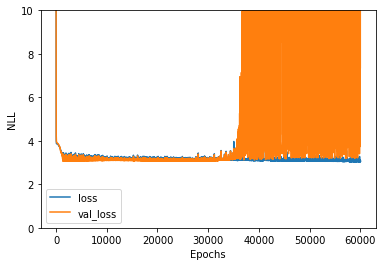

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')
plt.ylim(0,10)
plt.show()

In [18]:
model_flex_sd_mean = Model(inputs=inputs, outputs=distLayer.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=distLayer.stddev())

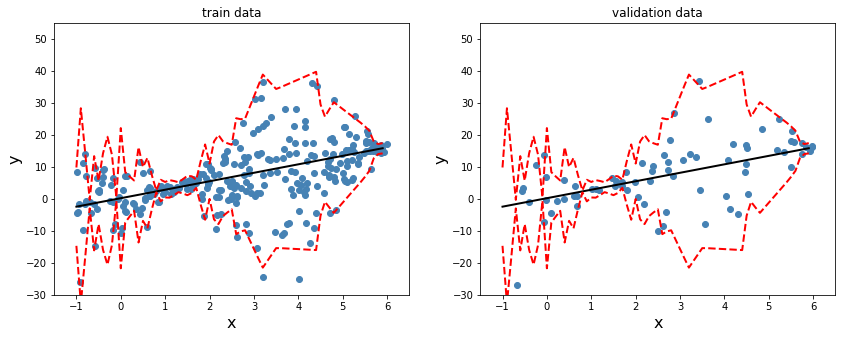

In [19]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()

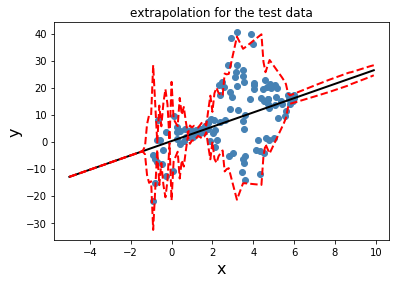

In [20]:
plt.scatter(x_test,y_test,color="steelblue") #observerd 
x_new=np.arange(-5,10,0.1)
preds_new = model_flex_sd_mean.predict(x_new)
plt.plot(x_new,preds_new,color="black",linewidth=2)
plt.plot(x_new,preds_new+2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2) 
plt.plot(x_new,preds_new-2*model_flex_sd_sd.predict(x_new),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("extrapolation for the test data")
plt.show()

In [21]:


def NLL(y, distr):
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
out1 = Dense(1)(inputs) #A
hidden1 = Dense(30,activation="relu")(inputs)
hidden1 = Dense(20,activation="relu")(hidden1)
hidden2 = Dense(20,activation="relu")(hidden1)
out2 = Dense(1)(hidden2) #B
params = Concatenate()([out1,out2]) #C
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_flex_sd = Model(inputs=inputs, outputs=dist)
model_flex_sd.compile(Adam(learning_rate=0.01), loss=NLL)
model_flex_sd.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           60          input_3[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 20)           620         dense_8[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 20)           420         dense_9[0][0]                    
____________________________________________________________________________________________

In [22]:
history = model_flex_sd.fit(x_train, y_train, epochs=2000, verbose=0, validation_data=(x_val,y_val))

In [23]:
model_flex_sd_mean = Model(inputs=inputs, outputs=dist.mean())
model_flex_sd_sd = Model(inputs=inputs, outputs=dist.stddev())

In [24]:
print(model_flex_sd.evaluate(x_train,y_train, verbose=0))
print(model_flex_sd.evaluate(x_val,y_val, verbose=0))

3.494841046707622
3.4627138988391772


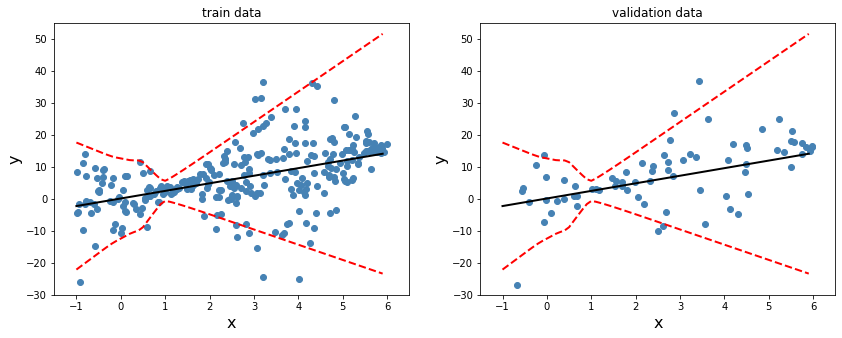

In [25]:
plt.figure(figsize=(14,5))

x_pred = np.arange(-1,6,0.1)

plt.subplot(1,2,1)
plt.scatter(x_train,y_train,color="steelblue") #observerd 
preds = model_flex_sd_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("train data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])

plt.subplot(1,2,2)
plt.scatter(x_val,y_val,color="steelblue") #observerd 
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2) 
plt.plot(x_pred,preds-2*model_flex_sd_sd.predict(x_pred),color="red",linestyle="--",linewidth=2)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.title("validation data")
plt.xlim([-1.5,6.5])
plt.ylim([-30,55])
plt.show()


In [26]:
def zero_inf(out): 
    print(out.shape)
    rate = tf.squeeze(tf.math.exp(out[:,0:1])) #A 
    s = tf.math.sigmoid(out[:,1:2]) #B  
    probs = tf.concat([1-s, s], axis=1) #C 
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
          tfd.Deterministic(loc=tf.zeros_like(rate)), #E
          tfd.Poisson(rate=rate), #F 
        ])

#A The first component codes for the rate. We used exponential to guaranty values > 0. We also used the squeeze function to flatten the tensor.
#B The second component codes for zero inflation; using the sigmoid squeezes the value between 0 and 1.
#C The two probabilities for 0’s or Poissonian distribution 
#D tfd.Categorical allows creating a mixture of two components. 
#E Zero as a deterministic value 

In [27]:
## testinging the distribution, we evalute some data 

print("rate of the poissonian :", tf.exp(1.0).numpy())
print("probability to pick the poisson process :" ,tf.math.sigmoid(10.0).numpy())
print("probability to pick the poisson process :" ,tf.math.sigmoid(-10.0).numpy())


t = np.ones((2,2), dtype=np.float32)
t[0,0] = 1
t[0,1] = 10#almost always take pois 
t[1,0] = 1
t[1,1] = -10# almost always take zero
#t = tf.cast(t, dtype="float32")
print('Input Tensor : ')
print(t)
print('Output Mean  : ',zero_inf(t).mean().numpy())
print('Output Sample  : ',zero_inf(t).sample().numpy())

rate of the poissonian : 2.7182817
probability to pick the poisson process : 0.9999546
probability to pick the poisson process : 4.539787e-05
Input Tensor : 
[[  1.  10.]
 [  1. -10.]]
(2, 2)
Output Mean  :  [2.7181582e+00 1.2340420e-04]
(2, 2)
Output Sample  :  [1. 0.]


In [28]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
dat = np.loadtxt('https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/fish.csv',delimiter=',', skiprows=1)
X = dat[...,1:5] #"livebait","camper","persons","child
y = dat[...,7]
X=np.array(X,dtype="float32")
y=np.array(y,dtype="float32")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
d = X_train.shape[1]
X_train.shape, y_train.shape, X_test.shape, y_test.shape,dat.shape, y_test[0:10], y_train[0:10]

((200, 4),
 (200,),
 (50, 4),
 (50,),
 (250, 8),
 array([0., 0., 2., 2., 0., 0., 0., 0., 1., 0.], dtype=float32),
 array([ 6.,  1.,  6.,  1.,  3.,  1.,  0., 15.,  0.,  2.], dtype=float32))

In [29]:
import pandas as pd
# Calculation of the the optimal sigma 
y_hat_train = model_skl.predict(X_train)
n = len(y_hat_train)
sigma_hat_2 = (n-1.)/(n-2.) * np.var(y_train - y_hat_train.flatten(),ddof=1)
print('Estimated variance ', sigma_hat_2)
print('Estimated standart deviation ', np.sqrt(sigma_hat_2))

y_hat = model_skl.predict(X_test) #Prediction on the testset
RMSE_skl = np.sqrt(np.mean((y_test - y_hat.flatten())**2))
MAE_skl = np.mean(np.abs(y_test- y_hat.flatten())) 

NLL_skl =  0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_test - y_hat.flatten())**2)/sigma_hat_2
print('NLL on training:', 0.5*np.log(2 * np.pi * sigma_hat_2) + 0.5*np.mean((y_train - y_hat_train.flatten())**2)/sigma_hat_2)

df1 = pd.DataFrame(
          {'RMSE' : RMSE_skl, 'MAE' : MAE_skl, 'NLL (mean)' : NLL_skl}, index=['Linear Regression (sklearn)']
)
df1

NameError: name 'model_skl' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp

%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

## Definition of the custom parametrized distribution
inputs = tf.keras.layers.Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs) #A
p_y_zi = tfp.layers.DistributionLambda(zero_inf)(out)
model_zi = Model(inputs=inputs, outputs=p_y_zi)

#A A dense layer is used without activation. The transformation is done inside the zero_inf function
model_zi.summary()

In [ ]:


def NLL(y_true, y_hat):
    print(y_true.shape,y_hat.shape,tf.reshape(y_true,(-1,)).shape)
    
    return -y_hat.log_prob(tf.reshape(y_true,(-1,)))


model_zi.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=NLL)
hist_zi = model_zi.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=2000, verbose=1)

